In [1]:
import numpy as np
from datetime import datetime
import pandas as pd
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
import h5py
from torch.utils.data.dataset import Dataset

In [2]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os,sys
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
torch.cuda.is_available()

PyTorch Version:  1.9.1
Torchvision Version:  0.10.1


True

In [3]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels, affine=False),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   



class UNetSmall(nn.Module):

    def __init__(self, in_channels,out_channels,dropout=0.2):
        super().__init__()
                
        self.dconv_down1 = double_conv(in_channels, 32)
        self.dconv_down2 = double_conv(32, 64)
        self.dconv_down3 = double_conv(64, 128)
        self.dconv_down4 = double_conv(128, 256)
        self.dconv_down5 = double_conv(256, 512)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up4 = double_conv(512+256, 256)
        self.dconv_up3 = double_conv(256+128, 128)
        self.dconv_up2 = double_conv(128+64, 64)
        self.dconv_up1 = double_conv(64+32, 32)
        
        self.conv_last = nn.Conv2d(32, out_channels, 1)
#         self.fc1 = nn.Linear(25600 ,1024)
#         self.bn_fc1 = nn.BatchNorm1d(1024)
        self.dropout1 = nn.Dropout(dropout)
        self.bn2d = nn.BatchNorm2d(num_features=512, affine=False)
#         self.out = nn.Linear(1024, n_class)
        self.relu = nn.ReLU()
#         self.softmax = nn.Softmax(-1)
#         self.init_weights()
        
#     def init_weights(self):
#         self.dconv_down1.weight.data.normal_(0, 0.01)
#         self.dconv_down2.weight.data.normal_(0, 0.01)
#         self.dconv_down3.weight.data.normal_(0, 0.01)
#         self.dconv_down4.weight.data.normal_(0, 0.01)
#         self.dconv_up3.weight.data.normal_(0, 0.01)
#         self.dconv_up2.weight.data.normal_(0, 0.01)
#         self.dconv_up1.weight.data.normal_(0, 0.01)
#         self.conv_last.weight.data.normal_(0, 0.01)
        
    def forward(self, x):
#         print('x Down1pre shape: ',x.shape)
        conv1 = self.dconv_down1(x)
        
        x = self.maxpool(conv1)
#         print('x Down1post shape: ',x.shape)
    
        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
#         print('x Down2post shape: ',x.shape)
        
    
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
#         print('x Down3post shape: ',x.shape)

    
        conv4 = self.dconv_down4(x)
        x = self.maxpool(conv4) 
#         print('x Down4post shape: ',x.shape)
    
        x = self.dconv_down5(x)
        x = self.dropout1(x)
#         x = self.bn2d(x)
#         print('x Down5post shape: ',x.shape)
        

#         print('x shape: ',x.shape)
        #Classifier
#         flatten = x.view(x.size(0),-1)
# #         print('fc:',flatten.size())
#         y = self.fc1(flatten)
#         y = self.bn_fc1(y)
#         y = self.relu(y)
#         y = self.dropout1(y)

#         y = self.out(y)
# #         print('out:',x.size())
#         prediction = nn.functional.log_softmax(y,dim=1)
        
        x = self.upsample(x)
#         print('x up4pre shape: ',x.shape)
        x = torch.cat([x, conv4], dim=1)
#         print('x up4post shape: ',x.shape)
        x = self.dconv_up4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
#         print('x up3post shape: ',x.shape)
        
        x = self.dconv_up3(x)
        
        x = self.upsample(x)
                
        x = torch.cat([x, conv2], dim=1)  
#         print('x up2post shape: ',x.shape)

        x = self.dconv_up2(x)
        x = self.upsample(x)     
        
        x = torch.cat([x, conv1], dim=1)   
#         print('x up1post shape: ',x.shape)
        
        x = self.dconv_up1(x)
#         x = self.bn2d(x)
        out = self.conv_last(x)
#         print('output shape: ',out.shape)
#         out = self.relu(out)
#         out = self.softmax(out)
        
        return out

In [4]:
def init_weights(m):
# print(m)
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        m.weight.data.normal_(0, 0.0001)
# print(m.weight)

# net = nn.Sequential(nn.Linear(2, 2), nn.Linear(2, 2))
# net.apply(init_weights)

In [5]:
from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNetSmall(1,3)
model.apply(init_weights)
model = model.to(device)
# model
# summary(model, input_size=(1, 112, 80), dtypes=[torch.float, torch.long])
summary(model, input_size=(1, 112, 80))

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       320
|    └─BatchNorm2d: 2-2                  --
|    └─ReLU: 2-3                         --
|    └─Conv2d: 2-4                       9,248
|    └─ReLU: 2-5                         --
├─Sequential: 1-2                        --
|    └─Conv2d: 2-6                       18,496
|    └─BatchNorm2d: 2-7                  --
|    └─ReLU: 2-8                         --
|    └─Conv2d: 2-9                       36,928
|    └─ReLU: 2-10                        --
├─Sequential: 1-3                        --
|    └─Conv2d: 2-11                      73,856
|    └─BatchNorm2d: 2-12                 --
|    └─ReLU: 2-13                        --
|    └─Conv2d: 2-14                      147,584
|    └─ReLU: 2-15                        --
├─Sequential: 1-4                        --
|    └─Conv2d: 2-16                      295,168
|    └─BatchNorm2d: 2-17                 --
|

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       320
|    └─BatchNorm2d: 2-2                  --
|    └─ReLU: 2-3                         --
|    └─Conv2d: 2-4                       9,248
|    └─ReLU: 2-5                         --
├─Sequential: 1-2                        --
|    └─Conv2d: 2-6                       18,496
|    └─BatchNorm2d: 2-7                  --
|    └─ReLU: 2-8                         --
|    └─Conv2d: 2-9                       36,928
|    └─ReLU: 2-10                        --
├─Sequential: 1-3                        --
|    └─Conv2d: 2-11                      73,856
|    └─BatchNorm2d: 2-12                 --
|    └─ReLU: 2-13                        --
|    └─Conv2d: 2-14                      147,584
|    └─ReLU: 2-15                        --
├─Sequential: 1-4                        --
|    └─Conv2d: 2-16                      295,168
|    └─BatchNorm2d: 2-17                 --
|

In [6]:
from collections import defaultdict
import torch.nn.functional as F

In [7]:
Datadir = "G:\\00TIGS2Testing\\CHOSorting2\\G1\\ImageRaw"

In [8]:
import os

def datapreparation(Datadir):
#     Datapath = []
    trainlabel = []
    fpath = []
    for dirpath, dirnames, filenames in os.walk(Datadir):
        for filename in [f for f in filenames if f.endswith(".mat")]:
            tempfpath =os.path.join(dirpath, filename)
            fpath.append(tempfpath)
    datalength = list(range(1,len(fpath)))
    print('dataset length: %d' %(len(datalength)))

    return fpath

In [9]:
X= datapreparation(Datadir)

dataset length: 11209


In [10]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True,random_state=1)
trainindex = {}
testindex = {}
i = 0
for train_index, test_index in kfold.split(X):
    print("Train Index: ", train_index, "\n")
    print("Test Index: ", test_index)
    trainindex[i] = train_index
    testindex[i] = test_index
    i = i + 1
#fold - 0
# print(trainindex[1])
# indices = trainindex[1]
trainpath =[X[i] for i in trainindex[1]]
testpath =[X[i] for i in testindex[1]]



Train Index:  [    0     1     2 ... 11206 11207 11209] 

Test Index:  [    4     6     7 ... 11202 11205 11208]
Train Index:  [    0     1     2 ... 11207 11208 11209] 

Test Index:  [   10    16    21 ... 11190 11203 11206]
Train Index:  [    0     1     2 ... 11206 11208 11209] 

Test Index:  [    3     5    11 ... 11199 11200 11207]
Train Index:  [    0     2     3 ... 11206 11207 11208] 

Test Index:  [    1     8     9 ... 11198 11201 11209]
Train Index:  [    1     3     4 ... 11207 11208 11209] 

Test Index:  [    0     2    15 ... 11191 11194 11204]


In [11]:
trainpath[0]

'G:\\00TIGS2Testing\\CHOSorting2\\G1\\ImageRaw\\1-40_Images.mat'

In [12]:
import scipy.io
from PIL import Image
import random

class MyDataset(Dataset):
    def __init__(self, mat_paths, transforms=None):
        self.paths = mat_paths
        self.transforms = transforms
        
    def __getitem__(self, index):
        # Load .mat
#         data = loadmat(self.paths[index])
        data = scipy.io.loadmat(self.paths[index])
        x = np.array(data['ImgresizeTrans'])
#         x = x[:,4:-4]
#         x = np.concatenate((x,np.tile(x[-1,:],(3,1))),axis=0)
        if x.max() == 0:
            x = x
        else:
            x = (x-x.min())/(x.max()-x.min())
        y = np.transpose(np.array(data['RGBresize']),(2,0,1))
#         y = y[:,:,4:-4]
#         tempy = np.zeros((y.shape[0],3,y.shape[2]))
#         y = np.concatenate((y,tempy),axis=1)
#         y_rgb = np.array(data['RGB'])
#         y_rgb = y_rgb[:,10:250,:]
#         tempyrgb = np.zeros((3,y.shape[1],y.shape[2]))
#         y_rgb = np.concatenate((y_rgb,tempyrgb),axis=0)
        y = (y/255).astype(np.uint8)
        y[y<1] = 0
        y_new = np.zeros(y.shape).astype(np.uint8)
        y_new[0,:,:] = y[0,:,:]
        y_new[1,:,:] = y[1,:,:] + y[0,:,:]
        y_new[2,:,:] = y[2,:,:] + y[1,:,:] + y[0,:,:]
#         y_new = y_new[0:-1,:,:]
        p1 = random.uniform(0, 1)
        p2 = random.uniform(0, 1)
            
        x = torch.from_numpy(x)
        x = x.type(torch.FloatTensor)
        x = x.unsqueeze(dim = 0)
        y_new = torch.from_numpy(y_new)
        if p1 >=0.5:
            x = torch.flip(x, dims=[1])
            y_new = torch.flip(y_new, dims=[1])
            
        if p2 >=0.5:
            x = torch.flip(x, dims=[2])
            y_new = torch.flip(y_new, dims=[2])        
        return x, y_new,index
    
    def __len__(self):
        return len(self.paths)

In [13]:
img_datasets = MyDataset(trainpath[0:3000])
type(img_datasets.__getitem__(0)[0])

torch.Tensor

In [14]:
#actual prediction
image_datasets = {}
mini_datasets ={}
image_datasets['train'] = MyDataset(trainpath)
image_datasets['val'] = MyDataset(testpath)
# mini_datasets['train'] = MyDataset(minitrainpath)
# mini_datasets['val'] = MyDataset(minivalpath)
# model testing
# image_datasets['train'] = MyDataset(valpath)
# image_datasets['val'] = MyDataset(testpath)
# test_datasets['val'] = MyDataset(testpath)
print('training data volume: ', image_datasets['train'].__len__())
print('validation data volume: ', image_datasets['val'].__len__())

# print('mini-training data volume: ', mini_datasets['train'].__len__())
# print('mini-validation data volume: ', mini_datasets['val'].__len__())

training data volume:  8968
validation data volume:  2242


In [15]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [16]:
#Visualize image stacks
from mpl_toolkits.axes_grid1 import make_axes_locatable


def DisplayImage(img,LimMin,LimMax,Idx):  
#     if img.shape[2]>1:
#         for depth in range (0,10):
#             fig4 = plt.imshow(np.squeeze(img),vmin=LimMin, vmax=LimMax, cmap ='gray')
#             plt.subplot(2,5,depth+1)
#             plt.imshow(img[:,:,depth*8],vmin=LimMin, vmax=LimMax, cmap ='gray')
#             # plt.colorbar()
#             plt.title('z = '+ str(depth))
#             if depth==9:
#                 plt.subplot(2,5,depth+1)
#                 plt.title('z = '+ str(depth))
#                 ax = plt.gca()
#                 fig4 = plt.imshow(img[:,:,depth*8],vmin=LimMin, vmax=LimMax, cmap ='gray')

#         divider = make_axes_locatable(ax)
#         cax = divider.append_axes("right", size="5%", pad=0.05)
#         plt.colorbar(fig4, cax=cax)
#         plt.show()
#     else:
    fig4 = plt.imshow(np.squeeze(img),vmin=LimMin, vmax=LimMax, cmap ='gray')
    plt.title('Transmission ' + str(Idx))
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(fig4, cax=cax)
    plt.show()


image tensor shape:  torch.Size([1, 80, 112])
image tensor dtype:  torch.float32
image tensor index:  3
mask shape:  torch.Size([3, 80, 112])
image shape:  (80, 112)


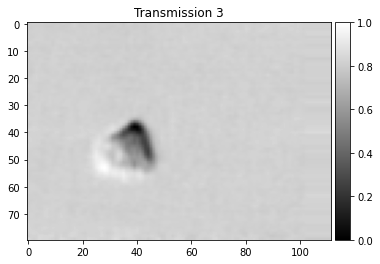

In [17]:
ImgIdx = 3
image_datasets['train'].__getitem__(ImgIdx)[0].shape
ImgTensor = 0
ImgMask = 0
[ImgTensor,ImgMask,ImgIdx] = image_datasets['train'].__getitem__(ImgIdx)
# image = np.transpose(ImgTensor.numpy(), (1,2,0))
# print('Cell Label: ',CellName[ImgLabel])
print('image tensor shape: ', ImgTensor.shape)
print('image tensor dtype: ', ImgTensor.dtype)
print('image tensor index: ', ImgIdx)
print('mask shape: ', ImgMask.shape)
# image_datasets['train'].__getitem__(ImgIdx)[0]

#Visualize image stacks
from mpl_toolkits.axes_grid1 import make_axes_locatable
image = 0
image = np.squeeze(ImgTensor.numpy())
print('image shape: ', image.shape)
DisplayImage(image,image.min(),image.max(),ImgIdx)

In [18]:
import matplotlib.colors as colors
cmap = colors.ListedColormap(['black', 'lightblue', 'green', 'tomato'])
boundaries = [-0.5, 0.5, 1.5, 2.5, 3.5]
norm = colors.BoundaryNorm(boundaries, cmap.N, clip=True)

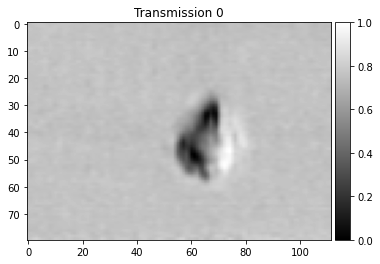

(3, 80, 112)
MaskOverlay shape: (80, 112)
(3, 80, 112)


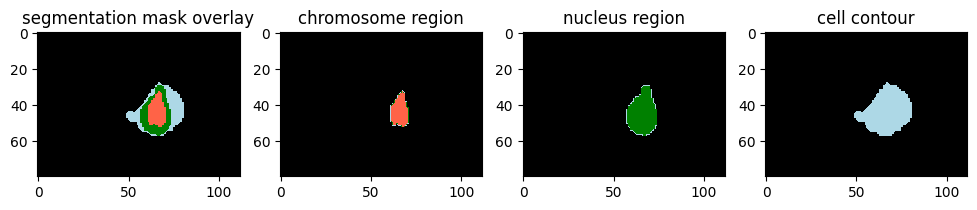

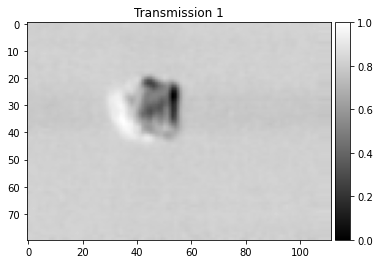

(3, 80, 112)
MaskOverlay shape: (80, 112)
(3, 80, 112)


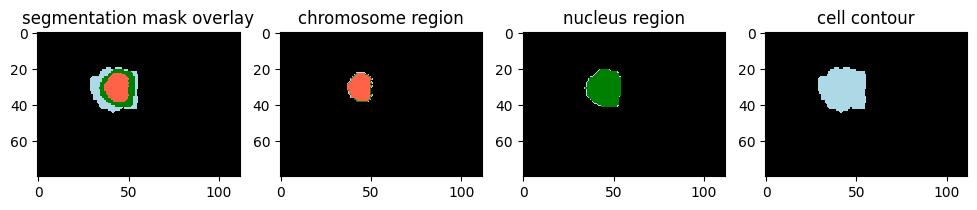

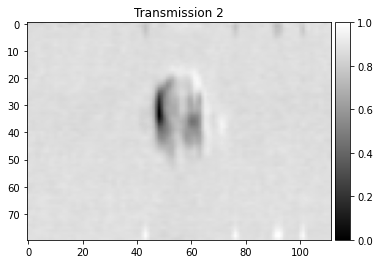

(3, 80, 112)
MaskOverlay shape: (80, 112)
(3, 80, 112)


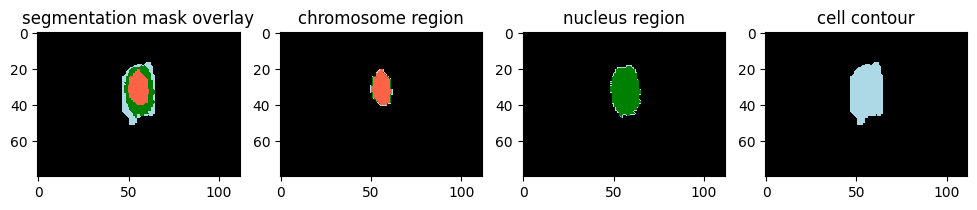

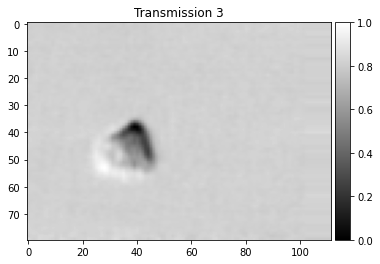

(3, 80, 112)
MaskOverlay shape: (80, 112)
(3, 80, 112)


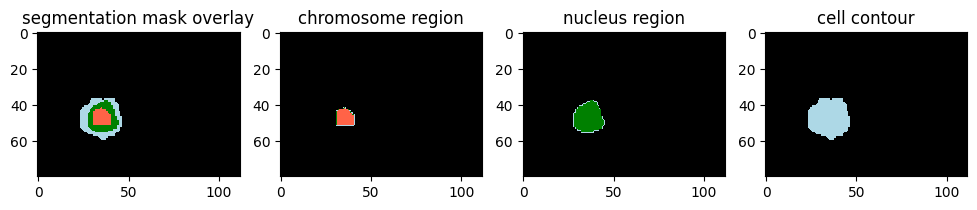

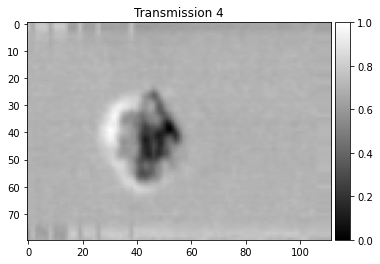

(3, 80, 112)
MaskOverlay shape: (80, 112)
(3, 80, 112)


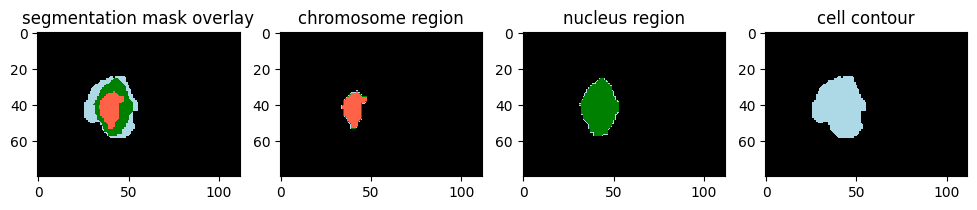

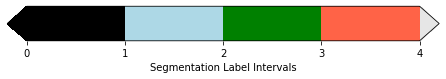

In [19]:
for ImgIdx in range(0,5):
    [ImgTensor,ImgMask,ImgIdx] = image_datasets['train'].__getitem__(ImgIdx)
    image = 0
    image = np.squeeze(ImgTensor.numpy())
    DisplayImage(image,image.min(),image.max(),ImgIdx)
    # image = np.squeeze(image)
    mask = np.zeros(ImgMask.numpy().shape)
    mask = ImgMask.numpy()
    print(mask.shape)
#     tempimage = image
#     tempimage[tempimage>0] = 1
#     mask2 = tempimage
    mask2 = mask[2]
    mask1 = mask[1]
    mask0 = mask[0]
    MaskOverlay = mask0 + mask1 + mask2
    print('MaskOverlay shape:', MaskOverlay.shape)
    # mask = np.transpose(ImgMask.numpy(), (1,2,0))
    # image = np.squeeze(image)
    # mask = ImgMask.numpy()
    # print(mask[:,0,0].sum())
    print(mask.shape)
    # Imgmask= np.transpose(mask,(1,2,0))
    fig = plt.figure(figsize=(12, 60), dpi=100)
    plt.subplot(1, 4, 1)
    plt.imshow(MaskOverlay,cmap=cmap,norm=norm)
    plt.title('segmentation mask overlay')
    plt.subplot(1, 4, 2)
    plt.imshow(mask0*3,cmap=cmap,norm=norm)
    # tempmask = mask[0]
    # tempmask[tempmask < 3] = 0
    # mask[0] = tempmask
    plt.title('chromosome region')
    plt.subplot(1, 4, 3)
    plt.imshow(mask1*2,cmap=cmap,norm=norm)
    plt.title('nucleus region')
    plt.subplot(1, 4, 4)
    plt.imshow(mask2,cmap=cmap,norm=norm)
    plt.title('cell contour')
    plt.show()


    
import matplotlib as mpl
fig, ax = plt.subplots(figsize=(30, 1))
fig.subplots_adjust(bottom=0.4,left=0.7)

cmap = mpl.colors.ListedColormap(['black', 'lightblue', 'green', 'tomato'])
cmap.set_over('0.9')
cmap.set_under('0.75')

bounds = [0, 1, 2, 3, 4]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb2 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                boundaries=[0] + bounds + [13],
                                extend='both',
                                ticks=bounds,
                                spacing='proportional',
                                orientation='horizontal')
cb2.set_label('Segmentation Label Intervals')

    # fig = plt.figure()
    # plt.imshow(mask0)
    # plt.colorbar()
    # # tempmask = mask[0]
    # # tempmask[tempmask < 3] = 0
    # # mask[0] = tempmask
    # plt.title('chromosome region')
    # plt.show()

In [20]:
# dice loss
def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()

In [21]:
def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)
    pred = torch.sigmoid(pred)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss

def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ", ".join(outputs)))
def clac_iouscore (mask, maskpred):
    maskbool = mask.astype(dtype=bool)
    maskpredbool = maskpred.astype(dtype=bool)
    intersection = np.logical_and(maskbool, maskpredbool)
    union = np.logical_or(maskbool, maskpredbool)
    iou_score = np.sum(intersection) / np.sum(union)
    
    return iou_score

In [22]:
import tqdm
def train_model(model, dataloaders, optimizer1, optimizer2, scheduler1, scheduler2, num_epochs=25):
    start = datetime.now()
    val_acc_history = []
    train_acc_history = []
    val_Bacc_history = []
    train_Bacc_history = []
    val_loss_history = []
    train_loss_history = []
    val_bceloss_history = []
    lr_history = []
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    outer = tqdm.tqdm(total=num_epochs, desc='num_epochs', position=0)
    for epoch in range(num_epochs):
        print('\n')
        print('-' * 10)
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                if epoch < 10:
                    for param_group in optimizer1.param_groups:
                        print("LR", param_group['lr'])
                        lr_history.append(param_group['lr'])
                else:
                    for param_group in optimizer2.param_groups:
                        print("LR", param_group['lr'])
                        lr_history.append(param_group['lr'])
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
#             running_loss = 0.0
            running_corrects = 0
            confusion_matrix = torch.zeros(3, 3)
            for inputs, labels,index in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)             

                # zero the parameter gradients
                if epoch < 10:
                    optimizer1.zero_grad()
                else:
                    optimizer2.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
#                     print('outputs type:', outputs.dtype)
#                     print('labels type:', labels.dtype)
                    labels = labels.type(torch.FloatTensor).to(device)
                    loss = calc_loss(outputs,labels, metrics,bce_weight = 0.1)


                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        if epoch < 5:
                            optimizer1.step()
                        else:
                            optimizer2.step()
                _, preds = torch.max(outputs, dim = 1)
#                 print('preds size: ',preds.shape)
                # statistics
                epoch_samples += inputs.size(0)
                # statistics
#                 for t, p in zip(labels.view(-1), preds.view(-1)):
#                     confusion_matrix[t.long(), p.long()] += 1

#                 running_corrects += torch.sum(preds == labels.data)


#             confusionMat = np.asarray(confusion_matrix)
#             sumconfusion = np.sum(confusionMat,axis = 1).T

#             summat = np.tile(sumconfusion,(3,1)).T
            # print(test)
#             percentconfusion = np.divide(confusionMat,summat)
#             epoch_acc_balanced = np.sum(np.diagonal(percentconfusion))/3
            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples
#             epoch_acc = running_corrects.double() / epoch_samples
#             print('{} Acc: {:.4f}'.format(phase, epoch_acc))
#             print('{} Bal. Acc: {:.4f}'.format(phase, epoch_acc_balanced))
            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
#                 best_acc = epoch_acc
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
#                 val_acc_history.append(epoch_acc)
#                 val_Bacc_history.append(epoch_acc_balanced)
                val_loss_history.append(epoch_loss)
                val_bceloss_history.append(metrics['bce']/epoch_samples)
                if epoch < 5:
                    scheduler1.step(epoch_loss)
                else:
#                 elif epoch > num_epochs * (1/3):
                    scheduler2.step(epoch_loss)
                

            if phase == 'train':
#                 train_acc_history.append(epoch_acc)
#                 train_Bacc_history.append(epoch_acc_balanced)
                train_loss_history.append(epoch_loss)
#             if epoch_acc == 1:
#                 break
            

        if epoch > 3 and val_bceloss_history[-1] > 1.8e7 :
                break
        print("Total time: %s" %(datetime.now() - start))
        time_elapsed = time.time() - since
        print('Epoch time: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        outer.update(1)
        if param_group['lr'] <= 2e-7:
            break
        
    print('Best val loss: {:4f}'.format(best_loss))
#     print('Best val acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,train_loss_history,val_loss_history,lr_history

In [23]:
# Data augmentation and normalization for training
# Just normalization for validation

print("Initializing Datasets and Dataloaders...")
# Number of classes in the dataset
num_classes = 3

# Batch size for training (change depending on how much memory you have)
batch_size = 256
# Create training and validation datasets
# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=0) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


Fold- 0 : Initializing Datasets and Dataloaders...


num_epochs:   0%|                                                                              | 0/150 [00:00<?, ?it/s]



----------
Epoch 0/149
LR 5e-06
train: bce: 0.749394, dice: 0.931185, loss: 0.913006


num_epochs:   1%|▍                                                                   | 1/150 [00:55<2:16:48, 55.09s/it]

val: bce: 0.749317, dice: 0.931186, loss: 0.912999
saving best model
Total time: 0:00:55.101341
Epoch time: 0m 55s


----------
Epoch 1/149
LR 5e-06
train: bce: 0.749253, dice: 0.931185, loss: 0.912992


num_epochs:   1%|▉                                                                   | 2/150 [01:25<1:39:32, 40.35s/it]

val: bce: 0.749173, dice: 0.931187, loss: 0.912985
saving best model
Total time: 0:01:25.138641
Epoch time: 0m 30s


----------
Epoch 2/149
LR 5e-06
train: bce: 0.749104, dice: 0.931186, loss: 0.912978


num_epochs:   2%|█▎                                                                  | 3/150 [01:54<1:26:33, 35.33s/it]

val: bce: 0.748942, dice: 0.931188, loss: 0.912963
saving best model
Total time: 0:01:54.496420
Epoch time: 0m 29s


----------
Epoch 3/149
LR 5e-06
train: bce: 0.748885, dice: 0.931184, loss: 0.912954


num_epochs:   3%|█▊                                                                  | 4/150 [02:23<1:19:43, 32.77s/it]

val: bce: 0.747038, dice: 0.931197, loss: 0.912781
saving best model
Total time: 0:02:23.330918
Epoch time: 0m 29s


----------
Epoch 4/149
LR 5e-06
train: bce: 0.747511, dice: 0.931135, loss: 0.912773


num_epochs:   3%|██▎                                                                 | 5/150 [02:52<1:15:44, 31.34s/it]

val: bce: 0.738182, dice: 0.931387, loss: 0.912067
saving best model
Total time: 0:02:52.149544
Epoch time: 0m 29s


----------
Epoch 5/149
LR 5e-06
train: bce: 0.613563, dice: 0.917409, loss: 0.887025


num_epochs:   4%|██▋                                                                 | 6/150 [03:20<1:13:10, 30.49s/it]

val: bce: 0.730333, dice: 0.931289, loss: 0.911193
saving best model
Total time: 0:03:20.976603
Epoch time: 0m 29s


----------
Epoch 6/149
LR 5e-06
train: bce: 0.320387, dice: 0.751316, loss: 0.708223


num_epochs:   5%|███▏                                                                | 7/150 [03:49<1:11:24, 29.96s/it]

val: bce: 3.635533, dice: 0.995247, loss: 1.259275
Total time: 0:03:49.863676
Epoch time: 0m 29s


----------
Epoch 7/149
LR 5e-06
train: bce: 0.243591, dice: 0.658176, loss: 0.616718


num_epochs:   5%|███▋                                                                | 8/150 [04:18<1:10:08, 29.64s/it]

val: bce: 0.211898, dice: 0.677975, loss: 0.631367
saving best model
Total time: 0:04:18.805806
Epoch time: 0m 29s


----------
Epoch 8/149
LR 5e-06
train: bce: 0.234830, dice: 0.647560, loss: 0.606287


num_epochs:   6%|████                                                                | 9/150 [04:47<1:09:12, 29.45s/it]

val: bce: 0.697256, dice: 0.926506, loss: 0.903581
Total time: 0:04:47.842673
Epoch time: 0m 29s


----------
Epoch 9/149
LR 5e-06
train: bce: 0.113682, dice: 0.575141, loss: 0.528995


num_epochs:   7%|████▍                                                              | 10/150 [05:16<1:08:18, 29.28s/it]

val: bce: 0.582265, dice: 0.915854, loss: 0.882495
Total time: 0:05:16.731731
Epoch time: 0m 29s


----------
Epoch 10/149
LR 0.0005
train: bce: 0.062356, dice: 0.492755, loss: 0.449715


num_epochs:   7%|████▉                                                              | 11/150 [05:45<1:07:36, 29.18s/it]

val: bce: 0.682859, dice: 0.926824, loss: 0.902427
Total time: 0:05:45.695189
Epoch time: 0m 29s


----------
Epoch 11/149
LR 0.0005
train: bce: 0.059495, dice: 0.471157, loss: 0.429991


num_epochs:   8%|█████▎                                                             | 12/150 [06:14<1:07:00, 29.13s/it]

val: bce: 0.641378, dice: 0.916917, loss: 0.889363
Total time: 0:06:14.712712
Epoch time: 0m 29s


----------
Epoch 12/149
LR 0.0005
train: bce: 0.055809, dice: 0.455580, loss: 0.415603


num_epochs:   9%|█████▊                                                             | 13/150 [06:43<1:06:24, 29.08s/it]

val: bce: 0.630541, dice: 0.914148, loss: 0.885787
Total time: 0:06:43.685594
Epoch time: 0m 29s


----------
Epoch 13/149
LR 0.0005
train: bce: 0.057043, dice: 0.460272, loss: 0.419949


num_epochs:   9%|██████▎                                                            | 14/150 [07:12<1:05:48, 29.03s/it]

val: bce: 0.116935, dice: 0.601990, loss: 0.553484
saving best model
Total time: 0:07:12.591516
Epoch time: 0m 29s


----------
Epoch 14/149
LR 0.0005
train: bce: 0.060101, dice: 0.464120, loss: 0.423718


num_epochs:  10%|██████▋                                                            | 15/150 [07:41<1:05:25, 29.08s/it]

val: bce: 0.697852, dice: 0.918487, loss: 0.896424
Total time: 0:07:41.776190
Epoch time: 0m 29s


----------
Epoch 15/149
LR 0.0005
train: bce: 0.048487, dice: 0.437612, loss: 0.398699


num_epochs:  11%|███████▏                                                           | 16/150 [08:10<1:05:00, 29.11s/it]

val: bce: 0.371608, dice: 0.764980, loss: 0.725642
Total time: 0:08:10.958386
Epoch time: 0m 29s


----------
Epoch 16/149
LR 0.0005
train: bce: 0.044129, dice: 0.430694, loss: 0.392038


num_epochs:  11%|███████▌                                                           | 17/150 [08:39<1:04:27, 29.08s/it]

val: bce: 0.170931, dice: 0.632141, loss: 0.586020
Total time: 0:08:39.967973
Epoch time: 0m 29s


----------
Epoch 17/149
LR 0.0005
train: bce: 0.042863, dice: 0.425329, loss: 0.387082


num_epochs:  12%|████████                                                           | 18/150 [09:09<1:04:00, 29.10s/it]

val: bce: 0.046648, dice: 0.428881, loss: 0.390658
saving best model
Total time: 0:09:09.107510
Epoch time: 0m 29s


----------
Epoch 18/149
LR 0.0005
train: bce: 0.040823, dice: 0.418812, loss: 0.381013


num_epochs:  13%|████████▍                                                          | 19/150 [09:38<1:03:24, 29.04s/it]

val: bce: 0.040569, dice: 0.417531, loss: 0.379835
saving best model
Total time: 0:09:38.014920
Epoch time: 0m 29s


----------
Epoch 19/149
LR 0.0005
train: bce: 0.039609, dice: 0.413257, loss: 0.375892


num_epochs:  13%|████████▉                                                          | 20/150 [10:06<1:02:49, 28.99s/it]

val: bce: 0.037874, dice: 0.419860, loss: 0.381662
Total time: 0:10:06.902986
Epoch time: 0m 29s


----------
Epoch 20/149
LR 0.0005
train: bce: 0.038735, dice: 0.408218, loss: 0.371269


num_epochs:  14%|█████████▍                                                         | 21/150 [10:35<1:02:12, 28.94s/it]

val: bce: 0.042739, dice: 0.411408, loss: 0.374541
saving best model
Total time: 0:10:35.708220
Epoch time: 0m 29s


----------
Epoch 21/149
LR 0.0005
train: bce: 0.037918, dice: 0.402934, loss: 0.366433


num_epochs:  15%|█████████▊                                                         | 22/150 [11:04<1:01:46, 28.96s/it]

val: bce: 0.052240, dice: 0.482884, loss: 0.439820
Total time: 0:11:04.707886
Epoch time: 0m 29s


----------
Epoch 22/149
LR 0.0005
train: bce: 0.037038, dice: 0.397727, loss: 0.361658


num_epochs:  15%|██████████▎                                                        | 23/150 [11:33<1:01:11, 28.91s/it]

val: bce: 0.081512, dice: 0.533061, loss: 0.487906
Total time: 0:11:33.507169
Epoch time: 0m 29s


----------
Epoch 23/149
LR 0.0005
train: bce: 0.036453, dice: 0.393381, loss: 0.357688


num_epochs:  16%|██████████▋                                                        | 24/150 [12:02<1:00:38, 28.88s/it]

val: bce: 0.038448, dice: 0.395451, loss: 0.359751
saving best model
Total time: 0:12:02.314882
Epoch time: 0m 29s


----------
Epoch 24/149
LR 0.0005
train: bce: 0.036093, dice: 0.389234, loss: 0.353920


num_epochs:  17%|███████████▏                                                       | 25/150 [12:31<1:00:08, 28.86s/it]

val: bce: 0.036330, dice: 0.401106, loss: 0.364628
Total time: 0:12:31.146405
Epoch time: 0m 29s


----------
Epoch 25/149
LR 0.0005
train: bce: 0.035247, dice: 0.384158, loss: 0.349267


num_epochs:  17%|███████████▌                                                       | 26/150 [13:00<1:00:10, 29.12s/it]

val: bce: 0.050991, dice: 0.454917, loss: 0.414524
Total time: 0:13:00.861304
Epoch time: 0m 30s


----------
Epoch 26/149
LR 0.0005
train: bce: 0.035019, dice: 0.380645, loss: 0.346083


num_epochs:  18%|████████████▍                                                        | 27/150 [13:29<59:41, 29.12s/it]

val: bce: 0.046299, dice: 0.402056, loss: 0.366480
Total time: 0:13:29.977034
Epoch time: 0m 29s


----------
Epoch 27/149
LR 0.0005
train: bce: 0.034476, dice: 0.376310, loss: 0.342127


num_epochs:  19%|████████████▉                                                        | 28/150 [13:59<59:24, 29.22s/it]

val: bce: 0.519256, dice: 0.821236, loss: 0.791038
Total time: 0:13:59.433517
Epoch time: 0m 29s


----------
Epoch 28/149
LR 0.0005
train: bce: 0.039733, dice: 0.387860, loss: 0.353048


num_epochs:  19%|█████████████▎                                                       | 29/150 [14:28<58:56, 29.23s/it]

val: bce: 0.499493, dice: 0.864918, loss: 0.828375
Total time: 0:14:28.675728
Epoch time: 0m 29s


----------
Epoch 29/149
LR 0.0005
train: bce: 0.034310, dice: 0.370777, loss: 0.337130


num_epochs:  20%|█████████████▊                                                       | 30/150 [14:57<58:16, 29.14s/it]

val: bce: 0.039254, dice: 0.377280, loss: 0.343477
saving best model
Total time: 0:14:57.611410
Epoch time: 0m 29s


----------
Epoch 30/149
LR 0.0005
train: bce: 0.033290, dice: 0.364879, loss: 0.331720


num_epochs:  21%|██████████████▎                                                      | 31/150 [15:26<57:37, 29.06s/it]

val: bce: 0.038778, dice: 0.372244, loss: 0.338897
saving best model
Total time: 0:15:26.473684
Epoch time: 0m 29s


----------
Epoch 31/149
LR 0.0005
train: bce: 0.032876, dice: 0.360726, loss: 0.327941


num_epochs:  21%|██████████████▋                                                      | 32/150 [15:55<56:59, 28.98s/it]

val: bce: 0.033974, dice: 0.360841, loss: 0.328154
saving best model
Total time: 0:15:55.268502
Epoch time: 0m 29s


----------
Epoch 32/149
LR 0.0005
train: bce: 0.032372, dice: 0.356180, loss: 0.323799


num_epochs:  22%|███████████████▏                                                     | 33/150 [16:24<56:26, 28.94s/it]

val: bce: 0.034553, dice: 0.360449, loss: 0.327860
saving best model
Total time: 0:16:24.123832
Epoch time: 0m 29s


----------
Epoch 33/149
LR 0.0005
train: bce: 0.032007, dice: 0.351795, loss: 0.319816


num_epochs:  23%|███████████████▋                                                     | 34/150 [16:52<55:54, 28.92s/it]

val: bce: 0.031830, dice: 0.352749, loss: 0.320657
saving best model
Total time: 0:16:52.981146
Epoch time: 0m 29s


----------
Epoch 34/149
LR 0.0005
train: bce: 0.031315, dice: 0.344836, loss: 0.313484


num_epochs:  23%|████████████████                                                     | 35/150 [17:21<55:26, 28.92s/it]

val: bce: 0.039842, dice: 0.356828, loss: 0.325130
Total time: 0:17:21.923276
Epoch time: 0m 29s


----------
Epoch 35/149
LR 0.0005
train: bce: 0.030286, dice: 0.326511, loss: 0.296889


num_epochs:  24%|████████████████▌                                                    | 36/150 [17:50<54:53, 28.89s/it]

val: bce: 0.043835, dice: 0.354204, loss: 0.323167
Total time: 0:17:50.750336
Epoch time: 0m 29s


----------
Epoch 36/149
LR 0.0005
train: bce: 0.030534, dice: 0.294246, loss: 0.267875


num_epochs:  25%|█████████████████                                                    | 37/150 [18:19<54:23, 28.88s/it]

val: bce: 0.072299, dice: 0.356477, loss: 0.328060
Total time: 0:18:19.599217
Epoch time: 0m 29s


----------
Epoch 37/149
LR 0.0005
train: bce: 0.030081, dice: 0.269015, loss: 0.245122


num_epochs:  25%|█████████████████▍                                                   | 38/150 [18:48<53:50, 28.84s/it]

val: bce: 0.037070, dice: 0.275549, loss: 0.251701
saving best model
Total time: 0:18:48.348899
Epoch time: 0m 29s


----------
Epoch 38/149
LR 0.0005
train: bce: 0.030075, dice: 0.238340, loss: 0.217513


num_epochs:  26%|█████████████████▉                                                   | 39/150 [19:17<53:20, 28.83s/it]

val: bce: 0.173101, dice: 0.437235, loss: 0.410822
Total time: 0:19:17.155621
Epoch time: 0m 29s


----------
Epoch 39/149
LR 0.0005
train: bce: 0.032267, dice: 0.225423, loss: 0.206108


num_epochs:  27%|██████████████████▍                                                  | 40/150 [19:46<52:54, 28.86s/it]

val: bce: 1.289462, dice: 0.914877, loss: 0.952335
Total time: 0:19:46.071464
Epoch time: 0m 29s


----------
Epoch 40/149
LR 0.0005
train: bce: 0.034627, dice: 0.219652, loss: 0.201150


num_epochs:  27%|██████████████████▊                                                  | 41/150 [20:14<52:26, 28.87s/it]

val: bce: 0.056836, dice: 0.243568, loss: 0.224895
saving best model
Total time: 0:20:14.967465
Epoch time: 0m 29s


----------
Epoch 41/149
LR 0.0005
train: bce: 0.035681, dice: 0.214980, loss: 0.197050


num_epochs:  28%|███████████████████▎                                                 | 42/150 [20:43<51:54, 28.84s/it]

val: bce: 1.226857, dice: 0.917401, loss: 0.948347
Total time: 0:20:43.737483
Epoch time: 0m 29s


----------
Epoch 42/149
LR 0.0005
train: bce: 0.036901, dice: 0.213031, loss: 0.195418


num_epochs:  29%|███████████████████▊                                                 | 43/150 [21:12<51:26, 28.85s/it]

val: bce: 0.052054, dice: 0.224942, loss: 0.207654
saving best model
Total time: 0:21:12.611165
Epoch time: 0m 29s


----------
Epoch 43/149
LR 0.0005
train: bce: 0.036759, dice: 0.208013, loss: 0.190888


num_epochs:  29%|████████████████████▏                                                | 44/150 [21:41<51:00, 28.87s/it]

val: bce: 0.040097, dice: 0.218188, loss: 0.200379
saving best model
Total time: 0:21:41.524032
Epoch time: 0m 29s


----------
Epoch 44/149
LR 0.0005
train: bce: 0.036982, dice: 0.204989, loss: 0.188188


num_epochs:  30%|████████████████████▋                                                | 45/150 [22:10<50:30, 28.86s/it]

val: bce: 0.042507, dice: 0.216252, loss: 0.198877
saving best model
Total time: 0:22:10.358034
Epoch time: 0m 29s


----------
Epoch 45/149
LR 0.0005
train: bce: 0.037354, dice: 0.202206, loss: 0.185721


num_epochs:  31%|█████████████████████▏                                               | 46/150 [22:39<49:58, 28.84s/it]

val: bce: 0.072104, dice: 0.236690, loss: 0.220231
Total time: 0:22:39.142932
Epoch time: 0m 29s


----------
Epoch 46/149
LR 0.0005
train: bce: 0.037421, dice: 0.199966, loss: 0.183711


num_epochs:  31%|█████████████████████▌                                               | 47/150 [23:08<49:37, 28.90s/it]

val: bce: 0.153982, dice: 0.426646, loss: 0.399380
Total time: 0:23:08.207575
Epoch time: 0m 29s


----------
Epoch 47/149
LR 0.0005
train: bce: 0.041415, dice: 0.212380, loss: 0.195284


num_epochs:  32%|██████████████████████                                               | 48/150 [23:37<49:07, 28.90s/it]

val: bce: 0.754971, dice: 0.871329, loss: 0.859693
Total time: 0:23:37.088696
Epoch time: 0m 29s


----------
Epoch 48/149
LR 0.0005
train: bce: 0.038023, dice: 0.197096, loss: 0.181189


num_epochs:  33%|██████████████████████▌                                              | 49/150 [24:05<48:37, 28.88s/it]

val: bce: 1.257530, dice: 0.892824, loss: 0.929295
Total time: 0:24:05.941050
Epoch time: 0m 29s


----------
Epoch 49/149
LR 0.0005
train: bce: 0.036994, dice: 0.193377, loss: 0.177738


num_epochs:  33%|███████████████████████                                              | 50/150 [24:34<48:07, 28.87s/it]

val: bce: 0.868608, dice: 0.746987, loss: 0.759149
Total time: 0:24:34.781996
Epoch time: 0m 29s


----------
Epoch 50/149
LR 0.0005
train: bce: 0.036422, dice: 0.190963, loss: 0.175509


num_epochs:  34%|███████████████████████▍                                             | 51/150 [25:03<47:37, 28.87s/it]

val: bce: 0.044710, dice: 0.197397, loss: 0.182129
saving best model
Total time: 0:25:03.635839
Epoch time: 0m 29s


----------
Epoch 51/149
LR 0.0005
train: bce: 0.036189, dice: 0.188179, loss: 0.172980


num_epochs:  35%|███████████████████████▉                                             | 52/150 [25:32<47:05, 28.84s/it]

val: bce: 0.038971, dice: 0.192207, loss: 0.176884
saving best model
Total time: 0:25:32.403873
Epoch time: 0m 29s


----------
Epoch 52/149
LR 0.0005
train: bce: 0.035344, dice: 0.185424, loss: 0.170416


num_epochs:  35%|████████████████████████▍                                            | 53/150 [26:01<46:35, 28.82s/it]

val: bce: 0.044762, dice: 0.202972, loss: 0.187151
Total time: 0:26:01.200180
Epoch time: 0m 29s


----------
Epoch 53/149
LR 0.0005
train: bce: 0.034830, dice: 0.181898, loss: 0.167191


num_epochs:  36%|████████████████████████▊                                            | 54/150 [26:30<46:08, 28.84s/it]

val: bce: 0.034777, dice: 0.180391, loss: 0.165830
saving best model
Total time: 0:26:30.062453
Epoch time: 0m 29s


----------
Epoch 54/149
LR 0.0005
train: bce: 0.032491, dice: 0.174857, loss: 0.160621


num_epochs:  37%|█████████████████████████▎                                           | 55/150 [26:58<45:39, 28.84s/it]

val: bce: 0.615326, dice: 0.480546, loss: 0.494024
Total time: 0:26:58.901415
Epoch time: 0m 29s


----------
Epoch 55/149
LR 0.0005
train: bce: 0.031938, dice: 0.128604, loss: 0.118938


num_epochs:  37%|█████████████████████████▊                                           | 56/150 [27:27<45:08, 28.81s/it]

val: bce: 0.081707, dice: 0.186251, loss: 0.175797
Total time: 0:27:27.660026
Epoch time: 0m 29s


----------
Epoch 56/149
LR 0.0005
train: bce: 0.035188, dice: 0.107570, loss: 0.100332


num_epochs:  38%|██████████████████████████▏                                          | 57/150 [27:56<44:42, 28.84s/it]

val: bce: 0.207369, dice: 0.275364, loss: 0.268564
Total time: 0:27:56.578844
Epoch time: 0m 29s


----------
Epoch 57/149
LR 0.0005
train: bce: 0.035848, dice: 0.106410, loss: 0.099354


num_epochs:  39%|██████████████████████████▋                                          | 58/150 [28:25<44:13, 28.84s/it]

val: bce: 1.145338, dice: 0.579949, loss: 0.636488
Total time: 0:28:25.404910
Epoch time: 0m 29s


----------
Epoch 58/149
LR 0.0005
train: bce: 0.036226, dice: 0.106416, loss: 0.099397


num_epochs:  39%|███████████████████████████▏                                         | 59/150 [28:54<43:42, 28.82s/it]

val: bce: 3.301127, dice: 0.818773, loss: 1.067009
Total time: 0:28:54.176415
Epoch time: 0m 29s


----------
Epoch 59/149
LR 0.0005
train: bce: 0.037515, dice: 0.107227, loss: 0.100256


num_epochs:  40%|███████████████████████████▌                                         | 60/150 [29:22<43:13, 28.82s/it]

val: bce: 0.050535, dice: 0.118324, loss: 0.111545
saving best model
Total time: 0:29:22.999010
Epoch time: 0m 29s


----------
Epoch 60/149
LR 0.0005
train: bce: 0.036170, dice: 0.105181, loss: 0.098280


num_epochs:  41%|████████████████████████████                                         | 61/150 [29:51<42:45, 28.83s/it]

val: bce: 0.142317, dice: 0.237970, loss: 0.228405
Total time: 0:29:51.848883
Epoch time: 0m 29s


----------
Epoch 61/149
LR 0.0005
train: bce: 0.036195, dice: 0.104562, loss: 0.097726


num_epochs:  41%|████████████████████████████▌                                        | 62/150 [30:20<42:19, 28.85s/it]

val: bce: 0.040867, dice: 0.109079, loss: 0.102258
saving best model
Total time: 0:30:20.757782
Epoch time: 0m 29s


----------
Epoch 62/149
LR 0.0005
train: bce: 0.036552, dice: 0.104475, loss: 0.097683


num_epochs:  42%|████████████████████████████▉                                        | 63/150 [30:49<41:50, 28.86s/it]

val: bce: 0.043555, dice: 0.114461, loss: 0.107370
Total time: 0:30:49.629976
Epoch time: 0m 29s


----------
Epoch 63/149
LR 0.0005
train: bce: 0.036864, dice: 0.104979, loss: 0.098167


num_epochs:  43%|█████████████████████████████▍                                       | 64/150 [31:18<41:22, 28.87s/it]

val: bce: 0.061752, dice: 0.134881, loss: 0.127568
Total time: 0:31:18.512090
Epoch time: 0m 29s


----------
Epoch 64/149
LR 0.0005
train: bce: 0.036828, dice: 0.104721, loss: 0.097931


num_epochs:  43%|█████████████████████████████▉                                       | 65/150 [31:47<40:51, 28.84s/it]

val: bce: 0.682582, dice: 0.509950, loss: 0.527213
Total time: 0:31:47.294012
Epoch time: 0m 29s


----------
Epoch 65/149
LR 0.0005
train: bce: 0.037056, dice: 0.104608, loss: 0.097853


num_epochs:  44%|██████████████████████████████▎                                      | 66/150 [32:16<40:20, 28.81s/it]

val: bce: 0.046847, dice: 0.132487, loss: 0.123923
Total time: 0:32:16.035758
Epoch time: 0m 29s


----------
Epoch 66/149
LR 0.0005
train: bce: 0.036293, dice: 0.103404, loss: 0.096692


num_epochs:  45%|██████████████████████████████▊                                      | 67/150 [32:44<39:52, 28.83s/it]

val: bce: 0.041946, dice: 0.119253, loss: 0.111522
Total time: 0:32:44.903488
Epoch time: 0m 29s


----------
Epoch 67/149
LR 0.0005
train: bce: 0.036359, dice: 0.103379, loss: 0.096677


num_epochs:  45%|███████████████████████████████▎                                     | 68/150 [33:13<39:23, 28.83s/it]

val: bce: 2.759127, dice: 0.725574, loss: 0.928929
Total time: 0:33:13.728562
Epoch time: 0m 29s


----------
Epoch 68/149
LR 0.0005
train: bce: 0.036289, dice: 0.103046, loss: 0.096370


num_epochs:  46%|███████████████████████████████▋                                     | 69/150 [33:42<38:55, 28.84s/it]

val: bce: 0.047247, dice: 0.114023, loss: 0.107346
Total time: 0:33:42.594804
Epoch time: 0m 29s


----------
Epoch 69/149
LR 0.0005
train: bce: 0.036504, dice: 0.103111, loss: 0.096451


num_epochs:  47%|████████████████████████████████▏                                    | 70/150 [34:11<38:29, 28.87s/it]

val: bce: 0.038166, dice: 0.112624, loss: 0.105178
Total time: 0:34:11.539415
Epoch time: 0m 29s


----------
Epoch 70/149
LR 0.0005
train: bce: 0.036506, dice: 0.103168, loss: 0.096502


num_epochs:  47%|████████████████████████████████▋                                    | 71/150 [34:40<37:58, 28.84s/it]

val: bce: 0.041839, dice: 0.108854, loss: 0.102152
saving best model
Total time: 0:34:40.297033
Epoch time: 0m 29s


----------
Epoch 71/149
LR 0.0005
train: bce: 0.036251, dice: 0.102515, loss: 0.095889


num_epochs:  48%|█████████████████████████████████                                    | 72/150 [35:09<37:28, 28.83s/it]

val: bce: 0.041646, dice: 0.113567, loss: 0.106375
Total time: 0:35:09.109708
Epoch time: 0m 29s


----------
Epoch 72/149
LR 0.0005
train: bce: 0.036422, dice: 0.102641, loss: 0.096019


num_epochs:  49%|█████████████████████████████████▌                                   | 73/150 [35:37<37:00, 28.83s/it]

val: bce: 2.091234, dice: 0.797903, loss: 0.927236
Total time: 0:35:37.953133
Epoch time: 0m 29s


----------
Epoch 73/149
LR 0.0005
train: bce: 0.036135, dice: 0.102071, loss: 0.095478


num_epochs:  49%|██████████████████████████████████                                   | 74/150 [36:06<36:31, 28.83s/it]

val: bce: 0.040007, dice: 0.116764, loss: 0.109088
Total time: 0:36:06.787631
Epoch time: 0m 29s


----------
Epoch 74/149
LR 0.0005
train: bce: 0.036034, dice: 0.101934, loss: 0.095344


num_epochs:  50%|██████████████████████████████████▌                                  | 75/150 [36:35<36:03, 28.85s/it]

val: bce: 2.153396, dice: 0.855554, loss: 0.985338
Total time: 0:36:35.678177
Epoch time: 0m 29s


----------
Epoch 75/149
LR 0.0005
train: bce: 0.036276, dice: 0.102341, loss: 0.095734


num_epochs:  51%|██████████████████████████████████▉                                  | 76/150 [37:04<35:35, 28.86s/it]

val: bce: 0.152630, dice: 0.238224, loss: 0.229665
Total time: 0:37:04.568723
Epoch time: 0m 29s


----------
Epoch 76/149
LR 0.0005
train: bce: 0.037152, dice: 0.103231, loss: 0.096623


num_epochs:  51%|███████████████████████████████████▍                                 | 77/150 [37:33<35:06, 28.85s/it]

val: bce: 0.053527, dice: 0.118146, loss: 0.111684
Total time: 0:37:33.392805
Epoch time: 0m 29s


----------
Epoch 77/149
LR 0.0005
train: bce: 0.035961, dice: 0.101570, loss: 0.095009


num_epochs:  52%|███████████████████████████████████▉                                 | 78/150 [38:02<34:34, 28.82s/it]

val: bce: 1.213148, dice: 0.461358, loss: 0.536537
Total time: 0:38:02.136040
Epoch time: 0m 29s


----------
Epoch 78/149
LR 0.0005
train: bce: 0.036182, dice: 0.101772, loss: 0.095213


num_epochs:  53%|████████████████████████████████████▎                                | 79/150 [38:30<34:06, 28.82s/it]

val: bce: 0.066518, dice: 0.153566, loss: 0.144861
Total time: 0:38:30.965082
Epoch time: 0m 29s


----------
Epoch 79/149
LR 0.0005
train: bce: 0.036171, dice: 0.101759, loss: 0.095201


num_epochs:  53%|████████████████████████████████████▊                                | 80/150 [38:59<33:37, 28.83s/it]

val: bce: 0.033578, dice: 0.119848, loss: 0.111221
Epoch    75: reducing learning rate of group 0 to 2.5000e-04.
Total time: 0:38:59.797595
Epoch time: 0m 29s


----------
Epoch 80/149
LR 0.00025
train: bce: 0.035711, dice: 0.100997, loss: 0.094468


num_epochs:  54%|█████████████████████████████████████▎                               | 81/150 [39:28<33:08, 28.82s/it]

val: bce: 0.038149, dice: 0.102934, loss: 0.096455
saving best model
Total time: 0:39:28.605309
Epoch time: 0m 29s


----------
Epoch 81/149
LR 0.00025
train: bce: 0.035171, dice: 0.100214, loss: 0.093710


num_epochs:  55%|█████████████████████████████████████▋                               | 82/150 [39:57<32:39, 28.82s/it]

val: bce: 0.033569, dice: 0.112911, loss: 0.104976
Total time: 0:39:57.428400
Epoch time: 0m 29s


----------
Epoch 82/149
LR 0.00025
train: bce: 0.035128, dice: 0.100184, loss: 0.093679


num_epochs:  55%|██████████████████████████████████████▏                              | 83/150 [40:26<32:11, 28.83s/it]

val: bce: 0.034033, dice: 0.104281, loss: 0.097256
Total time: 0:40:26.273810
Epoch time: 0m 29s


----------
Epoch 83/149
LR 0.00025
train: bce: 0.035303, dice: 0.100390, loss: 0.093882


num_epochs:  56%|██████████████████████████████████████▋                              | 84/150 [40:55<31:44, 28.85s/it]

val: bce: 0.040142, dice: 0.106240, loss: 0.099630
Total time: 0:40:55.189156
Epoch time: 0m 29s


----------
Epoch 84/149
LR 0.00025
train: bce: 0.035318, dice: 0.100162, loss: 0.093678


num_epochs:  57%|███████████████████████████████████████                              | 85/150 [41:23<31:14, 28.84s/it]

val: bce: 0.036266, dice: 0.101661, loss: 0.095121
saving best model
Total time: 0:41:24.001334
Epoch time: 0m 29s


----------
Epoch 85/149
LR 0.00025
train: bce: 0.035092, dice: 0.099861, loss: 0.093384


num_epochs:  57%|███████████████████████████████████████▌                             | 86/150 [41:52<30:46, 28.86s/it]

val: bce: 0.037088, dice: 0.110775, loss: 0.103406
Total time: 0:41:52.897832
Epoch time: 0m 29s


----------
Epoch 86/149
LR 0.00025
train: bce: 0.035482, dice: 0.100468, loss: 0.093970


num_epochs:  58%|████████████████████████████████████████                             | 87/150 [42:21<30:17, 28.85s/it]

val: bce: 0.040381, dice: 0.104293, loss: 0.097902
Total time: 0:42:21.714970
Epoch time: 0m 29s


----------
Epoch 87/149
LR 0.00025
train: bce: 0.035143, dice: 0.100015, loss: 0.093528


num_epochs:  59%|████████████████████████████████████████▍                            | 88/150 [42:50<29:48, 28.84s/it]

val: bce: 0.037032, dice: 0.102421, loss: 0.095882
Total time: 0:42:50.555917
Epoch time: 0m 29s


----------
Epoch 88/149
LR 0.00025
train: bce: 0.035180, dice: 0.099843, loss: 0.093376


num_epochs:  59%|████████████████████████████████████████▉                            | 89/150 [43:19<29:19, 28.84s/it]

val: bce: 0.035951, dice: 0.106232, loss: 0.099204
Total time: 0:43:19.385950
Epoch time: 0m 29s


----------
Epoch 89/149
LR 0.00025
train: bce: 0.035228, dice: 0.099838, loss: 0.093377


num_epochs:  60%|█████████████████████████████████████████▍                           | 90/150 [43:49<29:21, 29.36s/it]

val: bce: 0.047811, dice: 0.142975, loss: 0.133459
Total time: 0:43:49.970835
Epoch time: 0m 31s


----------
Epoch 90/149
LR 0.00025
train: bce: 0.035178, dice: 0.099896, loss: 0.093424


num_epochs:  61%|█████████████████████████████████████████▊                           | 91/150 [44:19<28:50, 29.33s/it]

val: bce: 0.038530, dice: 0.103788, loss: 0.097262
Total time: 0:44:19.224949
Epoch time: 0m 29s


----------
Epoch 91/149
LR 0.00025
train: bce: 0.035347, dice: 0.099995, loss: 0.093530


num_epochs:  61%|██████████████████████████████████████████▎                          | 92/150 [44:48<28:20, 29.33s/it]

val: bce: 0.037449, dice: 0.117827, loss: 0.109789
Total time: 0:44:48.540072
Epoch time: 0m 29s


----------
Epoch 92/149
LR 0.00025
train: bce: 0.035439, dice: 0.099849, loss: 0.093408


num_epochs:  62%|██████████████████████████████████████████▊                          | 93/150 [45:17<27:53, 29.35s/it]

val: bce: 0.035643, dice: 0.101548, loss: 0.094958
saving best model
Total time: 0:45:17.960843
Epoch time: 0m 29s


----------
Epoch 93/149
LR 0.00025
train: bce: 0.035084, dice: 0.099447, loss: 0.093011


num_epochs:  63%|███████████████████████████████████████████▏                         | 94/150 [45:48<27:42, 29.70s/it]

val: bce: 0.037453, dice: 0.105674, loss: 0.098852
Total time: 0:45:48.451983
Epoch time: 0m 30s


----------
Epoch 94/149
LR 0.00025
train: bce: 0.034789, dice: 0.099163, loss: 0.092726


num_epochs:  63%|███████████████████████████████████████████▋                         | 95/150 [46:17<27:07, 29.59s/it]

val: bce: 1.212366, dice: 0.525437, loss: 0.594130
Total time: 0:46:17.800337
Epoch time: 0m 29s


----------
Epoch 95/149
LR 0.00025
train: bce: 0.035216, dice: 0.099793, loss: 0.093335


num_epochs:  64%|████████████████████████████████████████████▏                        | 96/150 [46:47<26:36, 29.56s/it]

val: bce: 0.035320, dice: 0.108039, loss: 0.100767
Total time: 0:46:47.292532
Epoch time: 0m 29s


----------
Epoch 96/149
LR 0.00025
train: bce: 0.034893, dice: 0.099309, loss: 0.092868


num_epochs:  65%|████████████████████████████████████████████▌                        | 97/150 [47:18<26:31, 30.04s/it]

val: bce: 0.035963, dice: 0.102994, loss: 0.096291
Total time: 0:47:18.438393
Epoch time: 0m 31s


----------
Epoch 97/149
LR 0.00025
train: bce: 0.034859, dice: 0.099222, loss: 0.092786


num_epochs:  65%|█████████████████████████████████████████████                        | 98/150 [47:47<25:45, 29.72s/it]

val: bce: 0.331015, dice: 0.340569, loss: 0.339614
Total time: 0:47:47.435083
Epoch time: 0m 29s


----------
Epoch 98/149
LR 0.00025
train: bce: 0.035606, dice: 0.100006, loss: 0.093566


num_epochs:  66%|█████████████████████████████████████████████▌                       | 99/150 [48:18<25:31, 30.03s/it]

val: bce: 0.035142, dice: 0.105551, loss: 0.098510
Total time: 0:48:18.187120
Epoch time: 0m 31s


----------
Epoch 99/149
LR 0.00025
train: bce: 0.034832, dice: 0.099200, loss: 0.092763


num_epochs:  67%|█████████████████████████████████████████████▎                      | 100/150 [48:47<24:50, 29.81s/it]

val: bce: 0.039956, dice: 0.158809, loss: 0.146924
Total time: 0:48:47.461571
Epoch time: 0m 29s


----------
Epoch 100/149
LR 0.00025
train: bce: 0.035032, dice: 0.099073, loss: 0.092669


num_epochs:  67%|█████████████████████████████████████████████▊                      | 101/150 [49:16<24:15, 29.70s/it]

val: bce: 0.034539, dice: 0.114971, loss: 0.106927
Total time: 0:49:16.927973
Epoch time: 0m 29s


----------
Epoch 101/149
LR 0.00025
train: bce: 0.035199, dice: 0.099389, loss: 0.092970


num_epochs:  68%|██████████████████████████████████████████████▏                     | 102/150 [49:46<23:38, 29.54s/it]

val: bce: 0.036578, dice: 0.108119, loss: 0.100965
Epoch    97: reducing learning rate of group 0 to 1.2500e-04.
Total time: 0:49:46.102232
Epoch time: 0m 29s


----------
Epoch 102/149
LR 0.000125
train: bce: 0.034838, dice: 0.098812, loss: 0.092415


num_epochs:  69%|██████████████████████████████████████████████▋                     | 103/150 [50:15<23:02, 29.42s/it]

val: bce: 0.032709, dice: 0.104398, loss: 0.097229
Total time: 0:50:15.219450
Epoch time: 0m 29s


----------
Epoch 103/149
LR 0.000125
train: bce: 0.034492, dice: 0.098225, loss: 0.091851


num_epochs:  69%|███████████████████████████████████████████████▏                    | 104/150 [50:44<22:27, 29.29s/it]

val: bce: 0.041348, dice: 0.103514, loss: 0.097298
Total time: 0:50:44.212172
Epoch time: 0m 29s


----------
Epoch 104/149
LR 0.000125
train: bce: 0.034357, dice: 0.098138, loss: 0.091760


num_epochs:  70%|███████████████████████████████████████████████▌                    | 105/150 [51:13<21:53, 29.19s/it]

val: bce: 0.035776, dice: 0.100808, loss: 0.094305
saving best model
Total time: 0:51:13.167199
Epoch time: 0m 29s


----------
Epoch 105/149
LR 0.000125
train: bce: 0.034380, dice: 0.098191, loss: 0.091810


num_epochs:  71%|████████████████████████████████████████████████                    | 106/150 [51:42<21:21, 29.13s/it]

val: bce: 0.037768, dice: 0.117193, loss: 0.109251
Total time: 0:51:42.158930
Epoch time: 0m 29s


----------
Epoch 106/149
LR 0.000125
train: bce: 0.034648, dice: 0.098374, loss: 0.092002


num_epochs:  71%|████████████████████████████████████████████████▌                   | 107/150 [52:11<20:50, 29.07s/it]

val: bce: 0.034735, dice: 0.106893, loss: 0.099677
Total time: 0:52:11.103044
Epoch time: 0m 29s


----------
Epoch 107/149
LR 0.000125
train: bce: 0.034420, dice: 0.098201, loss: 0.091823


num_epochs:  72%|████████████████████████████████████████████████▉                   | 108/150 [52:40<20:20, 29.06s/it]

val: bce: 0.032630, dice: 0.106619, loss: 0.099221
Total time: 0:52:40.117094
Epoch time: 0m 29s


----------
Epoch 108/149
LR 0.000125
train: bce: 0.034328, dice: 0.098057, loss: 0.091684


num_epochs:  73%|█████████████████████████████████████████████████▍                  | 109/150 [53:09<19:51, 29.05s/it]

val: bce: 0.032127, dice: 0.105401, loss: 0.098074
Total time: 0:53:09.167352
Epoch time: 0m 29s


----------
Epoch 109/149
LR 0.000125
train: bce: 0.034359, dice: 0.098053, loss: 0.091684


num_epochs:  73%|█████████████████████████████████████████████████▊                  | 110/150 [53:39<19:33, 29.34s/it]

val: bce: 0.042450, dice: 0.103970, loss: 0.097818
Total time: 0:53:39.164475
Epoch time: 0m 30s


----------
Epoch 110/149
LR 0.000125
train: bce: 0.034883, dice: 0.098485, loss: 0.092125


num_epochs:  74%|██████████████████████████████████████████████████▎                 | 111/150 [54:10<19:27, 29.93s/it]

val: bce: 0.033825, dice: 0.101351, loss: 0.094598
Total time: 0:54:10.461120
Epoch time: 0m 31s


----------
Epoch 111/149
LR 0.000125
train: bce: 0.034406, dice: 0.097846, loss: 0.091502


num_epochs:  75%|██████████████████████████████████████████████████▊                 | 112/150 [54:39<18:45, 29.63s/it]

val: bce: 0.034751, dice: 0.100527, loss: 0.093949
saving best model
Total time: 0:54:39.407219
Epoch time: 0m 29s


----------
Epoch 112/149
LR 0.000125
train: bce: 0.034441, dice: 0.097987, loss: 0.091633


num_epochs:  75%|███████████████████████████████████████████████████▏                | 113/150 [55:08<18:08, 29.41s/it]

val: bce: 0.057879, dice: 0.135246, loss: 0.127509
Total time: 0:55:08.312645
Epoch time: 0m 29s


----------
Epoch 113/149
LR 0.000125
train: bce: 0.034487, dice: 0.098027, loss: 0.091673


num_epochs:  76%|███████████████████████████████████████████████████▋                | 114/150 [55:37<17:34, 29.29s/it]

val: bce: 0.034395, dice: 0.101276, loss: 0.094588
Total time: 0:55:37.325703
Epoch time: 0m 29s


----------
Epoch 114/149
LR 0.000125
train: bce: 0.034367, dice: 0.097935, loss: 0.091578


num_epochs:  77%|████████████████████████████████████████████████████▏               | 115/150 [56:06<17:02, 29.21s/it]

val: bce: 0.031953, dice: 0.105268, loss: 0.097937
Total time: 0:56:06.335786
Epoch time: 0m 29s


----------
Epoch 115/149
LR 0.000125
train: bce: 0.034312, dice: 0.097863, loss: 0.091508


num_epochs:  77%|████████████████████████████████████████████████████▌               | 116/150 [56:35<16:30, 29.14s/it]

val: bce: 0.035671, dice: 0.102343, loss: 0.095676
Total time: 0:56:35.329996
Epoch time: 0m 29s


----------
Epoch 116/149
LR 0.000125
train: bce: 0.034445, dice: 0.097716, loss: 0.091389


num_epochs:  78%|█████████████████████████████████████████████████████               | 117/150 [57:05<16:15, 29.57s/it]

val: bce: 0.034821, dice: 0.099475, loss: 0.093010
saving best model
Total time: 0:57:05.892064
Epoch time: 0m 31s


----------
Epoch 117/149
LR 0.000125
train: bce: 0.034161, dice: 0.097536, loss: 0.091199


num_epochs:  79%|█████████████████████████████████████████████████████▍              | 118/150 [57:35<15:44, 29.50s/it]

val: bce: 0.034099, dice: 0.103147, loss: 0.096242
Total time: 0:57:35.246371
Epoch time: 0m 29s


----------
Epoch 118/149
LR 0.000125
train: bce: 0.034284, dice: 0.097614, loss: 0.091281


num_epochs:  79%|█████████████████████████████████████████████████████▉              | 119/150 [58:04<15:12, 29.42s/it]

val: bce: 0.035049, dice: 0.102226, loss: 0.095508
Total time: 0:58:04.471718
Epoch time: 0m 29s


----------
Epoch 119/149
LR 0.000125
train: bce: 0.034190, dice: 0.097465, loss: 0.091137


num_epochs:  80%|██████████████████████████████████████████████████████▍             | 120/150 [58:33<14:41, 29.37s/it]

val: bce: 0.033986, dice: 0.112256, loss: 0.104429
Total time: 0:58:33.716904
Epoch time: 0m 29s


----------
Epoch 120/149
LR 0.000125
train: bce: 0.034208, dice: 0.097684, loss: 0.091336


num_epochs:  81%|██████████████████████████████████████████████████████▊             | 121/150 [59:03<14:12, 29.39s/it]

val: bce: 0.034293, dice: 0.101822, loss: 0.095069
Total time: 0:59:03.155035
Epoch time: 0m 29s


----------
Epoch 121/149
LR 0.000125
train: bce: 0.034129, dice: 0.097308, loss: 0.090990


num_epochs:  81%|███████████████████████████████████████████████████████▎            | 122/150 [59:32<13:42, 29.37s/it]

val: bce: 0.035414, dice: 0.103188, loss: 0.096410
Total time: 0:59:32.468670
Epoch time: 0m 29s


----------
Epoch 122/149
LR 0.000125
train: bce: 0.034465, dice: 0.097791, loss: 0.091458


num_epochs:  82%|██████████████████████████████████████████████████████            | 123/150 [1:00:01<13:11, 29.32s/it]

val: bce: 0.033500, dice: 0.100971, loss: 0.094224
Total time: 1:00:01.680129
Epoch time: 0m 29s


----------
Epoch 123/149
LR 0.000125
train: bce: 0.034235, dice: 0.097367, loss: 0.091054


num_epochs:  83%|██████████████████████████████████████████████████████▌           | 124/150 [1:00:30<12:42, 29.31s/it]

val: bce: 0.034845, dice: 0.099320, loss: 0.092872
saving best model
Total time: 1:00:30.968963
Epoch time: 0m 29s


----------
Epoch 124/149
LR 0.000125
train: bce: 0.034337, dice: 0.097520, loss: 0.091202


num_epochs:  83%|███████████████████████████████████████████████████████           | 125/150 [1:01:00<12:13, 29.36s/it]

val: bce: 0.033052, dice: 0.112046, loss: 0.104147
Total time: 1:01:00.438341
Epoch time: 0m 29s


----------
Epoch 125/149
LR 0.000125
train: bce: 0.034269, dice: 0.097404, loss: 0.091090


num_epochs:  84%|███████████████████████████████████████████████████████▍          | 126/150 [1:01:30<11:47, 29.49s/it]

val: bce: 0.033953, dice: 0.102605, loss: 0.095740
Total time: 1:01:30.251944
Epoch time: 0m 30s


----------
Epoch 126/149
LR 0.000125
train: bce: 0.034193, dice: 0.097461, loss: 0.091134


num_epochs:  85%|███████████████████████████████████████████████████████▉          | 127/150 [1:01:59<11:17, 29.44s/it]

val: bce: 2.661430, dice: 0.909277, loss: 1.084492
Total time: 1:01:59.555659
Epoch time: 0m 29s


----------
Epoch 127/149
LR 0.000125
train: bce: 0.034956, dice: 0.098346, loss: 0.092007


num_epochs:  85%|████████████████████████████████████████████████████████▎         | 128/150 [1:02:28<10:46, 29.40s/it]

val: bce: 0.040194, dice: 0.149184, loss: 0.138285
Total time: 1:02:28.867310
Epoch time: 0m 29s


----------
Epoch 128/149
LR 0.000125
train: bce: 0.034073, dice: 0.097159, loss: 0.090851


num_epochs:  86%|████████████████████████████████████████████████████████▊         | 129/150 [1:02:58<10:16, 29.38s/it]

val: bce: 0.036732, dice: 0.099283, loss: 0.093028
Total time: 1:02:58.204257
Epoch time: 0m 29s


----------
Epoch 129/149
LR 0.000125
train: bce: 0.034195, dice: 0.097271, loss: 0.090963


num_epochs:  87%|█████████████████████████████████████████████████████████▏        | 130/150 [1:03:27<09:47, 29.39s/it]

val: bce: 0.035045, dice: 0.099279, loss: 0.092856
saving best model
Total time: 1:03:27.612131
Epoch time: 0m 29s


----------
Epoch 130/149
LR 0.000125
train: bce: 0.034155, dice: 0.097179, loss: 0.090876


num_epochs:  87%|█████████████████████████████████████████████████████████▋        | 131/150 [1:03:56<09:17, 29.34s/it]

val: bce: 0.034763, dice: 0.108917, loss: 0.101501
Total time: 1:03:56.834998
Epoch time: 0m 29s


----------
Epoch 131/149
LR 0.000125
train: bce: 0.034054, dice: 0.097156, loss: 0.090845


num_epochs:  88%|██████████████████████████████████████████████████████████        | 132/150 [1:04:26<08:48, 29.37s/it]

val: bce: 0.032743, dice: 0.103176, loss: 0.096133
Total time: 1:04:26.287017
Epoch time: 0m 29s


----------
Epoch 132/149
LR 0.000125
train: bce: 0.033994, dice: 0.096925, loss: 0.090631


num_epochs:  89%|██████████████████████████████████████████████████████████▌       | 133/150 [1:04:55<08:20, 29.42s/it]

val: bce: 0.035147, dice: 0.100838, loss: 0.094269
Total time: 1:04:55.802524
Epoch time: 0m 30s


----------
Epoch 133/149
LR 0.000125
train: bce: 0.034070, dice: 0.096970, loss: 0.090680


num_epochs:  89%|██████████████████████████████████████████████████████████▉       | 134/150 [1:05:25<07:50, 29.43s/it]

val: bce: 0.034480, dice: 0.099567, loss: 0.093058
Total time: 1:05:25.249086
Epoch time: 0m 29s


----------
Epoch 134/149
LR 0.000125
train: bce: 0.034010, dice: 0.096839, loss: 0.090556


num_epochs:  90%|███████████████████████████████████████████████████████████▍      | 135/150 [1:05:54<07:20, 29.40s/it]

val: bce: 0.037726, dice: 0.100524, loss: 0.094244
Total time: 1:05:54.581073
Epoch time: 0m 29s


----------
Epoch 135/149
LR 0.000125
train: bce: 0.033952, dice: 0.096939, loss: 0.090641


num_epochs:  91%|███████████████████████████████████████████████████████████▊      | 136/150 [1:06:23<06:50, 29.32s/it]

val: bce: 0.044150, dice: 0.122387, loss: 0.114563
Total time: 1:06:23.720117
Epoch time: 0m 29s


----------
Epoch 136/149
LR 0.000125
train: bce: 0.034161, dice: 0.097164, loss: 0.090864


num_epochs:  91%|████████████████████████████████████████████████████████████▎     | 137/150 [1:06:53<06:21, 29.38s/it]

val: bce: 0.033937, dice: 0.098704, loss: 0.092227
saving best model
Total time: 1:06:53.254470
Epoch time: 0m 30s


----------
Epoch 137/149
LR 0.000125
train: bce: 0.033823, dice: 0.096535, loss: 0.090263


num_epochs:  92%|████████████████████████████████████████████████████████████▋     | 138/150 [1:07:23<05:54, 29.50s/it]

val: bce: 0.043857, dice: 0.121664, loss: 0.113883
Total time: 1:07:23.033355
Epoch time: 0m 30s


----------
Epoch 138/149
LR 0.000125
train: bce: 0.033924, dice: 0.096828, loss: 0.090538


num_epochs:  93%|█████████████████████████████████████████████████████████████▏    | 139/150 [1:07:52<05:26, 29.64s/it]

val: bce: 0.033154, dice: 0.102421, loss: 0.095494
Total time: 1:07:52.991789
Epoch time: 0m 30s


----------
Epoch 139/149
LR 0.000125
train: bce: 0.033812, dice: 0.096685, loss: 0.090398


num_epochs:  93%|█████████████████████████████████████████████████████████████▌    | 140/150 [1:08:22<04:55, 29.58s/it]

val: bce: 0.036920, dice: 0.103132, loss: 0.096511
Total time: 1:08:22.422480
Epoch time: 0m 29s


----------
Epoch 140/149
LR 0.000125
train: bce: 0.033838, dice: 0.096578, loss: 0.090304


num_epochs:  94%|██████████████████████████████████████████████████████████████    | 141/150 [1:08:52<04:27, 29.68s/it]

val: bce: 0.039042, dice: 0.101265, loss: 0.095042
Total time: 1:08:52.338755
Epoch time: 0m 30s


----------
Epoch 141/149
LR 0.000125
train: bce: 0.034191, dice: 0.096966, loss: 0.090688


num_epochs:  95%|██████████████████████████████████████████████████████████████▍   | 142/150 [1:09:21<03:56, 29.58s/it]

val: bce: 0.033087, dice: 0.104880, loss: 0.097701
Total time: 1:09:21.681654
Epoch time: 0m 29s


----------
Epoch 142/149
LR 0.000125
train: bce: 0.033836, dice: 0.096640, loss: 0.090360


num_epochs:  95%|██████████████████████████████████████████████████████████████▉   | 143/150 [1:09:51<03:27, 29.60s/it]

val: bce: 0.035318, dice: 0.099267, loss: 0.092872
Total time: 1:09:51.342490
Epoch time: 0m 30s


----------
Epoch 143/149
LR 0.000125
train: bce: 0.033760, dice: 0.096318, loss: 0.090062


num_epochs:  96%|███████████████████████████████████████████████████████████████▎  | 144/150 [1:10:21<02:57, 29.66s/it]

val: bce: 0.043555, dice: 0.125118, loss: 0.116961
Total time: 1:10:21.119884
Epoch time: 0m 30s


----------
Epoch 144/149
LR 0.000125
train: bce: 0.033871, dice: 0.096844, loss: 0.090547


num_epochs:  97%|███████████████████████████████████████████████████████████████▊  | 145/150 [1:10:50<02:27, 29.51s/it]

val: bce: 0.034921, dice: 0.099916, loss: 0.093417
Total time: 1:10:50.298608
Epoch time: 0m 29s


----------
Epoch 145/149
LR 0.000125
train: bce: 0.033593, dice: 0.096343, loss: 0.090068


num_epochs:  97%|████████████████████████████████████████████████████████████████▏ | 146/150 [1:11:19<01:57, 29.45s/it]

val: bce: 0.034696, dice: 0.100264, loss: 0.093707
Epoch   141: reducing learning rate of group 0 to 6.2500e-05.
Total time: 1:11:19.601329
Epoch time: 0m 29s


----------
Epoch 146/149
LR 6.25e-05
train: bce: 0.033701, dice: 0.096157, loss: 0.089912


num_epochs:  98%|████████████████████████████████████████████████████████████████▋ | 147/150 [1:11:49<01:28, 29.45s/it]

val: bce: 0.035797, dice: 0.098233, loss: 0.091990
saving best model
Total time: 1:11:49.047397
Epoch time: 0m 29s


----------
Epoch 147/149
LR 6.25e-05
train: bce: 0.033555, dice: 0.096038, loss: 0.089790


num_epochs:  99%|█████████████████████████████████████████████████████████████████ | 148/150 [1:12:18<00:58, 29.49s/it]

val: bce: 0.032657, dice: 0.100237, loss: 0.093479
Total time: 1:12:18.646728
Epoch time: 0m 30s


----------
Epoch 148/149
LR 6.25e-05
train: bce: 0.033439, dice: 0.095951, loss: 0.089700


num_epochs:  99%|█████████████████████████████████████████████████████████████████▌| 149/150 [1:12:48<00:29, 29.51s/it]

val: bce: 0.033702, dice: 0.098793, loss: 0.092284
Total time: 1:12:48.187035
Epoch time: 0m 30s


----------
Epoch 149/149
LR 6.25e-05
train: bce: 0.033594, dice: 0.096134, loss: 0.089880


num_epochs: 100%|██████████████████████████████████████████████████████████████████| 150/150 [1:13:17<00:00, 29.32s/it]

val: bce: 0.036729, dice: 0.100753, loss: 0.094350
Total time: 1:13:17.385101
Epoch time: 0m 29s
Best val loss: 0.091990
model training finished, reinitializing training....



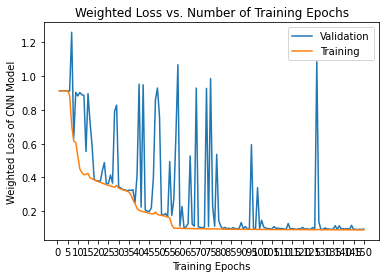




Fold- 1 : Initializing Datasets and Dataloaders...


num_epochs:   0%|                                                                              | 0/150 [00:00<?, ?it/s]



----------
Epoch 0/149
LR 5e-06
train: bce: 0.712320, dice: 0.931356, loss: 0.909452


num_epochs:   1%|▍                                                                   | 1/150 [00:29<1:13:58, 29.79s/it]

val: bce: 0.712243, dice: 0.931104, loss: 0.909218
saving best model
Total time: 0:00:29.789795
Epoch time: 0m 30s


----------
Epoch 1/149
LR 5e-06
train: bce: 0.712188, dice: 0.931357, loss: 0.909440


num_epochs:   1%|▉                                                                   | 2/150 [00:59<1:13:49, 29.93s/it]

val: bce: 0.712110, dice: 0.931105, loss: 0.909205
saving best model
Total time: 0:00:59.818662
Epoch time: 0m 30s


----------
Epoch 2/149
LR 5e-06
train: bce: 0.712052, dice: 0.931357, loss: 0.909427


num_epochs:   2%|█▎                                                                  | 3/150 [01:29<1:13:19, 29.93s/it]

val: bce: 0.711925, dice: 0.931106, loss: 0.909188
saving best model
Total time: 0:01:29.739898
Epoch time: 0m 30s


----------
Epoch 3/149
LR 5e-06
train: bce: 0.711889, dice: 0.931357, loss: 0.909410


num_epochs:   3%|█▊                                                                  | 4/150 [02:00<1:13:13, 30.09s/it]

val: bce: 0.711382, dice: 0.931102, loss: 0.909130
saving best model
Total time: 0:02:00.086205
Epoch time: 0m 30s


----------
Epoch 4/149
LR 5e-06
train: bce: 0.711025, dice: 0.931332, loss: 0.909301


num_epochs:   3%|██▎                                                                 | 5/150 [02:29<1:12:06, 29.84s/it]

val: bce: 0.696902, dice: 0.931460, loss: 0.908004
saving best model
Total time: 0:02:29.470768
Epoch time: 0m 29s


----------
Epoch 5/149
LR 5e-06
train: bce: 0.585337, dice: 0.916739, loss: 0.883598


num_epochs:   4%|██▋                                                                 | 6/150 [02:58<1:11:11, 29.67s/it]

val: bce: 0.694504, dice: 0.931209, loss: 0.907538
saving best model
Total time: 0:02:58.805235
Epoch time: 0m 29s


----------
Epoch 6/149
LR 5e-06
train: bce: 0.379521, dice: 0.805031, loss: 0.762480


num_epochs:   5%|███▏                                                                | 7/150 [03:28<1:10:46, 29.69s/it]

val: bce: 0.263920, dice: 0.769172, loss: 0.718647
saving best model
Total time: 0:03:28.556342
Epoch time: 0m 30s


----------
Epoch 7/149
LR 5e-06
train: bce: 0.213813, dice: 0.690192, loss: 0.642554


num_epochs:   5%|███▋                                                                | 8/150 [03:58<1:10:10, 29.65s/it]

val: bce: 0.303332, dice: 0.746154, loss: 0.701871
saving best model
Total time: 0:03:58.121945
Epoch time: 0m 30s


----------
Epoch 8/149
LR 5e-06
train: bce: 0.136669, dice: 0.601409, loss: 0.554935


num_epochs:   6%|████                                                                | 9/150 [04:27<1:09:38, 29.63s/it]

val: bce: 0.108049, dice: 0.565811, loss: 0.520035
saving best model
Total time: 0:04:27.705404
Epoch time: 0m 30s


----------
Epoch 9/149
LR 5e-06
train: bce: 0.109666, dice: 0.545935, loss: 0.502308


num_epochs:   7%|████▍                                                              | 10/150 [04:57<1:08:55, 29.54s/it]

val: bce: 0.733000, dice: 0.930950, loss: 0.911155
Total time: 0:04:57.047311
Epoch time: 0m 29s


----------
Epoch 10/149
LR 0.0005
train: bce: 0.110225, dice: 0.537937, loss: 0.495166


num_epochs:   7%|████▉                                                              | 11/150 [05:26<1:08:09, 29.42s/it]

val: bce: 0.718672, dice: 0.928758, loss: 0.907749
Total time: 0:05:26.199249
Epoch time: 0m 29s


----------
Epoch 11/149
LR 0.0005
train: bce: 0.116845, dice: 0.533603, loss: 0.491927


num_epochs:   8%|█████▎                                                             | 12/150 [05:55<1:07:42, 29.44s/it]

val: bce: 0.200711, dice: 0.595360, loss: 0.555895
Total time: 0:05:55.670612
Epoch time: 0m 29s


----------
Epoch 12/149
LR 0.0005
train: bce: 0.190771, dice: 0.597858, loss: 0.557149


num_epochs:   9%|█████▊                                                             | 13/150 [06:25<1:07:14, 29.45s/it]

val: bce: 0.146041, dice: 0.557986, loss: 0.516791
saving best model
Total time: 0:06:25.153879
Epoch time: 0m 29s


----------
Epoch 13/149
LR 0.0005
train: bce: 0.162839, dice: 0.560412, loss: 0.520655


num_epochs:   9%|██████▎                                                            | 14/150 [06:54<1:06:36, 29.38s/it]

val: bce: 0.162069, dice: 0.560954, loss: 0.521066
Total time: 0:06:54.384681
Epoch time: 0m 29s


----------
Epoch 14/149
LR 0.0005
train: bce: 0.097808, dice: 0.509059, loss: 0.467934


num_epochs:  10%|██████▋                                                            | 15/150 [07:24<1:06:21, 29.49s/it]

val: bce: 0.094391, dice: 0.492004, loss: 0.452243
saving best model
Total time: 0:07:24.119917
Epoch time: 0m 30s


----------
Epoch 15/149
LR 0.0005
train: bce: 0.077645, dice: 0.486499, loss: 0.445614


num_epochs:  11%|███████▏                                                           | 16/150 [07:53<1:05:47, 29.46s/it]

val: bce: 0.064060, dice: 0.501120, loss: 0.457414
Total time: 0:07:53.518367
Epoch time: 0m 29s


----------
Epoch 16/149
LR 0.0005
train: bce: 0.123084, dice: 0.513223, loss: 0.474209


num_epochs:  11%|███████▌                                                           | 17/150 [08:22<1:05:11, 29.41s/it]

val: bce: 0.219776, dice: 0.752875, loss: 0.699565
Total time: 0:08:22.804722
Epoch time: 0m 29s


----------
Epoch 17/149
LR 0.0005
train: bce: 0.055405, dice: 0.465559, loss: 0.424544


num_epochs:  12%|████████                                                           | 18/150 [08:52<1:04:51, 29.48s/it]

val: bce: 0.052760, dice: 0.466229, loss: 0.424882
saving best model
Total time: 0:08:52.442245
Epoch time: 0m 30s


----------
Epoch 18/149
LR 0.0005
train: bce: 0.048698, dice: 0.444109, loss: 0.404568


num_epochs:  13%|████████▍                                                          | 19/150 [09:21<1:04:14, 29.43s/it]

val: bce: 0.065442, dice: 0.470421, loss: 0.429924
Total time: 0:09:21.749432
Epoch time: 0m 29s


----------
Epoch 19/149
LR 0.0005
train: bce: 0.046494, dice: 0.440644, loss: 0.401229


num_epochs:  13%|████████▉                                                          | 20/150 [09:51<1:03:41, 29.39s/it]

val: bce: 0.046239, dice: 0.438338, loss: 0.399128
saving best model
Total time: 0:09:51.063564
Epoch time: 0m 29s


----------
Epoch 20/149
LR 0.0005
train: bce: 0.044068, dice: 0.430883, loss: 0.392202


num_epochs:  14%|█████████▍                                                         | 21/150 [10:20<1:03:31, 29.54s/it]

val: bce: 0.042496, dice: 0.431071, loss: 0.392213
saving best model
Total time: 0:10:20.960494
Epoch time: 0m 30s


----------
Epoch 21/149
LR 0.0005
train: bce: 0.041732, dice: 0.423040, loss: 0.384909


num_epochs:  15%|█████████▊                                                         | 22/150 [10:52<1:04:33, 30.26s/it]

val: bce: 0.044603, dice: 0.445796, loss: 0.405677
Total time: 0:10:52.883587
Epoch time: 0m 32s


----------
Epoch 22/149
LR 0.0005
train: bce: 0.040512, dice: 0.417296, loss: 0.379618


num_epochs:  15%|██████████▎                                                        | 23/150 [11:22<1:03:37, 30.06s/it]

val: bce: 0.054672, dice: 0.436022, loss: 0.397887
Total time: 0:11:22.474488
Epoch time: 0m 30s


----------
Epoch 23/149
LR 0.0005
train: bce: 0.042470, dice: 0.418387, loss: 0.380795


num_epochs:  16%|██████████▋                                                        | 24/150 [11:51<1:02:39, 29.83s/it]

val: bce: 0.043364, dice: 0.413268, loss: 0.376278
saving best model
Total time: 0:11:51.788618
Epoch time: 0m 29s


----------
Epoch 24/149
LR 0.0005
train: bce: 0.040028, dice: 0.410277, loss: 0.373252


num_epochs:  17%|███████████▏                                                       | 25/150 [12:21<1:01:46, 29.65s/it]

val: bce: 0.038999, dice: 0.413516, loss: 0.376064
saving best model
Total time: 0:12:21.017932
Epoch time: 0m 29s


----------
Epoch 25/149
LR 0.0005
train: bce: 0.038278, dice: 0.402112, loss: 0.365729


num_epochs:  17%|███████████▌                                                       | 26/150 [12:50<1:01:00, 29.52s/it]

val: bce: 0.077789, dice: 0.448435, loss: 0.411370
Total time: 0:12:50.223935
Epoch time: 0m 29s


----------
Epoch 26/149
LR 0.0005
train: bce: 0.043339, dice: 0.411796, loss: 0.374950


num_epochs:  18%|████████████                                                       | 27/150 [13:20<1:01:06, 29.81s/it]

val: bce: 0.326840, dice: 0.786148, loss: 0.740217
Total time: 0:13:20.697714
Epoch time: 0m 30s


----------
Epoch 27/149
LR 0.0005
train: bce: 0.039648, dice: 0.399757, loss: 0.363746


num_epochs:  19%|████████████▌                                                      | 28/150 [13:50<1:00:34, 29.79s/it]

val: bce: 0.057688, dice: 0.466016, loss: 0.425183
Total time: 0:13:50.450806
Epoch time: 0m 30s


----------
Epoch 28/149
LR 0.0005
train: bce: 0.037514, dice: 0.391262, loss: 0.355887


num_epochs:  19%|████████████▉                                                      | 29/150 [14:20<1:00:05, 29.79s/it]

val: bce: 0.038193, dice: 0.388165, loss: 0.353167
saving best model
Total time: 0:14:20.255977
Epoch time: 0m 30s


----------
Epoch 29/149
LR 0.0005
train: bce: 0.036337, dice: 0.385583, loss: 0.350658


num_epochs:  20%|█████████████▊                                                       | 30/150 [14:49<59:30, 29.76s/it]

val: bce: 0.039533, dice: 0.385720, loss: 0.351101
saving best model
Total time: 0:14:49.921772
Epoch time: 0m 30s


----------
Epoch 30/149
LR 0.0005
train: bce: 0.036537, dice: 0.382993, loss: 0.348347


num_epochs:  21%|██████████████▎                                                      | 31/150 [15:19<59:00, 29.75s/it]

val: bce: 0.036672, dice: 0.394266, loss: 0.358506
Total time: 0:15:19.665935
Epoch time: 0m 30s


----------
Epoch 31/149
LR 0.0005
train: bce: 0.035331, dice: 0.376634, loss: 0.342504


num_epochs:  21%|██████████████▋                                                      | 32/150 [15:49<58:28, 29.73s/it]

val: bce: 0.035175, dice: 0.373803, loss: 0.339940
saving best model
Total time: 0:15:49.357027
Epoch time: 0m 30s


----------
Epoch 32/149
LR 0.0005
train: bce: 0.034625, dice: 0.371566, loss: 0.337872


num_epochs:  22%|███████████████▏                                                     | 33/150 [16:19<58:09, 29.83s/it]

val: bce: 0.034004, dice: 0.370178, loss: 0.336560
saving best model
Total time: 0:16:19.396806
Epoch time: 0m 30s


----------
Epoch 33/149
LR 0.0005
train: bce: 0.034328, dice: 0.367973, loss: 0.334608


num_epochs:  23%|███████████████▋                                                     | 34/150 [16:49<57:34, 29.78s/it]

val: bce: 0.033176, dice: 0.367231, loss: 0.333826
saving best model
Total time: 0:16:49.067065
Epoch time: 0m 30s


----------
Epoch 34/149
LR 0.0005
train: bce: 0.033939, dice: 0.363978, loss: 0.330974


num_epochs:  23%|████████████████                                                     | 35/150 [17:18<56:53, 29.68s/it]

val: bce: 0.033285, dice: 0.363516, loss: 0.330493
saving best model
Total time: 0:17:18.515612
Epoch time: 0m 29s


----------
Epoch 35/149
LR 0.0005
train: bce: 0.033208, dice: 0.358336, loss: 0.325823


num_epochs:  24%|████████████████▌                                                    | 36/150 [17:48<56:18, 29.63s/it]

val: bce: 0.043556, dice: 0.412825, loss: 0.375898
Total time: 0:17:48.037567
Epoch time: 0m 30s


----------
Epoch 36/149
LR 0.0005
train: bce: 0.032730, dice: 0.352742, loss: 0.320741


num_epochs:  25%|█████████████████                                                    | 37/150 [18:18<56:12, 29.84s/it]

val: bce: 0.035949, dice: 0.377821, loss: 0.343633
Total time: 0:18:18.366018
Epoch time: 0m 30s


----------
Epoch 37/149
LR 0.0005
train: bce: 0.031784, dice: 0.343025, loss: 0.311901


num_epochs:  25%|█████████████████▍                                                   | 38/150 [18:49<56:09, 30.09s/it]

val: bce: 0.031856, dice: 0.339757, loss: 0.308967
saving best model
Total time: 0:18:49.026295
Epoch time: 0m 31s


----------
Epoch 38/149
LR 0.0005
train: bce: 0.031422, dice: 0.320451, loss: 0.291548


num_epochs:  26%|█████████████████▉                                                   | 39/150 [19:19<56:04, 30.32s/it]

val: bce: 0.031112, dice: 0.309549, loss: 0.281706
saving best model
Total time: 0:19:19.873564
Epoch time: 0m 31s


----------
Epoch 39/149
LR 0.0005
train: bce: 0.031846, dice: 0.292505, loss: 0.266439


num_epochs:  27%|██████████████████▍                                                  | 40/150 [19:50<55:36, 30.33s/it]

val: bce: 0.034427, dice: 0.287254, loss: 0.261972
saving best model
Total time: 0:19:50.251119
Epoch time: 0m 30s


----------
Epoch 40/149
LR 0.0005
train: bce: 0.030365, dice: 0.266639, loss: 0.243012


num_epochs:  27%|██████████████████▊                                                  | 41/150 [20:21<55:22, 30.49s/it]

val: bce: 0.046187, dice: 0.272142, loss: 0.249547
saving best model
Total time: 0:20:21.091444
Epoch time: 0m 31s


----------
Epoch 41/149
LR 0.0005
train: bce: 0.031021, dice: 0.235842, loss: 0.215360


num_epochs:  28%|███████████████████▎                                                 | 42/150 [20:50<54:09, 30.09s/it]

val: bce: 0.038688, dice: 0.234094, loss: 0.214553
saving best model
Total time: 0:20:50.259254
Epoch time: 0m 29s


----------
Epoch 42/149
LR 0.0005
train: bce: 0.032474, dice: 0.223649, loss: 0.204532


num_epochs:  29%|███████████████████▊                                                 | 43/150 [21:19<53:07, 29.79s/it]

val: bce: 0.047133, dice: 0.234704, loss: 0.215947
Total time: 0:21:19.344728
Epoch time: 0m 29s


----------
Epoch 43/149
LR 0.0005
train: bce: 0.034517, dice: 0.219704, loss: 0.201185


num_epochs:  29%|████████████████████▏                                                | 44/150 [21:48<52:22, 29.65s/it]

val: bce: 0.050334, dice: 0.259150, loss: 0.238268
Total time: 0:21:48.668284
Epoch time: 0m 29s


----------
Epoch 44/149
LR 0.0005
train: bce: 0.034275, dice: 0.213778, loss: 0.195828


num_epochs:  30%|████████████████████▋                                                | 45/150 [22:18<52:12, 29.84s/it]

val: bce: 0.084448, dice: 0.349856, loss: 0.323316
Total time: 0:22:18.936719
Epoch time: 0m 30s


----------
Epoch 45/149
LR 0.0005
train: bce: 0.035396, dice: 0.212638, loss: 0.194914


num_epochs:  31%|█████████████████████▏                                               | 46/150 [22:48<51:24, 29.66s/it]

val: bce: 0.037278, dice: 0.221199, loss: 0.202807
saving best model
Total time: 0:22:48.182401
Epoch time: 0m 29s


----------
Epoch 46/149
LR 0.0005
train: bce: 0.035329, dice: 0.208535, loss: 0.191215


num_epochs:  31%|█████████████████████▌                                               | 47/150 [23:17<50:58, 29.70s/it]

val: bce: 0.057109, dice: 0.251536, loss: 0.232093
Total time: 0:23:17.974677
Epoch time: 0m 30s


----------
Epoch 47/149
LR 0.0005
train: bce: 0.034518, dice: 0.203808, loss: 0.186879


num_epochs:  32%|██████████████████████                                               | 48/150 [23:47<50:37, 29.78s/it]

val: bce: 0.038798, dice: 0.206338, loss: 0.189584
saving best model
Total time: 0:23:47.929640
Epoch time: 0m 30s


----------
Epoch 48/149
LR 0.0005
train: bce: 0.034340, dice: 0.201334, loss: 0.184635


num_epochs:  33%|██████████████████████▌                                              | 49/150 [24:18<50:21, 29.92s/it]

val: bce: 0.104961, dice: 0.342273, loss: 0.318541
Total time: 0:24:18.178236
Epoch time: 0m 30s


----------
Epoch 49/149
LR 0.0005
train: bce: 0.035099, dice: 0.200372, loss: 0.183845


num_epochs:  33%|███████████████████████                                              | 50/150 [24:47<49:43, 29.83s/it]

val: bce: 0.041762, dice: 0.207934, loss: 0.191317
Total time: 0:24:47.808319
Epoch time: 0m 30s


----------
Epoch 50/149
LR 0.0005
train: bce: 0.035014, dice: 0.198396, loss: 0.182058


num_epochs:  34%|███████████████████████▍                                             | 51/150 [25:17<49:07, 29.78s/it]

val: bce: 0.045077, dice: 0.205740, loss: 0.189674
Total time: 0:25:17.459234
Epoch time: 0m 30s


----------
Epoch 51/149
LR 0.0005
train: bce: 0.034745, dice: 0.195745, loss: 0.179645


num_epochs:  35%|███████████████████████▉                                             | 52/150 [25:47<48:47, 29.87s/it]

val: bce: 0.043316, dice: 0.212868, loss: 0.195913
Total time: 0:25:47.550599
Epoch time: 0m 30s


----------
Epoch 52/149
LR 0.0005
train: bce: 0.033983, dice: 0.193064, loss: 0.177156


num_epochs:  35%|████████████████████████▍                                            | 53/150 [26:17<48:16, 29.86s/it]

val: bce: 0.036180, dice: 0.194483, loss: 0.178653
saving best model
Total time: 0:26:17.399913
Epoch time: 0m 30s


----------
Epoch 53/149
LR 0.0005
train: bce: 0.033447, dice: 0.190576, loss: 0.174863


num_epochs:  36%|████████████████████████▊                                            | 54/150 [26:47<47:47, 29.87s/it]

val: bce: 0.037866, dice: 0.195519, loss: 0.179754
Total time: 0:26:47.276012
Epoch time: 0m 30s


----------
Epoch 54/149
LR 0.0005
train: bce: 0.033383, dice: 0.188758, loss: 0.173221


num_epochs:  37%|█████████████████████████▎                                           | 55/150 [27:18<47:50, 30.22s/it]

val: bce: 0.059143, dice: 0.282819, loss: 0.260452
Total time: 0:27:18.313249
Epoch time: 0m 31s


----------
Epoch 55/149
LR 0.0005
train: bce: 0.031125, dice: 0.180945, loss: 0.165963


num_epochs:  37%|█████████████████████████▊                                           | 56/150 [27:48<47:10, 30.11s/it]

val: bce: 0.030377, dice: 0.169497, loss: 0.155585
saving best model
Total time: 0:27:48.171492
Epoch time: 0m 30s


----------
Epoch 56/149
LR 0.0005
train: bce: 0.029581, dice: 0.134624, loss: 0.124119


num_epochs:  38%|██████████████████████████▏                                          | 57/150 [28:19<47:08, 30.41s/it]

val: bce: 0.036825, dice: 0.117262, loss: 0.109218
saving best model
Total time: 0:28:19.277673
Epoch time: 0m 31s


----------
Epoch 57/149
LR 0.0005
train: bce: 0.032735, dice: 0.108623, loss: 0.101035


num_epochs:  39%|██████████████████████████▋                                          | 58/150 [28:49<46:42, 30.46s/it]

val: bce: 0.080184, dice: 0.182913, loss: 0.172640
Total time: 0:28:49.869502
Epoch time: 0m 31s


----------
Epoch 58/149
LR 0.0005
train: bce: 0.035657, dice: 0.110866, loss: 0.103345


num_epochs:  39%|███████████████████████████▏                                         | 59/150 [29:20<46:17, 30.53s/it]

val: bce: 0.036829, dice: 0.112256, loss: 0.104714
saving best model
Total time: 0:29:20.537217
Epoch time: 0m 31s


----------
Epoch 59/149
LR 0.0005
train: bce: 0.034329, dice: 0.107582, loss: 0.100257


num_epochs:  40%|███████████████████████████▌                                         | 60/150 [29:50<45:28, 30.32s/it]

val: bce: 0.113757, dice: 0.279600, loss: 0.263015
Total time: 0:29:50.362726
Epoch time: 0m 30s


----------
Epoch 60/149
LR 0.0005
train: bce: 0.034627, dice: 0.107522, loss: 0.100232


num_epochs:  41%|████████████████████████████                                         | 61/150 [30:20<44:48, 30.21s/it]

val: bce: 0.139788, dice: 0.286205, loss: 0.271564
Total time: 0:30:20.327608
Epoch time: 0m 30s


----------
Epoch 61/149
LR 0.0005
train: bce: 0.033627, dice: 0.105711, loss: 0.098503


num_epochs:  41%|████████████████████████████▌                                        | 62/150 [30:49<44:03, 30.03s/it]

val: bce: 0.046774, dice: 0.137891, loss: 0.128779
Total time: 0:30:49.951740
Epoch time: 0m 30s


----------
Epoch 62/149
LR 0.0005
train: bce: 0.034605, dice: 0.106736, loss: 0.099523


num_epochs:  42%|████████████████████████████▉                                        | 63/150 [31:20<43:37, 30.09s/it]

val: bce: 1.070941, dice: 0.517896, loss: 0.573201
Total time: 0:31:20.159664
Epoch time: 0m 30s


----------
Epoch 63/149
LR 0.0005
train: bce: 0.034480, dice: 0.106034, loss: 0.098879


num_epochs:  43%|█████████████████████████████▍                                       | 64/150 [31:50<43:11, 30.13s/it]

val: bce: 0.036731, dice: 0.111236, loss: 0.103786
saving best model
Total time: 0:31:50.398835
Epoch time: 0m 30s


----------
Epoch 64/149
LR 0.0005
train: bce: 0.034621, dice: 0.106056, loss: 0.098913


num_epochs:  43%|█████████████████████████████▉                                       | 65/150 [32:20<42:38, 30.10s/it]

val: bce: 0.036590, dice: 0.109156, loss: 0.101900
saving best model
Total time: 0:32:20.406870
Epoch time: 0m 30s


----------
Epoch 65/149
LR 0.0005
train: bce: 0.034008, dice: 0.104587, loss: 0.097529


num_epochs:  44%|██████████████████████████████▎                                      | 66/150 [32:50<42:14, 30.17s/it]

val: bce: 0.055935, dice: 0.126831, loss: 0.119741
Total time: 0:32:50.746234
Epoch time: 0m 30s


----------
Epoch 66/149
LR 0.0005
train: bce: 0.034217, dice: 0.104878, loss: 0.097812


num_epochs:  45%|██████████████████████████████▊                                      | 67/150 [33:21<41:49, 30.23s/it]

val: bce: 0.053675, dice: 0.142292, loss: 0.133431
Total time: 0:33:21.127759
Epoch time: 0m 30s


----------
Epoch 67/149
LR 0.0005
train: bce: 0.034292, dice: 0.104705, loss: 0.097664


num_epochs:  45%|███████████████████████████████▎                                     | 68/150 [33:51<41:18, 30.23s/it]

val: bce: 0.038590, dice: 0.113676, loss: 0.106168
Total time: 0:33:51.341635
Epoch time: 0m 30s


----------
Epoch 68/149
LR 0.0005
train: bce: 0.034800, dice: 0.105269, loss: 0.098222


num_epochs:  46%|███████████████████████████████▋                                     | 69/150 [34:21<40:39, 30.12s/it]

val: bce: 0.049062, dice: 0.117284, loss: 0.110462
Total time: 0:34:21.201861
Epoch time: 0m 30s


----------
Epoch 69/149
LR 0.0005
train: bce: 0.034379, dice: 0.104143, loss: 0.097166


num_epochs:  47%|████████████████████████████████▏                                    | 70/150 [34:50<39:52, 29.91s/it]

val: bce: 0.038990, dice: 0.119154, loss: 0.111137
Total time: 0:34:50.634536
Epoch time: 0m 29s


----------
Epoch 70/149
LR 0.0005
train: bce: 0.034326, dice: 0.104304, loss: 0.097306


num_epochs:  47%|████████████████████████████████▋                                    | 71/150 [35:20<39:24, 29.93s/it]

val: bce: 0.369685, dice: 0.433628, loss: 0.427234
Total time: 0:35:20.604380
Epoch time: 0m 30s


----------
Epoch 71/149
LR 0.0005
train: bce: 0.034530, dice: 0.104528, loss: 0.097528


num_epochs:  48%|█████████████████████████████████                                    | 72/150 [35:50<39:02, 30.03s/it]

val: bce: 0.050098, dice: 0.136915, loss: 0.128234
Total time: 0:35:50.875296
Epoch time: 0m 30s


----------
Epoch 72/149
LR 0.0005
train: bce: 0.033727, dice: 0.103238, loss: 0.096287


num_epochs:  49%|█████████████████████████████████▌                                   | 73/150 [36:20<38:30, 30.00s/it]

val: bce: 1.672599, dice: 0.526664, loss: 0.641258
Total time: 0:36:20.804963
Epoch time: 0m 30s


----------
Epoch 73/149
LR 0.0005
train: bce: 0.034005, dice: 0.103454, loss: 0.096509


num_epochs:  49%|██████████████████████████████████                                   | 74/150 [36:50<37:53, 29.91s/it]

val: bce: 1.578947, dice: 0.535765, loss: 0.640083
Epoch    69: reducing learning rate of group 0 to 2.5000e-04.
Total time: 0:36:50.499526
Epoch time: 0m 30s


----------
Epoch 74/149
LR 0.00025
train: bce: 0.033805, dice: 0.102962, loss: 0.096046


num_epochs:  50%|██████████████████████████████████▌                                  | 75/150 [37:20<37:20, 29.87s/it]

val: bce: 0.034486, dice: 0.104480, loss: 0.097481
saving best model
Total time: 0:37:20.274937
Epoch time: 0m 30s


----------
Epoch 75/149
LR 0.00025
train: bce: 0.033467, dice: 0.102016, loss: 0.095161


num_epochs:  51%|██████████████████████████████████▉                                  | 76/150 [37:50<36:51, 29.88s/it]

val: bce: 0.035677, dice: 0.103530, loss: 0.096744
saving best model
Total time: 0:37:50.197164
Epoch time: 0m 30s


----------
Epoch 76/149
LR 0.00025
train: bce: 0.033668, dice: 0.102359, loss: 0.095490


num_epochs:  51%|███████████████████████████████████▍                                 | 77/150 [38:20<36:20, 29.87s/it]

val: bce: 0.043303, dice: 0.108714, loss: 0.102173
Total time: 0:38:20.029616
Epoch time: 0m 30s


----------
Epoch 77/149
LR 0.00025
train: bce: 0.033632, dice: 0.101831, loss: 0.095011


num_epochs:  52%|███████████████████████████████████▉                                 | 78/150 [38:49<35:34, 29.65s/it]

val: bce: 1.356917, dice: 0.500199, loss: 0.585870
Total time: 0:38:49.171138
Epoch time: 0m 29s


----------
Epoch 78/149
LR 0.00025
train: bce: 0.033614, dice: 0.101893, loss: 0.095066


num_epochs:  53%|████████████████████████████████████▎                                | 79/150 [39:18<35:04, 29.65s/it]

val: bce: 0.034034, dice: 0.104092, loss: 0.097086
Total time: 0:39:18.805189
Epoch time: 0m 30s


----------
Epoch 79/149
LR 0.00025
train: bce: 0.033574, dice: 0.101828, loss: 0.095003


num_epochs:  53%|████████████████████████████████████▊                                | 80/150 [39:49<34:48, 29.83s/it]

val: bce: 0.033870, dice: 0.104227, loss: 0.097191
Total time: 0:39:49.080569
Epoch time: 0m 30s


----------
Epoch 80/149
LR 0.00025
train: bce: 0.033765, dice: 0.102483, loss: 0.095611


num_epochs:  54%|█████████████████████████████████████▎                               | 81/150 [40:18<34:12, 29.75s/it]

val: bce: 0.045406, dice: 0.111704, loss: 0.105074
Total time: 0:40:18.636748
Epoch time: 0m 30s


----------
Epoch 81/149
LR 0.00025
train: bce: 0.033514, dice: 0.101676, loss: 0.094859


num_epochs:  55%|█████████████████████████████████████▋                               | 82/150 [40:48<33:40, 29.71s/it]

val: bce: 0.033236, dice: 0.102349, loss: 0.095438
saving best model
Total time: 0:40:48.251455
Epoch time: 0m 30s


----------
Epoch 82/149
LR 0.00025
train: bce: 0.033651, dice: 0.101509, loss: 0.094723


num_epochs:  55%|██████████████████████████████████████▏                              | 83/150 [41:17<33:00, 29.55s/it]

val: bce: 0.035754, dice: 0.106413, loss: 0.099347
Total time: 0:41:17.443569
Epoch time: 0m 29s


----------
Epoch 83/149
LR 0.00025
train: bce: 0.033449, dice: 0.101509, loss: 0.094703


num_epochs:  56%|██████████████████████████████████████▋                              | 84/150 [41:46<32:22, 29.42s/it]

val: bce: 0.125065, dice: 0.199668, loss: 0.192208
Total time: 0:41:46.564756
Epoch time: 0m 29s


----------
Epoch 84/149
LR 0.00025
train: bce: 0.033665, dice: 0.101413, loss: 0.094639


num_epochs:  57%|███████████████████████████████████████                              | 85/150 [42:15<31:50, 29.39s/it]

val: bce: 0.051739, dice: 0.117845, loss: 0.111234
Total time: 0:42:15.879878
Epoch time: 0m 29s


----------
Epoch 85/149
LR 0.00025
train: bce: 0.033728, dice: 0.101703, loss: 0.094906


num_epochs:  57%|███████████████████████████████████████▌                             | 86/150 [42:45<31:18, 29.35s/it]

val: bce: 0.045093, dice: 0.111185, loss: 0.104576
Total time: 0:42:45.143913
Epoch time: 0m 29s


----------
Epoch 86/149
LR 0.00025
train: bce: 0.033376, dice: 0.101132, loss: 0.094356


num_epochs:  58%|████████████████████████████████████████                             | 87/150 [43:14<30:49, 29.36s/it]

val: bce: 0.034892, dice: 0.102734, loss: 0.095950
Total time: 0:43:14.522028
Epoch time: 0m 29s


----------
Epoch 87/149
LR 0.00025
train: bce: 0.033384, dice: 0.101007, loss: 0.094245


num_epochs:  59%|████████████████████████████████████████▍                            | 88/150 [43:44<30:27, 29.48s/it]

val: bce: 0.045624, dice: 0.110375, loss: 0.103900
Total time: 0:43:44.289999
Epoch time: 0m 30s


----------
Epoch 88/149
LR 0.00025
train: bce: 0.033681, dice: 0.101516, loss: 0.094733


num_epochs:  59%|████████████████████████████████████████▉                            | 89/150 [44:14<30:03, 29.56s/it]

val: bce: 0.038051, dice: 0.104112, loss: 0.097506
Total time: 0:44:14.026723
Epoch time: 0m 30s


----------
Epoch 89/149
LR 0.00025
train: bce: 0.033210, dice: 0.100599, loss: 0.093860


num_epochs:  60%|█████████████████████████████████████████▍                           | 90/150 [44:43<29:36, 29.61s/it]

val: bce: 0.033543, dice: 0.103650, loss: 0.096639
Total time: 0:44:43.747077
Epoch time: 0m 30s


----------
Epoch 90/149
LR 0.00025
train: bce: 0.033501, dice: 0.100891, loss: 0.094152


num_epochs:  61%|█████████████████████████████████████████▊                           | 91/150 [45:13<29:07, 29.62s/it]

val: bce: 0.039345, dice: 0.105352, loss: 0.098751
Epoch    86: reducing learning rate of group 0 to 1.2500e-04.
Total time: 0:45:13.383608
Epoch time: 0m 30s


----------
Epoch 91/149
LR 0.000125
train: bce: 0.033151, dice: 0.100365, loss: 0.093644


num_epochs:  61%|██████████████████████████████████████████▎                          | 92/150 [45:43<28:38, 29.63s/it]

val: bce: 0.039442, dice: 0.105340, loss: 0.098750
Total time: 0:45:43.060317
Epoch time: 0m 30s


----------
Epoch 92/149
LR 0.000125
train: bce: 0.033016, dice: 0.099965, loss: 0.093270


num_epochs:  62%|██████████████████████████████████████████▊                          | 93/150 [46:12<28:06, 29.60s/it]

val: bce: 0.034680, dice: 0.104054, loss: 0.097116
Total time: 0:46:12.566894
Epoch time: 0m 30s


----------
Epoch 93/149
LR 0.000125
train: bce: 0.033009, dice: 0.099913, loss: 0.093222


num_epochs:  63%|███████████████████████████████████████████▏                         | 94/150 [46:42<27:39, 29.63s/it]

val: bce: 0.035235, dice: 0.101783, loss: 0.095128
saving best model
Total time: 0:46:42.291713
Epoch time: 0m 30s


----------
Epoch 94/149
LR 0.000125
train: bce: 0.033000, dice: 0.100114, loss: 0.093403


num_epochs:  63%|███████████████████████████████████████████▋                         | 95/150 [47:11<27:07, 29.60s/it]

val: bce: 0.037691, dice: 0.103616, loss: 0.097024
Total time: 0:47:11.797300
Epoch time: 0m 30s


----------
Epoch 95/149
LR 0.000125
train: bce: 0.033075, dice: 0.099910, loss: 0.093226


num_epochs:  64%|████████████████████████████████████████████▏                        | 96/150 [47:41<26:47, 29.76s/it]

val: bce: 0.035292, dice: 0.101154, loss: 0.094568
saving best model
Total time: 0:47:41.943720
Epoch time: 0m 30s


----------
Epoch 96/149
LR 0.000125
train: bce: 0.033220, dice: 0.100113, loss: 0.093424


num_epochs:  65%|████████████████████████████████████████████▌                        | 97/150 [48:11<26:16, 29.75s/it]

val: bce: 0.033301, dice: 0.099938, loss: 0.093274
saving best model
Total time: 0:48:11.666556
Epoch time: 0m 30s


----------
Epoch 97/149
LR 0.000125
train: bce: 0.033014, dice: 0.099703, loss: 0.093034


num_epochs:  65%|█████████████████████████████████████████████                        | 98/150 [48:40<25:33, 29.49s/it]

val: bce: 0.034623, dice: 0.104550, loss: 0.097558
Total time: 0:48:40.549661
Epoch time: 0m 29s


----------
Epoch 98/149
LR 0.000125
train: bce: 0.033030, dice: 0.099892, loss: 0.093206


num_epochs:  66%|█████████████████████████████████████████████▌                       | 99/150 [49:09<24:52, 29.26s/it]

val: bce: 0.043507, dice: 0.110121, loss: 0.103459
Total time: 0:49:09.260159
Epoch time: 0m 29s


----------
Epoch 99/149
LR 0.000125
train: bce: 0.033151, dice: 0.099923, loss: 0.093246


num_epochs:  67%|█████████████████████████████████████████████▎                      | 100/150 [49:38<24:15, 29.11s/it]

val: bce: 0.033156, dice: 0.099658, loss: 0.093008
saving best model
Total time: 0:49:38.040097
Epoch time: 0m 29s


----------
Epoch 100/149
LR 0.000125
train: bce: 0.032941, dice: 0.099683, loss: 0.093009


num_epochs:  67%|█████████████████████████████████████████████▊                      | 101/150 [50:06<23:40, 28.99s/it]

val: bce: 0.036824, dice: 0.102018, loss: 0.095499
Total time: 0:50:06.750595
Epoch time: 0m 29s


----------
Epoch 101/149
LR 0.000125
train: bce: 0.033074, dice: 0.099763, loss: 0.093094


num_epochs:  68%|██████████████████████████████████████████████▏                     | 102/150 [50:35<23:09, 28.94s/it]

val: bce: 0.034604, dice: 0.101161, loss: 0.094506
Total time: 0:50:35.585093
Epoch time: 0m 29s


----------
Epoch 102/149
LR 0.000125
train: bce: 0.033258, dice: 0.100130, loss: 0.093443


num_epochs:  69%|██████████████████████████████████████████████▋                     | 103/150 [51:04<22:36, 28.87s/it]

val: bce: 0.033401, dice: 0.102553, loss: 0.095638
Total time: 0:51:04.267319
Epoch time: 0m 29s


----------
Epoch 103/149
LR 0.000125
train: bce: 0.032851, dice: 0.099361, loss: 0.092710


num_epochs:  69%|███████████████████████████████████████████████▏                    | 104/150 [51:32<22:05, 28.82s/it]

val: bce: 0.033113, dice: 0.100977, loss: 0.094190
Total time: 0:51:32.973353
Epoch time: 0m 29s


----------
Epoch 104/149
LR 0.000125
train: bce: 0.032991, dice: 0.099547, loss: 0.092892


num_epochs:  70%|███████████████████████████████████████████████▌                    | 105/150 [52:01<21:35, 28.78s/it]

val: bce: 0.032416, dice: 0.099650, loss: 0.092927
saving best model
Total time: 0:52:01.665003
Epoch time: 0m 29s


----------
Epoch 105/149
LR 0.000125
train: bce: 0.032930, dice: 0.099614, loss: 0.092945


num_epochs:  71%|████████████████████████████████████████████████                    | 106/150 [52:30<21:05, 28.77s/it]

val: bce: 0.034344, dice: 0.100310, loss: 0.093713
Total time: 0:52:30.395341
Epoch time: 0m 29s


----------
Epoch 106/149
LR 0.000125
train: bce: 0.032810, dice: 0.099313, loss: 0.092663


num_epochs:  71%|████████████████████████████████████████████████▌                   | 107/150 [52:59<20:37, 28.79s/it]

val: bce: 0.039444, dice: 0.104748, loss: 0.098218
Total time: 0:52:59.240255
Epoch time: 0m 29s


----------
Epoch 107/149
LR 0.000125
train: bce: 0.032977, dice: 0.099592, loss: 0.092930


num_epochs:  72%|████████████████████████████████████████████████▉                   | 108/150 [53:27<20:08, 28.78s/it]

val: bce: 0.048610, dice: 0.113385, loss: 0.106907
Total time: 0:53:27.992913
Epoch time: 0m 29s


----------
Epoch 108/149
LR 0.000125
train: bce: 0.032804, dice: 0.099275, loss: 0.092627


num_epochs:  73%|█████████████████████████████████████████████████▍                  | 109/150 [53:56<19:39, 28.78s/it]

val: bce: 0.033969, dice: 0.100019, loss: 0.093414
Total time: 0:53:56.764915
Epoch time: 0m 29s


----------
Epoch 109/149
LR 0.000125
train: bce: 0.032943, dice: 0.099264, loss: 0.092632


num_epochs:  73%|█████████████████████████████████████████████████▊                  | 110/150 [54:25<19:11, 28.78s/it]

val: bce: 0.034746, dice: 0.100204, loss: 0.093658
Total time: 0:54:25.547335
Epoch time: 0m 29s


----------
Epoch 110/149
LR 0.000125
train: bce: 0.032871, dice: 0.099324, loss: 0.092679


num_epochs:  74%|██████████████████████████████████████████████████▎                 | 111/150 [54:54<18:43, 28.80s/it]

val: bce: 0.043546, dice: 0.108351, loss: 0.101871
Total time: 0:54:54.395223
Epoch time: 0m 29s


----------
Epoch 111/149
LR 0.000125
train: bce: 0.033312, dice: 0.099677, loss: 0.093041


num_epochs:  75%|██████████████████████████████████████████████████▊                 | 112/150 [55:23<18:13, 28.77s/it]

val: bce: 0.034406, dice: 0.103684, loss: 0.096756
Total time: 0:55:23.105721
Epoch time: 0m 29s


----------
Epoch 112/149
LR 0.000125
train: bce: 0.033031, dice: 0.099495, loss: 0.092849


num_epochs:  75%|███████████████████████████████████████████████████▏                | 113/150 [55:51<17:44, 28.77s/it]

val: bce: 0.316133, dice: 0.332885, loss: 0.331210
Total time: 0:55:51.862348
Epoch time: 0m 29s


----------
Epoch 113/149
LR 0.000125
train: bce: 0.033425, dice: 0.099905, loss: 0.093257


num_epochs:  76%|███████████████████████████████████████████████████▋                | 114/150 [56:20<17:15, 28.75s/it]

val: bce: 0.033514, dice: 0.100682, loss: 0.093966
Epoch   109: reducing learning rate of group 0 to 6.2500e-05.
Total time: 0:56:20.574829
Epoch time: 0m 29s


----------
Epoch 114/149
LR 6.25e-05
train: bce: 0.032767, dice: 0.098938, loss: 0.092321


num_epochs:  77%|████████████████████████████████████████████████████▏               | 115/150 [56:49<16:46, 28.76s/it]

val: bce: 0.032655, dice: 0.099849, loss: 0.093130
Total time: 0:56:49.364194
Epoch time: 0m 29s


----------
Epoch 115/149
LR 6.25e-05
train: bce: 0.032667, dice: 0.098715, loss: 0.092110


num_epochs:  77%|████████████████████████████████████████████████████▌               | 116/150 [57:18<16:17, 28.75s/it]

val: bce: 0.032799, dice: 0.099185, loss: 0.092546
saving best model
Total time: 0:57:18.095025
Epoch time: 0m 29s


----------
Epoch 116/149
LR 6.25e-05
train: bce: 0.032665, dice: 0.098644, loss: 0.092046


num_epochs:  78%|█████████████████████████████████████████████████████               | 117/150 [57:46<15:49, 28.76s/it]

val: bce: 0.036372, dice: 0.108953, loss: 0.101695
Total time: 0:57:46.865044
Epoch time: 0m 29s


----------
Epoch 117/149
LR 6.25e-05
train: bce: 0.032679, dice: 0.098652, loss: 0.092055


num_epochs:  79%|█████████████████████████████████████████████████████▍              | 118/150 [58:15<15:19, 28.75s/it]

val: bce: 0.032816, dice: 0.098606, loss: 0.092027
saving best model
Total time: 0:58:15.580502
Epoch time: 0m 29s


----------
Epoch 118/149
LR 6.25e-05
train: bce: 0.032552, dice: 0.098562, loss: 0.091961


num_epochs:  79%|█████████████████████████████████████████████████████▉              | 119/150 [58:44<14:51, 28.76s/it]

val: bce: 0.035018, dice: 0.099781, loss: 0.093304
Total time: 0:58:44.389207
Epoch time: 0m 29s


----------
Epoch 119/149
LR 6.25e-05
train: bce: 0.032488, dice: 0.098466, loss: 0.091869


num_epochs:  80%|██████████████████████████████████████████████████████▍             | 120/150 [59:13<14:22, 28.76s/it]

val: bce: 0.042098, dice: 0.107369, loss: 0.100842
Total time: 0:59:13.123513
Epoch time: 0m 29s


----------
Epoch 120/149
LR 6.25e-05
train: bce: 0.032736, dice: 0.098873, loss: 0.092260


num_epochs:  81%|██████████████████████████████████████████████████████▊             | 121/150 [59:41<13:53, 28.74s/it]

val: bce: 0.033033, dice: 0.099392, loss: 0.092756
Total time: 0:59:41.830043
Epoch time: 0m 29s


----------
Epoch 121/149
LR 6.25e-05
train: bce: 0.032516, dice: 0.098504, loss: 0.091905


num_epochs:  81%|█████████████████████████████████████████████████████▋            | 122/150 [1:00:10<13:24, 28.74s/it]

val: bce: 0.035486, dice: 0.108001, loss: 0.100750
Total time: 1:00:10.576751
Epoch time: 0m 29s


----------
Epoch 122/149
LR 6.25e-05
train: bce: 0.032564, dice: 0.098456, loss: 0.091867


num_epochs:  82%|██████████████████████████████████████████████████████            | 123/150 [1:00:39<12:56, 28.74s/it]

val: bce: 0.032574, dice: 0.098683, loss: 0.092072
Total time: 1:00:39.315023
Epoch time: 0m 29s


----------
Epoch 123/149
LR 6.25e-05
train: bce: 0.032538, dice: 0.098382, loss: 0.091798


num_epochs:  83%|██████████████████████████████████████████████████████▌           | 124/150 [1:01:08<12:27, 28.74s/it]

val: bce: 0.034393, dice: 0.099358, loss: 0.092861
Total time: 1:01:08.052801
Epoch time: 0m 29s


----------
Epoch 124/149
LR 6.25e-05
train: bce: 0.032591, dice: 0.098507, loss: 0.091915


num_epochs:  83%|███████████████████████████████████████████████████████           | 125/150 [1:01:36<11:58, 28.73s/it]

val: bce: 0.033470, dice: 0.098512, loss: 0.092008
saving best model
Total time: 1:01:36.766772
Epoch time: 0m 29s


----------
Epoch 125/149
LR 6.25e-05
train: bce: 0.032593, dice: 0.098417, loss: 0.091835


num_epochs:  84%|███████████████████████████████████████████████████████▍          | 126/150 [1:02:05<11:29, 28.74s/it]

val: bce: 0.032660, dice: 0.098209, loss: 0.091654
saving best model
Total time: 1:02:05.516454
Epoch time: 0m 29s


----------
Epoch 126/149
LR 6.25e-05
train: bce: 0.032563, dice: 0.098319, loss: 0.091743


num_epochs:  85%|███████████████████████████████████████████████████████▉          | 127/150 [1:02:34<11:00, 28.73s/it]

val: bce: 0.036230, dice: 0.100904, loss: 0.094437
Total time: 1:02:34.233895
Epoch time: 0m 29s


----------
Epoch 127/149
LR 6.25e-05
train: bce: 0.032761, dice: 0.098731, loss: 0.092134


num_epochs:  85%|████████████████████████████████████████████████████████▎         | 128/150 [1:03:02<10:32, 28.74s/it]

val: bce: 0.035991, dice: 0.100013, loss: 0.093611
Total time: 1:03:03.003418
Epoch time: 0m 29s


----------
Epoch 128/149
LR 6.25e-05
train: bce: 0.032516, dice: 0.098276, loss: 0.091700


num_epochs:  86%|████████████████████████████████████████████████████████▊         | 129/150 [1:03:31<10:03, 28.75s/it]

val: bce: 0.032687, dice: 0.098987, loss: 0.092357
Total time: 1:03:31.767483
Epoch time: 0m 29s


----------
Epoch 129/149
LR 6.25e-05
train: bce: 0.032477, dice: 0.098282, loss: 0.091701


num_epochs:  87%|█████████████████████████████████████████████████████████▏        | 130/150 [1:04:00<09:35, 28.77s/it]

val: bce: 0.032718, dice: 0.098721, loss: 0.092120
Total time: 1:04:00.579166
Epoch time: 0m 29s


----------
Epoch 130/149
LR 6.25e-05
train: bce: 0.032439, dice: 0.098264, loss: 0.091682


num_epochs:  87%|█████████████████████████████████████████████████████████▋        | 131/150 [1:04:29<09:06, 28.75s/it]

val: bce: 0.032588, dice: 0.098214, loss: 0.091651
saving best model
Total time: 1:04:29.296608
Epoch time: 0m 29s


----------
Epoch 131/149
LR 6.25e-05
train: bce: 0.032530, dice: 0.098242, loss: 0.091671


num_epochs:  88%|██████████████████████████████████████████████████████████        | 132/150 [1:04:58<08:37, 28.75s/it]

val: bce: 0.033966, dice: 0.098985, loss: 0.092483
Total time: 1:04:58.030913
Epoch time: 0m 29s


----------
Epoch 132/149
LR 6.25e-05
train: bce: 0.032611, dice: 0.098306, loss: 0.091736


num_epochs:  89%|██████████████████████████████████████████████████████████▌       | 133/150 [1:05:26<08:08, 28.74s/it]

val: bce: 0.032839, dice: 0.098578, loss: 0.092004
Total time: 1:05:26.761252
Epoch time: 0m 29s


----------
Epoch 133/149
LR 6.25e-05
train: bce: 0.032540, dice: 0.098167, loss: 0.091604


num_epochs:  89%|██████████████████████████████████████████████████████████▉       | 134/150 [1:05:55<07:40, 28.75s/it]

val: bce: 0.034957, dice: 0.099275, loss: 0.092843
Total time: 1:05:55.541686
Epoch time: 0m 29s


----------
Epoch 134/149
LR 6.25e-05
train: bce: 0.032526, dice: 0.098078, loss: 0.091523


num_epochs:  90%|███████████████████████████████████████████████████████████▍      | 135/150 [1:06:24<07:11, 28.76s/it]

val: bce: 0.033616, dice: 0.098636, loss: 0.092134
Epoch   130: reducing learning rate of group 0 to 3.1250e-05.
Total time: 1:06:24.314681
Epoch time: 0m 29s


----------
Epoch 135/149
LR 3.125e-05
train: bce: 0.032592, dice: 0.098195, loss: 0.091635


num_epochs:  91%|███████████████████████████████████████████████████████████▊      | 136/150 [1:06:53<06:42, 28.75s/it]

val: bce: 0.032815, dice: 0.099317, loss: 0.092667
Total time: 1:06:53.036585
Epoch time: 0m 29s


----------
Epoch 136/149
LR 3.125e-05
train: bce: 0.032525, dice: 0.097988, loss: 0.091441


num_epochs:  91%|████████████████████████████████████████████████████████████▎     | 137/150 [1:07:21<06:13, 28.75s/it]

val: bce: 0.033067, dice: 0.097873, loss: 0.091392
saving best model
Total time: 1:07:21.796684
Epoch time: 0m 29s


----------
Epoch 137/149
LR 3.125e-05
train: bce: 0.032423, dice: 0.097863, loss: 0.091319


num_epochs:  92%|████████████████████████████████████████████████████████████▋     | 138/150 [1:07:50<05:45, 28.75s/it]

val: bce: 0.034539, dice: 0.098940, loss: 0.092500
Total time: 1:07:50.548847
Epoch time: 0m 29s


----------
Epoch 138/149
LR 3.125e-05
train: bce: 0.032420, dice: 0.097897, loss: 0.091349


num_epochs:  93%|█████████████████████████████████████████████████████████████▏    | 139/150 [1:08:19<05:16, 28.75s/it]

val: bce: 0.032483, dice: 0.098865, loss: 0.092227
Total time: 1:08:19.294063
Epoch time: 0m 29s


----------
Epoch 139/149
LR 3.125e-05
train: bce: 0.032214, dice: 0.097821, loss: 0.091261


num_epochs:  93%|█████████████████████████████████████████████████████████████▌    | 140/150 [1:08:48<04:47, 28.75s/it]

val: bce: 0.032398, dice: 0.098140, loss: 0.091566
Total time: 1:08:48.053169
Epoch time: 0m 29s


----------
Epoch 140/149
LR 3.125e-05
train: bce: 0.032365, dice: 0.097850, loss: 0.091302


num_epochs:  94%|██████████████████████████████████████████████████████████████    | 141/150 [1:09:16<04:18, 28.76s/it]

val: bce: 0.036696, dice: 0.101079, loss: 0.094641
Total time: 1:09:16.839059
Epoch time: 0m 29s


----------
Epoch 141/149
LR 3.125e-05
train: bce: 0.032474, dice: 0.098010, loss: 0.091457


num_epochs:  95%|██████████████████████████████████████████████████████████████▍   | 142/150 [1:09:45<03:50, 28.78s/it]

val: bce: 0.036899, dice: 0.111796, loss: 0.104306
Total time: 1:09:45.664630
Epoch time: 0m 29s


----------
Epoch 142/149
LR 3.125e-05
train: bce: 0.032380, dice: 0.097930, loss: 0.091375


num_epochs:  95%|██████████████████████████████████████████████████████████████▉   | 143/150 [1:10:14<03:21, 28.79s/it]

val: bce: 0.032843, dice: 0.098358, loss: 0.091807
Total time: 1:10:14.461432
Epoch time: 0m 29s


----------
Epoch 143/149
LR 3.125e-05
train: bce: 0.032402, dice: 0.097945, loss: 0.091390


num_epochs:  96%|███████████████████████████████████████████████████████████████▎  | 144/150 [1:10:43<02:52, 28.77s/it]

val: bce: 0.032756, dice: 0.097954, loss: 0.091435
Total time: 1:10:43.210122
Epoch time: 0m 29s


----------
Epoch 144/149
LR 3.125e-05
train: bce: 0.032310, dice: 0.097738, loss: 0.091195


num_epochs:  97%|███████████████████████████████████████████████████████████████▊  | 145/150 [1:11:11<02:23, 28.76s/it]

val: bce: 0.032879, dice: 0.098628, loss: 0.092053
Total time: 1:11:11.940460
Epoch time: 0m 29s


----------
Epoch 145/149
LR 3.125e-05
train: bce: 0.032413, dice: 0.097853, loss: 0.091309


num_epochs:  97%|████████████████████████████████████████████████████████████████▏ | 146/150 [1:11:40<01:55, 28.76s/it]

val: bce: 0.032582, dice: 0.098804, loss: 0.092181
Epoch   141: reducing learning rate of group 0 to 1.5625e-05.
Total time: 1:11:40.691134
Epoch time: 0m 29s


----------
Epoch 146/149
LR 1.5625e-05
train: bce: 0.032343, dice: 0.097736, loss: 0.091197


num_epochs:  98%|████████████████████████████████████████████████████████████████▋ | 147/150 [1:12:09<01:26, 28.75s/it]

val: bce: 0.033070, dice: 0.097871, loss: 0.091391
saving best model
Total time: 1:12:09.432384
Epoch time: 0m 29s


----------
Epoch 147/149
LR 1.5625e-05
train: bce: 0.032315, dice: 0.097608, loss: 0.091079


num_epochs:  99%|█████████████████████████████████████████████████████████████████ | 148/150 [1:12:38<00:57, 28.77s/it]

val: bce: 0.033373, dice: 0.097935, loss: 0.091478
Total time: 1:12:38.247538
Epoch time: 0m 29s


----------
Epoch 148/149
LR 1.5625e-05
train: bce: 0.032292, dice: 0.097592, loss: 0.091062


num_epochs:  99%|█████████████████████████████████████████████████████████████████▌| 149/150 [1:13:06<00:28, 28.76s/it]

val: bce: 0.033254, dice: 0.097785, loss: 0.091332
saving best model
Total time: 1:13:06.970932
Epoch time: 0m 29s


----------
Epoch 149/149
LR 1.5625e-05
train: bce: 0.032277, dice: 0.097527, loss: 0.091002


num_epochs: 100%|██████████████████████████████████████████████████████████████████| 150/150 [1:13:35<00:00, 29.44s/it]

val: bce: 0.032469, dice: 0.097691, loss: 0.091169
saving best model
Total time: 1:13:35.752358
Epoch time: 0m 29s
Best val loss: 0.091169
model training finished, reinitializing training....



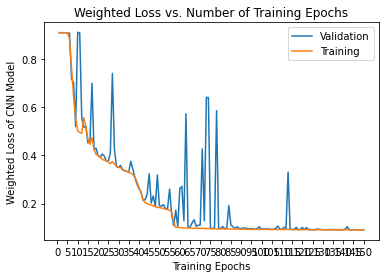




Fold- 2 : Initializing Datasets and Dataloaders...


num_epochs:   0%|                                                                              | 0/150 [00:00<?, ?it/s]



----------
Epoch 0/149
LR 5e-06
train: bce: 0.709101, dice: 0.931541, loss: 0.909297


num_epochs:   1%|▍                                                                   | 1/150 [00:28<1:11:31, 28.80s/it]

val: bce: 0.709040, dice: 0.931685, loss: 0.909421
saving best model
Total time: 0:00:28.803746
Epoch time: 0m 29s


----------
Epoch 1/149
LR 5e-06
train: bce: 0.708983, dice: 0.931542, loss: 0.909286


num_epochs:   1%|▉                                                                   | 2/150 [00:57<1:11:02, 28.80s/it]

val: bce: 0.708921, dice: 0.931686, loss: 0.909409
saving best model
Total time: 0:00:57.605012
Epoch time: 0m 29s


----------
Epoch 2/149
LR 5e-06
train: bce: 0.708862, dice: 0.931542, loss: 0.909274


num_epochs:   2%|█▎                                                                  | 3/150 [01:26<1:10:34, 28.80s/it]

val: bce: 0.708770, dice: 0.931687, loss: 0.909395
saving best model
Total time: 0:01:26.414711
Epoch time: 0m 29s


----------
Epoch 3/149
LR 5e-06
train: bce: 0.708728, dice: 0.931543, loss: 0.909261


num_epochs:   3%|█▊                                                                  | 4/150 [01:55<1:10:05, 28.80s/it]

val: bce: 0.708471, dice: 0.931683, loss: 0.909362
saving best model
Total time: 0:01:55.212008
Epoch time: 0m 29s


----------
Epoch 4/149
LR 5e-06
train: bce: 0.708302, dice: 0.931533, loss: 0.909209


num_epochs:   3%|██▎                                                                 | 5/150 [02:24<1:09:38, 28.82s/it]

val: bce: 0.686208, dice: 0.932064, loss: 0.907479
saving best model
Total time: 0:02:24.053946
Epoch time: 0m 29s


----------
Epoch 5/149
LR 5e-06
train: bce: 0.627966, dice: 0.924948, loss: 0.895250


num_epochs:   4%|██▋                                                                 | 6/150 [02:52<1:09:05, 28.79s/it]

val: bce: 0.694352, dice: 0.931778, loss: 0.908035
Total time: 0:02:52.779822
Epoch time: 0m 29s


----------
Epoch 6/149
LR 5e-06
train: bce: 0.378019, dice: 0.828152, loss: 0.783138


num_epochs:   5%|███▏                                                                | 7/150 [03:21<1:08:38, 28.80s/it]

val: bce: 0.678898, dice: 0.931868, loss: 0.906571
saving best model
Total time: 0:03:21.616799
Epoch time: 0m 29s


----------
Epoch 7/149
LR 5e-06
train: bce: 0.312336, dice: 0.723184, loss: 0.682099


num_epochs:   5%|███▋                                                                | 8/150 [03:50<1:08:07, 28.79s/it]

val: bce: 0.662050, dice: 0.929456, loss: 0.902715
saving best model
Total time: 0:03:50.367473
Epoch time: 0m 29s


----------
Epoch 8/149
LR 5e-06
train: bce: 0.202890, dice: 0.636784, loss: 0.593395


num_epochs:   6%|████                                                                | 9/150 [04:19<1:07:41, 28.81s/it]

val: bce: 0.706727, dice: 0.931635, loss: 0.909144
Total time: 0:04:19.217843
Epoch time: 0m 29s


----------
Epoch 9/149
LR 5e-06
train: bce: 0.141818, dice: 0.574707, loss: 0.531418


num_epochs:   7%|████▍                                                              | 10/150 [04:47<1:07:07, 28.77s/it]

val: bce: 0.723067, dice: 0.931508, loss: 0.910664
Total time: 0:04:47.909989
Epoch time: 0m 29s


----------
Epoch 10/149
LR 0.0005
train: bce: 0.142163, dice: 0.589608, loss: 0.544863


num_epochs:   7%|████▉                                                              | 11/150 [05:16<1:06:40, 28.78s/it]

val: bce: 0.732372, dice: 0.931316, loss: 0.911422
Total time: 0:05:16.712247
Epoch time: 0m 29s


----------
Epoch 11/149
LR 0.0005
train: bce: 0.090145, dice: 0.541925, loss: 0.496747


num_epochs:   8%|█████▎                                                             | 12/150 [05:45<1:06:09, 28.76s/it]

val: bce: 0.740834, dice: 0.931067, loss: 0.912044
Total time: 0:05:45.430185
Epoch time: 0m 29s


----------
Epoch 12/149
LR 0.0005
train: bce: 0.104469, dice: 0.540891, loss: 0.497248


num_epochs:   9%|█████▊                                                             | 13/150 [06:14<1:05:41, 28.77s/it]

val: bce: 0.753507, dice: 0.931087, loss: 0.913329
Total time: 0:06:14.210619
Epoch time: 0m 29s


----------
Epoch 13/149
LR 0.0005
train: bce: 0.064234, dice: 0.489174, loss: 0.446680


num_epochs:   9%|██████▎                                                            | 14/150 [06:42<1:05:12, 28.77s/it]

val: bce: 0.736832, dice: 0.928739, loss: 0.909548
Total time: 0:06:42.985101
Epoch time: 0m 29s


----------
Epoch 14/149
LR 0.0005
train: bce: 0.066465, dice: 0.469919, loss: 0.429573


num_epochs:  10%|██████▋                                                            | 15/150 [07:11<1:04:46, 28.79s/it]

val: bce: 0.189176, dice: 0.689207, loss: 0.639204
saving best model
Total time: 0:07:11.813151
Epoch time: 0m 29s


----------
Epoch 15/149
LR 0.0005
train: bce: 0.060376, dice: 0.459580, loss: 0.419660


num_epochs:  11%|███████▏                                                           | 16/150 [07:40<1:04:14, 28.76s/it]

val: bce: 0.052216, dice: 0.459276, loss: 0.418570
saving best model
Total time: 0:07:40.524641
Epoch time: 0m 29s


----------
Epoch 16/149
LR 0.0005
train: bce: 0.053728, dice: 0.451023, loss: 0.411293


num_epochs:  11%|███████▌                                                           | 17/150 [08:09<1:03:45, 28.77s/it]

val: bce: 0.047253, dice: 0.448841, loss: 0.408683
saving best model
Total time: 0:08:09.296147
Epoch time: 0m 29s


----------
Epoch 17/149
LR 0.0005
train: bce: 0.045154, dice: 0.438487, loss: 0.399154


num_epochs:  12%|████████                                                           | 18/150 [08:38<1:03:15, 28.76s/it]

val: bce: 0.040951, dice: 0.429312, loss: 0.390476
saving best model
Total time: 0:08:38.029461
Epoch time: 0m 29s


----------
Epoch 18/149
LR 0.0005
train: bce: 0.038879, dice: 0.413438, loss: 0.375982


num_epochs:  13%|████████▍                                                          | 19/150 [09:06<1:02:47, 28.76s/it]

val: bce: 0.038324, dice: 0.404682, loss: 0.368046
saving best model
Total time: 0:09:06.800471
Epoch time: 0m 29s


----------
Epoch 19/149
LR 0.0005
train: bce: 0.069498, dice: 0.431785, loss: 0.395556


num_epochs:  13%|████████▉                                                          | 20/150 [09:35<1:02:15, 28.74s/it]

val: bce: 0.777225, dice: 0.926247, loss: 0.911345
Total time: 0:09:35.486665
Epoch time: 0m 29s


----------
Epoch 20/149
LR 0.0005
train: bce: 0.044608, dice: 0.367438, loss: 0.335155


num_epochs:  14%|█████████▍                                                         | 21/150 [10:04<1:01:44, 28.72s/it]

val: bce: 0.884593, dice: 0.925079, loss: 0.921030
Total time: 0:10:04.148059
Epoch time: 0m 29s


----------
Epoch 21/149
LR 0.0005
train: bce: 0.038171, dice: 0.311123, loss: 0.283828


num_epochs:  15%|█████████▊                                                         | 22/150 [10:32<1:01:16, 28.73s/it]

val: bce: 0.981352, dice: 0.743798, loss: 0.767553
Total time: 0:10:32.898733
Epoch time: 0m 29s


----------
Epoch 22/149
LR 0.0005
train: bce: 0.037003, dice: 0.263752, loss: 0.241077


num_epochs:  15%|██████████▎                                                        | 23/150 [11:01<1:00:50, 28.74s/it]

val: bce: 0.048710, dice: 0.277662, loss: 0.254767
saving best model
Total time: 0:11:01.673215
Epoch time: 0m 29s


----------
Epoch 23/149
LR 0.0005
train: bce: 0.037205, dice: 0.244303, loss: 0.223593


num_epochs:  16%|██████████▋                                                        | 24/150 [11:30<1:00:23, 28.76s/it]

val: bce: 0.044372, dice: 0.249842, loss: 0.229295
saving best model
Total time: 0:11:30.477953
Epoch time: 0m 29s


----------
Epoch 24/149
LR 0.0005
train: bce: 0.034503, dice: 0.207686, loss: 0.190368


num_epochs:  17%|███████████▌                                                         | 25/150 [11:59<59:54, 28.75s/it]

val: bce: 0.036172, dice: 0.165236, loss: 0.152330
saving best model
Total time: 0:11:59.214243
Epoch time: 0m 29s


----------
Epoch 25/149
LR 0.0005
train: bce: 0.034586, dice: 0.140699, loss: 0.130088


num_epochs:  17%|███████████▉                                                         | 26/150 [12:27<59:25, 28.76s/it]

val: bce: 0.038289, dice: 0.131976, loss: 0.122607
saving best model
Total time: 0:12:27.976821
Epoch time: 0m 29s


----------
Epoch 26/149
LR 0.0005
train: bce: 0.036679, dice: 0.123865, loss: 0.115146


num_epochs:  18%|████████████▍                                                        | 27/150 [12:56<58:58, 28.77s/it]

val: bce: 0.042600, dice: 0.135467, loss: 0.126180
Total time: 0:12:56.781065
Epoch time: 0m 29s


----------
Epoch 27/149
LR 0.0005
train: bce: 0.038541, dice: 0.121577, loss: 0.113273


num_epochs:  19%|████████████▉                                                        | 28/150 [13:25<58:32, 28.79s/it]

val: bce: 0.128535, dice: 0.243300, loss: 0.231824
Total time: 0:13:25.625977
Epoch time: 0m 29s


----------
Epoch 28/149
LR 0.0005
train: bce: 0.038208, dice: 0.119313, loss: 0.111202


num_epochs:  19%|█████████████▎                                                       | 29/150 [13:54<58:04, 28.80s/it]

val: bce: 0.069167, dice: 0.150685, loss: 0.142534
Total time: 0:13:54.429227
Epoch time: 0m 29s


----------
Epoch 29/149
LR 0.0005
train: bce: 0.039794, dice: 0.120152, loss: 0.112116


num_epochs:  20%|█████████████▊                                                       | 30/150 [14:23<57:32, 28.77s/it]

val: bce: 0.191434, dice: 0.441916, loss: 0.416868
Total time: 0:14:23.150141
Epoch time: 0m 29s


----------
Epoch 30/149
LR 0.0005
train: bce: 0.039073, dice: 0.117794, loss: 0.109922


num_epochs:  21%|██████████████▎                                                      | 31/150 [14:51<57:03, 28.77s/it]

val: bce: 1.672104, dice: 0.629354, loss: 0.733629
Total time: 0:14:51.913712
Epoch time: 0m 29s


----------
Epoch 31/149
LR 0.0005
train: bce: 0.038424, dice: 0.116443, loss: 0.108641


num_epochs:  21%|██████████████▋                                                      | 32/150 [15:20<56:34, 28.77s/it]

val: bce: 0.049108, dice: 0.132872, loss: 0.124495
Total time: 0:15:20.666865
Epoch time: 0m 29s


----------
Epoch 32/149
LR 0.0005
train: bce: 0.037170, dice: 0.113821, loss: 0.106156


num_epochs:  22%|███████████████▏                                                     | 33/150 [15:49<56:02, 28.74s/it]

val: bce: 0.867966, dice: 0.331746, loss: 0.385368
Total time: 0:15:49.357523
Epoch time: 0m 29s


----------
Epoch 33/149
LR 0.0005
train: bce: 0.037058, dice: 0.113145, loss: 0.105537


num_epochs:  23%|███████████████▋                                                     | 34/150 [16:18<55:35, 28.76s/it]

val: bce: 0.038229, dice: 0.116602, loss: 0.108765
saving best model
Total time: 0:16:18.147877
Epoch time: 0m 29s


----------
Epoch 34/149
LR 0.0005
train: bce: 0.037015, dice: 0.112494, loss: 0.104947


num_epochs:  23%|████████████████                                                     | 35/150 [16:46<55:07, 28.76s/it]

val: bce: 0.046771, dice: 0.124411, loss: 0.116647
Total time: 0:16:46.930792
Epoch time: 0m 29s


----------
Epoch 35/149
LR 0.0005
train: bce: 0.036835, dice: 0.112246, loss: 0.104705


num_epochs:  24%|████████████████▌                                                    | 36/150 [17:15<54:44, 28.82s/it]

val: bce: 0.068460, dice: 0.136645, loss: 0.129826
Total time: 0:17:15.863498
Epoch time: 0m 29s


----------
Epoch 36/149
LR 0.0005
train: bce: 0.036394, dice: 0.110870, loss: 0.103422


num_epochs:  25%|█████████████████                                                    | 37/150 [17:44<54:14, 28.80s/it]

val: bce: 0.045358, dice: 0.122587, loss: 0.114864
Total time: 0:17:44.616651
Epoch time: 0m 29s


----------
Epoch 37/149
LR 0.0005
train: bce: 0.036243, dice: 0.110162, loss: 0.102770


num_epochs:  25%|█████████████████▍                                                   | 38/150 [18:13<53:46, 28.80s/it]

val: bce: 0.127793, dice: 0.224408, loss: 0.214746
Total time: 0:18:13.438750
Epoch time: 0m 29s


----------
Epoch 38/149
LR 0.0005
train: bce: 0.036403, dice: 0.109809, loss: 0.102468


num_epochs:  26%|█████████████████▉                                                   | 39/150 [18:42<53:16, 28.79s/it]

val: bce: 0.038502, dice: 0.112622, loss: 0.105210
saving best model
Total time: 0:18:42.205295
Epoch time: 0m 29s


----------
Epoch 39/149
LR 0.0005
train: bce: 0.036910, dice: 0.110436, loss: 0.103083


num_epochs:  27%|██████████████████▍                                                  | 40/150 [19:11<52:49, 28.82s/it]

val: bce: 4.409282, dice: 0.915893, loss: 1.265232
Total time: 0:19:11.075505
Epoch time: 0m 29s


----------
Epoch 40/149
LR 0.0005
train: bce: 0.038298, dice: 0.111488, loss: 0.104169


num_epochs:  27%|██████████████████▊                                                  | 41/150 [19:39<52:22, 28.83s/it]

val: bce: 0.048994, dice: 0.127361, loss: 0.119524
Total time: 0:19:39.933812
Epoch time: 0m 29s


----------
Epoch 41/149
LR 0.0005
train: bce: 0.036894, dice: 0.109370, loss: 0.102123


num_epochs:  28%|███████████████████▎                                                 | 42/150 [20:08<51:50, 28.80s/it]

val: bce: 0.040035, dice: 0.114821, loss: 0.107342
Total time: 0:20:08.666134
Epoch time: 0m 29s


----------
Epoch 42/149
LR 0.0005
train: bce: 0.036951, dice: 0.109263, loss: 0.102032


num_epochs:  29%|███████████████████▊                                                 | 43/150 [20:37<51:19, 28.78s/it]

val: bce: 0.055769, dice: 0.129829, loss: 0.122423
Total time: 0:20:37.398456
Epoch time: 0m 29s


----------
Epoch 43/149
LR 0.0005
train: bce: 0.035776, dice: 0.107533, loss: 0.100357


num_epochs:  29%|████████████████████▏                                                | 44/150 [21:06<50:50, 28.78s/it]

val: bce: 0.730573, dice: 0.345245, loss: 0.383778
Total time: 0:21:06.163513
Epoch time: 0m 29s


----------
Epoch 44/149
LR 0.0005
train: bce: 0.035718, dice: 0.107367, loss: 0.100202


num_epochs:  30%|████████████████████▋                                                | 45/150 [21:34<50:21, 28.78s/it]

val: bce: 0.042384, dice: 0.118687, loss: 0.111056
Total time: 0:21:34.937996
Epoch time: 0m 29s


----------
Epoch 45/149
LR 0.0005
train: bce: 0.035836, dice: 0.106843, loss: 0.099742


num_epochs:  31%|█████████████████████▏                                               | 46/150 [22:03<49:52, 28.77s/it]

val: bce: 0.046301, dice: 0.127028, loss: 0.118956
Total time: 0:22:03.708014
Epoch time: 0m 29s


----------
Epoch 46/149
LR 0.0005
train: bce: 0.035585, dice: 0.106009, loss: 0.098967


num_epochs:  31%|█████████████████████▌                                               | 47/150 [22:32<49:25, 28.79s/it]

val: bce: 0.061267, dice: 0.144464, loss: 0.136144
Total time: 0:22:32.531104
Epoch time: 0m 29s


----------
Epoch 47/149
LR 0.0005
train: bce: 0.035752, dice: 0.106561, loss: 0.099480


num_epochs:  32%|██████████████████████                                               | 48/150 [23:01<48:54, 28.77s/it]

val: bce: 0.043345, dice: 0.116213, loss: 0.108926
Epoch    43: reducing learning rate of group 0 to 2.5000e-04.
Total time: 0:23:01.267394
Epoch time: 0m 29s


----------
Epoch 48/149
LR 0.00025
train: bce: 0.035166, dice: 0.105375, loss: 0.098354


num_epochs:  33%|██████████████████████▌                                              | 49/150 [23:30<48:25, 28.77s/it]

val: bce: 0.034632, dice: 0.107200, loss: 0.099943
saving best model
Total time: 0:23:30.016084
Epoch time: 0m 29s


----------
Epoch 49/149
LR 0.00025
train: bce: 0.034972, dice: 0.105044, loss: 0.098037


num_epochs:  33%|███████████████████████                                              | 50/150 [23:58<47:58, 28.78s/it]

val: bce: 0.044725, dice: 0.122356, loss: 0.114593
Total time: 0:23:58.840166
Epoch time: 0m 29s


----------
Epoch 50/149
LR 0.00025
train: bce: 0.035030, dice: 0.104864, loss: 0.097881


num_epochs:  34%|███████████████████████▍                                             | 51/150 [24:27<47:29, 28.78s/it]

val: bce: 0.035124, dice: 0.106707, loss: 0.099549
saving best model
Total time: 0:24:27.621096
Epoch time: 0m 29s


----------
Epoch 51/149
LR 0.00025
train: bce: 0.034856, dice: 0.104445, loss: 0.097486


num_epochs:  35%|███████████████████████▉                                             | 52/150 [24:56<47:00, 28.78s/it]

val: bce: 0.037630, dice: 0.109597, loss: 0.102400
Total time: 0:24:56.401530
Epoch time: 0m 29s


----------
Epoch 52/149
LR 0.00025
train: bce: 0.034888, dice: 0.104650, loss: 0.097674


num_epochs:  35%|████████████████████████▍                                            | 53/150 [25:25<46:31, 28.78s/it]

val: bce: 0.036721, dice: 0.107335, loss: 0.100274
Total time: 0:25:25.185932
Epoch time: 0m 29s


----------
Epoch 53/149
LR 0.00025
train: bce: 0.034489, dice: 0.104079, loss: 0.097120


num_epochs:  36%|████████████████████████▊                                            | 54/150 [25:53<46:01, 28.77s/it]

val: bce: 0.044181, dice: 0.124065, loss: 0.116077
Total time: 0:25:53.918254
Epoch time: 0m 29s


----------
Epoch 54/149
LR 0.00025
train: bce: 0.034559, dice: 0.104014, loss: 0.097069


num_epochs:  37%|█████████████████████████▎                                           | 55/150 [26:22<45:34, 28.79s/it]

val: bce: 0.037343, dice: 0.107167, loss: 0.100185
Total time: 0:26:22.749281
Epoch time: 0m 29s


----------
Epoch 55/149
LR 0.00025
train: bce: 0.034744, dice: 0.104302, loss: 0.097346


num_epochs:  37%|█████████████████████████▊                                           | 56/150 [26:51<45:06, 28.80s/it]

val: bce: 0.036215, dice: 0.106239, loss: 0.099237
saving best model
Total time: 0:26:51.569394
Epoch time: 0m 29s


----------
Epoch 56/149
LR 0.00025
train: bce: 0.034993, dice: 0.104116, loss: 0.097204


num_epochs:  38%|██████████████████████████▏                                          | 57/150 [27:20<44:37, 28.79s/it]

val: bce: 0.069507, dice: 0.144244, loss: 0.136770
Total time: 0:27:20.335940
Epoch time: 0m 29s


----------
Epoch 57/149
LR 0.00025
train: bce: 0.034868, dice: 0.103727, loss: 0.096841


num_epochs:  39%|██████████████████████████▋                                          | 58/150 [27:49<44:08, 28.79s/it]

val: bce: 0.034493, dice: 0.104773, loss: 0.097745
saving best model
Total time: 0:27:49.127286
Epoch time: 0m 29s


----------
Epoch 58/149
LR 0.00025
train: bce: 0.034359, dice: 0.103089, loss: 0.096216


num_epochs:  39%|███████████████████████████▏                                         | 59/150 [28:17<43:40, 28.80s/it]

val: bce: 0.037893, dice: 0.109719, loss: 0.102537
Total time: 0:28:17.940952
Epoch time: 0m 29s


----------
Epoch 59/149
LR 0.00025
train: bce: 0.034509, dice: 0.103301, loss: 0.096422


num_epochs:  40%|███████████████████████████▌                                         | 60/150 [28:46<43:10, 28.78s/it]

val: bce: 0.039889, dice: 0.116933, loss: 0.109228
Total time: 0:28:46.681706
Epoch time: 0m 29s


----------
Epoch 60/149
LR 0.00025
train: bce: 0.034345, dice: 0.102883, loss: 0.096029


num_epochs:  41%|████████████████████████████                                         | 61/150 [29:15<42:43, 28.80s/it]

val: bce: 0.037278, dice: 0.105615, loss: 0.098781
Total time: 0:29:15.524636
Epoch time: 0m 29s


----------
Epoch 61/149
LR 0.00025
train: bce: 0.034258, dice: 0.102638, loss: 0.095800


num_epochs:  41%|████████████████████████████▌                                        | 62/150 [29:44<42:13, 28.79s/it]

val: bce: 0.039104, dice: 0.109401, loss: 0.102371
Total time: 0:29:44.293663
Epoch time: 0m 29s


----------
Epoch 62/149
LR 0.00025
train: bce: 0.034497, dice: 0.102871, loss: 0.096034


num_epochs:  42%|████████████████████████████▉                                        | 63/150 [30:13<41:45, 28.80s/it]

val: bce: 0.039176, dice: 0.115254, loss: 0.107646
Total time: 0:30:13.106833
Epoch time: 0m 29s


----------
Epoch 63/149
LR 0.00025
train: bce: 0.034354, dice: 0.102744, loss: 0.095905


num_epochs:  43%|█████████████████████████████▍                                       | 64/150 [30:41<41:15, 28.79s/it]

val: bce: 0.037113, dice: 0.104712, loss: 0.097952
Total time: 0:30:41.867427
Epoch time: 0m 29s


----------
Epoch 64/149
LR 0.00025
train: bce: 0.034182, dice: 0.102131, loss: 0.095336


num_epochs:  43%|█████████████████████████████▉                                       | 65/150 [31:10<40:46, 28.78s/it]

val: bce: 0.046649, dice: 0.118169, loss: 0.111017
Total time: 0:31:10.630005
Epoch time: 0m 29s


----------
Epoch 65/149
LR 0.00025
train: bce: 0.034308, dice: 0.102289, loss: 0.095491


num_epochs:  44%|██████████████████████████████▎                                      | 66/150 [31:39<40:16, 28.77s/it]

val: bce: 1.751269, dice: 0.938114, loss: 1.019430
Total time: 0:31:39.368775
Epoch time: 0m 29s


----------
Epoch 66/149
LR 0.00025
train: bce: 0.034374, dice: 0.102198, loss: 0.095416


num_epochs:  45%|██████████████████████████████▊                                      | 67/150 [32:08<39:50, 28.80s/it]

val: bce: 0.034863, dice: 0.104799, loss: 0.097805
Epoch    62: reducing learning rate of group 0 to 1.2500e-04.
Total time: 0:32:08.239976
Epoch time: 0m 29s


----------
Epoch 67/149
LR 0.000125
train: bce: 0.033920, dice: 0.101680, loss: 0.094904


num_epochs:  45%|███████████████████████████████▎                                     | 68/150 [32:37<39:21, 28.80s/it]

val: bce: 0.038244, dice: 0.106353, loss: 0.099542
Total time: 0:32:37.040747
Epoch time: 0m 29s


----------
Epoch 68/149
LR 0.000125
train: bce: 0.033809, dice: 0.101341, loss: 0.094588


num_epochs:  46%|███████████████████████████████▋                                     | 69/150 [33:05<38:52, 28.80s/it]

val: bce: 0.035508, dice: 0.103040, loss: 0.096286
saving best model
Total time: 0:33:05.839533
Epoch time: 0m 29s


----------
Epoch 69/149
LR 0.000125
train: bce: 0.033758, dice: 0.101198, loss: 0.094454


num_epochs:  47%|████████████████████████████████▏                                    | 70/150 [33:34<38:23, 28.80s/it]

val: bce: 0.038583, dice: 0.107830, loss: 0.100905
Total time: 0:33:34.625919
Epoch time: 0m 29s


----------
Epoch 70/149
LR 0.000125
train: bce: 0.033671, dice: 0.100997, loss: 0.094264


num_epochs:  47%|████████████████████████████████▋                                    | 71/150 [34:03<37:55, 28.80s/it]

val: bce: 0.037219, dice: 0.106830, loss: 0.099869
Total time: 0:34:03.432146
Epoch time: 0m 29s


----------
Epoch 71/149
LR 0.000125
train: bce: 0.034141, dice: 0.101560, loss: 0.094818


num_epochs:  48%|█████████████████████████████████                                    | 72/150 [34:32<37:24, 28.77s/it]

val: bce: 0.037242, dice: 0.104979, loss: 0.098205
Total time: 0:34:32.148595
Epoch time: 0m 29s


----------
Epoch 72/149
LR 0.000125
train: bce: 0.033746, dice: 0.101158, loss: 0.094417


num_epochs:  49%|█████████████████████████████████▌                                   | 73/150 [35:00<36:55, 28.77s/it]

val: bce: 0.035950, dice: 0.108213, loss: 0.100986
Total time: 0:35:00.923573
Epoch time: 0m 29s


----------
Epoch 73/149
LR 0.000125
train: bce: 0.033694, dice: 0.100969, loss: 0.094242


num_epochs:  49%|██████████████████████████████████                                   | 74/150 [35:29<36:27, 28.78s/it]

val: bce: 0.034589, dice: 0.102168, loss: 0.095410
saving best model
Total time: 0:35:29.707479
Epoch time: 0m 29s


----------
Epoch 74/149
LR 0.000125
train: bce: 0.033798, dice: 0.101096, loss: 0.094366


num_epochs:  50%|██████████████████████████████████▌                                  | 75/150 [35:58<35:58, 28.77s/it]

val: bce: 0.033444, dice: 0.101883, loss: 0.095039
saving best model
Total time: 0:35:58.475513
Epoch time: 0m 29s


----------
Epoch 75/149
LR 0.000125
train: bce: 0.033546, dice: 0.100747, loss: 0.094027


num_epochs:  51%|██████████████████████████████████▉                                  | 76/150 [36:27<35:30, 28.79s/it]

val: bce: 0.034715, dice: 0.103667, loss: 0.096772
Total time: 0:36:27.303564
Epoch time: 0m 29s


----------
Epoch 76/149
LR 0.000125
train: bce: 0.033819, dice: 0.100857, loss: 0.094153


num_epochs:  51%|███████████████████████████████████▍                                 | 77/150 [36:56<35:02, 28.80s/it]

val: bce: 0.034812, dice: 0.101616, loss: 0.094935
saving best model
Total time: 0:36:56.140045
Epoch time: 0m 29s


----------
Epoch 77/149
LR 0.000125
train: bce: 0.033954, dice: 0.100850, loss: 0.094161


num_epochs:  52%|███████████████████████████████████▉                                 | 78/150 [37:24<34:34, 28.81s/it]

val: bce: 0.034034, dice: 0.101848, loss: 0.095067
Total time: 0:37:24.966607
Epoch time: 0m 29s


----------
Epoch 78/149
LR 0.000125
train: bce: 0.033745, dice: 0.100579, loss: 0.093896


num_epochs:  53%|████████████████████████████████████▎                                | 79/150 [37:53<34:04, 28.80s/it]

val: bce: 0.036287, dice: 0.103561, loss: 0.096834
Total time: 0:37:53.736129
Epoch time: 0m 29s


----------
Epoch 79/149
LR 0.000125
train: bce: 0.033554, dice: 0.100421, loss: 0.093734


num_epochs:  53%|████████████████████████████████████▊                                | 80/150 [38:22<33:35, 28.79s/it]

val: bce: 0.038063, dice: 0.105301, loss: 0.098577
Total time: 0:38:22.513587
Epoch time: 0m 29s


----------
Epoch 80/149
LR 0.000125
train: bce: 0.033817, dice: 0.100770, loss: 0.094075


num_epochs:  54%|█████████████████████████████████████▎                               | 81/150 [38:51<33:05, 28.78s/it]

val: bce: 0.033597, dice: 0.103234, loss: 0.096271
Total time: 0:38:51.251366
Epoch time: 0m 29s


----------
Epoch 81/149
LR 0.000125
train: bce: 0.033825, dice: 0.100474, loss: 0.093809


num_epochs:  55%|█████████████████████████████████████▋                               | 82/150 [39:20<32:36, 28.77s/it]

val: bce: 0.033554, dice: 0.102220, loss: 0.095354
Total time: 0:39:20.007000
Epoch time: 0m 29s


----------
Epoch 82/149
LR 0.000125
train: bce: 0.033555, dice: 0.100227, loss: 0.093560


num_epochs:  55%|██████████████████████████████████████▏                              | 83/150 [39:48<32:07, 28.76s/it]

val: bce: 0.035912, dice: 0.107918, loss: 0.100718
Total time: 0:39:48.754201
Epoch time: 0m 29s


----------
Epoch 83/149
LR 0.000125
train: bce: 0.033586, dice: 0.100430, loss: 0.093745


num_epochs:  56%|██████████████████████████████████████▋                              | 84/150 [40:17<31:38, 28.77s/it]

val: bce: 0.033635, dice: 0.102971, loss: 0.096037
Total time: 0:40:17.537612
Epoch time: 0m 29s


----------
Epoch 84/149
LR 0.000125
train: bce: 0.033578, dice: 0.100211, loss: 0.093548


num_epochs:  57%|███████████████████████████████████████                              | 85/150 [40:46<31:11, 28.79s/it]

val: bce: 0.033858, dice: 0.102471, loss: 0.095610
Total time: 0:40:46.365165
Epoch time: 0m 29s


----------
Epoch 85/149
LR 0.000125
train: bce: 0.033513, dice: 0.100112, loss: 0.093452


num_epochs:  57%|███████████████████████████████████████▌                             | 86/150 [41:15<30:42, 28.78s/it]

val: bce: 0.035034, dice: 0.104038, loss: 0.097137
Epoch    81: reducing learning rate of group 0 to 6.2500e-05.
Total time: 0:41:15.143615
Epoch time: 0m 29s


----------
Epoch 86/149
LR 6.25e-05
train: bce: 0.033355, dice: 0.099799, loss: 0.093155


num_epochs:  58%|████████████████████████████████████████                             | 87/150 [41:43<30:13, 28.79s/it]

val: bce: 0.033227, dice: 0.101308, loss: 0.094500
saving best model
Total time: 0:41:43.947858
Epoch time: 0m 29s


----------
Epoch 87/149
LR 6.25e-05
train: bce: 0.033263, dice: 0.099672, loss: 0.093031


num_epochs:  59%|████████████████████████████████████████▍                            | 88/150 [42:12<29:44, 28.79s/it]

val: bce: 0.033933, dice: 0.100913, loss: 0.094215
saving best model
Total time: 0:42:12.723331
Epoch time: 0m 29s


----------
Epoch 88/149
LR 6.25e-05
train: bce: 0.033249, dice: 0.099531, loss: 0.092903


num_epochs:  59%|████████████████████████████████████████▉                            | 89/150 [42:41<29:16, 28.80s/it]

val: bce: 0.032901, dice: 0.100649, loss: 0.093874
saving best model
Total time: 0:42:41.546422
Epoch time: 0m 29s


----------
Epoch 89/149
LR 6.25e-05
train: bce: 0.033389, dice: 0.099663, loss: 0.093036


num_epochs:  60%|█████████████████████████████████████████▍                           | 90/150 [43:10<28:48, 28.80s/it]

val: bce: 0.033101, dice: 0.100218, loss: 0.093506
saving best model
Total time: 0:43:10.363560
Epoch time: 0m 29s


----------
Epoch 90/149
LR 6.25e-05
train: bce: 0.033183, dice: 0.099554, loss: 0.092917


num_epochs:  61%|█████████████████████████████████████████▊                           | 91/150 [43:39<28:18, 28.79s/it]

val: bce: 0.033174, dice: 0.100531, loss: 0.093795
Total time: 0:43:39.106794
Epoch time: 0m 29s


----------
Epoch 91/149
LR 6.25e-05
train: bce: 0.033193, dice: 0.099487, loss: 0.092858


num_epochs:  61%|██████████████████████████████████████████▎                          | 92/150 [44:07<27:49, 28.79s/it]

val: bce: 0.033874, dice: 0.101836, loss: 0.095040
Total time: 0:44:07.894668
Epoch time: 0m 29s


----------
Epoch 92/149
LR 6.25e-05
train: bce: 0.033265, dice: 0.099547, loss: 0.092919


num_epochs:  62%|██████████████████████████████████████████▊                          | 93/150 [44:36<27:20, 28.78s/it]

val: bce: 0.033506, dice: 0.100635, loss: 0.093922
Total time: 0:44:36.673118
Epoch time: 0m 29s


----------
Epoch 93/149
LR 6.25e-05
train: bce: 0.033278, dice: 0.099586, loss: 0.092955


num_epochs:  63%|███████████████████████████████████████████▏                         | 94/150 [45:05<26:51, 28.78s/it]

val: bce: 0.034870, dice: 0.102103, loss: 0.095380
Total time: 0:45:05.453552
Epoch time: 0m 29s


----------
Epoch 94/149
LR 6.25e-05
train: bce: 0.033280, dice: 0.099465, loss: 0.092847


num_epochs:  63%|███████████████████████████████████████████▋                         | 95/150 [45:34<26:23, 28.78s/it]

val: bce: 0.033585, dice: 0.100650, loss: 0.093944
Total time: 0:45:34.233490
Epoch time: 0m 29s


----------
Epoch 95/149
LR 6.25e-05
train: bce: 0.033201, dice: 0.099327, loss: 0.092714


num_epochs:  64%|████████████████████████████████████████████▏                        | 96/150 [46:03<25:54, 28.78s/it]

val: bce: 0.036090, dice: 0.106680, loss: 0.099621
Total time: 0:46:03.020868
Epoch time: 0m 29s


----------
Epoch 96/149
LR 6.25e-05
train: bce: 0.033174, dice: 0.099229, loss: 0.092623


num_epochs:  65%|████████████████████████████████████████████▌                        | 97/150 [46:31<25:24, 28.76s/it]

val: bce: 0.033586, dice: 0.100226, loss: 0.093562
Total time: 0:46:31.742278
Epoch time: 0m 29s


----------
Epoch 97/149
LR 6.25e-05
train: bce: 0.033239, dice: 0.099288, loss: 0.092683


num_epochs:  65%|█████████████████████████████████████████████                        | 98/150 [47:00<24:56, 28.77s/it]

val: bce: 0.032868, dice: 0.100556, loss: 0.093787
Total time: 0:47:00.535608
Epoch time: 0m 29s


----------
Epoch 98/149
LR 6.25e-05
train: bce: 0.033169, dice: 0.099228, loss: 0.092622


num_epochs:  66%|█████████████████████████████████████████████▌                       | 99/150 [47:29<24:26, 28.76s/it]

val: bce: 0.033647, dice: 0.100702, loss: 0.093997
Epoch    94: reducing learning rate of group 0 to 3.1250e-05.
Total time: 0:47:29.270906
Epoch time: 0m 29s


----------
Epoch 99/149
LR 3.125e-05
train: bce: 0.033110, dice: 0.099175, loss: 0.092568


num_epochs:  67%|█████████████████████████████████████████████▎                      | 100/150 [47:57<23:57, 28.74s/it]

val: bce: 0.035098, dice: 0.103449, loss: 0.096614
Total time: 0:47:57.969996
Epoch time: 0m 29s


----------
Epoch 100/149
LR 3.125e-05
train: bce: 0.033058, dice: 0.099006, loss: 0.092411


num_epochs:  67%|█████████████████████████████████████████████▊                      | 101/150 [48:26<23:28, 28.74s/it]

val: bce: 0.033221, dice: 0.099997, loss: 0.093319
saving best model
Total time: 0:48:26.705791
Epoch time: 0m 29s


----------
Epoch 101/149
LR 3.125e-05
train: bce: 0.033043, dice: 0.099008, loss: 0.092412


num_epochs:  68%|██████████████████████████████████████████████▏                     | 102/150 [48:55<22:59, 28.74s/it]

val: bce: 0.032926, dice: 0.099764, loss: 0.093080
saving best model
Total time: 0:48:55.430176
Epoch time: 0m 29s


----------
Epoch 102/149
LR 3.125e-05
train: bce: 0.032998, dice: 0.098940, loss: 0.092346


num_epochs:  69%|██████████████████████████████████████████████▋                     | 103/150 [49:24<22:30, 28.74s/it]

val: bce: 0.033183, dice: 0.100366, loss: 0.093648
Total time: 0:49:24.189282
Epoch time: 0m 29s


----------
Epoch 103/149
LR 3.125e-05
train: bce: 0.033123, dice: 0.099017, loss: 0.092428


num_epochs:  69%|███████████████████████████████████████████████▏                    | 104/150 [49:52<22:03, 28.76s/it]

val: bce: 0.034223, dice: 0.100787, loss: 0.094131
Total time: 0:49:52.996004
Epoch time: 0m 29s


----------
Epoch 104/149
LR 3.125e-05
train: bce: 0.032975, dice: 0.098880, loss: 0.092290


num_epochs:  70%|███████████████████████████████████████████████▌                    | 105/150 [50:21<21:33, 28.74s/it]

val: bce: 0.033064, dice: 0.099847, loss: 0.093169
Total time: 0:50:21.698566
Epoch time: 0m 29s


----------
Epoch 105/149
LR 3.125e-05
train: bce: 0.033009, dice: 0.098888, loss: 0.092300


num_epochs:  71%|████████████████████████████████████████████████                    | 106/150 [50:50<21:05, 28.75s/it]

val: bce: 0.033366, dice: 0.101283, loss: 0.094491
Total time: 0:50:50.464616
Epoch time: 0m 29s


----------
Epoch 106/149
LR 3.125e-05
train: bce: 0.033116, dice: 0.098902, loss: 0.092324


num_epochs:  71%|████████████████████████████████████████████████▌                   | 107/150 [51:19<20:36, 28.76s/it]

val: bce: 0.033341, dice: 0.100551, loss: 0.093830
Total time: 0:51:19.239098
Epoch time: 0m 29s


----------
Epoch 107/149
LR 3.125e-05
train: bce: 0.033070, dice: 0.098898, loss: 0.092315


num_epochs:  72%|████████████████████████████████████████████████▉                   | 108/150 [51:48<20:08, 28.77s/it]

val: bce: 0.033091, dice: 0.099751, loss: 0.093085
Total time: 0:51:48.023500
Epoch time: 0m 29s


----------
Epoch 108/149
LR 3.125e-05
train: bce: 0.033030, dice: 0.098876, loss: 0.092291


num_epochs:  73%|█████████████████████████████████████████████████▍                  | 109/150 [52:16<19:38, 28.76s/it]

val: bce: 0.033945, dice: 0.102238, loss: 0.095409
Total time: 0:52:16.755326
Epoch time: 0m 29s


----------
Epoch 109/149
LR 3.125e-05
train: bce: 0.033087, dice: 0.098835, loss: 0.092260


num_epochs:  73%|█████████████████████████████████████████████████▊                  | 110/150 [52:45<19:10, 28.77s/it]

val: bce: 0.033011, dice: 0.099876, loss: 0.093190
Total time: 0:52:45.558080
Epoch time: 0m 29s


----------
Epoch 110/149
LR 3.125e-05
train: bce: 0.033160, dice: 0.098993, loss: 0.092410


num_epochs:  74%|██████████████████████████████████████████████████▎                 | 111/150 [53:14<18:42, 28.78s/it]

val: bce: 0.033366, dice: 0.099930, loss: 0.093274
Epoch   106: reducing learning rate of group 0 to 1.5625e-05.
Total time: 0:53:14.369266
Epoch time: 0m 29s


----------
Epoch 111/149
LR 1.5625e-05
train: bce: 0.032973, dice: 0.098707, loss: 0.092134


num_epochs:  75%|██████████████████████████████████████████████████▊                 | 112/150 [53:43<18:13, 28.78s/it]

val: bce: 0.033450, dice: 0.099557, loss: 0.092946
saving best model
Total time: 0:53:43.127876
Epoch time: 0m 29s


----------
Epoch 112/149
LR 1.5625e-05
train: bce: 0.032975, dice: 0.098703, loss: 0.092130


num_epochs:  75%|███████████████████████████████████████████████████▏                | 113/150 [54:11<17:44, 28.77s/it]

val: bce: 0.033783, dice: 0.099587, loss: 0.093007
Total time: 0:54:11.876566
Epoch time: 0m 29s


----------
Epoch 113/149
LR 1.5625e-05
train: bce: 0.033129, dice: 0.098701, loss: 0.092144


num_epochs:  76%|███████████████████████████████████████████████████▋                | 114/150 [54:40<17:15, 28.76s/it]

val: bce: 0.032998, dice: 0.099585, loss: 0.092927
saving best model
Total time: 0:54:40.623769
Epoch time: 0m 29s


----------
Epoch 114/149
LR 1.5625e-05
train: bce: 0.032858, dice: 0.098701, loss: 0.092117


num_epochs:  77%|████████████████████████████████████████████████████▏               | 115/150 [55:09<16:46, 28.76s/it]

val: bce: 0.033315, dice: 0.099428, loss: 0.092816
saving best model
Total time: 0:55:09.388330
Epoch time: 0m 29s


----------
Epoch 115/149
LR 1.5625e-05
train: bce: 0.033055, dice: 0.098702, loss: 0.092138


num_epochs:  77%|████████████████████████████████████████████████████▌               | 116/150 [55:38<16:17, 28.76s/it]

val: bce: 0.033352, dice: 0.099453, loss: 0.092843
Total time: 0:55:38.143964
Epoch time: 0m 29s


----------
Epoch 116/149
LR 1.5625e-05
train: bce: 0.033009, dice: 0.098546, loss: 0.091992


num_epochs:  78%|█████████████████████████████████████████████████████               | 117/150 [56:06<15:49, 28.78s/it]

val: bce: 0.033022, dice: 0.099501, loss: 0.092854
Total time: 0:56:06.980446
Epoch time: 0m 29s


----------
Epoch 117/149
LR 1.5625e-05
train: bce: 0.032922, dice: 0.098561, loss: 0.091997


num_epochs:  79%|█████████████████████████████████████████████████████▍              | 118/150 [56:35<15:20, 28.77s/it]

val: bce: 0.033129, dice: 0.099430, loss: 0.092800
saving best model
Total time: 0:56:35.731616
Epoch time: 0m 29s


----------
Epoch 118/149
LR 1.5625e-05
train: bce: 0.032887, dice: 0.098567, loss: 0.091999


num_epochs:  79%|█████████████████████████████████████████████████████▉              | 119/150 [57:04<14:52, 28.78s/it]

val: bce: 0.032915, dice: 0.099593, loss: 0.092925
Total time: 0:57:04.515026
Epoch time: 0m 29s


----------
Epoch 119/149
LR 1.5625e-05
train: bce: 0.032963, dice: 0.098682, loss: 0.092110


num_epochs:  80%|██████████████████████████████████████████████████████▍             | 120/150 [57:33<14:23, 28.78s/it]

val: bce: 0.034288, dice: 0.099995, loss: 0.093424
Total time: 0:57:33.292980
Epoch time: 0m 29s


----------
Epoch 120/149
LR 1.5625e-05
train: bce: 0.033062, dice: 0.098592, loss: 0.092039


num_epochs:  81%|██████████████████████████████████████████████████████▊             | 121/150 [58:02<13:54, 28.77s/it]

val: bce: 0.032745, dice: 0.099643, loss: 0.092953
Total time: 0:58:02.041174
Epoch time: 0m 29s


----------
Epoch 121/149
LR 1.5625e-05
train: bce: 0.033000, dice: 0.098622, loss: 0.092060


num_epochs:  81%|███████████████████████████████████████████████████████▎            | 122/150 [58:30<13:25, 28.76s/it]

val: bce: 0.033365, dice: 0.099627, loss: 0.093001
Total time: 0:58:30.788872
Epoch time: 0m 29s


----------
Epoch 122/149
LR 1.5625e-05
train: bce: 0.032985, dice: 0.098565, loss: 0.092007


num_epochs:  82%|███████████████████████████████████████████████████████▊            | 123/150 [58:59<12:56, 28.76s/it]

val: bce: 0.033199, dice: 0.099318, loss: 0.092706
saving best model
Total time: 0:58:59.546986
Epoch time: 0m 29s


----------
Epoch 123/149
LR 1.5625e-05
train: bce: 0.032922, dice: 0.098554, loss: 0.091991


num_epochs:  83%|████████████████████████████████████████████████████████▏           | 124/150 [59:28<12:27, 28.74s/it]

val: bce: 0.033433, dice: 0.099419, loss: 0.092821
Total time: 0:59:28.233677
Epoch time: 0m 29s


----------
Epoch 124/149
LR 1.5625e-05
train: bce: 0.032933, dice: 0.098495, loss: 0.091939


num_epochs:  83%|████████████████████████████████████████████████████████▋           | 125/150 [59:57<11:58, 28.76s/it]

val: bce: 0.033015, dice: 0.099558, loss: 0.092903
Total time: 0:59:57.027006
Epoch time: 0m 29s


----------
Epoch 125/149
LR 1.5625e-05
train: bce: 0.032958, dice: 0.098552, loss: 0.091992


num_epochs:  84%|███████████████████████████████████████████████████████▍          | 126/150 [1:00:25<11:29, 28.73s/it]

val: bce: 0.032910, dice: 0.099367, loss: 0.092721
Total time: 1:00:25.709729
Epoch time: 0m 29s


----------
Epoch 126/149
LR 1.5625e-05
train: bce: 0.032960, dice: 0.098520, loss: 0.091964


num_epochs:  85%|███████████████████████████████████████████████████████▉          | 127/150 [1:00:54<11:00, 28.73s/it]

val: bce: 0.033367, dice: 0.099382, loss: 0.092781
Total time: 1:00:54.428163
Epoch time: 0m 29s


----------
Epoch 127/149
LR 1.5625e-05
train: bce: 0.032913, dice: 0.098575, loss: 0.092009


num_epochs:  85%|████████████████████████████████████████████████████████▎         | 128/150 [1:01:23<10:31, 28.73s/it]

val: bce: 0.033141, dice: 0.099297, loss: 0.092682
saving best model
Total time: 1:01:23.146598
Epoch time: 0m 29s


----------
Epoch 128/149
LR 1.5625e-05
train: bce: 0.033018, dice: 0.098433, loss: 0.091891


num_epochs:  86%|████████████████████████████████████████████████████████▊         | 129/150 [1:01:52<10:04, 28.77s/it]

val: bce: 0.032986, dice: 0.099446, loss: 0.092800
Total time: 1:01:52.034166
Epoch time: 0m 29s


----------
Epoch 129/149
LR 1.5625e-05
train: bce: 0.032974, dice: 0.098466, loss: 0.091917


num_epochs:  87%|█████████████████████████████████████████████████████████▏        | 130/150 [1:02:20<09:35, 28.79s/it]

val: bce: 0.033183, dice: 0.099313, loss: 0.092700
Total time: 1:02:20.876600
Epoch time: 0m 29s


----------
Epoch 130/149
LR 1.5625e-05
train: bce: 0.032949, dice: 0.098420, loss: 0.091873


num_epochs:  87%|█████████████████████████████████████████████████████████▋        | 131/150 [1:02:49<09:06, 28.76s/it]

val: bce: 0.033390, dice: 0.099307, loss: 0.092715
Total time: 1:02:49.562794
Epoch time: 0m 29s


----------
Epoch 131/149
LR 1.5625e-05
train: bce: 0.032955, dice: 0.098460, loss: 0.091909


num_epochs:  88%|██████████████████████████████████████████████████████████        | 132/150 [1:03:18<08:37, 28.75s/it]

val: bce: 0.033704, dice: 0.099327, loss: 0.092765
Total time: 1:03:18.283212
Epoch time: 0m 29s


----------
Epoch 132/149
LR 1.5625e-05
train: bce: 0.033012, dice: 0.098457, loss: 0.091913


num_epochs:  89%|██████████████████████████████████████████████████████████▌       | 133/150 [1:03:47<08:08, 28.76s/it]

val: bce: 0.033021, dice: 0.099900, loss: 0.093212
Total time: 1:03:47.081999
Epoch time: 0m 29s


----------
Epoch 133/149
LR 1.5625e-05
train: bce: 0.032974, dice: 0.098502, loss: 0.091949


num_epochs:  89%|██████████████████████████████████████████████████████████▉       | 134/150 [1:04:15<07:40, 28.76s/it]

val: bce: 0.033786, dice: 0.099728, loss: 0.093134
Total time: 1:04:15.816800
Epoch time: 0m 29s


----------
Epoch 134/149
LR 1.5625e-05
train: bce: 0.032954, dice: 0.098385, loss: 0.091842


num_epochs:  90%|███████████████████████████████████████████████████████████▍      | 135/150 [1:04:44<07:11, 28.75s/it]

val: bce: 0.033241, dice: 0.099244, loss: 0.092644
saving best model
Total time: 1:04:44.550610
Epoch time: 0m 29s


----------
Epoch 135/149
LR 1.5625e-05
train: bce: 0.032949, dice: 0.098412, loss: 0.091866


num_epochs:  91%|███████████████████████████████████████████████████████████▊      | 136/150 [1:05:13<06:42, 28.74s/it]

val: bce: 0.034106, dice: 0.099624, loss: 0.093072
Total time: 1:05:13.272518
Epoch time: 0m 29s


----------
Epoch 136/149
LR 1.5625e-05
train: bce: 0.032964, dice: 0.098363, loss: 0.091823


num_epochs:  91%|████████████████████████████████████████████████████████████▎     | 137/150 [1:05:41<06:13, 28.74s/it]

val: bce: 0.032618, dice: 0.099987, loss: 0.093250
Total time: 1:05:41.998886
Epoch time: 0m 29s


----------
Epoch 137/149
LR 1.5625e-05
train: bce: 0.032994, dice: 0.098422, loss: 0.091879


num_epochs:  92%|████████████████████████████████████████████████████████████▋     | 138/150 [1:06:10<05:45, 28.76s/it]

val: bce: 0.034263, dice: 0.100051, loss: 0.093472
Total time: 1:06:10.828920
Epoch time: 0m 29s


----------
Epoch 138/149
LR 1.5625e-05
train: bce: 0.033036, dice: 0.098528, loss: 0.091979


num_epochs:  93%|█████████████████████████████████████████████████████████████▏    | 139/150 [1:06:39<05:16, 28.78s/it]

val: bce: 0.032887, dice: 0.099499, loss: 0.092838
Total time: 1:06:39.632666
Epoch time: 0m 29s


----------
Epoch 139/149
LR 1.5625e-05
train: bce: 0.032952, dice: 0.098379, loss: 0.091836


num_epochs:  93%|█████████████████████████████████████████████████████████████▌    | 140/150 [1:07:08<04:47, 28.74s/it]

val: bce: 0.033307, dice: 0.099519, loss: 0.092897
Total time: 1:07:08.301996
Epoch time: 0m 29s


----------
Epoch 140/149
LR 1.5625e-05
train: bce: 0.032892, dice: 0.098317, loss: 0.091774


num_epochs:  94%|██████████████████████████████████████████████████████████████    | 141/150 [1:07:37<04:18, 28.75s/it]

val: bce: 0.033752, dice: 0.099376, loss: 0.092814
Total time: 1:07:37.068542
Epoch time: 0m 29s


----------
Epoch 141/149
LR 1.5625e-05
train: bce: 0.032965, dice: 0.098312, loss: 0.091777


num_epochs:  95%|██████████████████████████████████████████████████████████████▍   | 142/150 [1:08:05<03:49, 28.75s/it]

val: bce: 0.032841, dice: 0.099148, loss: 0.092518
saving best model
Total time: 1:08:05.803344
Epoch time: 0m 29s


----------
Epoch 142/149
LR 1.5625e-05
train: bce: 0.032913, dice: 0.098378, loss: 0.091832


num_epochs:  95%|██████████████████████████████████████████████████████████████▉   | 143/150 [1:08:34<03:21, 28.74s/it]

val: bce: 0.033469, dice: 0.099196, loss: 0.092623
Total time: 1:08:34.513346
Epoch time: 0m 29s


----------
Epoch 143/149
LR 1.5625e-05
train: bce: 0.032913, dice: 0.098329, loss: 0.091787


num_epochs:  96%|███████████████████████████████████████████████████████████████▎  | 144/150 [1:09:03<02:52, 28.75s/it]

val: bce: 0.033216, dice: 0.099352, loss: 0.092739
Total time: 1:09:03.312628
Epoch time: 0m 29s


----------
Epoch 144/149
LR 1.5625e-05
train: bce: 0.032964, dice: 0.098359, loss: 0.091819


num_epochs:  97%|███████████████████████████████████████████████████████████████▊  | 145/150 [1:09:32<02:23, 28.76s/it]

val: bce: 0.032941, dice: 0.099422, loss: 0.092774
Total time: 1:09:32.099510
Epoch time: 0m 29s


----------
Epoch 145/149
LR 1.5625e-05
train: bce: 0.032957, dice: 0.098243, loss: 0.091714


num_epochs:  97%|████████████████████████████████████████████████████████████████▏ | 146/150 [1:10:00<01:55, 28.78s/it]

val: bce: 0.032568, dice: 0.099506, loss: 0.092812
Total time: 1:10:00.910696
Epoch time: 0m 29s


----------
Epoch 146/149
LR 1.5625e-05
train: bce: 0.032966, dice: 0.098323, loss: 0.091788


num_epochs:  98%|████████████████████████████████████████████████████████████████▋ | 147/150 [1:10:29<01:26, 28.77s/it]

val: bce: 0.032806, dice: 0.099387, loss: 0.092729
Total time: 1:10:29.657402
Epoch time: 0m 29s


----------
Epoch 147/149
LR 1.5625e-05
train: bce: 0.032881, dice: 0.098155, loss: 0.091628


num_epochs:  99%|█████████████████████████████████████████████████████████████████ | 148/150 [1:10:58<00:57, 28.75s/it]

val: bce: 0.033832, dice: 0.099079, loss: 0.092554
Total time: 1:10:58.374348
Epoch time: 0m 29s


----------
Epoch 148/149
LR 1.5625e-05
train: bce: 0.032943, dice: 0.098278, loss: 0.091745


num_epochs:  99%|█████████████████████████████████████████████████████████████████▌| 149/150 [1:11:27<00:28, 28.76s/it]

val: bce: 0.032678, dice: 0.099178, loss: 0.092528
Total time: 1:11:27.156766
Epoch time: 0m 29s


----------
Epoch 149/149
LR 1.5625e-05
train: bce: 0.033019, dice: 0.098308, loss: 0.091779


num_epochs: 100%|██████████████████████████████████████████████████████████████████| 150/150 [1:11:55<00:00, 28.77s/it]

val: bce: 0.033135, dice: 0.099512, loss: 0.092874
Total time: 1:11:55.855360
Epoch time: 0m 29s
Best val loss: 0.092518
model training finished, reinitializing training....



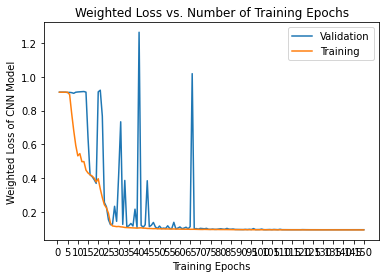




Fold- 3 : Initializing Datasets and Dataloaders...


num_epochs:   0%|                                                                              | 0/150 [00:00<?, ?it/s]



----------
Epoch 0/149
LR 5e-06
train: bce: 0.685602, dice: 0.931697, loss: 0.907087


num_epochs:   1%|▍                                                                   | 1/150 [00:28<1:11:25, 28.76s/it]

val: bce: 0.685516, dice: 0.932196, loss: 0.907528
saving best model
Total time: 0:00:28.765554
Epoch time: 0m 29s


----------
Epoch 1/149
LR 5e-06
train: bce: 0.685477, dice: 0.931698, loss: 0.907076


num_epochs:   1%|▉                                                                   | 2/150 [00:57<1:10:58, 28.77s/it]

val: bce: 0.685390, dice: 0.932197, loss: 0.907516
saving best model
Total time: 0:00:57.547476
Epoch time: 0m 29s


----------
Epoch 2/149
LR 5e-06
train: bce: 0.685348, dice: 0.931698, loss: 0.907063


num_epochs:   2%|█▎                                                                  | 3/150 [01:26<1:10:34, 28.81s/it]

val: bce: 0.685223, dice: 0.932198, loss: 0.907500
saving best model
Total time: 0:01:26.391398
Epoch time: 0m 29s


----------
Epoch 3/149
LR 5e-06
train: bce: 0.685187, dice: 0.931698, loss: 0.907046


num_epochs:   3%|█▊                                                                  | 4/150 [01:55<1:10:16, 28.88s/it]

val: bce: 0.684741, dice: 0.932196, loss: 0.907450
saving best model
Total time: 0:01:55.388088
Epoch time: 0m 29s


----------
Epoch 4/149
LR 5e-06
train: bce: 0.684224, dice: 0.931664, loss: 0.906920


num_epochs:   3%|██▎                                                                 | 5/150 [02:24<1:09:43, 28.85s/it]

val: bce: 0.681413, dice: 0.932227, loss: 0.907145
saving best model
Total time: 0:02:24.194315
Epoch time: 0m 29s


----------
Epoch 5/149
LR 5e-06
train: bce: 0.568978, dice: 0.919261, loss: 0.884233


num_epochs:   4%|██▋                                                                 | 6/150 [02:52<1:09:09, 28.81s/it]

val: bce: 0.507351, dice: 0.896590, loss: 0.857666
saving best model
Total time: 0:02:52.932589
Epoch time: 0m 29s


----------
Epoch 6/149
LR 5e-06
train: bce: 0.307776, dice: 0.767493, loss: 0.721521


num_epochs:   5%|███▏                                                                | 7/150 [03:21<1:08:38, 28.80s/it]

val: bce: 0.086817, dice: 0.599586, loss: 0.548309
saving best model
Total time: 0:03:21.700127
Epoch time: 0m 29s


----------
Epoch 7/149
LR 5e-06
train: bce: 0.192053, dice: 0.651098, loss: 0.605193


num_epochs:   5%|███▋                                                                | 8/150 [03:50<1:08:04, 28.76s/it]

val: bce: 0.240818, dice: 0.895628, loss: 0.830147
Total time: 0:03:50.389792
Epoch time: 0m 29s


----------
Epoch 8/149
LR 5e-06
train: bce: 0.135457, dice: 0.599330, loss: 0.552943


num_epochs:   6%|████                                                                | 9/150 [04:19<1:07:34, 28.76s/it]

val: bce: 0.265285, dice: 0.990418, loss: 0.917904
Total time: 0:04:19.125586
Epoch time: 0m 29s


----------
Epoch 9/149
LR 5e-06
train: bce: 0.105997, dice: 0.555666, loss: 0.510699


num_epochs:   7%|████▍                                                              | 10/150 [04:47<1:07:02, 28.73s/it]

val: bce: 0.174649, dice: 0.737542, loss: 0.681253
Total time: 0:04:47.811780
Epoch time: 0m 29s


----------
Epoch 10/149
LR 0.0005
train: bce: 0.089627, dice: 0.529680, loss: 0.485675


num_epochs:   7%|████▉                                                              | 11/150 [05:16<1:06:32, 28.72s/it]

val: bce: 0.127345, dice: 0.616248, loss: 0.567358
Total time: 0:05:16.499958
Epoch time: 0m 29s


----------
Epoch 11/149
LR 0.0005
train: bce: 0.068889, dice: 0.500182, loss: 0.457053


num_epochs:   8%|█████▎                                                             | 12/150 [05:45<1:06:03, 28.72s/it]

val: bce: 0.073467, dice: 0.513608, loss: 0.469594
saving best model
Total time: 0:05:45.228808
Epoch time: 0m 29s


----------
Epoch 12/149
LR 0.0005
train: bce: 0.060702, dice: 0.475998, loss: 0.434468


num_epochs:   9%|█████▊                                                             | 13/150 [06:13<1:05:33, 28.71s/it]

val: bce: 0.059648, dice: 0.473438, loss: 0.432059
saving best model
Total time: 0:06:13.916986
Epoch time: 0m 29s


----------
Epoch 13/149
LR 0.0005
train: bce: 0.054291, dice: 0.468936, loss: 0.427472


num_epochs:   9%|██████▎                                                            | 14/150 [06:42<1:05:09, 28.75s/it]

val: bce: 0.052951, dice: 0.465975, loss: 0.424673
saving best model
Total time: 0:06:42.739084
Epoch time: 0m 29s


----------
Epoch 14/149
LR 0.0005
train: bce: 0.049578, dice: 0.461783, loss: 0.420562


num_epochs:  10%|██████▋                                                            | 15/150 [07:11<1:04:41, 28.75s/it]

val: bce: 0.054877, dice: 0.464253, loss: 0.423315
saving best model
Total time: 0:07:11.504142
Epoch time: 0m 29s


----------
Epoch 15/149
LR 0.0005
train: bce: 0.045646, dice: 0.454429, loss: 0.413551


num_epochs:  11%|███████▏                                                           | 16/150 [07:40<1:04:12, 28.75s/it]

val: bce: 0.043583, dice: 0.452768, loss: 0.411850
saving best model
Total time: 0:07:40.261264
Epoch time: 0m 29s


----------
Epoch 16/149
LR 0.0005
train: bce: 0.043067, dice: 0.447277, loss: 0.406856


num_epochs:  11%|███████▌                                                           | 17/150 [08:09<1:03:45, 28.76s/it]

val: bce: 0.043533, dice: 0.445875, loss: 0.405641
saving best model
Total time: 0:08:09.039714
Epoch time: 0m 29s


----------
Epoch 17/149
LR 0.0005
train: bce: 0.041607, dice: 0.440863, loss: 0.400937


num_epochs:  12%|████████                                                           | 18/150 [08:37<1:03:12, 28.73s/it]

val: bce: 0.040931, dice: 0.440077, loss: 0.400162
saving best model
Total time: 0:08:37.705572
Epoch time: 0m 29s


----------
Epoch 18/149
LR 0.0005
train: bce: 0.040502, dice: 0.434511, loss: 0.395110


num_epochs:  13%|████████▍                                                          | 19/150 [09:06<1:02:48, 28.77s/it]

val: bce: 0.040088, dice: 0.431936, loss: 0.392751
saving best model
Total time: 0:09:06.555942
Epoch time: 0m 29s


----------
Epoch 19/149
LR 0.0005
train: bce: 0.039570, dice: 0.428714, loss: 0.389800


num_epochs:  13%|████████▉                                                          | 20/150 [09:35<1:02:25, 28.81s/it]

val: bce: 0.046181, dice: 0.435716, loss: 0.396762
Total time: 0:09:35.459880
Epoch time: 0m 29s


----------
Epoch 20/149
LR 0.0005
train: bce: 0.039116, dice: 0.424059, loss: 0.385565


num_epochs:  14%|█████████▍                                                         | 21/150 [10:04<1:02:03, 28.87s/it]

val: bce: 0.040998, dice: 0.424436, loss: 0.386092
saving best model
Total time: 0:10:04.461035
Epoch time: 0m 29s


----------
Epoch 21/149
LR 0.0005
train: bce: 0.038204, dice: 0.418169, loss: 0.380172


num_epochs:  15%|█████████▊                                                         | 22/150 [10:33<1:01:49, 28.98s/it]

val: bce: 0.043300, dice: 0.422865, loss: 0.384908
saving best model
Total time: 0:10:33.698781
Epoch time: 0m 29s


----------
Epoch 22/149
LR 0.0005
train: bce: 0.037825, dice: 0.413632, loss: 0.376051


num_epochs:  15%|██████████▎                                                        | 23/150 [11:05<1:02:58, 29.75s/it]

val: bce: 0.037330, dice: 0.411045, loss: 0.373673
saving best model
Total time: 0:11:05.253346
Epoch time: 0m 32s


----------
Epoch 23/149
LR 0.0005
train: bce: 0.037077, dice: 0.408220, loss: 0.371106


num_epochs:  16%|██████████▋                                                        | 24/150 [11:34<1:01:54, 29.48s/it]

val: bce: 0.035867, dice: 0.410388, loss: 0.372936
saving best model
Total time: 0:11:34.102725
Epoch time: 0m 29s


----------
Epoch 24/149
LR 0.0005
train: bce: 0.036601, dice: 0.403975, loss: 0.367238


num_epochs:  17%|███████████▏                                                       | 25/150 [12:02<1:00:56, 29.26s/it]

val: bce: 0.041697, dice: 0.408939, loss: 0.372214
saving best model
Total time: 0:12:02.832566
Epoch time: 0m 29s


----------
Epoch 25/149
LR 0.0005
train: bce: 0.036269, dice: 0.399446, loss: 0.363128


num_epochs:  17%|███████████▌                                                       | 26/150 [12:31<1:00:09, 29.11s/it]

val: bce: 0.042134, dice: 0.406522, loss: 0.370084
saving best model
Total time: 0:12:31.590184
Epoch time: 0m 29s


----------
Epoch 26/149
LR 0.0005
train: bce: 0.035729, dice: 0.394055, loss: 0.358223


num_epochs:  18%|████████████▍                                                        | 27/150 [13:00<59:25, 28.98s/it]

val: bce: 0.034612, dice: 0.390273, loss: 0.354707
saving best model
Total time: 0:13:00.288779
Epoch time: 0m 29s


----------
Epoch 27/149
LR 0.0005
train: bce: 0.034047, dice: 0.380102, loss: 0.345497


num_epochs:  19%|████████████▉                                                        | 28/150 [13:29<58:46, 28.90s/it]

val: bce: 0.035291, dice: 0.364546, loss: 0.331621
saving best model
Total time: 0:13:29.006717
Epoch time: 0m 29s


----------
Epoch 28/149
LR 0.0005
train: bce: 0.033350, dice: 0.337162, loss: 0.306781


num_epochs:  19%|█████████████▎                                                       | 29/150 [13:57<58:10, 28.84s/it]

val: bce: 0.042387, dice: 0.330900, loss: 0.302048
saving best model
Total time: 0:13:57.714239
Epoch time: 0m 29s


----------
Epoch 29/149
LR 0.0005
train: bce: 0.033288, dice: 0.313891, loss: 0.285830


num_epochs:  20%|█████████████▊                                                       | 30/150 [14:26<57:35, 28.79s/it]

val: bce: 0.037735, dice: 0.321089, loss: 0.292754
saving best model
Total time: 0:14:26.387537
Epoch time: 0m 29s


----------
Epoch 30/149
LR 0.0005
train: bce: 0.030730, dice: 0.293834, loss: 0.267523


num_epochs:  21%|██████████████▎                                                      | 31/150 [14:55<57:04, 28.78s/it]

val: bce: 0.043713, dice: 0.306479, loss: 0.280202
saving best model
Total time: 0:14:55.122834
Epoch time: 0m 29s


----------
Epoch 31/149
LR 0.0005
train: bce: 0.028388, dice: 0.251135, loss: 0.228860


num_epochs:  21%|██████████████▋                                                      | 32/150 [15:23<56:36, 28.78s/it]

val: bce: 0.165008, dice: 0.344536, loss: 0.326583
Total time: 0:15:23.917156
Epoch time: 0m 29s


----------
Epoch 32/149
LR 0.0005
train: bce: 0.032445, dice: 0.230367, loss: 0.210574


num_epochs:  22%|███████████████▏                                                     | 33/150 [15:52<56:08, 28.79s/it]

val: bce: 0.038023, dice: 0.234492, loss: 0.214845
saving best model
Total time: 0:15:52.741238
Epoch time: 0m 29s


----------
Epoch 33/149
LR 0.0005
train: bce: 0.033156, dice: 0.221654, loss: 0.202804


num_epochs:  23%|███████████████▋                                                     | 34/150 [16:21<55:39, 28.79s/it]

val: bce: 0.043335, dice: 0.229598, loss: 0.210972
saving best model
Total time: 0:16:21.524152
Epoch time: 0m 29s


----------
Epoch 34/149
LR 0.0005
train: bce: 0.033613, dice: 0.215509, loss: 0.197320


num_epochs:  23%|████████████████                                                     | 35/150 [16:50<55:08, 28.77s/it]

val: bce: 0.291896, dice: 0.291370, loss: 0.291423
Total time: 0:16:50.255979
Epoch time: 0m 29s


----------
Epoch 35/149
LR 0.0005
train: bce: 0.034315, dice: 0.212644, loss: 0.194811


num_epochs:  24%|████████████████▌                                                    | 36/150 [17:18<54:37, 28.75s/it]

val: bce: 2.693775, dice: 0.818139, loss: 1.005703
Total time: 0:17:18.962508
Epoch time: 0m 29s


----------
Epoch 36/149
LR 0.0005
train: bce: 0.055748, dice: 0.246509, loss: 0.227433


num_epochs:  25%|█████████████████                                                    | 37/150 [17:47<54:08, 28.75s/it]

val: bce: 0.048355, dice: 0.232766, loss: 0.214325
Total time: 0:17:47.708223
Epoch time: 0m 29s


----------
Epoch 37/149
LR 0.0005
train: bce: 0.036977, dice: 0.217279, loss: 0.199249


num_epochs:  25%|█████████████████▍                                                   | 38/150 [18:16<53:36, 28.72s/it]

val: bce: 0.041212, dice: 0.237612, loss: 0.217972
Total time: 0:18:16.363168
Epoch time: 0m 29s


----------
Epoch 38/149
LR 0.0005
train: bce: 0.036636, dice: 0.212594, loss: 0.194999


num_epochs:  26%|█████████████████▉                                                   | 39/150 [18:45<53:09, 28.73s/it]

val: bce: 0.043469, dice: 0.217856, loss: 0.200417
saving best model
Total time: 0:18:45.125746
Epoch time: 0m 29s


----------
Epoch 39/149
LR 0.0005
train: bce: 0.035767, dice: 0.207855, loss: 0.190646


num_epochs:  27%|██████████████████▍                                                  | 40/150 [19:13<52:38, 28.72s/it]

val: bce: 0.038907, dice: 0.208968, loss: 0.191962
saving best model
Total time: 0:19:13.799540
Epoch time: 0m 29s


----------
Epoch 40/149
LR 0.0005
train: bce: 0.035092, dice: 0.204849, loss: 0.187873


num_epochs:  27%|██████████████████▊                                                  | 41/150 [19:42<52:11, 28.73s/it]

val: bce: 0.034681, dice: 0.204235, loss: 0.187280
saving best model
Total time: 0:19:42.567078
Epoch time: 0m 29s


----------
Epoch 41/149
LR 0.0005
train: bce: 0.033975, dice: 0.200834, loss: 0.184148


num_epochs:  28%|███████████████████▎                                                 | 42/150 [20:11<51:42, 28.73s/it]

val: bce: 0.036187, dice: 0.205931, loss: 0.188957
Total time: 0:20:11.288984
Epoch time: 0m 29s


----------
Epoch 42/149
LR 0.0005
train: bce: 0.033174, dice: 0.197255, loss: 0.180847


num_epochs:  29%|███████████████████▊                                                 | 43/150 [20:40<51:15, 28.74s/it]

val: bce: 0.033717, dice: 0.197975, loss: 0.181549
saving best model
Total time: 0:20:40.060987
Epoch time: 0m 29s


----------
Epoch 43/149
LR 0.0005
train: bce: 0.032069, dice: 0.192979, loss: 0.176888


num_epochs:  29%|████████████████████▏                                                | 44/150 [21:08<50:47, 28.75s/it]

val: bce: 0.035802, dice: 0.197686, loss: 0.181497
saving best model
Total time: 0:21:08.825052
Epoch time: 0m 29s


----------
Epoch 44/149
LR 0.0005
train: bce: 0.027416, dice: 0.156909, loss: 0.143959


num_epochs:  30%|████████████████████▋                                                | 45/150 [21:37<50:19, 28.75s/it]

val: bce: 0.028551, dice: 0.114974, loss: 0.106332
saving best model
Total time: 0:21:37.589615
Epoch time: 0m 29s


----------
Epoch 45/149
LR 0.0005
train: bce: 0.027045, dice: 0.104595, loss: 0.096840


num_epochs:  31%|█████████████████████▏                                               | 46/150 [22:06<49:54, 28.79s/it]

val: bce: 0.029722, dice: 0.107880, loss: 0.100064
saving best model
Total time: 0:22:06.480161
Epoch time: 0m 29s


----------
Epoch 46/149
LR 0.0005
train: bce: 0.028745, dice: 0.102686, loss: 0.095292


num_epochs:  31%|█████████████████████▌                                               | 47/150 [22:35<49:25, 28.79s/it]

val: bce: 0.038360, dice: 0.115973, loss: 0.108212
Total time: 0:22:35.270514
Epoch time: 0m 29s


----------
Epoch 47/149
LR 0.0005
train: bce: 0.030267, dice: 0.103621, loss: 0.096286


num_epochs:  32%|██████████████████████                                               | 48/150 [23:04<48:55, 28.78s/it]

val: bce: 0.038126, dice: 0.115170, loss: 0.107466
Total time: 0:23:04.025652
Epoch time: 0m 29s


----------
Epoch 48/149
LR 0.0005
train: bce: 0.030330, dice: 0.102276, loss: 0.095081


num_epochs:  33%|██████████████████████▌                                              | 49/150 [23:32<48:24, 28.76s/it]

val: bce: 0.031860, dice: 0.103018, loss: 0.095902
saving best model
Total time: 0:23:32.729206
Epoch time: 0m 29s


----------
Epoch 49/149
LR 0.0005
train: bce: 0.030625, dice: 0.101304, loss: 0.094236


num_epochs:  33%|███████████████████████                                              | 50/150 [24:01<47:56, 28.76s/it]

val: bce: 0.035351, dice: 0.107818, loss: 0.100571
Total time: 0:24:01.506665
Epoch time: 0m 29s


----------
Epoch 50/149
LR 0.0005
train: bce: 0.030757, dice: 0.100344, loss: 0.093386


num_epochs:  34%|███████████████████████▍                                             | 51/150 [24:30<47:28, 28.77s/it]

val: bce: 0.032419, dice: 0.104597, loss: 0.097380
Total time: 0:24:30.285611
Epoch time: 0m 29s


----------
Epoch 51/149
LR 0.0005
train: bce: 0.031232, dice: 0.100555, loss: 0.093622


num_epochs:  35%|███████████████████████▉                                             | 52/150 [24:59<47:01, 28.79s/it]

val: bce: 0.035996, dice: 0.105738, loss: 0.098764
Total time: 0:24:59.114157
Epoch time: 0m 29s


----------
Epoch 52/149
LR 0.0005
train: bce: 0.031753, dice: 0.100839, loss: 0.093930


num_epochs:  35%|████████████████████████▍                                            | 53/150 [25:27<46:30, 28.77s/it]

val: bce: 0.031940, dice: 0.102456, loss: 0.095404
saving best model
Total time: 0:25:27.833582
Epoch time: 0m 29s


----------
Epoch 53/149
LR 0.0005
train: bce: 0.031746, dice: 0.099949, loss: 0.093129


num_epochs:  36%|████████████████████████▊                                            | 54/150 [25:56<46:00, 28.75s/it]

val: bce: 0.035855, dice: 0.106332, loss: 0.099284
Total time: 0:25:56.546561
Epoch time: 0m 29s


----------
Epoch 54/149
LR 0.0005
train: bce: 0.031683, dice: 0.099517, loss: 0.092733


num_epochs:  37%|█████████████████████████▎                                           | 55/150 [26:25<45:31, 28.75s/it]

val: bce: 0.039151, dice: 0.111505, loss: 0.104269
Total time: 0:26:25.289795
Epoch time: 0m 29s


----------
Epoch 55/149
LR 0.0005
train: bce: 0.032072, dice: 0.099538, loss: 0.092791


num_epochs:  37%|█████████████████████████▊                                           | 56/150 [26:54<45:02, 28.75s/it]

val: bce: 0.034670, dice: 0.103267, loss: 0.096407
Total time: 0:26:54.055845
Epoch time: 0m 29s


----------
Epoch 56/149
LR 0.0005
train: bce: 0.032327, dice: 0.099281, loss: 0.092585


num_epochs:  38%|██████████████████████████▏                                          | 57/150 [27:22<44:33, 28.75s/it]

val: bce: 0.034240, dice: 0.101767, loss: 0.095015
saving best model
Total time: 0:27:22.786678
Epoch time: 0m 29s


----------
Epoch 57/149
LR 0.0005
train: bce: 0.032305, dice: 0.098886, loss: 0.092228


num_epochs:  39%|██████████████████████████▋                                          | 58/150 [27:51<44:04, 28.74s/it]

val: bce: 0.035871, dice: 0.102224, loss: 0.095588
Total time: 0:27:51.521976
Epoch time: 0m 29s


----------
Epoch 58/149
LR 0.0005
train: bce: 0.032174, dice: 0.098213, loss: 0.091609


num_epochs:  39%|███████████████████████████▏                                         | 59/150 [28:20<43:36, 28.75s/it]

val: bce: 0.034535, dice: 0.103487, loss: 0.096591
Total time: 0:28:20.298938
Epoch time: 0m 29s


----------
Epoch 59/149
LR 0.0005
train: bce: 0.032671, dice: 0.098880, loss: 0.092259


num_epochs:  40%|███████████████████████████▌                                         | 60/150 [28:49<43:06, 28.74s/it]

val: bce: 0.060490, dice: 0.137358, loss: 0.129671
Total time: 0:28:49.007949
Epoch time: 0m 29s


----------
Epoch 60/149
LR 0.0005
train: bce: 0.032607, dice: 0.098147, loss: 0.091593


num_epochs:  41%|████████████████████████████                                         | 61/150 [29:17<42:36, 28.73s/it]

val: bce: 0.059835, dice: 0.154692, loss: 0.145206
Total time: 0:29:17.710510
Epoch time: 0m 29s


----------
Epoch 61/149
LR 0.0005
train: bce: 0.032434, dice: 0.097769, loss: 0.091236


num_epochs:  41%|████████████████████████████▌                                        | 62/150 [29:46<42:07, 28.72s/it]

val: bce: 0.046364, dice: 0.119862, loss: 0.112512
Total time: 0:29:46.422496
Epoch time: 0m 29s


----------
Epoch 62/149
LR 0.0005
train: bce: 0.032978, dice: 0.098366, loss: 0.091827


num_epochs:  42%|████████████████████████████▉                                        | 63/150 [30:15<41:38, 28.72s/it]

val: bce: 0.034080, dice: 0.099773, loss: 0.093204
saving best model
Total time: 0:30:15.126547
Epoch time: 0m 29s


----------
Epoch 63/149
LR 0.0005
train: bce: 0.032761, dice: 0.097754, loss: 0.091255


num_epochs:  43%|█████████████████████████████▍                                       | 64/150 [30:43<41:08, 28.71s/it]

val: bce: 0.048178, dice: 0.124529, loss: 0.116894
Total time: 0:30:43.813733
Epoch time: 0m 29s


----------
Epoch 64/149
LR 0.0005
train: bce: 0.034536, dice: 0.100432, loss: 0.093842


num_epochs:  43%|█████████████████████████████▉                                       | 65/150 [31:12<40:39, 28.71s/it]

val: bce: 0.040220, dice: 0.109727, loss: 0.102776
Total time: 0:31:12.511335
Epoch time: 0m 29s


----------
Epoch 65/149
LR 0.0005
train: bce: 0.033053, dice: 0.098114, loss: 0.091608


num_epochs:  44%|██████████████████████████████▎                                      | 66/150 [31:41<40:11, 28.70s/it]

val: bce: 0.034384, dice: 0.100539, loss: 0.093923
Total time: 0:31:41.214888
Epoch time: 0m 29s


----------
Epoch 66/149
LR 0.0005
train: bce: 0.032642, dice: 0.097126, loss: 0.090678


num_epochs:  45%|██████████████████████████████▊                                      | 67/150 [32:10<39:44, 28.73s/it]

val: bce: 0.036101, dice: 0.102853, loss: 0.096178
Total time: 0:32:10.016650
Epoch time: 0m 29s


----------
Epoch 67/149
LR 0.0005
train: bce: 0.032933, dice: 0.097103, loss: 0.090686


num_epochs:  45%|███████████████████████████████▎                                     | 68/150 [32:38<39:17, 28.75s/it]

val: bce: 0.054785, dice: 0.128766, loss: 0.121368
Total time: 0:32:38.804028
Epoch time: 0m 29s


----------
Epoch 68/149
LR 0.0005
train: bce: 0.033120, dice: 0.097270, loss: 0.090855


num_epochs:  46%|███████████████████████████████▋                                     | 69/150 [33:07<38:48, 28.74s/it]

val: bce: 0.035062, dice: 0.100380, loss: 0.093848
Total time: 0:33:07.524943
Epoch time: 0m 29s


----------
Epoch 69/149
LR 0.0005
train: bce: 0.033065, dice: 0.097112, loss: 0.090708


num_epochs:  47%|████████████████████████████████▏                                    | 70/150 [33:36<38:19, 28.74s/it]

val: bce: 0.037159, dice: 0.102906, loss: 0.096331
Total time: 0:33:36.265696
Epoch time: 0m 29s


----------
Epoch 70/149
LR 0.0005
train: bce: 0.033394, dice: 0.097505, loss: 0.091094


num_epochs:  47%|████████████████████████████████▋                                    | 71/150 [34:05<37:51, 28.75s/it]

val: bce: 0.042371, dice: 0.105487, loss: 0.099175
Total time: 0:34:05.043154
Epoch time: 0m 29s


----------
Epoch 71/149
LR 0.0005
train: bce: 0.033048, dice: 0.097024, loss: 0.090626


num_epochs:  48%|█████████████████████████████████                                    | 72/150 [34:33<37:22, 28.74s/it]

val: bce: 0.038291, dice: 0.107039, loss: 0.100164
Epoch    67: reducing learning rate of group 0 to 2.5000e-04.
Total time: 0:34:33.769524
Epoch time: 0m 29s


----------
Epoch 72/149
LR 0.00025
train: bce: 0.032665, dice: 0.096464, loss: 0.090084


num_epochs:  49%|█████████████████████████████████▌                                   | 73/150 [35:02<36:54, 28.76s/it]

val: bce: 0.033040, dice: 0.098398, loss: 0.091862
saving best model
Total time: 0:35:02.571286
Epoch time: 0m 29s


----------
Epoch 73/149
LR 0.00025
train: bce: 0.032303, dice: 0.095507, loss: 0.089187


num_epochs:  49%|██████████████████████████████████                                   | 74/150 [35:31<36:24, 28.75s/it]

val: bce: 0.035570, dice: 0.099230, loss: 0.092864
Total time: 0:35:31.284265
Epoch time: 0m 29s


----------
Epoch 74/149
LR 0.00025
train: bce: 0.032341, dice: 0.095462, loss: 0.089150


num_epochs:  50%|██████████████████████████████████▌                                  | 75/150 [36:00<35:56, 28.76s/it]

val: bce: 0.036406, dice: 0.100265, loss: 0.093879
Total time: 0:36:00.066186
Epoch time: 0m 29s


----------
Epoch 75/149
LR 0.00025
train: bce: 0.032487, dice: 0.095659, loss: 0.089342


num_epochs:  51%|██████████████████████████████████▉                                  | 76/150 [36:28<35:28, 28.76s/it]

val: bce: 0.032343, dice: 0.096572, loss: 0.090149
saving best model
Total time: 0:36:28.825789
Epoch time: 0m 29s


----------
Epoch 76/149
LR 0.00025
train: bce: 0.032542, dice: 0.095636, loss: 0.089326


num_epochs:  51%|███████████████████████████████████▍                                 | 77/150 [36:57<35:00, 28.77s/it]

val: bce: 0.033728, dice: 0.100435, loss: 0.093764
Total time: 0:36:57.634494
Epoch time: 0m 29s


----------
Epoch 77/149
LR 0.00025
train: bce: 0.032436, dice: 0.095367, loss: 0.089074


num_epochs:  52%|███████████████████████████████████▉                                 | 78/150 [37:26<34:29, 28.74s/it]

val: bce: 0.034679, dice: 0.098589, loss: 0.092198
Total time: 0:37:26.307792
Epoch time: 0m 29s


----------
Epoch 78/149
LR 0.00025
train: bce: 0.032529, dice: 0.095562, loss: 0.089259


num_epochs:  53%|████████████████████████████████████▎                                | 79/150 [37:55<34:01, 28.75s/it]

val: bce: 0.033751, dice: 0.098839, loss: 0.092330
Total time: 0:37:55.076819
Epoch time: 0m 29s


----------
Epoch 79/149
LR 0.00025
train: bce: 0.032503, dice: 0.095245, loss: 0.088971


num_epochs:  53%|████████████████████████████████████▊                                | 80/150 [38:23<33:30, 28.72s/it]

val: bce: 0.037771, dice: 0.100988, loss: 0.094666
Total time: 0:38:23.734244
Epoch time: 0m 29s


----------
Epoch 80/149
LR 0.00025
train: bce: 0.032789, dice: 0.095634, loss: 0.089350


num_epochs:  54%|█████████████████████████████████████▎                               | 81/150 [38:52<33:02, 28.73s/it]

val: bce: 0.033937, dice: 0.099056, loss: 0.092544
Total time: 0:38:52.479462
Epoch time: 0m 29s


----------
Epoch 81/149
LR 0.00025
train: bce: 0.032419, dice: 0.094990, loss: 0.088733


num_epochs:  55%|█████████████████████████████████████▋                               | 82/150 [39:21<32:33, 28.73s/it]

val: bce: 0.032630, dice: 0.096679, loss: 0.090274
Total time: 0:39:21.214760
Epoch time: 0m 29s


----------
Epoch 82/149
LR 0.00025
train: bce: 0.032436, dice: 0.094924, loss: 0.088676


num_epochs:  55%|██████████████████████████████████████▏                              | 83/150 [39:49<32:04, 28.72s/it]

val: bce: 0.035241, dice: 0.098388, loss: 0.092073
Total time: 0:39:49.922282
Epoch time: 0m 29s


----------
Epoch 83/149
LR 0.00025
train: bce: 0.032420, dice: 0.095003, loss: 0.088744


num_epochs:  56%|██████████████████████████████████████▋                              | 84/150 [40:18<31:36, 28.73s/it]

val: bce: 0.034930, dice: 0.098865, loss: 0.092471
Total time: 0:40:18.662044
Epoch time: 0m 29s


----------
Epoch 84/149
LR 0.00025
train: bce: 0.032520, dice: 0.095040, loss: 0.088788


num_epochs:  57%|███████████████████████████████████████                              | 85/150 [40:47<31:06, 28.72s/it]

val: bce: 0.033406, dice: 0.097656, loss: 0.091231
Epoch    80: reducing learning rate of group 0 to 1.2500e-04.
Total time: 0:40:47.350222
Epoch time: 0m 29s


----------
Epoch 85/149
LR 0.000125
train: bce: 0.032372, dice: 0.094716, loss: 0.088482


num_epochs:  57%|███████████████████████████████████████▌                             | 86/150 [41:16<30:38, 28.72s/it]

val: bce: 0.033368, dice: 0.096139, loss: 0.089862
saving best model
Total time: 0:41:16.090480
Epoch time: 0m 29s


----------
Epoch 86/149
LR 0.000125
train: bce: 0.032379, dice: 0.094531, loss: 0.088316


num_epochs:  58%|████████████████████████████████████████                             | 87/150 [41:44<30:09, 28.72s/it]

val: bce: 0.037049, dice: 0.100462, loss: 0.094121
Total time: 0:41:44.815362
Epoch time: 0m 29s


----------
Epoch 87/149
LR 0.000125
train: bce: 0.032340, dice: 0.094328, loss: 0.088129


num_epochs:  59%|████████████████████████████████████████▍                            | 88/150 [42:13<29:40, 28.71s/it]

val: bce: 0.033069, dice: 0.095472, loss: 0.089231
saving best model
Total time: 0:42:13.503540
Epoch time: 0m 29s


----------
Epoch 88/149
LR 0.000125
train: bce: 0.032327, dice: 0.094352, loss: 0.088149


num_epochs:  59%|████████████████████████████████████████▉                            | 89/150 [42:42<29:11, 28.71s/it]

val: bce: 0.033665, dice: 0.096892, loss: 0.090569
Total time: 0:42:42.202631
Epoch time: 0m 29s


----------
Epoch 89/149
LR 0.000125
train: bce: 0.032231, dice: 0.094373, loss: 0.088159


num_epochs:  60%|█████████████████████████████████████████▍                           | 90/150 [43:10<28:43, 28.73s/it]

val: bce: 0.034506, dice: 0.096926, loss: 0.090684
Total time: 0:43:10.975128
Epoch time: 0m 29s


----------
Epoch 90/149
LR 0.000125
train: bce: 0.032302, dice: 0.094306, loss: 0.088105


num_epochs:  61%|█████████████████████████████████████████▊                           | 91/150 [43:39<28:14, 28.73s/it]

val: bce: 0.032793, dice: 0.097077, loss: 0.090649
Total time: 0:43:39.698026
Epoch time: 0m 29s


----------
Epoch 91/149
LR 0.000125
train: bce: 0.032226, dice: 0.094116, loss: 0.087927


num_epochs:  61%|██████████████████████████████████████████▎                          | 92/150 [44:08<27:45, 28.72s/it]

val: bce: 0.037622, dice: 0.101744, loss: 0.095332
Total time: 0:44:08.411500
Epoch time: 0m 29s


----------
Epoch 92/149
LR 0.000125
train: bce: 0.032374, dice: 0.094310, loss: 0.088117


num_epochs:  62%|██████████████████████████████████████████▊                          | 93/150 [44:37<27:17, 28.72s/it]

val: bce: 0.032716, dice: 0.095948, loss: 0.089624
Total time: 0:44:37.126463
Epoch time: 0m 29s


----------
Epoch 93/149
LR 0.000125
train: bce: 0.032203, dice: 0.094019, loss: 0.087837


num_epochs:  63%|███████████████████████████████████████████▏                         | 94/150 [45:05<26:47, 28.70s/it]

val: bce: 0.035631, dice: 0.103859, loss: 0.097037
Total time: 0:45:05.793312
Epoch time: 0m 29s


----------
Epoch 94/149
LR 0.000125
train: bce: 0.032259, dice: 0.094115, loss: 0.087930


num_epochs:  63%|███████████████████████████████████████████▋                         | 95/150 [45:34<26:17, 28.69s/it]

val: bce: 0.034064, dice: 0.098929, loss: 0.092442
Total time: 0:45:34.447762
Epoch time: 0m 29s


----------
Epoch 95/149
LR 0.000125
train: bce: 0.032212, dice: 0.094004, loss: 0.087825


num_epochs:  64%|████████████████████████████████████████████▏                        | 96/150 [46:03<25:49, 28.70s/it]

val: bce: 0.036820, dice: 0.104175, loss: 0.097440
Total time: 0:46:03.156771
Epoch time: 0m 29s


----------
Epoch 96/149
LR 0.000125
train: bce: 0.032090, dice: 0.093729, loss: 0.087566


num_epochs:  65%|████████████████████████████████████████████▌                        | 97/150 [46:31<25:22, 28.72s/it]

val: bce: 0.033664, dice: 0.098139, loss: 0.091691
Epoch    92: reducing learning rate of group 0 to 6.2500e-05.
Total time: 0:46:31.927287
Epoch time: 0m 29s


----------
Epoch 97/149
LR 6.25e-05
train: bce: 0.032102, dice: 0.093794, loss: 0.087625


num_epochs:  65%|█████████████████████████████████████████████                        | 98/150 [47:00<24:53, 28.71s/it]

val: bce: 0.032661, dice: 0.095517, loss: 0.089231
Total time: 0:47:00.631832
Epoch time: 0m 29s


----------
Epoch 98/149
LR 6.25e-05
train: bce: 0.032033, dice: 0.093623, loss: 0.087464


num_epochs:  66%|█████████████████████████████████████████████▌                       | 99/150 [47:29<24:24, 28.72s/it]

val: bce: 0.032370, dice: 0.095339, loss: 0.089042
saving best model
Total time: 0:47:29.367626
Epoch time: 0m 29s


----------
Epoch 99/149
LR 6.25e-05
train: bce: 0.031859, dice: 0.093489, loss: 0.087326


num_epochs:  67%|█████████████████████████████████████████████▎                      | 100/150 [47:58<23:55, 28.72s/it]

val: bce: 0.032905, dice: 0.095403, loss: 0.089153
Total time: 0:47:58.079611
Epoch time: 0m 29s


----------
Epoch 100/149
LR 6.25e-05
train: bce: 0.031905, dice: 0.093454, loss: 0.087299


num_epochs:  67%|█████████████████████████████████████████████▊                      | 101/150 [48:26<23:26, 28.71s/it]

val: bce: 0.032518, dice: 0.095123, loss: 0.088862
saving best model
Total time: 0:48:26.783662
Epoch time: 0m 29s


----------
Epoch 101/149
LR 6.25e-05
train: bce: 0.031889, dice: 0.093399, loss: 0.087248


num_epochs:  68%|██████████████████████████████████████████████▏                     | 102/150 [48:55<22:57, 28.71s/it]

val: bce: 0.032296, dice: 0.095020, loss: 0.088748
saving best model
Total time: 0:48:55.475312
Epoch time: 0m 29s


----------
Epoch 102/149
LR 6.25e-05
train: bce: 0.031828, dice: 0.093342, loss: 0.087190


num_epochs:  69%|██████████████████████████████████████████████▋                     | 103/150 [49:24<22:28, 28.70s/it]

val: bce: 0.033067, dice: 0.095743, loss: 0.089476
Total time: 0:49:24.151089
Epoch time: 0m 29s


----------
Epoch 103/149
LR 6.25e-05
train: bce: 0.031899, dice: 0.093429, loss: 0.087276


num_epochs:  69%|███████████████████████████████████████████████▏                    | 104/150 [49:52<22:00, 28.71s/it]

val: bce: 0.032242, dice: 0.095057, loss: 0.088775
Total time: 0:49:52.879940
Epoch time: 0m 29s


----------
Epoch 104/149
LR 6.25e-05
train: bce: 0.031928, dice: 0.093461, loss: 0.087308


num_epochs:  70%|███████████████████████████████████████████████▌                    | 105/150 [50:21<21:32, 28.72s/it]

val: bce: 0.032517, dice: 0.094913, loss: 0.088673
saving best model
Total time: 0:50:21.622181
Epoch time: 0m 29s


----------
Epoch 105/149
LR 6.25e-05
train: bce: 0.031936, dice: 0.093404, loss: 0.087258


num_epochs:  71%|████████████████████████████████████████████████                    | 106/150 [50:50<21:03, 28.71s/it]

val: bce: 0.032471, dice: 0.095370, loss: 0.089080
Total time: 0:50:50.300440
Epoch time: 0m 29s


----------
Epoch 106/149
LR 6.25e-05
train: bce: 0.031963, dice: 0.093366, loss: 0.087226


num_epochs:  71%|████████████████████████████████████████████████▌                   | 107/150 [51:19<20:34, 28.72s/it]

val: bce: 0.032304, dice: 0.095172, loss: 0.088885
Total time: 0:51:19.048633
Epoch time: 0m 29s


----------
Epoch 107/149
LR 6.25e-05
train: bce: 0.031929, dice: 0.093251, loss: 0.087119


num_epochs:  72%|████████████████████████████████████████████████▉                   | 108/150 [51:47<20:07, 28.74s/it]

val: bce: 0.033025, dice: 0.095409, loss: 0.089171
Total time: 0:51:47.837996
Epoch time: 0m 29s


----------
Epoch 108/149
LR 6.25e-05
train: bce: 0.032018, dice: 0.093396, loss: 0.087258


num_epochs:  73%|█████████████████████████████████████████████████▍                  | 109/150 [52:16<19:38, 28.74s/it]

val: bce: 0.032556, dice: 0.094936, loss: 0.088698
Total time: 0:52:16.586685
Epoch time: 0m 29s


----------
Epoch 109/149
LR 6.25e-05
train: bce: 0.031959, dice: 0.093292, loss: 0.087158


num_epochs:  73%|█████████████████████████████████████████████████▊                  | 110/150 [52:45<19:08, 28.72s/it]

val: bce: 0.032487, dice: 0.094895, loss: 0.088654
saving best model
Total time: 0:52:45.260975
Epoch time: 0m 29s


----------
Epoch 110/149
LR 6.25e-05
train: bce: 0.032054, dice: 0.093387, loss: 0.087254


num_epochs:  74%|██████████████████████████████████████████████████▎                 | 111/150 [53:14<18:40, 28.74s/it]

val: bce: 0.032972, dice: 0.095196, loss: 0.088973
Total time: 0:53:14.049345
Epoch time: 0m 29s


----------
Epoch 111/149
LR 6.25e-05
train: bce: 0.032003, dice: 0.093277, loss: 0.087149


num_epochs:  75%|██████████████████████████████████████████████████▊                 | 112/150 [53:42<18:12, 28.75s/it]

val: bce: 0.032343, dice: 0.095501, loss: 0.089185
Total time: 0:53:42.819363
Epoch time: 0m 29s


----------
Epoch 112/149
LR 6.25e-05
train: bce: 0.031849, dice: 0.093134, loss: 0.087005


num_epochs:  75%|███████████████████████████████████████████████████▏                | 113/150 [54:11<17:44, 28.76s/it]

val: bce: 0.032894, dice: 0.094915, loss: 0.088713
Total time: 0:54:11.609221
Epoch time: 0m 29s


----------
Epoch 113/149
LR 6.25e-05
train: bce: 0.031920, dice: 0.093101, loss: 0.086983


num_epochs:  76%|███████████████████████████████████████████████████▋                | 114/150 [54:40<17:15, 28.76s/it]

val: bce: 0.033102, dice: 0.095317, loss: 0.089095
Total time: 0:54:40.379239
Epoch time: 0m 29s


----------
Epoch 114/149
LR 6.25e-05
train: bce: 0.031889, dice: 0.093102, loss: 0.086980


num_epochs:  77%|████████████████████████████████████████████████████▏               | 115/150 [55:09<16:46, 28.76s/it]

val: bce: 0.033983, dice: 0.096198, loss: 0.089976
Total time: 0:55:09.143801
Epoch time: 0m 29s


----------
Epoch 115/149
LR 6.25e-05
train: bce: 0.031961, dice: 0.093048, loss: 0.086939


num_epochs:  77%|████████████████████████████████████████████████████▌               | 116/150 [55:37<16:17, 28.75s/it]

val: bce: 0.032375, dice: 0.094924, loss: 0.088670
Total time: 0:55:37.863724
Epoch time: 0m 29s


----------
Epoch 116/149
LR 6.25e-05
train: bce: 0.031992, dice: 0.093175, loss: 0.087057


num_epochs:  78%|█████████████████████████████████████████████████████               | 117/150 [56:06<15:48, 28.75s/it]

val: bce: 0.032589, dice: 0.095148, loss: 0.088892
Total time: 0:56:06.602493
Epoch time: 0m 29s


----------
Epoch 117/149
LR 6.25e-05
train: bce: 0.031938, dice: 0.093129, loss: 0.087010


num_epochs:  79%|█████████████████████████████████████████████████████▍              | 118/150 [56:35<15:19, 28.74s/it]

val: bce: 0.033084, dice: 0.095243, loss: 0.089027
Total time: 0:56:35.337791
Epoch time: 0m 29s


----------
Epoch 118/149
LR 6.25e-05
train: bce: 0.031922, dice: 0.092940, loss: 0.086838


num_epochs:  79%|█████████████████████████████████████████████████████▉              | 119/150 [57:04<14:50, 28.74s/it]

val: bce: 0.036169, dice: 0.102364, loss: 0.095744
Epoch   114: reducing learning rate of group 0 to 3.1250e-05.
Total time: 0:57:04.064161
Epoch time: 0m 29s


----------
Epoch 119/149
LR 3.125e-05
train: bce: 0.031913, dice: 0.092967, loss: 0.086862


num_epochs:  80%|██████████████████████████████████████████████████████▍             | 120/150 [57:32<14:22, 28.75s/it]

val: bce: 0.032495, dice: 0.094800, loss: 0.088570
saving best model
Total time: 0:57:32.831203
Epoch time: 0m 29s


----------
Epoch 120/149
LR 3.125e-05
train: bce: 0.031850, dice: 0.092817, loss: 0.086720


num_epochs:  81%|██████████████████████████████████████████████████████▊             | 121/150 [58:01<13:53, 28.74s/it]

val: bce: 0.033114, dice: 0.095247, loss: 0.089033
Total time: 0:58:01.555095
Epoch time: 0m 29s


----------
Epoch 121/149
LR 3.125e-05
train: bce: 0.031701, dice: 0.092747, loss: 0.086642


num_epochs:  81%|███████████████████████████████████████████████████████▎            | 122/150 [58:30<13:24, 28.73s/it]

val: bce: 0.032305, dice: 0.094488, loss: 0.088269
saving best model
Total time: 0:58:30.265095
Epoch time: 0m 29s


----------
Epoch 122/149
LR 3.125e-05
train: bce: 0.031759, dice: 0.092772, loss: 0.086671


num_epochs:  82%|███████████████████████████████████████████████████████▊            | 123/150 [58:58<12:55, 28.73s/it]

val: bce: 0.032684, dice: 0.094912, loss: 0.088689
Total time: 0:58:58.993945
Epoch time: 0m 29s


----------
Epoch 123/149
LR 3.125e-05
train: bce: 0.032000, dice: 0.093124, loss: 0.087012


num_epochs:  83%|████████████████████████████████████████████████████████▏           | 124/150 [59:27<12:26, 28.72s/it]

val: bce: 0.032531, dice: 0.095576, loss: 0.089271
Total time: 0:59:27.697003
Epoch time: 0m 29s


----------
Epoch 124/149
LR 3.125e-05
train: bce: 0.031815, dice: 0.092809, loss: 0.086709


num_epochs:  83%|████████████████████████████████████████████████████████▋           | 125/150 [59:56<11:58, 28.72s/it]

val: bce: 0.032424, dice: 0.094792, loss: 0.088555
Total time: 0:59:56.414941
Epoch time: 0m 29s


----------
Epoch 125/149
LR 3.125e-05
train: bce: 0.031672, dice: 0.092694, loss: 0.086592


num_epochs:  84%|███████████████████████████████████████████████████████▍          | 126/150 [1:00:25<11:29, 28.73s/it]

val: bce: 0.032269, dice: 0.094528, loss: 0.088302
Total time: 1:00:25.175535
Epoch time: 0m 29s


----------
Epoch 126/149
LR 3.125e-05
train: bce: 0.031856, dice: 0.092852, loss: 0.086752


num_epochs:  85%|███████████████████████████████████████████████████████▉          | 127/150 [1:00:53<11:00, 28.74s/it]

val: bce: 0.032431, dice: 0.095254, loss: 0.088971
Total time: 1:00:53.921745
Epoch time: 0m 29s


----------
Epoch 127/149
LR 3.125e-05
train: bce: 0.031828, dice: 0.092675, loss: 0.086591


num_epochs:  85%|████████████████████████████████████████████████████████▎         | 128/150 [1:01:22<10:32, 28.74s/it]

val: bce: 0.034343, dice: 0.096224, loss: 0.090036
Total time: 1:01:22.662995
Epoch time: 0m 29s


----------
Epoch 128/149
LR 3.125e-05
train: bce: 0.031743, dice: 0.092630, loss: 0.086542


num_epochs:  86%|████████████████████████████████████████████████████████▊         | 129/150 [1:01:51<10:03, 28.73s/it]

val: bce: 0.032559, dice: 0.095110, loss: 0.088855
Total time: 1:01:51.377957
Epoch time: 0m 29s


----------
Epoch 129/149
LR 3.125e-05
train: bce: 0.031739, dice: 0.092621, loss: 0.086533


num_epochs:  87%|█████████████████████████████████████████████████████████▏        | 130/150 [1:02:20<09:34, 28.73s/it]

val: bce: 0.032414, dice: 0.094615, loss: 0.088394
Total time: 1:02:20.094903
Epoch time: 0m 29s


----------
Epoch 130/149
LR 3.125e-05
train: bce: 0.031847, dice: 0.092770, loss: 0.086677


num_epochs:  87%|█████████████████████████████████████████████████████████▋        | 131/150 [1:02:48<09:05, 28.70s/it]

val: bce: 0.033458, dice: 0.095136, loss: 0.088968
Epoch   126: reducing learning rate of group 0 to 1.5625e-05.
Total time: 1:02:48.742905
Epoch time: 0m 29s


----------
Epoch 131/149
LR 1.5625e-05
train: bce: 0.031826, dice: 0.092534, loss: 0.086463


num_epochs:  88%|██████████████████████████████████████████████████████████        | 132/150 [1:03:17<08:36, 28.70s/it]

val: bce: 0.032895, dice: 0.094905, loss: 0.088704
Total time: 1:03:17.442491
Epoch time: 0m 29s


----------
Epoch 132/149
LR 1.5625e-05
train: bce: 0.031740, dice: 0.092546, loss: 0.086466


num_epochs:  89%|██████████████████████████████████████████████████████████▌       | 133/150 [1:03:46<08:07, 28.70s/it]

val: bce: 0.032209, dice: 0.094583, loss: 0.088345
Total time: 1:03:46.121245
Epoch time: 0m 29s


----------
Epoch 133/149
LR 1.5625e-05
train: bce: 0.031782, dice: 0.092571, loss: 0.086492


num_epochs:  89%|██████████████████████████████████████████████████████████▉       | 134/150 [1:04:14<07:39, 28.71s/it]

val: bce: 0.032671, dice: 0.094552, loss: 0.088364
Total time: 1:04:14.880847
Epoch time: 0m 29s


----------
Epoch 134/149
LR 1.5625e-05
train: bce: 0.031772, dice: 0.092576, loss: 0.086496


num_epochs:  90%|███████████████████████████████████████████████████████████▍      | 135/150 [1:04:43<07:10, 28.71s/it]

val: bce: 0.032521, dice: 0.094519, loss: 0.088319
Total time: 1:04:43.583410
Epoch time: 0m 29s


----------
Epoch 135/149
LR 1.5625e-05
train: bce: 0.031729, dice: 0.092446, loss: 0.086374


num_epochs:  91%|███████████████████████████████████████████████████████████▊      | 136/150 [1:05:12<06:41, 28.70s/it]

val: bce: 0.033275, dice: 0.094950, loss: 0.088782
Total time: 1:05:12.263651
Epoch time: 0m 29s


----------
Epoch 136/149
LR 1.5625e-05
train: bce: 0.031788, dice: 0.092511, loss: 0.086439


num_epochs:  91%|████████████████████████████████████████████████████████████▎     | 137/150 [1:05:40<06:13, 28.70s/it]

val: bce: 0.033009, dice: 0.094894, loss: 0.088706
Total time: 1:05:40.965220
Epoch time: 0m 29s


----------
Epoch 137/149
LR 1.5625e-05
train: bce: 0.031759, dice: 0.092491, loss: 0.086418


num_epochs:  92%|████████████████████████████████████████████████████████████▋     | 138/150 [1:06:09<05:44, 28.70s/it]

val: bce: 0.032374, dice: 0.094550, loss: 0.088332
Total time: 1:06:09.658854
Epoch time: 0m 29s


----------
Epoch 138/149
LR 1.5625e-05
train: bce: 0.031702, dice: 0.092473, loss: 0.086396


num_epochs:  93%|█████████████████████████████████████████████████████████████▏    | 139/150 [1:06:38<05:15, 28.73s/it]

val: bce: 0.032523, dice: 0.094540, loss: 0.088339
Total time: 1:06:38.450200
Epoch time: 0m 29s


----------
Epoch 139/149
LR 1.5625e-05
train: bce: 0.031717, dice: 0.092432, loss: 0.086360


num_epochs:  93%|█████████████████████████████████████████████████████████████▌    | 140/150 [1:07:07<04:47, 28.73s/it]

val: bce: 0.032607, dice: 0.094545, loss: 0.088351
Total time: 1:07:07.173595
Epoch time: 0m 29s


----------
Epoch 140/149
LR 1.5625e-05
train: bce: 0.031670, dice: 0.092381, loss: 0.086310


num_epochs:  94%|██████████████████████████████████████████████████████████████    | 141/150 [1:07:35<04:18, 28.75s/it]

val: bce: 0.032439, dice: 0.094393, loss: 0.088198
saving best model
Total time: 1:07:35.987756
Epoch time: 0m 29s


----------
Epoch 141/149
LR 1.5625e-05
train: bce: 0.031721, dice: 0.092454, loss: 0.086381


num_epochs:  95%|██████████████████████████████████████████████████████████████▍   | 142/150 [1:08:04<03:50, 28.77s/it]

val: bce: 0.032542, dice: 0.094686, loss: 0.088472
Total time: 1:08:04.812335
Epoch time: 0m 29s


----------
Epoch 142/149
LR 1.5625e-05
train: bce: 0.031739, dice: 0.092560, loss: 0.086478


num_epochs:  95%|██████████████████████████████████████████████████████████████▉   | 143/150 [1:08:33<03:21, 28.75s/it]

val: bce: 0.032932, dice: 0.094773, loss: 0.088589
Total time: 1:08:33.498529
Epoch time: 0m 29s


----------
Epoch 143/149
LR 1.5625e-05
train: bce: 0.031754, dice: 0.092470, loss: 0.086399


num_epochs:  96%|███████████████████████████████████████████████████████████████▎  | 144/150 [1:09:02<02:52, 28.73s/it]

val: bce: 0.033007, dice: 0.094687, loss: 0.088519
Total time: 1:09:02.174804
Epoch time: 0m 29s


----------
Epoch 144/149
LR 1.5625e-05
train: bce: 0.031719, dice: 0.092411, loss: 0.086342


num_epochs:  97%|███████████████████████████████████████████████████████████████▊  | 145/150 [1:09:30<02:23, 28.73s/it]

val: bce: 0.033031, dice: 0.094934, loss: 0.088744
Total time: 1:09:30.913076
Epoch time: 0m 29s


----------
Epoch 145/149
LR 1.5625e-05
train: bce: 0.031716, dice: 0.092407, loss: 0.086338


num_epochs:  97%|████████████████████████████████████████████████████████████████▏ | 146/150 [1:09:59<01:54, 28.74s/it]

val: bce: 0.032416, dice: 0.094473, loss: 0.088268
Total time: 1:09:59.669206
Epoch time: 0m 29s


----------
Epoch 146/149
LR 1.5625e-05
train: bce: 0.031745, dice: 0.092466, loss: 0.086394


num_epochs:  98%|████████████████████████████████████████████████████████████████▋ | 147/150 [1:10:28<01:26, 28.73s/it]

val: bce: 0.032301, dice: 0.094460, loss: 0.088244
Total time: 1:10:28.366312
Epoch time: 0m 29s


----------
Epoch 147/149
LR 1.5625e-05
train: bce: 0.031715, dice: 0.092418, loss: 0.086348


num_epochs:  99%|█████████████████████████████████████████████████████████████████ | 148/150 [1:10:57<00:57, 28.72s/it]

val: bce: 0.032437, dice: 0.094494, loss: 0.088288
Total time: 1:10:57.062427
Epoch time: 0m 29s


----------
Epoch 148/149
LR 1.5625e-05
train: bce: 0.031666, dice: 0.092277, loss: 0.086216


num_epochs:  99%|█████████████████████████████████████████████████████████████████▌| 149/150 [1:11:25<00:28, 28.70s/it]

val: bce: 0.032333, dice: 0.094208, loss: 0.088021
saving best model
Total time: 1:11:25.737213
Epoch time: 0m 29s


----------
Epoch 149/149
LR 1.5625e-05
train: bce: 0.031691, dice: 0.092365, loss: 0.086297


num_epochs: 100%|██████████████████████████████████████████████████████████████████| 150/150 [1:11:54<00:00, 28.76s/it]


val: bce: 0.032266, dice: 0.094448, loss: 0.088229
Total time: 1:11:54.472510
Epoch time: 0m 29s
Best val loss: 0.088021
model training finished, reinitializing training....



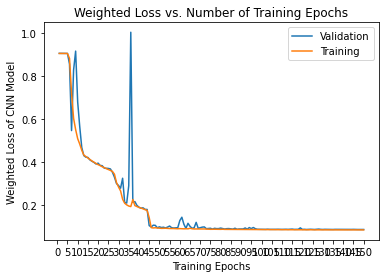




Fold- 4 : Initializing Datasets and Dataloaders...


num_epochs:   0%|                                                                              | 0/150 [00:00<?, ?it/s]



----------
Epoch 0/149
LR 5e-06
train: bce: 0.709673, dice: 0.931451, loss: 0.909273


num_epochs:   1%|▍                                                                   | 1/150 [00:28<1:11:14, 28.69s/it]

val: bce: 0.709601, dice: 0.931052, loss: 0.908907
saving best model
Total time: 0:00:28.694773
Epoch time: 0m 29s


----------
Epoch 1/149
LR 5e-06
train: bce: 0.709558, dice: 0.931452, loss: 0.909263


num_epochs:   1%|▉                                                                   | 2/150 [00:57<1:10:52, 28.73s/it]

val: bce: 0.709486, dice: 0.931052, loss: 0.908896
saving best model
Total time: 0:00:57.456856
Epoch time: 0m 29s


----------
Epoch 2/149
LR 5e-06
train: bce: 0.709440, dice: 0.931453, loss: 0.909251


num_epochs:   2%|█▎                                                                  | 3/150 [01:26<1:10:24, 28.74s/it]

val: bce: 0.709328, dice: 0.931053, loss: 0.908881
saving best model
Total time: 0:01:26.207529
Epoch time: 0m 29s


----------
Epoch 3/149
LR 5e-06
train: bce: 0.709305, dice: 0.931452, loss: 0.909238


num_epochs:   3%|█▊                                                                  | 4/150 [01:54<1:09:53, 28.72s/it]

val: bce: 0.709039, dice: 0.931053, loss: 0.908852
saving best model
Total time: 0:01:54.906123
Epoch time: 0m 29s


----------
Epoch 4/149
LR 5e-06
train: bce: 0.708849, dice: 0.931439, loss: 0.909180


num_epochs:   3%|██▎                                                                 | 5/150 [02:23<1:09:23, 28.71s/it]

val: bce: 0.677097, dice: 0.931766, loss: 0.906299
saving best model
Total time: 0:02:23.602237
Epoch time: 0m 29s


----------
Epoch 5/149
LR 5e-06
train: bce: 0.611444, dice: 0.924758, loss: 0.893427


num_epochs:   4%|██▋                                                                 | 6/150 [02:52<1:08:55, 28.72s/it]

val: bce: 0.656358, dice: 0.927541, loss: 0.900423
saving best model
Total time: 0:02:52.323151
Epoch time: 0m 29s


----------
Epoch 6/149
LR 5e-06
train: bce: 0.225674, dice: 0.794937, loss: 0.738011


num_epochs:   5%|███▏                                                                | 7/150 [03:21<1:08:25, 28.71s/it]

val: bce: 0.259785, dice: 0.797879, loss: 0.744069
saving best model
Total time: 0:03:21.013313
Epoch time: 0m 29s


----------
Epoch 7/149
LR 5e-06
train: bce: 0.059475, dice: 0.537249, loss: 0.489471


num_epochs:   5%|███▋                                                                | 8/150 [03:49<1:07:57, 28.71s/it]

val: bce: 0.060640, dice: 0.518521, loss: 0.472733
saving best model
Total time: 0:03:49.742659
Epoch time: 0m 29s


----------
Epoch 8/149
LR 5e-06
train: bce: 0.055801, dice: 0.483906, loss: 0.441096


num_epochs:   6%|████                                                                | 9/150 [04:18<1:07:31, 28.73s/it]

val: bce: 0.073561, dice: 0.505967, loss: 0.462726
saving best model
Total time: 0:04:18.521605
Epoch time: 0m 29s


----------
Epoch 9/149
LR 5e-06
train: bce: 0.053898, dice: 0.472953, loss: 0.431047


num_epochs:   7%|████▍                                                              | 10/150 [04:47<1:06:58, 28.70s/it]

val: bce: 0.104114, dice: 0.732876, loss: 0.669999
Total time: 0:04:47.152743
Epoch time: 0m 29s


----------
Epoch 10/149
LR 0.0005
train: bce: 0.052172, dice: 0.466325, loss: 0.424909


num_epochs:   7%|████▉                                                              | 11/150 [05:15<1:06:30, 28.71s/it]

val: bce: 0.060947, dice: 0.470319, loss: 0.429382
saving best model
Total time: 0:05:15.872169
Epoch time: 0m 29s


----------
Epoch 11/149
LR 0.0005
train: bce: 0.049757, dice: 0.461125, loss: 0.419988


num_epochs:   8%|█████▎                                                             | 12/150 [05:44<1:05:59, 28.69s/it]

val: bce: 0.052655, dice: 0.462136, loss: 0.421188
saving best model
Total time: 0:05:44.524139
Epoch time: 0m 29s


----------
Epoch 12/149
LR 0.0005
train: bce: 0.048017, dice: 0.456555, loss: 0.415702


num_epochs:   9%|█████▊                                                             | 13/150 [06:13<1:05:30, 28.69s/it]

val: bce: 0.046881, dice: 0.453657, loss: 0.412979
saving best model
Total time: 0:06:13.214301
Epoch time: 0m 29s


----------
Epoch 13/149
LR 0.0005
train: bce: 0.045509, dice: 0.451033, loss: 0.410481


num_epochs:   9%|██████▎                                                            | 14/150 [06:41<1:05:01, 28.69s/it]

val: bce: 0.045309, dice: 0.464999, loss: 0.423030
Total time: 0:06:41.900496
Epoch time: 0m 29s


----------
Epoch 14/149
LR 0.0005
train: bce: 0.044679, dice: 0.447134, loss: 0.406888


num_epochs:  10%|██████▋                                                            | 15/150 [07:10<1:04:35, 28.71s/it]

val: bce: 0.059191, dice: 0.470120, loss: 0.429027
Total time: 0:07:10.644225
Epoch time: 0m 29s


----------
Epoch 15/149
LR 0.0005
train: bce: 0.042858, dice: 0.441782, loss: 0.401889


num_epochs:  11%|███████▏                                                           | 16/150 [07:39<1:04:05, 28.70s/it]

val: bce: 0.047144, dice: 0.481186, loss: 0.437782
Total time: 0:07:39.316531
Epoch time: 0m 29s


----------
Epoch 16/149
LR 0.0005
train: bce: 0.041685, dice: 0.436934, loss: 0.397409


num_epochs:  11%|███████▌                                                           | 17/150 [08:08<1:03:39, 28.72s/it]

val: bce: 0.044955, dice: 0.439252, loss: 0.399823
saving best model
Total time: 0:08:08.084565
Epoch time: 0m 29s


----------
Epoch 17/149
LR 0.0005
train: bce: 0.040645, dice: 0.432196, loss: 0.393041


num_epochs:  12%|████████                                                           | 18/150 [08:36<1:03:12, 28.73s/it]

val: bce: 0.043601, dice: 0.434015, loss: 0.394974
saving best model
Total time: 0:08:36.839207
Epoch time: 0m 29s


----------
Epoch 18/149
LR 0.0005
train: bce: 0.039722, dice: 0.427600, loss: 0.388812


num_epochs:  13%|████████▍                                                          | 19/150 [09:05<1:02:42, 28.72s/it]

val: bce: 0.038883, dice: 0.428996, loss: 0.389985
saving best model
Total time: 0:09:05.540777
Epoch time: 0m 29s


----------
Epoch 19/149
LR 0.0005
train: bce: 0.038901, dice: 0.423166, loss: 0.384739


num_epochs:  13%|████████▉                                                          | 20/150 [09:34<1:02:11, 28.70s/it]

val: bce: 0.039453, dice: 0.433748, loss: 0.394318
Total time: 0:09:34.205642
Epoch time: 0m 29s


----------
Epoch 20/149
LR 0.0005
train: bce: 0.038033, dice: 0.418220, loss: 0.380202


num_epochs:  14%|█████████▍                                                         | 21/150 [10:02<1:01:45, 28.72s/it]

val: bce: 0.112161, dice: 0.721761, loss: 0.660801
Total time: 0:10:02.974668
Epoch time: 0m 29s


----------
Epoch 21/149
LR 0.0005
train: bce: 0.037420, dice: 0.413689, loss: 0.376062


num_epochs:  15%|█████████▊                                                         | 22/150 [10:31<1:01:16, 28.72s/it]

val: bce: 0.040680, dice: 0.418643, loss: 0.380847
saving best model
Total time: 0:10:31.695086
Epoch time: 0m 29s


----------
Epoch 22/149
LR 0.0005
train: bce: 0.036912, dice: 0.409939, loss: 0.372636


num_epochs:  15%|██████████▎                                                        | 23/150 [11:00<1:00:46, 28.71s/it]

val: bce: 0.140563, dice: 0.799569, loss: 0.733668
Total time: 0:11:00.379792
Epoch time: 0m 29s


----------
Epoch 23/149
LR 0.0005
train: bce: 0.036255, dice: 0.405117, loss: 0.368231


num_epochs:  16%|██████████▋                                                        | 24/150 [11:29<1:00:15, 28.69s/it]

val: bce: 0.138037, dice: 0.748645, loss: 0.687584
Total time: 0:11:29.036722
Epoch time: 0m 29s


----------
Epoch 24/149
LR 0.0005
train: bce: 0.035755, dice: 0.400942, loss: 0.364423


num_epochs:  17%|███████████▌                                                         | 25/150 [11:57<59:46, 28.69s/it]

val: bce: 0.037354, dice: 0.404778, loss: 0.368035
saving best model
Total time: 0:11:57.725396
Epoch time: 0m 29s


----------
Epoch 25/149
LR 0.0005
train: bce: 0.035327, dice: 0.397202, loss: 0.361015


num_epochs:  17%|███████████▉                                                         | 26/150 [12:26<59:17, 28.69s/it]

val: bce: 0.037662, dice: 0.400937, loss: 0.364610
saving best model
Total time: 0:12:26.414070
Epoch time: 0m 29s


----------
Epoch 26/149
LR 0.0005
train: bce: 0.034647, dice: 0.391976, loss: 0.356243


num_epochs:  18%|████████████▍                                                        | 27/150 [12:55<58:47, 28.68s/it]

val: bce: 0.037448, dice: 0.392521, loss: 0.357014
saving best model
Total time: 0:12:55.071496
Epoch time: 0m 29s


----------
Epoch 27/149
LR 0.0005
train: bce: 0.034178, dice: 0.387845, loss: 0.352478


num_epochs:  19%|████████████▉                                                        | 28/150 [13:23<58:19, 28.69s/it]

val: bce: 0.037543, dice: 0.389376, loss: 0.354193
saving best model
Total time: 0:13:23.770586
Epoch time: 0m 29s


----------
Epoch 28/149
LR 0.0005
train: bce: 0.033800, dice: 0.384059, loss: 0.349033


num_epochs:  19%|█████████████▎                                                       | 29/150 [13:52<57:53, 28.71s/it]

val: bce: 0.046479, dice: 0.399214, loss: 0.363940
Total time: 0:13:52.536637
Epoch time: 0m 29s


----------
Epoch 29/149
LR 0.0005
train: bce: 0.033568, dice: 0.380472, loss: 0.345782


num_epochs:  20%|█████████████▊                                                       | 30/150 [14:21<57:24, 28.71s/it]

val: bce: 0.041310, dice: 0.385846, loss: 0.351393
saving best model
Total time: 0:14:21.237214
Epoch time: 0m 29s


----------
Epoch 30/149
LR 0.0005
train: bce: 0.033091, dice: 0.376440, loss: 0.342105


num_epochs:  21%|██████████████▎                                                      | 31/150 [14:49<56:57, 28.72s/it]

val: bce: 0.035164, dice: 0.379331, loss: 0.344914
saving best model
Total time: 0:14:49.992848
Epoch time: 0m 29s


----------
Epoch 31/149
LR 0.0005
train: bce: 0.032668, dice: 0.372540, loss: 0.338553


num_epochs:  21%|██████████████▋                                                      | 32/150 [15:18<56:29, 28.72s/it]

val: bce: 0.033765, dice: 0.374755, loss: 0.340656
saving best model
Total time: 0:15:18.720706
Epoch time: 0m 29s


----------
Epoch 32/149
LR 0.0005
train: bce: 0.032300, dice: 0.368824, loss: 0.335171


num_epochs:  22%|███████████████▏                                                     | 33/150 [15:47<55:59, 28.71s/it]

val: bce: 0.034416, dice: 0.369102, loss: 0.335634
saving best model
Total time: 0:15:47.397020
Epoch time: 0m 29s


----------
Epoch 33/149
LR 0.0005
train: bce: 0.032019, dice: 0.365316, loss: 0.331987


num_epochs:  23%|███████████████▋                                                     | 34/150 [16:16<55:28, 28.69s/it]

val: bce: 0.052814, dice: 0.442780, loss: 0.403784
Total time: 0:16:16.041510
Epoch time: 0m 29s


----------
Epoch 34/149
LR 0.0005
train: bce: 0.031834, dice: 0.362611, loss: 0.329534


num_epochs:  23%|████████████████                                                     | 35/150 [16:44<55:01, 28.71s/it]

val: bce: 0.032045, dice: 0.368958, loss: 0.335267
saving best model
Total time: 0:16:44.794168
Epoch time: 0m 29s


----------
Epoch 35/149
LR 0.0005
train: bce: 0.031339, dice: 0.358345, loss: 0.325645


num_epochs:  24%|████████████████▌                                                    | 36/150 [17:13<54:32, 28.70s/it]

val: bce: 0.230585, dice: 0.790530, loss: 0.734535
Total time: 0:17:13.488794
Epoch time: 0m 29s


----------
Epoch 36/149
LR 0.0005
train: bce: 0.031072, dice: 0.354784, loss: 0.322413


num_epochs:  25%|█████████████████                                                    | 37/150 [17:42<54:03, 28.71s/it]

val: bce: 0.036345, dice: 0.361573, loss: 0.329051
saving best model
Total time: 0:17:42.198796
Epoch time: 0m 29s


----------
Epoch 37/149
LR 0.0005
train: bce: 0.030696, dice: 0.351061, loss: 0.319024


num_epochs:  25%|█████████████████▍                                                   | 38/150 [18:10<53:34, 28.70s/it]

val: bce: 0.039366, dice: 0.358798, loss: 0.326855
saving best model
Total time: 0:18:10.890446
Epoch time: 0m 29s


----------
Epoch 38/149
LR 0.0005
train: bce: 0.030115, dice: 0.345112, loss: 0.313612


num_epochs:  26%|█████████████████▉                                                   | 39/150 [18:39<53:04, 28.69s/it]

val: bce: 0.035203, dice: 0.346555, loss: 0.315420
saving best model
Total time: 0:18:39.550847
Epoch time: 0m 29s


----------
Epoch 39/149
LR 0.0005
train: bce: 0.029002, dice: 0.331591, loss: 0.301332


num_epochs:  27%|██████████████████▍                                                  | 40/150 [19:08<52:35, 28.68s/it]

val: bce: 0.238570, dice: 0.570126, loss: 0.536970
Total time: 0:19:08.219681
Epoch time: 0m 29s


----------
Epoch 40/149
LR 0.0005
train: bce: 0.028276, dice: 0.302789, loss: 0.275338


num_epochs:  27%|██████████████████▊                                                  | 41/150 [19:36<52:04, 28.67s/it]

val: bce: 0.210804, dice: 0.542070, loss: 0.508944
Total time: 0:19:36.842883
Epoch time: 0m 29s


----------
Epoch 41/149
LR 0.0005
train: bce: 0.028315, dice: 0.283486, loss: 0.257969


num_epochs:  28%|███████████████████▎                                                 | 42/150 [20:05<51:39, 28.70s/it]

val: bce: 0.032357, dice: 0.314717, loss: 0.286481
saving best model
Total time: 0:20:05.612405
Epoch time: 0m 29s


----------
Epoch 42/149
LR 0.0005
train: bce: 0.025621, dice: 0.265249, loss: 0.241286


num_epochs:  29%|███████████████████▊                                                 | 43/150 [20:34<51:12, 28.71s/it]

val: bce: 0.074312, dice: 0.451578, loss: 0.413851
Total time: 0:20:34.363079
Epoch time: 0m 29s


----------
Epoch 43/149
LR 0.0005
train: bce: 0.023892, dice: 0.237884, loss: 0.216485


num_epochs:  29%|████████████████████▏                                                | 44/150 [21:03<50:42, 28.71s/it]

val: bce: 0.049519, dice: 0.308411, loss: 0.282521
saving best model
Total time: 0:21:03.055721
Epoch time: 0m 29s


----------
Epoch 44/149
LR 0.0005
train: bce: 0.024457, dice: 0.215693, loss: 0.196570


num_epochs:  30%|████████████████████▋                                                | 45/150 [21:31<50:14, 28.71s/it]

val: bce: 0.037031, dice: 0.231544, loss: 0.212093
saving best model
Total time: 0:21:31.784571
Epoch time: 0m 29s


----------
Epoch 45/149
LR 0.0005
train: bce: 0.026154, dice: 0.205669, loss: 0.187717


num_epochs:  31%|█████████████████████▏                                               | 46/150 [22:00<49:47, 28.73s/it]

val: bce: 0.040195, dice: 0.240713, loss: 0.220661
Total time: 0:22:00.544669
Epoch time: 0m 29s


----------
Epoch 46/149
LR 0.0005
train: bce: 0.028309, dice: 0.203307, loss: 0.185807


num_epochs:  31%|█████████████████████▌                                               | 47/150 [22:29<49:18, 28.72s/it]

val: bce: 0.136490, dice: 0.363824, loss: 0.341091
Total time: 0:22:29.248719
Epoch time: 0m 29s


----------
Epoch 47/149
LR 0.0005
train: bce: 0.028493, dice: 0.196365, loss: 0.179578


num_epochs:  32%|██████████████████████                                               | 48/150 [22:57<48:48, 28.71s/it]

val: bce: 0.959566, dice: 0.709491, loss: 0.734498
Total time: 0:22:57.929953
Epoch time: 0m 29s


----------
Epoch 48/149
LR 0.0005
train: bce: 0.030119, dice: 0.195547, loss: 0.179004


num_epochs:  33%|██████████████████████▌                                              | 49/150 [23:26<48:18, 28.70s/it]

val: bce: 0.037433, dice: 0.201272, loss: 0.184888
saving best model
Total time: 0:23:26.616147
Epoch time: 0m 29s


----------
Epoch 49/149
LR 0.0005
train: bce: 0.029956, dice: 0.190841, loss: 0.174752


num_epochs:  33%|███████████████████████                                              | 50/150 [23:55<47:50, 28.70s/it]

val: bce: 0.580710, dice: 0.512510, loss: 0.519330
Total time: 0:23:55.312757
Epoch time: 0m 29s


----------
Epoch 50/149
LR 0.0005
train: bce: 0.030571, dice: 0.189340, loss: 0.173463


num_epochs:  34%|███████████████████████▍                                             | 51/150 [24:23<47:19, 28.68s/it]

val: bce: 0.040044, dice: 0.200391, loss: 0.184356
saving best model
Total time: 0:24:23.948359
Epoch time: 0m 29s


----------
Epoch 51/149
LR 0.0005
train: bce: 0.031044, dice: 0.188490, loss: 0.172746


num_epochs:  35%|███████████████████████▉                                             | 52/150 [24:52<46:49, 28.67s/it]

val: bce: 0.057200, dice: 0.225781, loss: 0.208923
Total time: 0:24:52.597353
Epoch time: 0m 29s


----------
Epoch 52/149
LR 0.0005
train: bce: 0.031108, dice: 0.185369, loss: 0.169943


num_epochs:  35%|████████████████████████▍                                            | 53/150 [25:21<46:22, 28.69s/it]

val: bce: 0.061264, dice: 0.212313, loss: 0.197208
Total time: 0:25:21.315291
Epoch time: 0m 29s


----------
Epoch 53/149
LR 0.0005
train: bce: 0.031844, dice: 0.184753, loss: 0.169462


num_epochs:  36%|████████████████████████▊                                            | 54/150 [25:50<45:56, 28.71s/it]

val: bce: 0.044746, dice: 0.208438, loss: 0.192069
Total time: 0:25:50.080845
Epoch time: 0m 29s


----------
Epoch 54/149
LR 0.0005
train: bce: 0.030959, dice: 0.181697, loss: 0.166623


num_epochs:  37%|█████████████████████████▎                                           | 55/150 [26:18<45:27, 28.71s/it]

val: bce: 0.040422, dice: 0.212162, loss: 0.194988
Total time: 0:26:18.801263
Epoch time: 0m 29s


----------
Epoch 55/149
LR 0.0005
train: bce: 0.030884, dice: 0.179829, loss: 0.164934


num_epochs:  37%|█████████████████████████▊                                           | 56/150 [26:47<44:59, 28.71s/it]

val: bce: 0.040256, dice: 0.190569, loss: 0.175537
saving best model
Total time: 0:26:47.515232
Epoch time: 0m 29s


----------
Epoch 56/149
LR 0.0005
train: bce: 0.030825, dice: 0.178754, loss: 0.163961


num_epochs:  38%|██████████████████████████▏                                          | 57/150 [27:16<44:29, 28.70s/it]

val: bce: 0.277110, dice: 0.537147, loss: 0.511143
Total time: 0:27:16.182578
Epoch time: 0m 29s


----------
Epoch 57/149
LR 0.0005
train: bce: 0.030558, dice: 0.176575, loss: 0.161974


num_epochs:  39%|██████████████████████████▋                                          | 58/150 [27:44<43:59, 28.68s/it]

val: bce: 0.038632, dice: 0.188369, loss: 0.173395
saving best model
Total time: 0:27:44.833556
Epoch time: 0m 29s


----------
Epoch 58/149
LR 0.0005
train: bce: 0.030215, dice: 0.175307, loss: 0.160798


num_epochs:  39%|███████████████████████████▏                                         | 59/150 [28:13<43:31, 28.70s/it]

val: bce: 0.034647, dice: 0.184954, loss: 0.169923
saving best model
Total time: 0:28:13.563398
Epoch time: 0m 29s


----------
Epoch 59/149
LR 0.0005
train: bce: 0.030094, dice: 0.173735, loss: 0.159371


num_epochs:  40%|███████████████████████████▌                                         | 60/150 [28:42<43:01, 28.68s/it]

val: bce: 0.073373, dice: 0.219671, loss: 0.205041
Total time: 0:28:42.204456
Epoch time: 0m 29s


----------
Epoch 60/149
LR 0.0005
train: bce: 0.030299, dice: 0.173022, loss: 0.158749


num_epochs:  41%|████████████████████████████                                         | 61/150 [29:10<42:32, 28.68s/it]

val: bce: 0.041014, dice: 0.182237, loss: 0.168115
saving best model
Total time: 0:29:10.881227
Epoch time: 0m 29s


----------
Epoch 61/149
LR 0.0005
train: bce: 0.029641, dice: 0.170606, loss: 0.156510


num_epochs:  41%|████████████████████████████▌                                        | 62/150 [29:39<42:06, 28.70s/it]

val: bce: 0.038358, dice: 0.189744, loss: 0.174606
Total time: 0:29:39.644300
Epoch time: 0m 29s


----------
Epoch 62/149
LR 0.0005
train: bce: 0.029406, dice: 0.168927, loss: 0.154975


num_epochs:  42%|████████████████████████████▉                                        | 63/150 [30:08<41:38, 28.72s/it]

val: bce: 0.035295, dice: 0.174570, loss: 0.160643
saving best model
Total time: 0:30:08.409359
Epoch time: 0m 29s


----------
Epoch 63/149
LR 0.0005
train: bce: 0.028984, dice: 0.166936, loss: 0.153141


num_epochs:  43%|█████████████████████████████▍                                       | 64/150 [30:37<41:09, 28.72s/it]

val: bce: 0.043399, dice: 0.202479, loss: 0.186571
Total time: 0:30:37.107952
Epoch time: 0m 29s


----------
Epoch 64/149
LR 0.0005
train: bce: 0.026319, dice: 0.158642, loss: 0.145409


num_epochs:  43%|█████████████████████████████▉                                       | 65/150 [31:05<40:40, 28.71s/it]

val: bce: 0.030179, dice: 0.155522, loss: 0.142988
saving best model
Total time: 0:31:05.801586
Epoch time: 0m 29s


----------
Epoch 65/149
LR 0.0005
train: bce: 0.024516, dice: 0.114929, loss: 0.105888


num_epochs:  44%|██████████████████████████████▎                                      | 66/150 [31:34<40:11, 28.71s/it]

val: bce: 0.045617, dice: 0.115847, loss: 0.108824
saving best model
Total time: 0:31:34.526468
Epoch time: 0m 29s


----------
Epoch 66/149
LR 0.0005
train: bce: 0.026669, dice: 0.094953, loss: 0.088125


num_epochs:  45%|██████████████████████████████▊                                      | 67/150 [32:03<39:42, 28.70s/it]

val: bce: 0.062347, dice: 0.137526, loss: 0.130008
Total time: 0:32:03.210182
Epoch time: 0m 29s


----------
Epoch 67/149
LR 0.0005
train: bce: 0.027652, dice: 0.093692, loss: 0.087088


num_epochs:  45%|███████████████████████████████▎                                     | 68/150 [32:31<39:13, 28.70s/it]

val: bce: 0.057835, dice: 0.135959, loss: 0.128146
Total time: 0:32:31.897368
Epoch time: 0m 29s


----------
Epoch 68/149
LR 0.0005
train: bce: 0.028488, dice: 0.093706, loss: 0.087184


num_epochs:  46%|███████████████████████████████▋                                     | 69/150 [33:00<38:45, 28.71s/it]

val: bce: 0.042468, dice: 0.112947, loss: 0.105899
saving best model
Total time: 0:33:00.626714
Epoch time: 0m 29s


----------
Epoch 69/149
LR 0.0005
train: bce: 0.028054, dice: 0.092557, loss: 0.086107


num_epochs:  47%|████████████████████████████████▏                                    | 70/150 [33:29<38:17, 28.72s/it]

val: bce: 0.051281, dice: 0.116288, loss: 0.109787
Total time: 0:33:29.365980
Epoch time: 0m 29s


----------
Epoch 70/149
LR 0.0005
train: bce: 0.028385, dice: 0.092026, loss: 0.085662


num_epochs:  47%|████████████████████████████████▋                                    | 71/150 [33:58<37:48, 28.72s/it]

val: bce: 0.032059, dice: 0.102265, loss: 0.095245
saving best model
Total time: 0:33:58.079950
Epoch time: 0m 29s


----------
Epoch 71/149
LR 0.0005
train: bce: 0.028806, dice: 0.091599, loss: 0.085320


num_epochs:  48%|█████████████████████████████████                                    | 72/150 [34:26<37:17, 28.69s/it]

val: bce: 0.034460, dice: 0.104378, loss: 0.097386
Total time: 0:34:26.711088
Epoch time: 0m 29s


----------
Epoch 72/149
LR 0.0005
train: bce: 0.029401, dice: 0.092194, loss: 0.085915


num_epochs:  49%|█████████████████████████████████▌                                   | 73/150 [34:55<36:48, 28.68s/it]

val: bce: 0.037266, dice: 0.102337, loss: 0.095830
Total time: 0:34:55.361569
Epoch time: 0m 29s


----------
Epoch 73/149
LR 0.0005
train: bce: 0.029527, dice: 0.092160, loss: 0.085897


num_epochs:  49%|██████████████████████████████████                                   | 74/150 [35:24<36:19, 28.67s/it]

val: bce: 0.058298, dice: 0.118976, loss: 0.112908
Total time: 0:35:24.015027
Epoch time: 0m 29s


----------
Epoch 74/149
LR 0.0005
train: bce: 0.029678, dice: 0.092020, loss: 0.085786


num_epochs:  50%|██████████████████████████████████▌                                  | 75/150 [35:52<35:51, 28.68s/it]

val: bce: 0.038937, dice: 0.114430, loss: 0.106881
Total time: 0:35:52.728501
Epoch time: 0m 29s


----------
Epoch 75/149
LR 0.0005
train: bce: 0.029308, dice: 0.090838, loss: 0.084685


num_epochs:  51%|██████████████████████████████████▉                                  | 76/150 [36:21<35:22, 28.68s/it]

val: bce: 0.093863, dice: 0.187280, loss: 0.177938
Total time: 0:36:21.415687
Epoch time: 0m 29s


----------
Epoch 76/149
LR 0.0005
train: bce: 0.030017, dice: 0.091673, loss: 0.085507


num_epochs:  51%|███████████████████████████████████▍                                 | 77/150 [36:50<34:54, 28.68s/it]

val: bce: 0.040525, dice: 0.119902, loss: 0.111965
Total time: 0:36:50.100889
Epoch time: 0m 29s


----------
Epoch 77/149
LR 0.0005
train: bce: 0.029995, dice: 0.091659, loss: 0.085492


num_epochs:  52%|███████████████████████████████████▉                                 | 78/150 [37:18<34:25, 28.68s/it]

val: bce: 0.054660, dice: 0.114256, loss: 0.108296
Total time: 0:37:18.779643
Epoch time: 0m 29s


----------
Epoch 78/149
LR 0.0005
train: bce: 0.029721, dice: 0.090907, loss: 0.084789


num_epochs:  53%|████████████████████████████████████▎                                | 79/150 [37:47<33:55, 28.67s/it]

val: bce: 0.034819, dice: 0.097706, loss: 0.091417
saving best model
Total time: 0:37:47.432605
Epoch time: 0m 29s


----------
Epoch 79/149
LR 0.0005
train: bce: 0.029933, dice: 0.091273, loss: 0.085139


num_epochs:  53%|████████████████████████████████████▊                                | 80/150 [38:16<33:28, 28.69s/it]

val: bce: 0.035088, dice: 0.102763, loss: 0.095996
Total time: 0:38:16.152527
Epoch time: 0m 29s


----------
Epoch 80/149
LR 0.0005
train: bce: 0.029948, dice: 0.090895, loss: 0.084801


num_epochs:  54%|█████████████████████████████████████▎                               | 81/150 [38:44<32:59, 28.68s/it]

val: bce: 0.200102, dice: 0.287777, loss: 0.279009
Total time: 0:38:44.822353
Epoch time: 0m 29s


----------
Epoch 81/149
LR 0.0005
train: bce: 0.029672, dice: 0.090491, loss: 0.084409


num_epochs:  55%|█████████████████████████████████████▋                               | 82/150 [39:13<32:32, 28.71s/it]

val: bce: 0.031867, dice: 0.095463, loss: 0.089103
saving best model
Total time: 0:39:13.585427
Epoch time: 0m 29s


----------
Epoch 82/149
LR 0.0005
train: bce: 0.029544, dice: 0.090114, loss: 0.084057


num_epochs:  55%|██████████████████████████████████████▏                              | 83/150 [39:42<32:02, 28.70s/it]

val: bce: 0.034770, dice: 0.098382, loss: 0.092021
Total time: 0:39:42.269141
Epoch time: 0m 29s


----------
Epoch 83/149
LR 0.0005
train: bce: 0.029838, dice: 0.090516, loss: 0.084448


num_epochs:  56%|██████████████████████████████████████▋                              | 84/150 [40:10<31:33, 28.69s/it]

val: bce: 0.038821, dice: 0.103432, loss: 0.096971
Total time: 0:40:10.922103
Epoch time: 0m 29s


----------
Epoch 84/149
LR 0.0005
train: bce: 0.029744, dice: 0.090239, loss: 0.084190


num_epochs:  57%|███████████████████████████████████████                              | 85/150 [40:39<31:05, 28.70s/it]

val: bce: 0.039783, dice: 0.102968, loss: 0.096649
Total time: 0:40:39.643017
Epoch time: 0m 29s


----------
Epoch 85/149
LR 0.0005
train: bce: 0.030041, dice: 0.090766, loss: 0.084694


num_epochs:  57%|███████████████████████████████████████▌                             | 86/150 [41:08<30:36, 28.69s/it]

val: bce: 0.586780, dice: 0.456627, loss: 0.469642
Total time: 0:41:08.312347
Epoch time: 0m 29s


----------
Epoch 86/149
LR 0.0005
train: bce: 0.030709, dice: 0.091666, loss: 0.085570


num_epochs:  58%|████████████████████████████████████████                             | 87/150 [41:36<30:06, 28.68s/it]

val: bce: 0.032458, dice: 0.094597, loss: 0.088383
saving best model
Total time: 0:41:36.963820
Epoch time: 0m 29s


----------
Epoch 87/149
LR 0.0005
train: bce: 0.029792, dice: 0.090053, loss: 0.084027


num_epochs:  59%|████████████████████████████████████████▍                            | 88/150 [42:05<29:38, 28.68s/it]

val: bce: 0.040732, dice: 0.117329, loss: 0.109669
Total time: 0:42:05.666878
Epoch time: 0m 29s


----------
Epoch 88/149
LR 0.0005
train: bce: 0.029874, dice: 0.090103, loss: 0.084080


num_epochs:  59%|████████████████████████████████████████▉                            | 89/150 [42:34<29:09, 28.69s/it]

val: bce: 0.035221, dice: 0.097722, loss: 0.091472
Total time: 0:42:34.362000
Epoch time: 0m 29s


----------
Epoch 89/149
LR 0.0005
train: bce: 0.029951, dice: 0.089933, loss: 0.083935


num_epochs:  60%|█████████████████████████████████████████▍                           | 90/150 [43:03<28:42, 28.72s/it]

val: bce: 0.183130, dice: 0.233447, loss: 0.228415
Total time: 0:43:03.141442
Epoch time: 0m 29s


----------
Epoch 90/149
LR 0.0005
train: bce: 0.030859, dice: 0.091090, loss: 0.085067


num_epochs:  61%|█████████████████████████████████████████▊                           | 91/150 [43:31<28:13, 28.70s/it]

val: bce: 0.038767, dice: 0.104596, loss: 0.098013
Total time: 0:43:31.820196
Epoch time: 0m 29s


----------
Epoch 91/149
LR 0.0005
train: bce: 0.029494, dice: 0.089059, loss: 0.083103


num_epochs:  61%|██████████████████████████████████████████▎                          | 92/150 [44:00<27:44, 28.70s/it]

val: bce: 0.035762, dice: 0.095693, loss: 0.089700
Total time: 0:44:00.507382
Epoch time: 0m 29s


----------
Epoch 92/149
LR 0.0005
train: bce: 0.029888, dice: 0.089461, loss: 0.083504


num_epochs:  62%|██████████████████████████████████████████▊                          | 93/150 [44:29<27:15, 28.69s/it]

val: bce: 0.036495, dice: 0.101334, loss: 0.094850
Total time: 0:44:29.182168
Epoch time: 0m 29s


----------
Epoch 93/149
LR 0.0005
train: bce: 0.029772, dice: 0.089012, loss: 0.083088


num_epochs:  63%|███████████████████████████████████████████▏                         | 94/150 [44:57<26:46, 28.69s/it]

val: bce: 0.034423, dice: 0.097211, loss: 0.090932
Total time: 0:44:57.865882
Epoch time: 0m 29s


----------
Epoch 94/149
LR 0.0005
train: bce: 0.029800, dice: 0.089310, loss: 0.083359


num_epochs:  63%|███████████████████████████████████████████▋                         | 95/150 [45:26<26:18, 28.71s/it]

val: bce: 0.034453, dice: 0.101901, loss: 0.095156
Total time: 0:45:26.614076
Epoch time: 0m 29s


----------
Epoch 95/149
LR 0.0005
train: bce: 0.029830, dice: 0.089395, loss: 0.083439


num_epochs:  64%|████████████████████████████████████████████▏                        | 96/150 [45:55<25:50, 28.72s/it]

val: bce: 0.034795, dice: 0.099108, loss: 0.092676
Epoch    91: reducing learning rate of group 0 to 2.5000e-04.
Total time: 0:45:55.369214
Epoch time: 0m 29s


----------
Epoch 96/149
LR 0.00025
train: bce: 0.029446, dice: 0.088720, loss: 0.082792


num_epochs:  65%|████████████████████████████████████████████▌                        | 97/150 [46:24<25:21, 28.70s/it]

val: bce: 0.033073, dice: 0.096875, loss: 0.090495
Total time: 0:46:24.028624
Epoch time: 0m 29s


----------
Epoch 97/149
LR 0.00025
train: bce: 0.028938, dice: 0.087585, loss: 0.081721


num_epochs:  65%|█████████████████████████████████████████████                        | 98/150 [46:52<24:52, 28.70s/it]

val: bce: 0.030793, dice: 0.093000, loss: 0.086780
saving best model
Total time: 0:46:52.714818
Epoch time: 0m 29s


----------
Epoch 98/149
LR 0.00025
train: bce: 0.028804, dice: 0.087326, loss: 0.081474


num_epochs:  66%|█████████████████████████████████████████████▌                       | 99/150 [47:21<24:24, 28.71s/it]

val: bce: 0.035969, dice: 0.103468, loss: 0.096718
Total time: 0:47:21.443668
Epoch time: 0m 29s


----------
Epoch 99/149
LR 0.00025
train: bce: 0.029024, dice: 0.087595, loss: 0.081737


num_epochs:  67%|█████████████████████████████████████████████▎                      | 100/150 [47:50<23:54, 28.69s/it]

val: bce: 0.033825, dice: 0.094365, loss: 0.088311
Total time: 0:47:50.107542
Epoch time: 0m 29s


----------
Epoch 100/149
LR 0.00025
train: bce: 0.029132, dice: 0.087775, loss: 0.081911


num_epochs:  67%|█████████████████████████████████████████████▊                      | 101/150 [48:18<23:25, 28.69s/it]

val: bce: 0.032073, dice: 0.092573, loss: 0.086523
saving best model
Total time: 0:48:18.782328
Epoch time: 0m 29s


----------
Epoch 101/149
LR 0.00025
train: bce: 0.029139, dice: 0.087268, loss: 0.081455


num_epochs:  68%|██████████████████████████████████████████████▏                     | 102/150 [48:47<22:57, 28.70s/it]

val: bce: 0.033031, dice: 0.092995, loss: 0.086998
Total time: 0:48:47.495802
Epoch time: 0m 29s


----------
Epoch 102/149
LR 0.00025
train: bce: 0.028874, dice: 0.087427, loss: 0.081571


num_epochs:  69%|██████████████████████████████████████████████▋                     | 103/150 [49:16<22:29, 28.72s/it]

val: bce: 0.031745, dice: 0.092376, loss: 0.086313
saving best model
Total time: 0:49:16.267804
Epoch time: 0m 29s


----------
Epoch 103/149
LR 0.00025
train: bce: 0.028835, dice: 0.086964, loss: 0.081151


num_epochs:  69%|███████████████████████████████████████████████▏                    | 104/150 [49:44<21:59, 28.70s/it]

val: bce: 0.033232, dice: 0.093813, loss: 0.087755
Total time: 0:49:44.909357
Epoch time: 0m 29s


----------
Epoch 104/149
LR 0.00025
train: bce: 0.028992, dice: 0.087084, loss: 0.081274


num_epochs:  70%|███████████████████████████████████████████████▌                    | 105/150 [50:13<21:31, 28.71s/it]

val: bce: 0.036233, dice: 0.096588, loss: 0.090553
Total time: 0:50:13.650112
Epoch time: 0m 29s


----------
Epoch 105/149
LR 0.00025
train: bce: 0.028717, dice: 0.086598, loss: 0.080810


num_epochs:  71%|████████████████████████████████████████████████                    | 106/150 [50:42<21:02, 28.70s/it]

val: bce: 0.030923, dice: 0.090952, loss: 0.084949
saving best model
Total time: 0:50:42.337297
Epoch time: 0m 29s


----------
Epoch 106/149
LR 0.00025
train: bce: 0.028579, dice: 0.086405, loss: 0.080622


num_epochs:  71%|████████████████████████████████████████████████▌                   | 107/150 [51:11<20:34, 28.72s/it]

val: bce: 0.042807, dice: 0.104371, loss: 0.098214
Total time: 0:51:11.093923
Epoch time: 0m 29s


----------
Epoch 107/149
LR 0.00025
train: bce: 0.028994, dice: 0.086953, loss: 0.081157


num_epochs:  72%|████████████████████████████████████████████████▉                   | 108/150 [51:39<20:06, 28.73s/it]

val: bce: 0.036193, dice: 0.095780, loss: 0.089821
Total time: 0:51:39.848565
Epoch time: 0m 29s


----------
Epoch 108/149
LR 0.00025
train: bce: 0.028994, dice: 0.086909, loss: 0.081118


num_epochs:  73%|█████████████████████████████████████████████████▍                  | 109/150 [52:08<19:37, 28.73s/it]

val: bce: 0.035734, dice: 0.094498, loss: 0.088622
Total time: 0:52:08.564519
Epoch time: 0m 29s


----------
Epoch 109/149
LR 0.00025
train: bce: 0.028595, dice: 0.086273, loss: 0.080506


num_epochs:  73%|█████████████████████████████████████████████████▊                  | 110/150 [52:37<19:08, 28.70s/it]

val: bce: 0.033551, dice: 0.092728, loss: 0.086810
Total time: 0:52:37.220954
Epoch time: 0m 29s


----------
Epoch 110/149
LR 0.00025
train: bce: 0.029170, dice: 0.087087, loss: 0.081295


num_epochs:  74%|██████████████████████████████████████████████████▎                 | 111/150 [53:05<18:39, 28.72s/it]

val: bce: 0.036127, dice: 0.101817, loss: 0.095248
Total time: 0:53:05.964684
Epoch time: 0m 29s


----------
Epoch 111/149
LR 0.00025
train: bce: 0.028817, dice: 0.086691, loss: 0.080904


num_epochs:  75%|██████████████████████████████████████████████████▊                 | 112/150 [53:34<18:11, 28.71s/it]

val: bce: 0.036292, dice: 0.095789, loss: 0.089840
Total time: 0:53:34.674686
Epoch time: 0m 29s


----------
Epoch 112/149
LR 0.00025
train: bce: 0.028602, dice: 0.086107, loss: 0.080356


num_epochs:  75%|███████████████████████████████████████████████████▏                | 113/150 [54:03<17:41, 28.70s/it]

val: bce: 0.031976, dice: 0.091965, loss: 0.085966
Total time: 0:54:03.325663
Epoch time: 0m 29s


----------
Epoch 113/149
LR 0.00025
train: bce: 0.028782, dice: 0.086173, loss: 0.080434


num_epochs:  76%|███████████████████████████████████████████████████▋                | 114/150 [54:31<17:12, 28.69s/it]

val: bce: 0.032803, dice: 0.095172, loss: 0.088935
Total time: 0:54:31.988049
Epoch time: 0m 29s


----------
Epoch 114/149
LR 0.00025
train: bce: 0.028871, dice: 0.086520, loss: 0.080755


num_epochs:  77%|████████████████████████████████████████████████████▏               | 115/150 [55:00<16:44, 28.70s/it]

val: bce: 0.032581, dice: 0.092437, loss: 0.086451
Epoch   110: reducing learning rate of group 0 to 1.2500e-04.
Total time: 0:55:00.708467
Epoch time: 0m 29s


----------
Epoch 115/149
LR 0.000125
train: bce: 0.028359, dice: 0.085470, loss: 0.079759


num_epochs:  77%|████████████████████████████████████████████████████▌               | 116/150 [55:29<16:14, 28.67s/it]

val: bce: 0.032047, dice: 0.092072, loss: 0.086070
Total time: 0:55:29.332165
Epoch time: 0m 29s


----------
Epoch 116/149
LR 0.000125
train: bce: 0.028295, dice: 0.085154, loss: 0.079468


num_epochs:  78%|█████████████████████████████████████████████████████               | 117/150 [55:58<15:46, 28.68s/it]

val: bce: 0.031202, dice: 0.090364, loss: 0.084448
saving best model
Total time: 0:55:58.024311
Epoch time: 0m 29s


----------
Epoch 117/149
LR 0.000125
train: bce: 0.028297, dice: 0.085345, loss: 0.079640


num_epochs:  79%|█████████████████████████████████████████████████████▍              | 118/150 [56:26<15:17, 28.68s/it]

val: bce: 0.031128, dice: 0.090132, loss: 0.084232
saving best model
Total time: 0:56:26.691161
Epoch time: 0m 29s


----------
Epoch 118/149
LR 0.000125
train: bce: 0.028263, dice: 0.085209, loss: 0.079514


num_epochs:  79%|█████████████████████████████████████████████████████▉              | 119/150 [56:55<14:49, 28.68s/it]

val: bce: 0.031559, dice: 0.091827, loss: 0.085800
Total time: 0:56:55.380331
Epoch time: 0m 29s


----------
Epoch 119/149
LR 0.000125
train: bce: 0.028229, dice: 0.085152, loss: 0.079460


num_epochs:  80%|██████████████████████████████████████████████████████▍             | 120/150 [57:24<14:20, 28.68s/it]

val: bce: 0.034246, dice: 0.093331, loss: 0.087423
Total time: 0:57:24.049660
Epoch time: 0m 29s


----------
Epoch 120/149
LR 0.000125
train: bce: 0.028374, dice: 0.085291, loss: 0.079600


num_epochs:  81%|██████████████████████████████████████████████████████▊             | 121/150 [57:52<13:51, 28.69s/it]

val: bce: 0.034211, dice: 0.093043, loss: 0.087160
Total time: 0:57:52.765614
Epoch time: 0m 29s


----------
Epoch 121/149
LR 0.000125
train: bce: 0.028184, dice: 0.084858, loss: 0.079191


num_epochs:  81%|███████████████████████████████████████████████████████▎            | 122/150 [58:21<13:23, 28.70s/it]

val: bce: 0.031463, dice: 0.090667, loss: 0.084747
Total time: 0:58:21.489015
Epoch time: 0m 29s


----------
Epoch 122/149
LR 0.000125
train: bce: 0.028014, dice: 0.084695, loss: 0.079027


num_epochs:  82%|███████████████████████████████████████████████████████▊            | 123/150 [58:50<12:55, 28.71s/it]

val: bce: 0.030749, dice: 0.090194, loss: 0.084249
Total time: 0:58:50.232242
Epoch time: 0m 29s


----------
Epoch 123/149
LR 0.000125
train: bce: 0.028077, dice: 0.084729, loss: 0.079064


num_epochs:  83%|████████████████████████████████████████████████████████▏           | 124/150 [59:18<12:26, 28.70s/it]

val: bce: 0.032154, dice: 0.091814, loss: 0.085848
Total time: 0:59:18.902565
Epoch time: 0m 29s


----------
Epoch 124/149
LR 0.000125
train: bce: 0.028125, dice: 0.084616, loss: 0.078967


num_epochs:  83%|████████████████████████████████████████████████████████▋           | 125/150 [59:47<11:57, 28.71s/it]

val: bce: 0.033639, dice: 0.093820, loss: 0.087802
Total time: 0:59:47.627942
Epoch time: 0m 29s


----------
Epoch 125/149
LR 0.000125
train: bce: 0.028111, dice: 0.084626, loss: 0.078974


num_epochs:  84%|███████████████████████████████████████████████████████▍          | 126/150 [1:00:16<11:28, 28.69s/it]

val: bce: 0.031778, dice: 0.090542, loss: 0.084665
Total time: 1:00:16.280408
Epoch time: 0m 29s


----------
Epoch 126/149
LR 0.000125
train: bce: 0.028056, dice: 0.084342, loss: 0.078714


num_epochs:  85%|███████████████████████████████████████████████████████▉          | 127/150 [1:00:44<10:59, 28.69s/it]

val: bce: 0.032886, dice: 0.092736, loss: 0.086751
Epoch   122: reducing learning rate of group 0 to 6.2500e-05.
Total time: 1:00:44.980986
Epoch time: 0m 29s


----------
Epoch 127/149
LR 6.25e-05
train: bce: 0.027959, dice: 0.084278, loss: 0.078646


num_epochs:  85%|████████████████████████████████████████████████████████▎         | 128/150 [1:01:13<10:31, 28.71s/it]

val: bce: 0.030887, dice: 0.090101, loss: 0.084180
saving best model
Total time: 1:01:13.729676
Epoch time: 0m 29s


----------
Epoch 128/149
LR 6.25e-05
train: bce: 0.027964, dice: 0.084043, loss: 0.078435


num_epochs:  86%|████████████████████████████████████████████████████████▊         | 129/150 [1:01:42<10:02, 28.71s/it]

val: bce: 0.030711, dice: 0.089728, loss: 0.083827
saving best model
Total time: 1:01:42.428766
Epoch time: 0m 29s


----------
Epoch 129/149
LR 6.25e-05
train: bce: 0.027868, dice: 0.084040, loss: 0.078423


num_epochs:  87%|█████████████████████████████████████████████████████████▏        | 130/150 [1:02:11<09:33, 28.69s/it]

val: bce: 0.031151, dice: 0.089934, loss: 0.084055
Total time: 1:02:11.069328
Epoch time: 0m 29s


----------
Epoch 130/149
LR 6.25e-05
train: bce: 0.027844, dice: 0.083813, loss: 0.078216


num_epochs:  87%|█████████████████████████████████████████████████████████▋        | 131/150 [1:02:39<09:04, 28.67s/it]

val: bce: 0.031544, dice: 0.091545, loss: 0.085545
Total time: 1:02:39.702946
Epoch time: 0m 29s


----------
Epoch 131/149
LR 6.25e-05
train: bce: 0.027985, dice: 0.084229, loss: 0.078605


num_epochs:  88%|██████████████████████████████████████████████████████████        | 132/150 [1:03:08<08:36, 28.67s/it]

val: bce: 0.030575, dice: 0.090050, loss: 0.084102
Total time: 1:03:08.366820
Epoch time: 0m 29s


----------
Epoch 132/149
LR 6.25e-05
train: bce: 0.027829, dice: 0.083763, loss: 0.078170


num_epochs:  89%|██████████████████████████████████████████████████████████▌       | 133/150 [1:03:37<08:07, 28.67s/it]

val: bce: 0.031205, dice: 0.091109, loss: 0.085118
Total time: 1:03:37.030694
Epoch time: 0m 29s


----------
Epoch 133/149
LR 6.25e-05
train: bce: 0.027896, dice: 0.083855, loss: 0.078259


num_epochs:  89%|██████████████████████████████████████████████████████████▉       | 134/150 [1:04:05<07:38, 28.69s/it]

val: bce: 0.030899, dice: 0.089801, loss: 0.083911
Total time: 1:04:05.758056
Epoch time: 0m 29s


----------
Epoch 134/149
LR 6.25e-05
train: bce: 0.027802, dice: 0.083625, loss: 0.078043


num_epochs:  90%|███████████████████████████████████████████████████████████▍      | 135/150 [1:04:34<07:10, 28.69s/it]

val: bce: 0.030649, dice: 0.089777, loss: 0.083864
Total time: 1:04:34.457642
Epoch time: 0m 29s


----------
Epoch 135/149
LR 6.25e-05
train: bce: 0.027917, dice: 0.083678, loss: 0.078102


num_epochs:  91%|███████████████████████████████████████████████████████████▊      | 136/150 [1:05:03<06:42, 28.72s/it]

val: bce: 0.030857, dice: 0.090088, loss: 0.084165
Total time: 1:05:03.240059
Epoch time: 0m 29s


----------
Epoch 136/149
LR 6.25e-05
train: bce: 0.027771, dice: 0.083629, loss: 0.078044


num_epochs:  91%|████████████████████████████████████████████████████████████▎     | 137/150 [1:05:31<06:13, 28.71s/it]

val: bce: 0.031459, dice: 0.090405, loss: 0.084511
Total time: 1:05:31.949069
Epoch time: 0m 29s


----------
Epoch 137/149
LR 6.25e-05
train: bce: 0.027910, dice: 0.083860, loss: 0.078265


num_epochs:  92%|████████████████████████████████████████████████████████████▋     | 138/150 [1:06:00<05:44, 28.71s/it]

val: bce: 0.030429, dice: 0.090122, loss: 0.084152
Epoch   133: reducing learning rate of group 0 to 3.1250e-05.
Total time: 1:06:00.657087
Epoch time: 0m 29s


----------
Epoch 138/149
LR 3.125e-05
train: bce: 0.027598, dice: 0.083333, loss: 0.077759


num_epochs:  93%|█████████████████████████████████████████████████████████████▏    | 139/150 [1:06:29<05:15, 28.72s/it]

val: bce: 0.030725, dice: 0.089734, loss: 0.083833
Total time: 1:06:29.398834
Epoch time: 0m 29s


----------
Epoch 139/149
LR 3.125e-05
train: bce: 0.027690, dice: 0.083422, loss: 0.077849


num_epochs:  93%|█████████████████████████████████████████████████████████████▌    | 140/150 [1:06:58<04:47, 28.70s/it]

val: bce: 0.030608, dice: 0.089477, loss: 0.083590
saving best model
Total time: 1:06:58.054771
Epoch time: 0m 29s


----------
Epoch 140/149
LR 3.125e-05
train: bce: 0.027649, dice: 0.083279, loss: 0.077716


num_epochs:  94%|██████████████████████████████████████████████████████████████    | 141/150 [1:07:26<04:18, 28.72s/it]

val: bce: 0.030874, dice: 0.089904, loss: 0.084001
Total time: 1:07:26.801974
Epoch time: 0m 29s


----------
Epoch 141/149
LR 3.125e-05
train: bce: 0.027662, dice: 0.083333, loss: 0.077766


num_epochs:  95%|██████████████████████████████████████████████████████████████▍   | 142/150 [1:07:55<03:49, 28.72s/it]

val: bce: 0.030638, dice: 0.089582, loss: 0.083688
Total time: 1:07:55.518423
Epoch time: 0m 29s


----------
Epoch 142/149
LR 3.125e-05
train: bce: 0.027608, dice: 0.083201, loss: 0.077642


num_epochs:  95%|██████████████████████████████████████████████████████████████▉   | 143/150 [1:08:24<03:21, 28.73s/it]

val: bce: 0.031200, dice: 0.089943, loss: 0.084068
Total time: 1:08:24.281001
Epoch time: 0m 29s


----------
Epoch 143/149
LR 3.125e-05
train: bce: 0.027642, dice: 0.083257, loss: 0.077695


num_epochs:  96%|███████████████████████████████████████████████████████████████▎  | 144/150 [1:08:52<02:52, 28.71s/it]

val: bce: 0.030771, dice: 0.089543, loss: 0.083666
Total time: 1:08:52.937931
Epoch time: 0m 29s


----------
Epoch 144/149
LR 3.125e-05
train: bce: 0.027643, dice: 0.083213, loss: 0.077656


num_epochs:  97%|███████████████████████████████████████████████████████████████▊  | 145/150 [1:09:21<02:23, 28.70s/it]

val: bce: 0.030482, dice: 0.089433, loss: 0.083538
saving best model
Total time: 1:09:21.628589
Epoch time: 0m 29s


----------
Epoch 145/149
LR 3.125e-05
train: bce: 0.027624, dice: 0.083183, loss: 0.077627


num_epochs:  97%|████████████████████████████████████████████████████████████████▏ | 146/150 [1:09:50<01:54, 28.69s/it]

val: bce: 0.031250, dice: 0.089678, loss: 0.083835
Total time: 1:09:50.274607
Epoch time: 0m 29s


----------
Epoch 146/149
LR 3.125e-05
train: bce: 0.027697, dice: 0.083142, loss: 0.077597


num_epochs:  98%|████████████████████████████████████████████████████████████████▋ | 147/150 [1:10:18<01:26, 28.70s/it]

val: bce: 0.030920, dice: 0.089298, loss: 0.083460
saving best model
Total time: 1:10:18.998001
Epoch time: 0m 29s


----------
Epoch 147/149
LR 3.125e-05
train: bce: 0.027720, dice: 0.083212, loss: 0.077662


num_epochs:  99%|█████████████████████████████████████████████████████████████████ | 148/150 [1:10:47<00:57, 28.69s/it]

val: bce: 0.030710, dice: 0.089887, loss: 0.083969
Total time: 1:10:47.677747
Epoch time: 0m 29s


----------
Epoch 148/149
LR 3.125e-05
train: bce: 0.027691, dice: 0.083033, loss: 0.077498


num_epochs:  99%|█████████████████████████████████████████████████████████████████▌| 149/150 [1:11:16<00:28, 28.71s/it]

val: bce: 0.030813, dice: 0.089561, loss: 0.083686
Total time: 1:11:16.417509
Epoch time: 0m 29s


----------
Epoch 149/149
LR 3.125e-05
train: bce: 0.027720, dice: 0.083286, loss: 0.077729


num_epochs: 100%|██████████████████████████████████████████████████████████████████| 150/150 [1:11:45<00:00, 28.70s/it]

val: bce: 0.030921, dice: 0.089647, loss: 0.083774
Total time: 1:11:45.144375
Epoch time: 0m 29s
Best val loss: 0.083460
model training finished, reinitializing training....



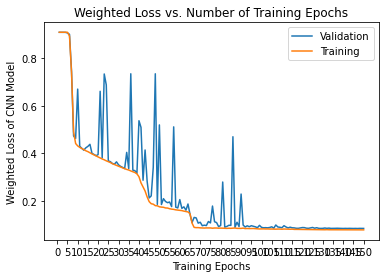

In [24]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import copy

for runs in range (0,5):
    print("Fold-",str(runs),": Initializing Datasets and Dataloaders...")
    #Kfold
    trainpath =[X[i] for i in trainindex[runs]]
    testpath =[X[i] for i in testindex[runs]]
    image_datasets = {}
#     image_datasets['train'] = MyDataset(trainpath[0:3000])
#     image_datasets['val'] = MyDataset(testpath[0:600])
    image_datasets['train'] = MyDataset(trainpath)
    image_datasets['val'] = MyDataset(testpath)

    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=0) for x in ['train', 'val']}

    # Detect if we have a GPU available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    out_channel = 3
    in_channel = 1
    num_epochs = 150
    loss_hist_train = []
    while (len(loss_hist_train)<num_epochs/2):
        model = UNetSmall(in_channel,out_channel)
        model.apply(init_weights)
        model = model.to(device)

        # freeze backbone layers
        # Comment out to finetune further
        # for l in model.base_layers:
        #     for param in l.parameters():
        #         param.requires_grad = False

        optimizer_ft1 = optim.Adam(model.parameters(), lr=5e-6,betas = (0.9, 0.999),eps=1e-08,weight_decay=0)
        optimizer_ft2 = optim.Adam(model.parameters(), lr=5e-4,betas = (0.9, 0.999),eps=1e-08,weight_decay=0)
        exp_lr_scheduler1 = lr_scheduler.ReduceLROnPlateau(optimizer_ft1, mode='min', factor=0.5, patience=8, verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=2, min_lr=2e-7, eps=1e-08)
        exp_lr_scheduler2 = lr_scheduler.ReduceLROnPlateau(optimizer_ft2, mode='min', factor=0.5, patience=8, verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=2, min_lr=2e-7, eps=1e-08)       
        model, loss_hist_train, loss_hist_val,lr_hist = train_model(model, dataloaders_dict,optimizer_ft1, optimizer_ft2, exp_lr_scheduler1,exp_lr_scheduler2, num_epochs)
        print('model training finished, reinitializing training....\n')
#         print("Fold-",str(runs),": Initializing Datasets and Dataloaders...")
        
    fname20 = "training_loss_"+str(runs)+".csv"
    np.savetxt(fname20,loss_hist_train , delimiter=",")
    fname21 = "validation_loss_"+str(runs)+".csv"
    np.savetxt(fname21,loss_hist_val , delimiter=",")
    fname22 = "learning_rate_"+str(runs)+".csv"
    np.savetxt(fname22,lr_hist , delimiter=",")
    
    shist = []
    shist1 = []
    train_loss = [h for h in loss_hist_train]
    val_loss = [h for h in loss_hist_val]
    plt.title("Weighted Loss vs. Number of Training Epochs")
    plt.xlabel("Training Epochs")
    plt.ylabel("Weighted Loss of CNN Model")
    plt.plot(range(1,len(val_loss)+1),val_loss[0:len(val_loss)],label="Validation")
    plt.plot(range(1,len(train_loss)+1),train_loss[0:len(train_loss)],label="Training")
    #     plt.ylim((0.5,1.05))
    plt.xticks(np.arange(0, len(val_loss)+5, 5.0))
    plt.legend()
    fname31 = 'loss_curve_'+str(runs)+'.png'
    plt.savefig(fname31)
    plt.show()
    fname6 = 'cellSegmentationmodel-UNetSmall_rech_Run_'+str(runs)+'.pth.tar'

    torch.save(model,fname6)
    print('\n\n')

In [25]:
def SegmentationVisualGT(mask,image,ImgIdx):
    cmap = colors.ListedColormap(['black', 'lightblue', 'green', 'tomato'])
    boundaries = [-0.5, 0.5, 1.5, 2.5, 3.5]
    norm = colors.BoundaryNorm(boundaries, cmap.N, clip=True)
#     print(mask.shape)
#     tempimage = np.squeeze(image)
#     tempimage[tempimage>0] = 1
#     mask2 = tempimage
    mask2 = mask[2] 
    mask1 = mask[1]
    mask0 = mask[0]
    MaskOverlay = mask0 + mask1 + mask2
#     print('MaskOverlay shape:', MaskOverlay.shape)
    # mask = np.transpose(ImgMask.numpy(), (1,2,0))
    # image = np.squeeze(image)
    # mask = ImgMask.numpy()
    # print(mask[:,0,0].sum())
#     print(mask.shape)
    # Imgmask= np.transpose(mask,(1,2,0))
    fig = plt.figure(figsize=(12, 60), dpi=100)
    plt.subplot(1, 4, 1)
    plt.imshow(MaskOverlay,cmap=cmap,norm=norm)
    plt.title('GT segmentation overlay ' + str(ImgIdx),fontsize=8)
    plt.subplot(1, 4, 2)
    plt.imshow(mask0*3,cmap=cmap,norm=norm)
    # tempmask = mask[0]
    # tempmask[tempmask < 3] = 0
    # mask[0] = tempmask
    plt.title('GT chromosome region ' + str(ImgIdx),fontsize=8)
    plt.subplot(1, 4, 3)
    plt.imshow(mask1*2,cmap=cmap,norm=norm)
    plt.title('GT nucleus region ' + str(ImgIdx),fontsize=8)
    plt.subplot(1, 4, 4)
    plt.imshow(mask2,cmap=cmap,norm=norm)
    plt.title('GT cell contour ' + str(ImgIdx),fontsize=8)
    plt.show()

#     import matplotlib as mpl
# #     fig = plt.figure(figsize=(30, 1), dpi=100)
#     fig, ax = plt.subplots(figsize=(30, 1))
#     fig.subplots_adjust(bottom=0.4,left=0.7)

#     cmap = mpl.colors.ListedColormap(['black', 'lightblue', 'green', 'tomato'])
#     cmap.set_over('0.9')
#     cmap.set_under('0.75')

#     bounds = [0, 1, 2, 3, 4]
#     norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
#     cb2 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
#                                     norm=norm,
#                                     boundaries=[0] + bounds + [13],
#                                     extend='both',
#                                     ticks=bounds,
#                                     spacing='proportional',
#                                     orientation='horizontal')
#     cb2.set_label('Segmentation Label Intervals')
#     plt.show()

In [26]:
def SegmentationVisualPred(maskpred,imagepred,ImgIdx):
    cmap = colors.ListedColormap(['black', 'lightblue', 'green', 'tomato'])
    boundaries = [-0.5, 0.5, 1.5, 2.5, 3.5]
    norm = colors.BoundaryNorm(boundaries, cmap.N, clip=True)

#     print(mask.shape)
#     tempimage = np.squeeze(imagepred)
#     tempimage[tempimage>0] = 1
#     mask2 = tempimage
    mask2 = maskpred[2] 
    mask1 = maskpred[1]
    mask0 = maskpred[0]
    MaskOverlay = mask0 + mask1 + mask2
#     print('MaskOverlay shape:', MaskOverlay.shape)
    # mask = np.transpose(ImgMask.numpy(), (1,2,0))
    # image = np.squeeze(image)
    # mask = ImgMask.numpy()
    # print(mask[:,0,0].sum())
#     print(mask.shape)
    # Imgmask= np.transpose(mask,(1,2,0))
    fig = plt.figure(figsize=(12, 60), dpi=100)
    plt.subplot(1, 4, 1)
    plt.imshow(MaskOverlay,cmap=cmap,norm=norm)
    plt.title('Pred segmentation overlay ' + str(ImgIdx),fontsize=10)
    plt.subplot(1, 4, 2)
    plt.imshow(mask0*3,cmap=cmap,norm=norm)
    # tempmask = mask[0]
    # tempmask[tempmask < 3] = 0
    # mask[0] = tempmask
    plt.title('Pred chromosome region ' + str(ImgIdx),fontsize=10)
    plt.subplot(1, 4, 3)
    plt.imshow(mask1*2,cmap=cmap,norm=norm)
    plt.title('Pred nucleus region ' + str(ImgIdx),fontsize=10)
    plt.subplot(1, 4, 4)
    plt.imshow(mask2,cmap=cmap,norm=norm)
    plt.title('Pred cell contour ' + str(ImgIdx),fontsize=10)
    plt.show()

    import matplotlib as mpl
#     fig = plt.figure(figsize=(30, 1), dpi=100)
    fig, ax = plt.subplots(figsize=(30, 1))
    fig.subplots_adjust(bottom=0.4,left=0.7)

    cmap = mpl.colors.ListedColormap(['black', 'lightblue', 'green', 'tomato'])
    cmap.set_over('0.9')
    cmap.set_under('0.75')

    bounds = [0, 1, 2, 3, 4]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    cb2 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                    norm=norm,
                                    boundaries=[0] + bounds + [13],
                                    extend='both',
                                    ticks=bounds,
                                    spacing='proportional',
                                    orientation='horizontal')
    cb2.set_label('Segmentation Label Intervals')
    plt.show()

In [27]:
def clac_F1 (mask, maskpred): 
    maskbool = mask.astype(dtype=bool)
    maskpredbool = maskpred.astype(dtype=bool)
    intersection = np.zeros((maskbool.shape[0],))
    Precision = np.zeros((maskbool.shape[0],))
    Recall = np.zeros((maskbool.shape[0],))
    F1score = np.zeros((maskbool.shape[0],))
    for i in range (0,maskpredbool.shape[0]):
        intersection[i] = np.sum(np.logical_and(maskbool[i,:,:], maskpredbool[i,:,:]))
        Precision[i] = np.sum(intersection[i]) / np.sum(maskpredbool[i])
        if np.sum(maskbool[i]) == 0:
            Recall[i] = 0
        else:
            Recall[i] = np.sum(intersection[i]) / np.sum(maskbool[i])
        if (Precision[i] + Recall[i]) == 0:
            F1score[i] = 0
        else:
            F1score[i] = ((Precision[i] * Recall[i]) / (Precision[i] + Recall[i]))*2
    
    return Precision, Recall, F1score

In [28]:
import pandas as pd

df = pd.read_csv (r'training_loss_0.csv',header=None)
TrainLoss0 = df.to_numpy()
df = pd.read_csv (r'training_loss_1.csv',header=None)
TrainLoss1 = df.to_numpy()
df = pd.read_csv (r'training_loss_2.csv',header=None)
TrainLoss2 = df.to_numpy()
df = pd.read_csv (r'training_loss_3.csv',header=None)
TrainLoss3 = df.to_numpy()
df = pd.read_csv (r'./training_loss_4.csv',header=None)
TrainLoss4 = df.to_numpy()

df = pd.read_csv (r'validation_loss_0.csv',header=None)
ValLoss0 = df.to_numpy()
df = pd.read_csv (r'validation_loss_1.csv',header=None)
ValLoss1 = df.to_numpy()
df = pd.read_csv (r'validation_loss_2.csv',header=None)
ValLoss2 = df.to_numpy()
df = pd.read_csv (r'validation_loss_3.csv',header=None)
ValLoss3 = df.to_numpy()
df = pd.read_csv (r'./validation_loss_4.csv',header=None)
ValLoss4 = df.to_numpy()

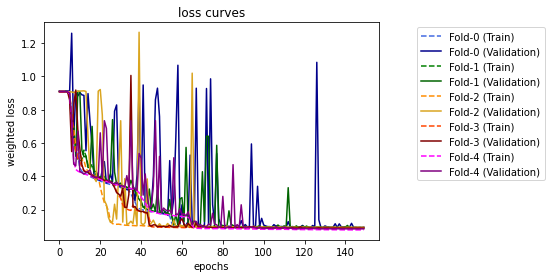

In [29]:
plt.figure()
plt.plot(TrainLoss0,label = 'Fold-0 (Train)', color='royalblue', linestyle = '--')
plt.plot(ValLoss0,label = 'Fold-0 (Validation)', color='darkblue', linestyle = '-')
plt.plot(TrainLoss1,label = 'Fold-1 (Train)', color='green', linestyle = '--')
plt.plot(ValLoss1,label = 'Fold-1 (Validation)', color='darkgreen', linestyle = '-')
plt.plot(TrainLoss2,label = 'Fold-2 (Train)', color='darkorange', linestyle = '--')
plt.plot(ValLoss2,label = 'Fold-2 (Validation)', color='goldenrod', linestyle = '-')
plt.plot(TrainLoss3,label = 'Fold-3 (Train)', color='orangered', linestyle = '--')
plt.plot(ValLoss3,label = 'Fold-3 (Validation)', color='maroon', linestyle = '-')
plt.plot(TrainLoss4,label = 'Fold-4 (Train)', color='magenta', linestyle = '--')
plt.plot(ValLoss4,label = 'Fold-4 (Validation)', color='purple', linestyle = '-')
plt.title('loss curves')
plt.xlabel('epochs')
plt.ylabel('weighted loss')
plt.legend(bbox_to_anchor=(1.1, 1))
plt.show()

In [30]:
df = pd.read_csv (r'./learning_rate_0.csv',header=None)
LearnRate0 = df.to_numpy()
df = pd.read_csv (r'./learning_rate_1.csv',header=None)
LearnRate1 = df.to_numpy()
df = pd.read_csv (r'./learning_rate_2.csv',header=None)
LearnRate2 = df.to_numpy()
df = pd.read_csv (r'./learning_rate_3.csv',header=None)
LearnRate3 = df.to_numpy()
df = pd.read_csv (r'./learning_rate_4.csv',header=None)
LearnRate4 = df.to_numpy()

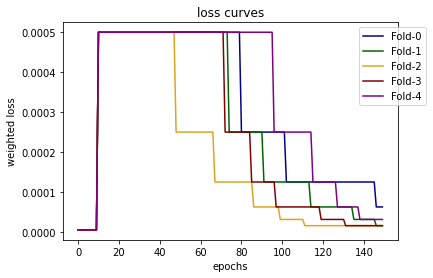

In [31]:
plt.figure()
plt.plot(LearnRate0,label = 'Fold-0', color='darkblue', linestyle = '-')
plt.plot(LearnRate1,label = 'Fold-1', color='darkgreen', linestyle = '-')
plt.plot(LearnRate2,label = 'Fold-2', color='goldenrod', linestyle = '-')
plt.plot(LearnRate3,label = 'Fold-3', color='maroon', linestyle = '-')
plt.plot(LearnRate4,label = 'Fold-4', color='purple', linestyle = '-')
plt.title('loss curves')
plt.xlabel('epochs')
plt.ylabel('weighted loss')
plt.legend(bbox_to_anchor=(1.1, 1))
plt.show()

Initializing Datasets and Dataloaders...


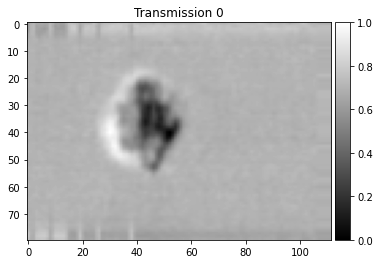

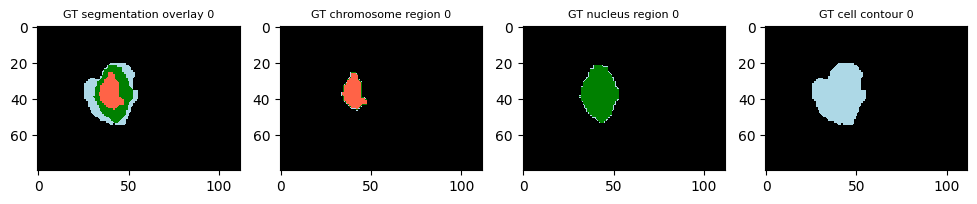

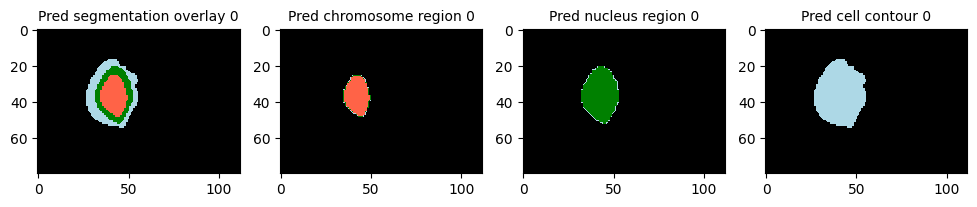

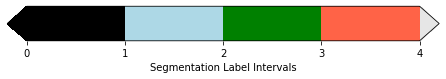

IoU score: 0.833, Chromesome F1score: 0.796, Nucleus F1score: 0.944, Cell F1score: 0.918, Chromesome precision: 0.675, Nucleus precision: 0.937, Cell precision: 0.873, Chromesome recall: 0.971, Nucleus recall: 0.951, Cell recall: 0.967


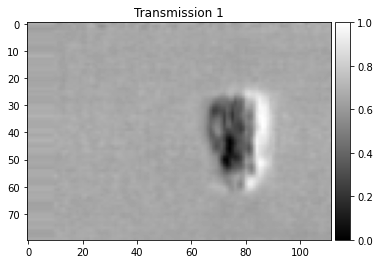

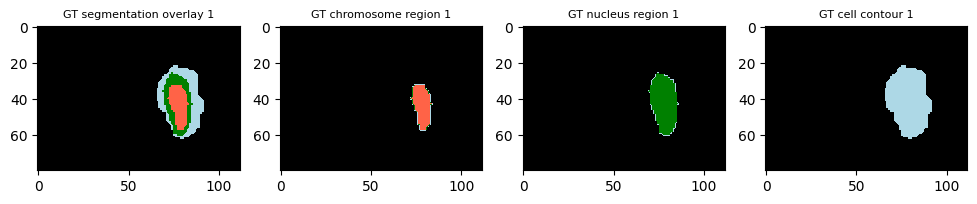

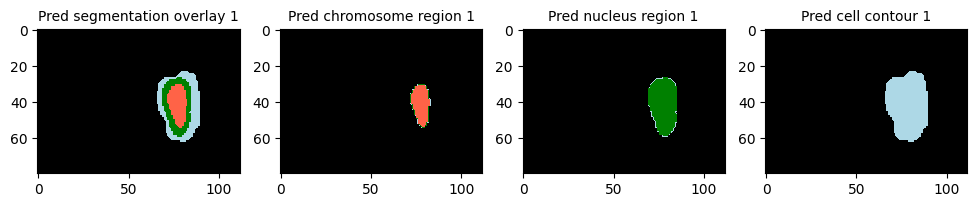

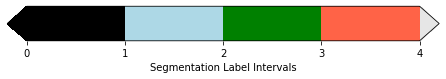

IoU score: 0.862, Chromesome F1score: 0.850, Nucleus F1score: 0.932, Cell F1score: 0.943, Chromesome precision: 0.872, Nucleus precision: 0.918, Cell precision: 0.954, Chromesome recall: 0.828, Nucleus recall: 0.946, Cell recall: 0.932


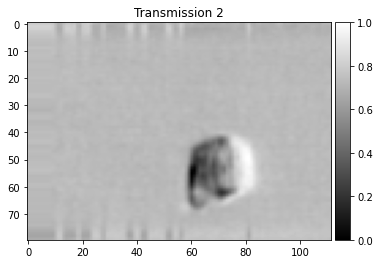

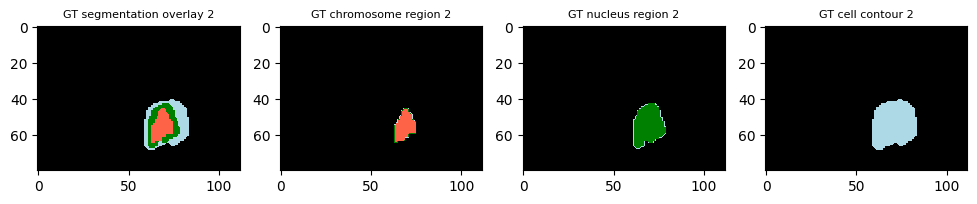

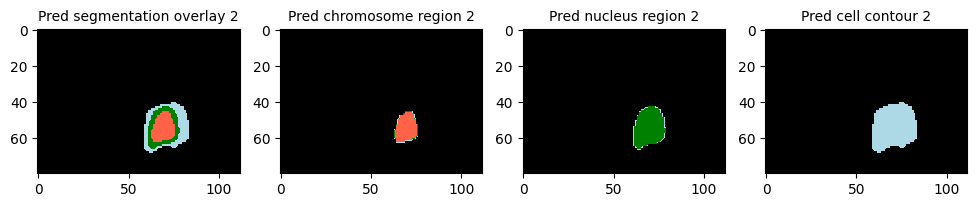

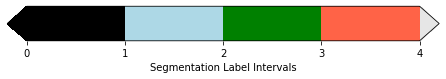

IoU score: 0.911, Chromesome F1score: 0.863, Nucleus F1score: 0.947, Cell F1score: 0.983, Chromesome precision: 0.818, Nucleus precision: 0.950, Cell precision: 0.996, Chromesome recall: 0.914, Nucleus recall: 0.944, Cell recall: 0.970


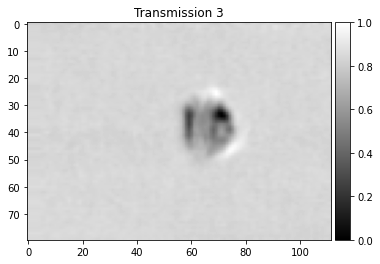

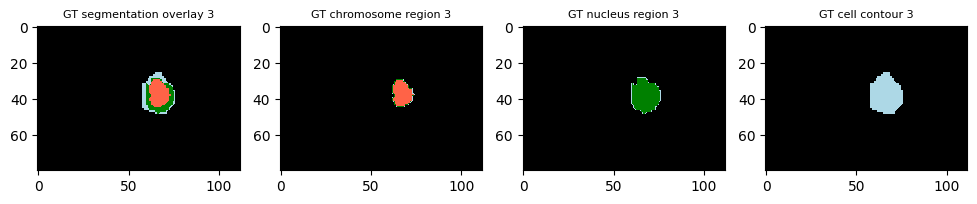

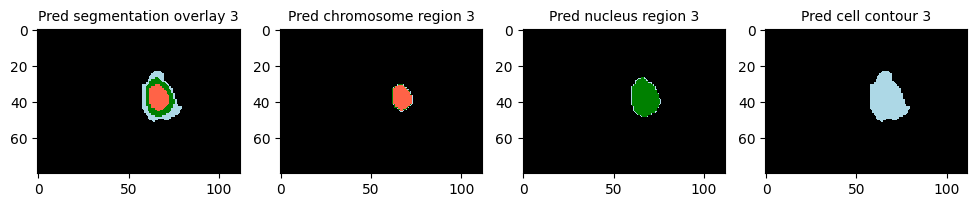

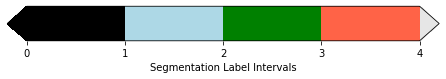

IoU score: 0.831, Chromesome F1score: 0.930, Nucleus F1score: 0.938, Cell F1score: 0.879, Chromesome precision: 0.960, Nucleus precision: 0.907, Cell precision: 0.786, Chromesome recall: 0.902, Nucleus recall: 0.971, Cell recall: 0.997


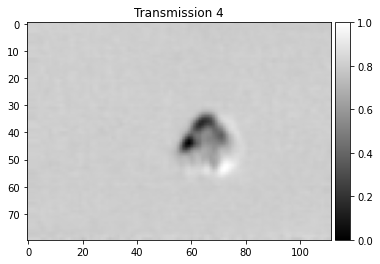

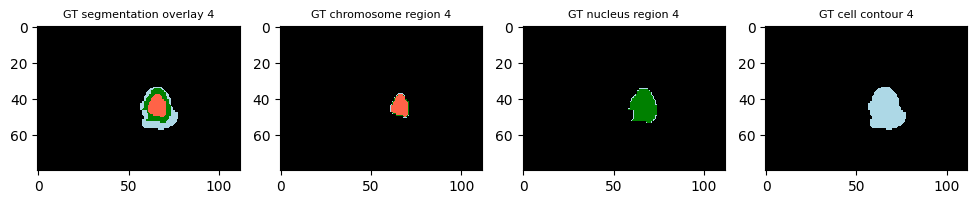

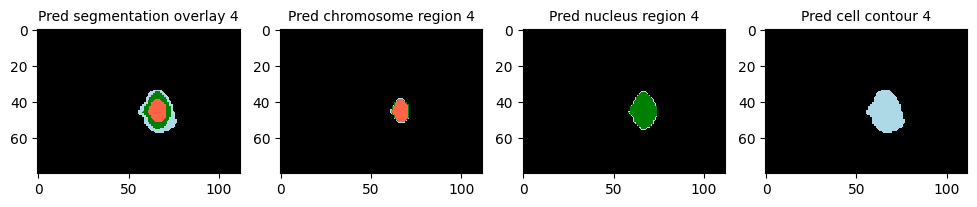

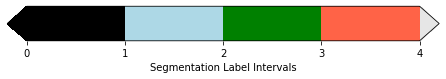

IoU score: 0.880, Chromesome F1score: 0.902, Nucleus F1score: 0.929, Cell F1score: 0.949, Chromesome precision: 0.906, Nucleus precision: 0.919, Cell precision: 0.971, Chromesome recall: 0.897, Nucleus recall: 0.940, Cell recall: 0.929


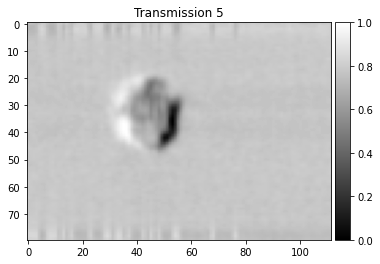

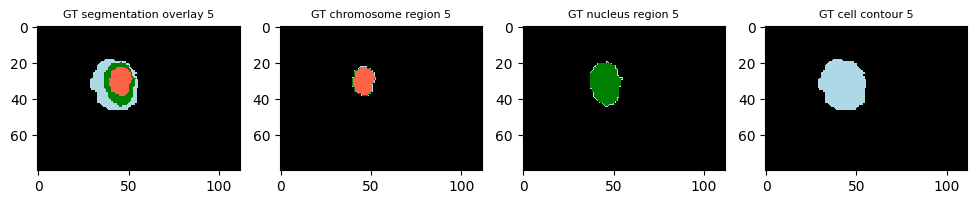

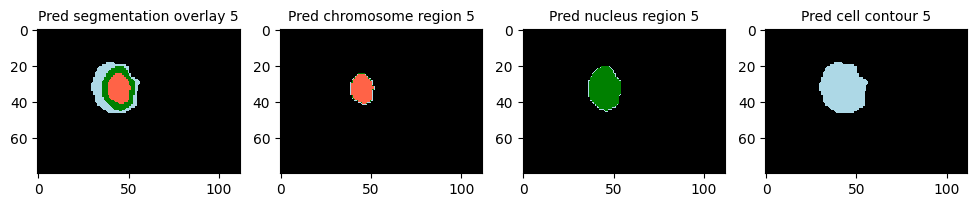

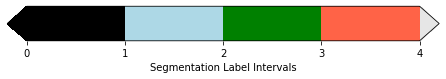

IoU score: 0.862, Chromesome F1score: 0.766, Nucleus F1score: 0.917, Cell F1score: 0.975, Chromesome precision: 0.737, Nucleus precision: 0.884, Cell precision: 0.983, Chromesome recall: 0.799, Nucleus recall: 0.953, Cell recall: 0.968


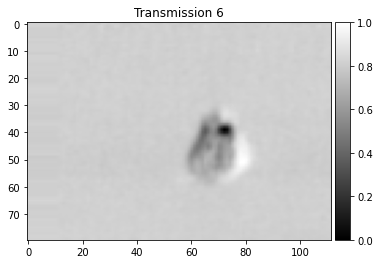

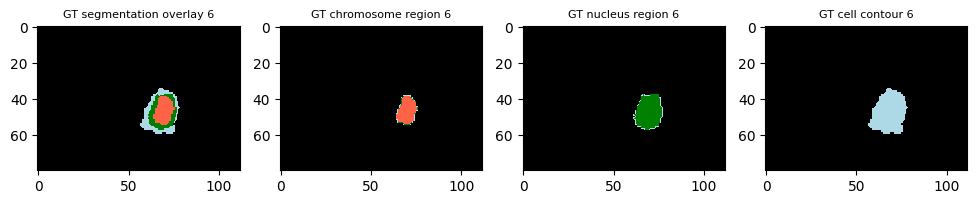

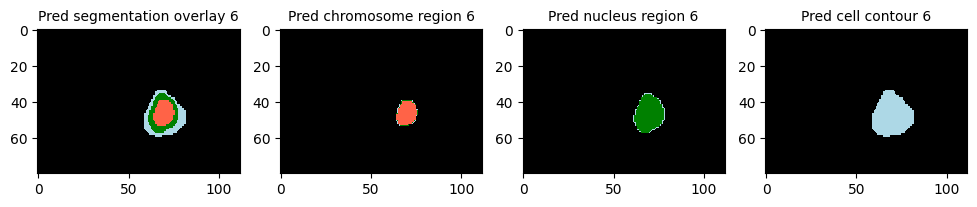

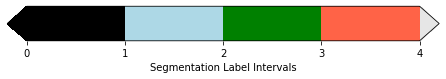

IoU score: 0.822, Chromesome F1score: 0.917, Nucleus F1score: 0.919, Cell F1score: 0.887, Chromesome precision: 0.931, Nucleus precision: 0.868, Cell precision: 0.832, Chromesome recall: 0.903, Nucleus recall: 0.975, Cell recall: 0.950


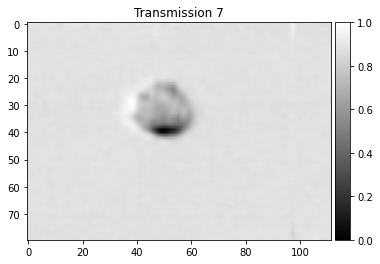

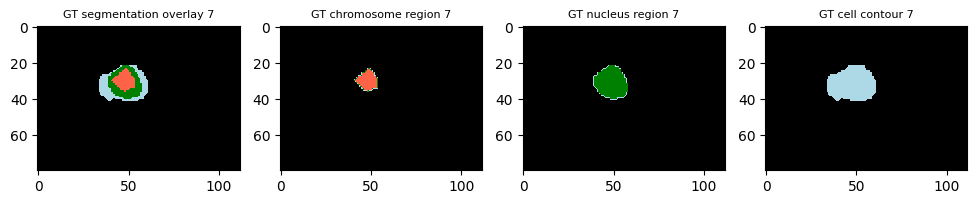

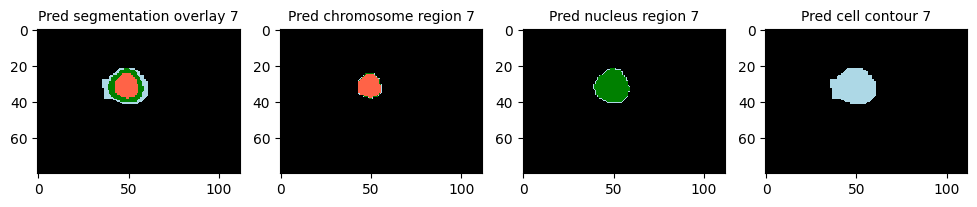

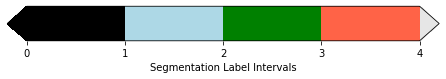

IoU score: 0.846, Chromesome F1score: 0.776, Nucleus F1score: 0.943, Cell F1score: 0.941, Chromesome precision: 0.669, Nucleus precision: 0.918, Cell precision: 0.985, Chromesome recall: 0.922, Nucleus recall: 0.970, Cell recall: 0.900


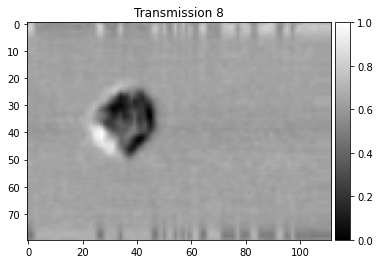

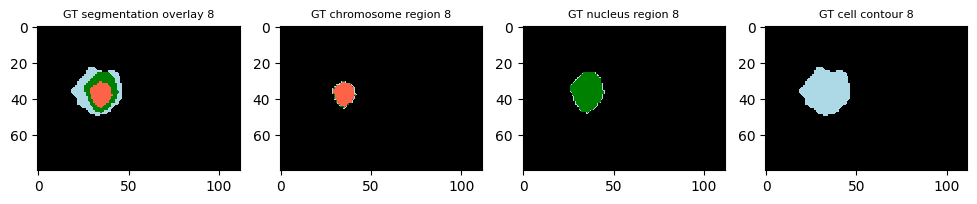

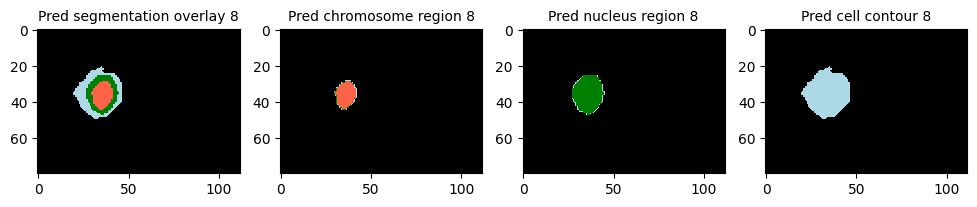

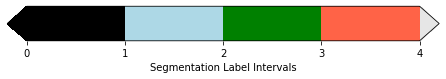

IoU score: 0.896, Chromesome F1score: 0.860, Nucleus F1score: 0.966, Cell F1score: 0.955, Chromesome precision: 0.826, Nucleus precision: 0.983, Cell precision: 0.964, Chromesome recall: 0.898, Nucleus recall: 0.950, Cell recall: 0.946


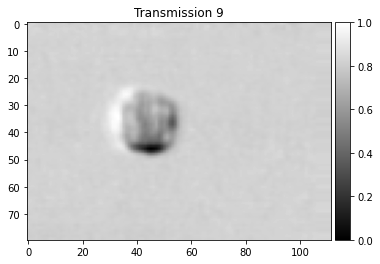

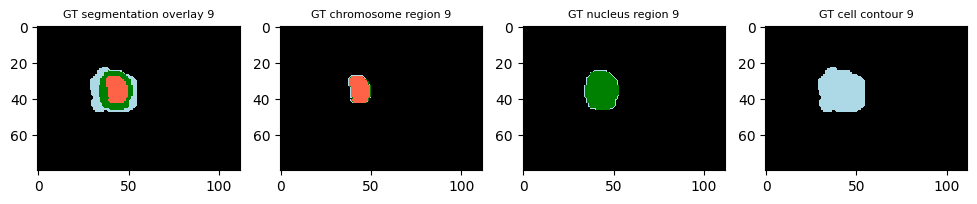

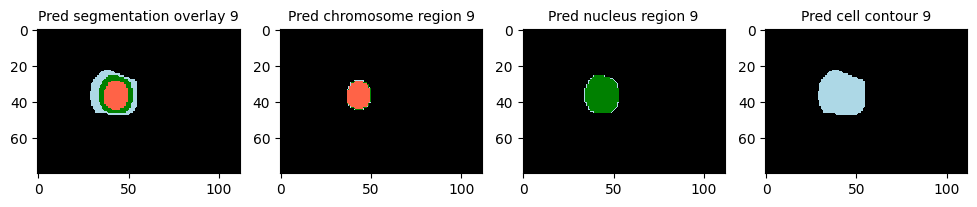

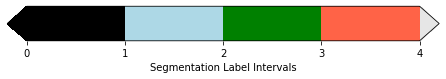

IoU score: 0.903, Chromesome F1score: 0.854, Nucleus F1score: 0.963, Cell F1score: 0.969, Chromesome precision: 0.800, Nucleus precision: 0.976, Cell precision: 0.976, Chromesome recall: 0.915, Nucleus recall: 0.950, Cell recall: 0.963


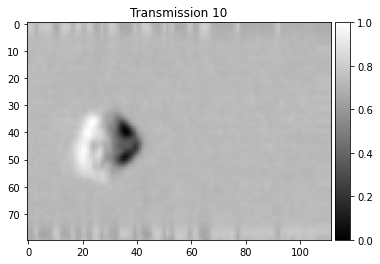

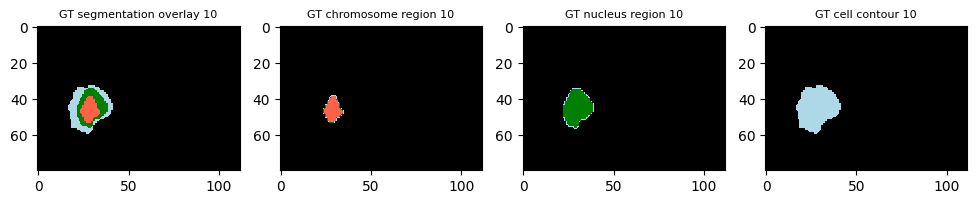

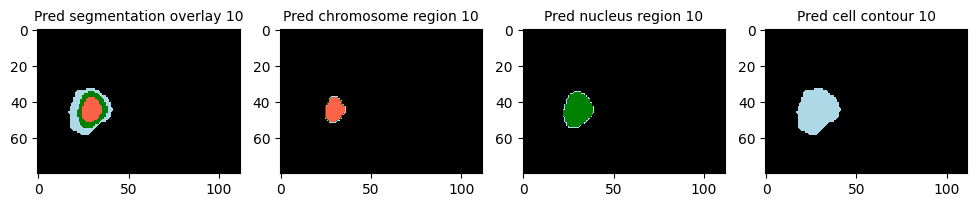

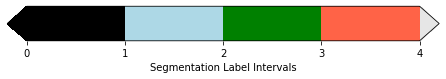

IoU score: 0.893, Chromesome F1score: 0.809, Nucleus F1score: 0.950, Cell F1score: 0.972, Chromesome precision: 0.761, Nucleus precision: 0.960, Cell precision: 0.971, Chromesome recall: 0.864, Nucleus recall: 0.941, Cell recall: 0.974


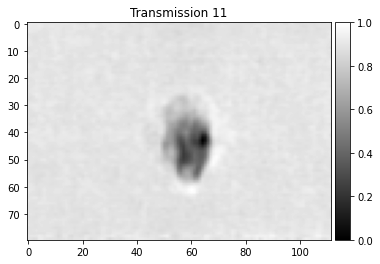

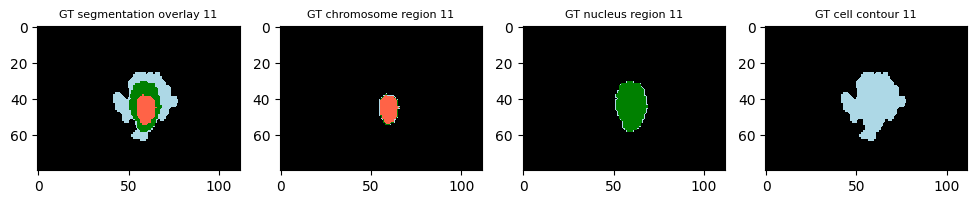

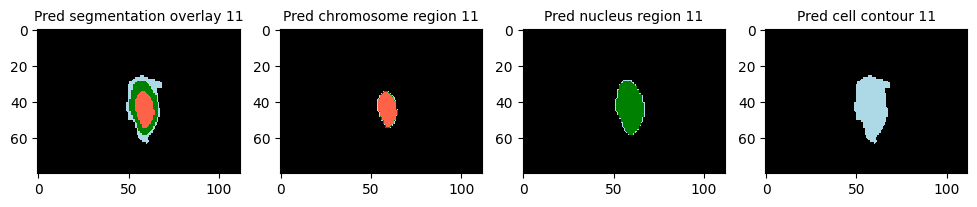

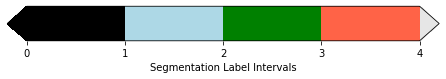

IoU score: 0.704, Chromesome F1score: 0.847, Nucleus F1score: 0.906, Cell F1score: 0.777, Chromesome precision: 0.796, Nucleus precision: 0.940, Cell precision: 0.982, Chromesome recall: 0.906, Nucleus recall: 0.875, Cell recall: 0.643


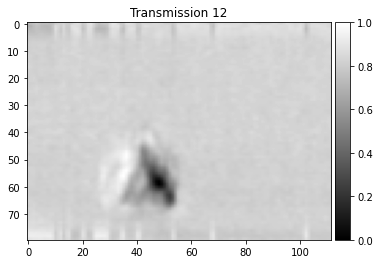

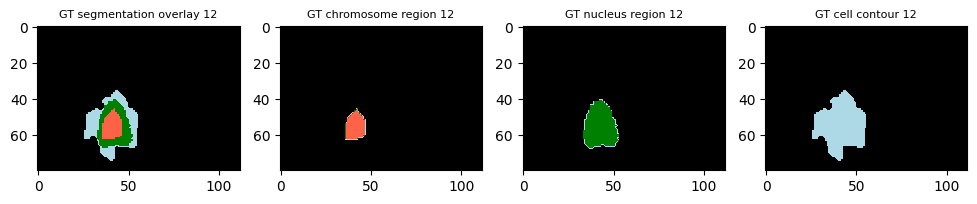

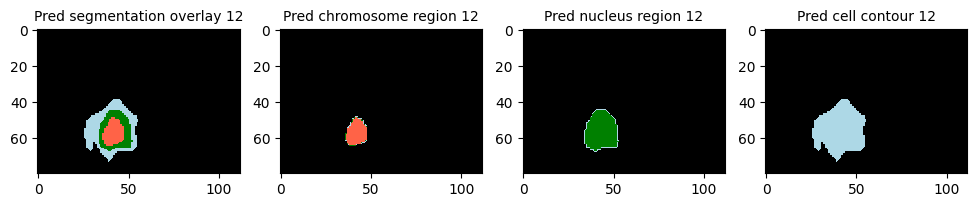

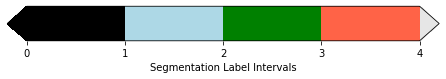

IoU score: 0.811, Chromesome F1score: 0.814, Nucleus F1score: 0.890, Cell F1score: 0.916, Chromesome precision: 0.823, Nucleus precision: 0.967, Cell precision: 0.940, Chromesome recall: 0.806, Nucleus recall: 0.825, Cell recall: 0.892


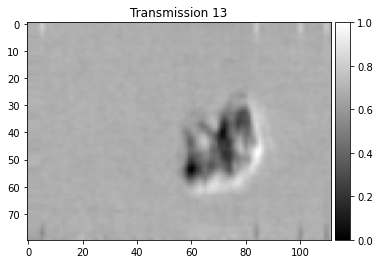

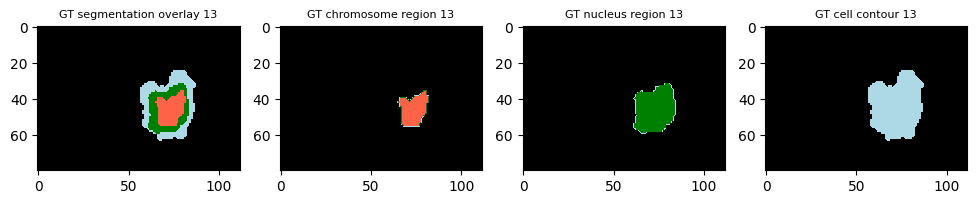

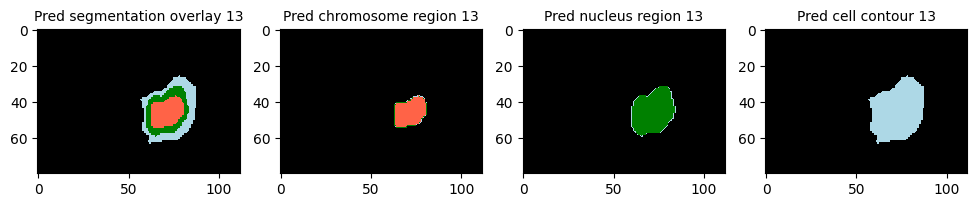

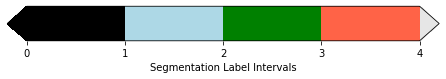

IoU score: 0.810, Chromesome F1score: 0.787, Nucleus F1score: 0.919, Cell F1score: 0.911, Chromesome precision: 0.755, Nucleus precision: 0.924, Cell precision: 0.943, Chromesome recall: 0.822, Nucleus recall: 0.915, Cell recall: 0.881


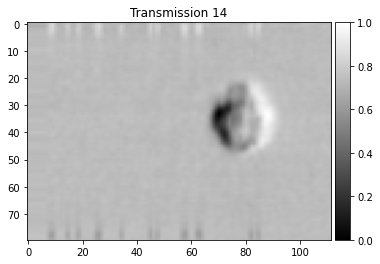

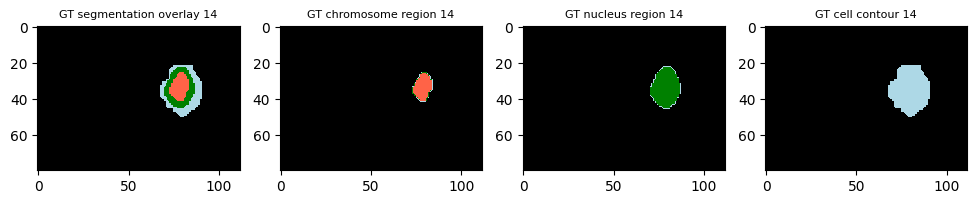

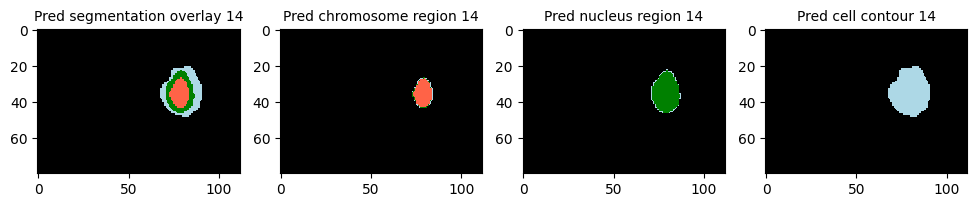

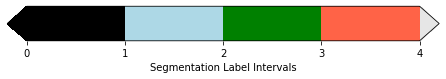

IoU score: 0.878, Chromesome F1score: 0.840, Nucleus F1score: 0.922, Cell F1score: 0.968, Chromesome precision: 0.812, Nucleus precision: 0.935, Cell precision: 0.975, Chromesome recall: 0.871, Nucleus recall: 0.909, Cell recall: 0.961


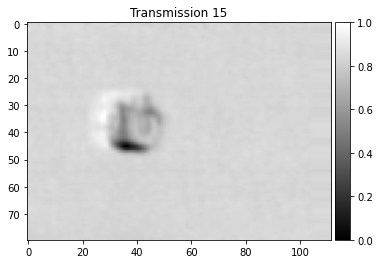

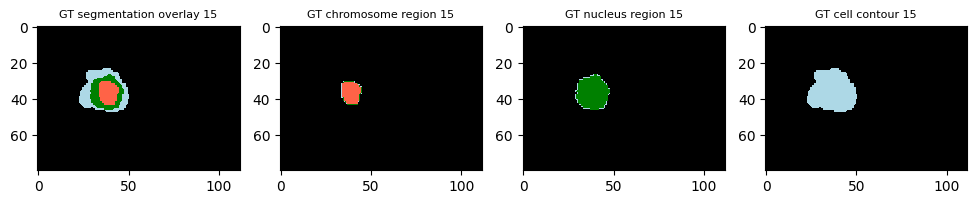

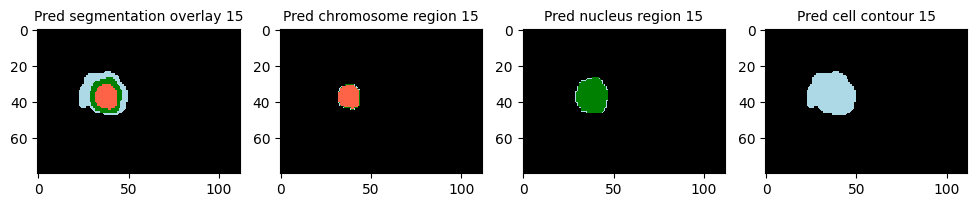

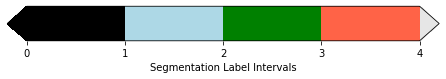

IoU score: 0.903, Chromesome F1score: 0.876, Nucleus F1score: 0.967, Cell F1score: 0.958, Chromesome precision: 0.819, Nucleus precision: 0.955, Cell precision: 0.955, Chromesome recall: 0.942, Nucleus recall: 0.979, Cell recall: 0.961


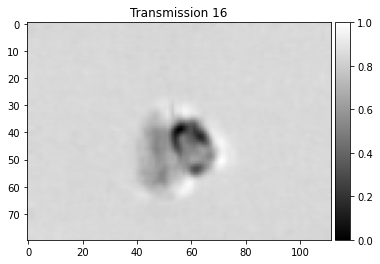

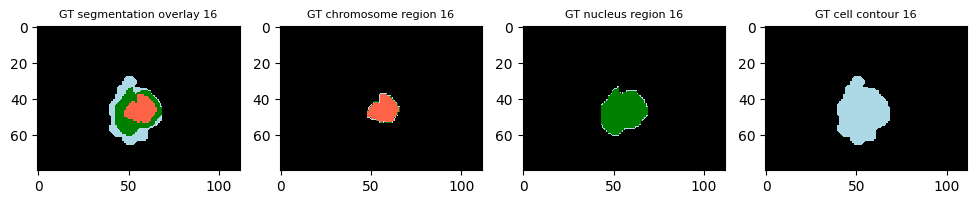

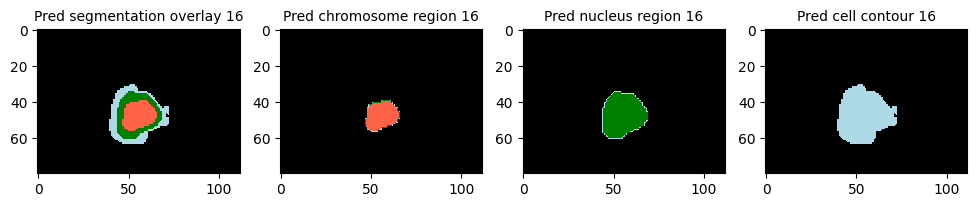

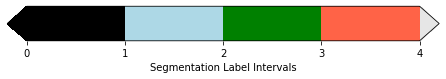

IoU score: 0.849, Chromesome F1score: 0.822, Nucleus F1score: 0.945, Cell F1score: 0.929, Chromesome precision: 0.744, Nucleus precision: 0.939, Cell precision: 0.924, Chromesome recall: 0.918, Nucleus recall: 0.951, Cell recall: 0.934


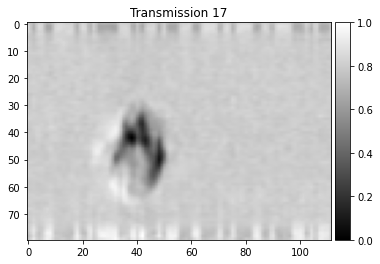

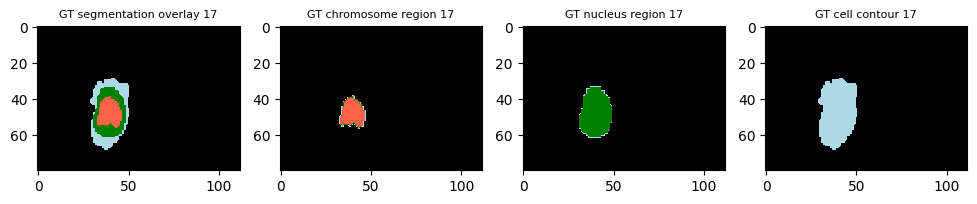

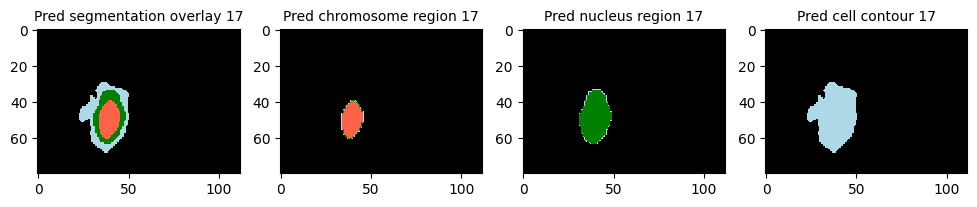

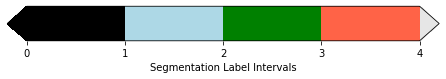

IoU score: 0.819, Chromesome F1score: 0.814, Nucleus F1score: 0.935, Cell F1score: 0.904, Chromesome precision: 0.793, Nucleus precision: 0.952, Cell precision: 0.880, Chromesome recall: 0.837, Nucleus recall: 0.919, Cell recall: 0.929


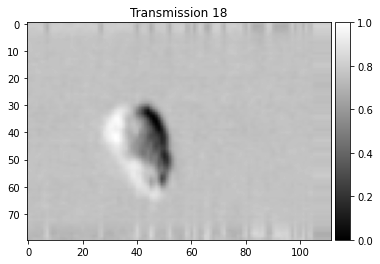

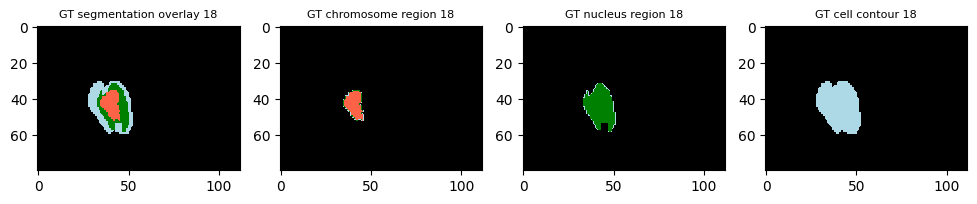

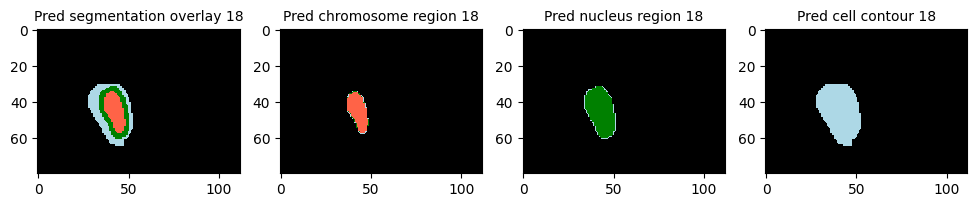

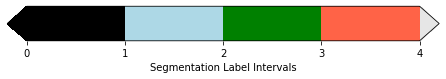

IoU score: 0.811, Chromesome F1score: 0.725, Nucleus F1score: 0.893, Cell F1score: 0.941, Chromesome precision: 0.617, Nucleus precision: 0.839, Cell precision: 0.899, Chromesome recall: 0.881, Nucleus recall: 0.955, Cell recall: 0.988


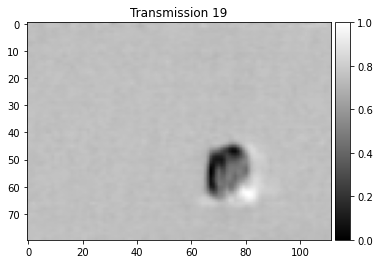

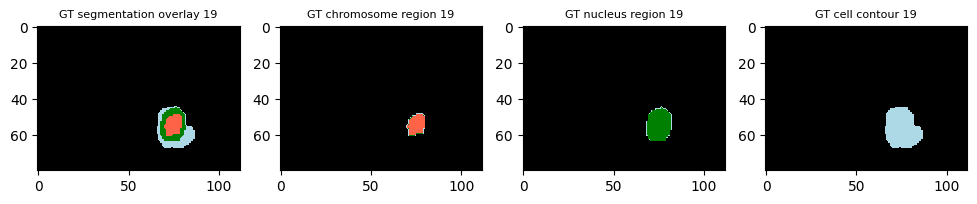

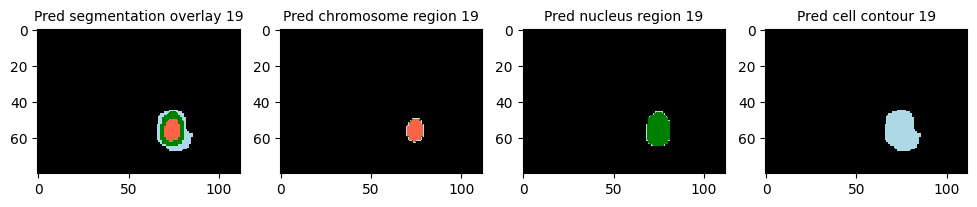

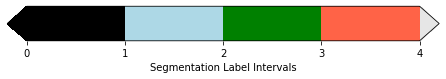

IoU score: 0.859, Chromesome F1score: 0.836, Nucleus F1score: 0.928, Cell F1score: 0.945, Chromesome precision: 0.832, Nucleus precision: 0.943, Cell precision: 0.974, Chromesome recall: 0.840, Nucleus recall: 0.913, Cell recall: 0.918
mean iou_score:  0.8602204630881698
mean precision chromesome:  0.8002939750996888
mean precision nucleus:  0.932881994650011
mean precision cell:  0.9460719414122085
mean recall chromesome:  0.8805459739121108
mean recall nucleus:  0.9371207594669543
mean recall cell:  0.9421622250629862
mean F1score chromesome:  0.832115048260386
mean F1score nucleus:  0.9335614373625076
mean F1score cell:  0.9427769882856636
Initializing Datasets and Dataloaders...


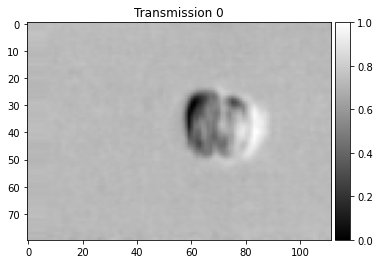

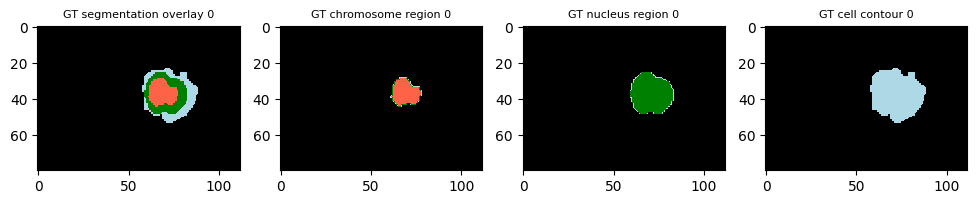

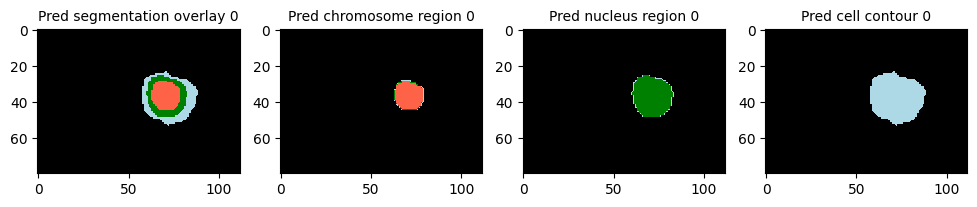

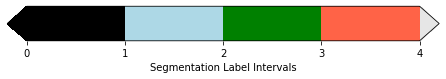

IoU score: 0.883, Chromesome F1score: 0.821, Nucleus F1score: 0.945, Cell F1score: 0.968, Chromesome precision: 0.771, Nucleus precision: 0.968, Cell precision: 0.970, Chromesome recall: 0.878, Nucleus recall: 0.923, Cell recall: 0.966


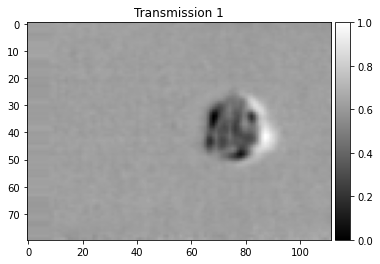

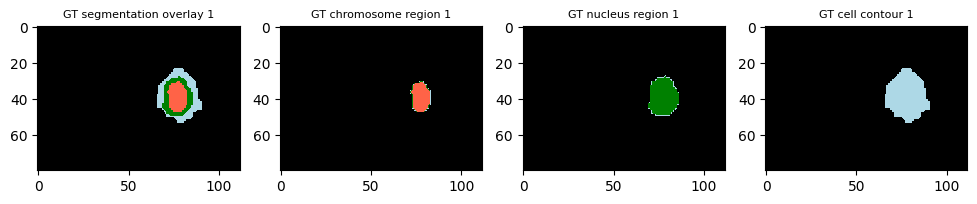

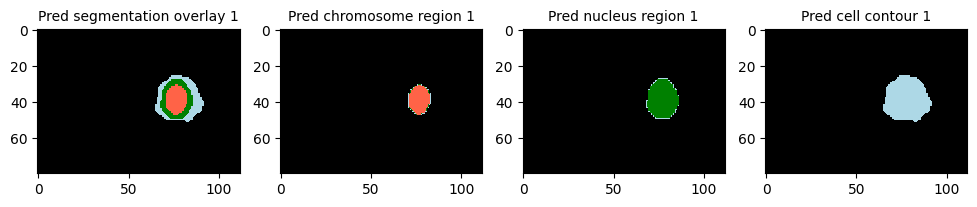

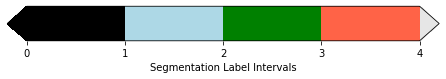

IoU score: 0.886, Chromesome F1score: 0.910, Nucleus F1score: 0.956, Cell F1score: 0.938, Chromesome precision: 0.878, Nucleus precision: 0.925, Cell precision: 0.938, Chromesome recall: 0.945, Nucleus recall: 0.990, Cell recall: 0.938


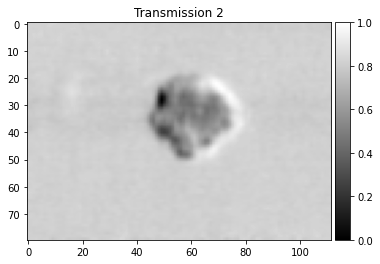

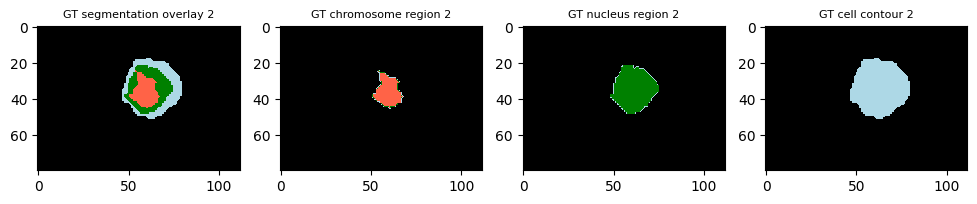

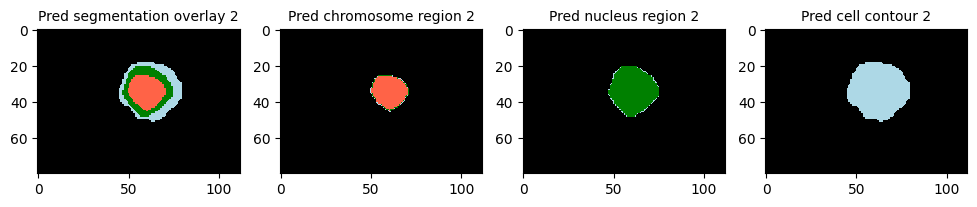

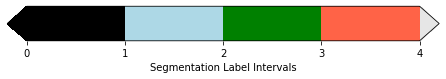

IoU score: 0.850, Chromesome F1score: 0.770, Nucleus F1score: 0.925, Cell F1score: 0.959, Chromesome precision: 0.650, Nucleus precision: 0.871, Cell precision: 0.939, Chromesome recall: 0.946, Nucleus recall: 0.988, Cell recall: 0.980


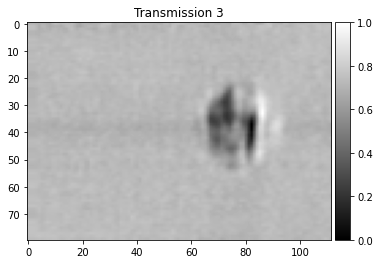

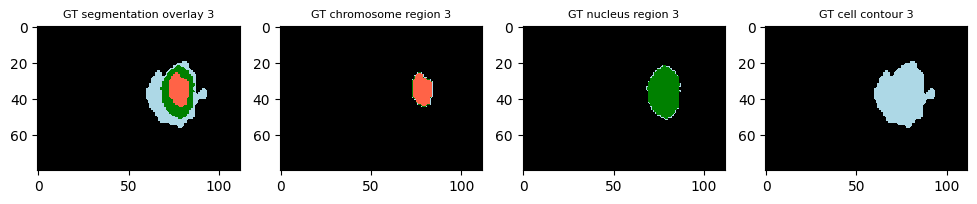

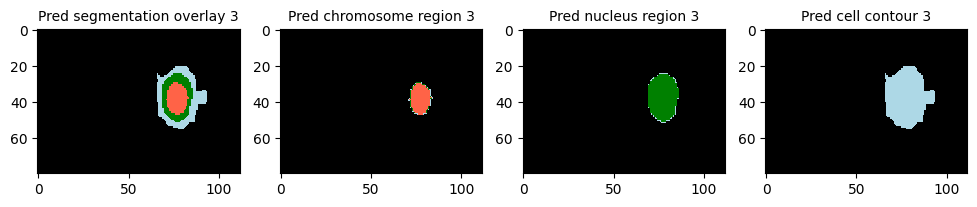

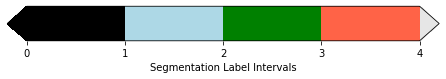

IoU score: 0.784, Chromesome F1score: 0.742, Nucleus F1score: 0.916, Cell F1score: 0.890, Chromesome precision: 0.738, Nucleus precision: 0.972, Cell precision: 0.959, Chromesome recall: 0.747, Nucleus recall: 0.865, Cell recall: 0.831


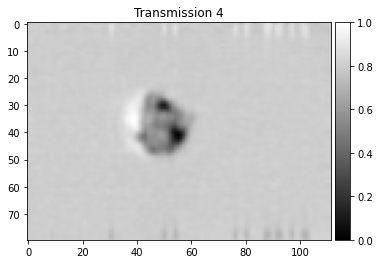

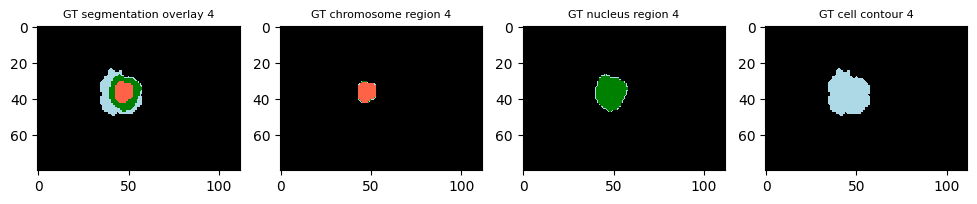

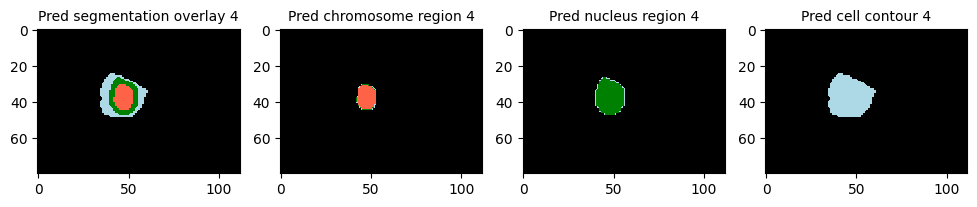

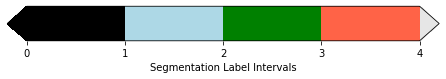

IoU score: 0.887, Chromesome F1score: 0.867, Nucleus F1score: 0.936, Cell F1score: 0.960, Chromesome precision: 0.778, Nucleus precision: 0.929, Cell precision: 0.947, Chromesome recall: 0.980, Nucleus recall: 0.943, Cell recall: 0.974


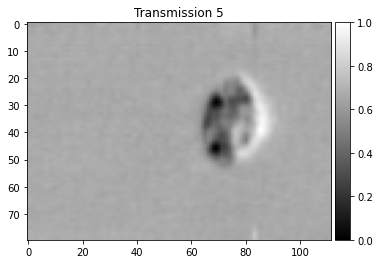

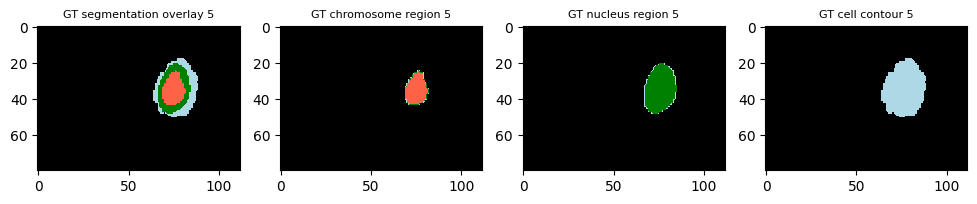

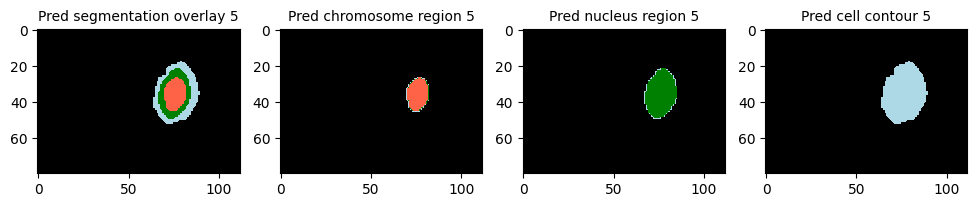

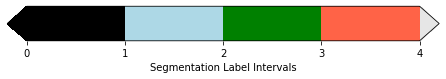

IoU score: 0.877, Chromesome F1score: 0.862, Nucleus F1score: 0.943, Cell F1score: 0.950, Chromesome precision: 0.860, Nucleus precision: 0.957, Cell precision: 0.917, Chromesome recall: 0.864, Nucleus recall: 0.929, Cell recall: 0.985


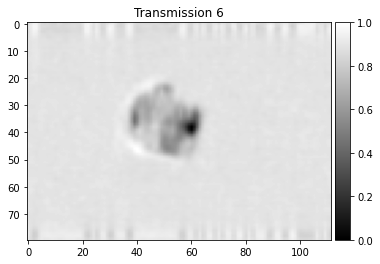

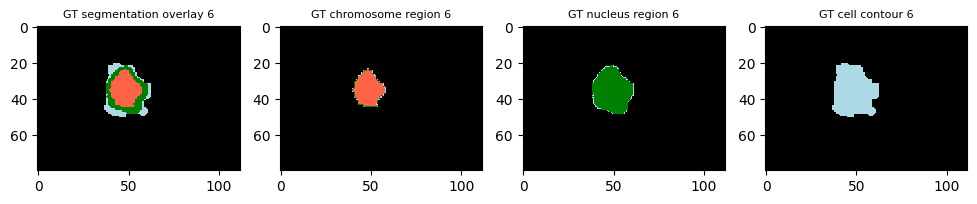

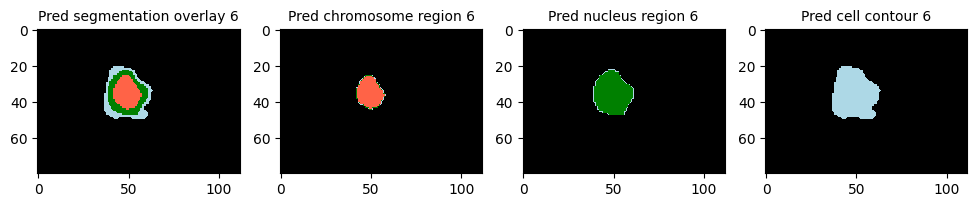

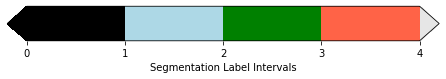

IoU score: 0.893, Chromesome F1score: 0.883, Nucleus F1score: 0.955, Cell F1score: 0.959, Chromesome precision: 0.971, Nucleus precision: 1.000, Cell precision: 0.948, Chromesome recall: 0.809, Nucleus recall: 0.914, Cell recall: 0.969


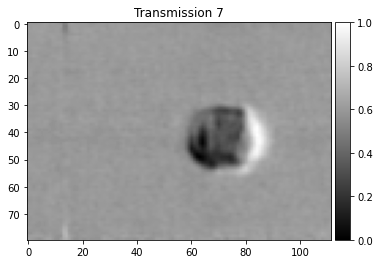

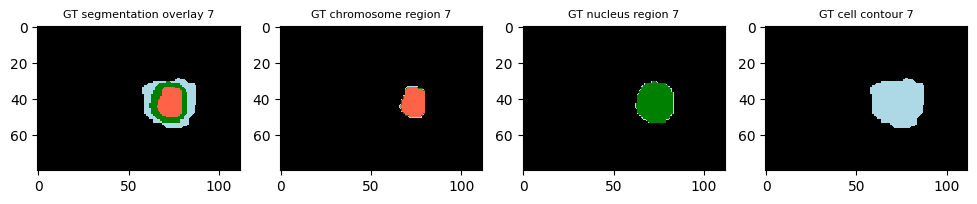

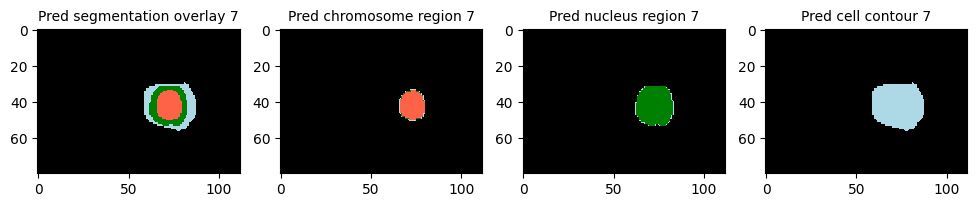

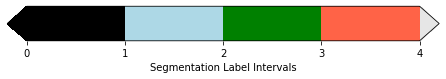

IoU score: 0.918, Chromesome F1score: 0.923, Nucleus F1score: 0.974, Cell F1score: 0.957, Chromesome precision: 0.927, Nucleus precision: 0.974, Cell precision: 0.987, Chromesome recall: 0.918, Nucleus recall: 0.974, Cell recall: 0.929


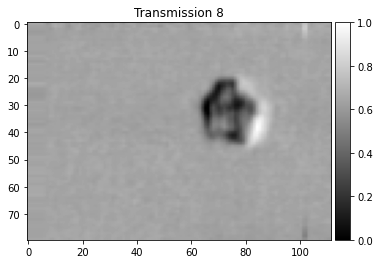

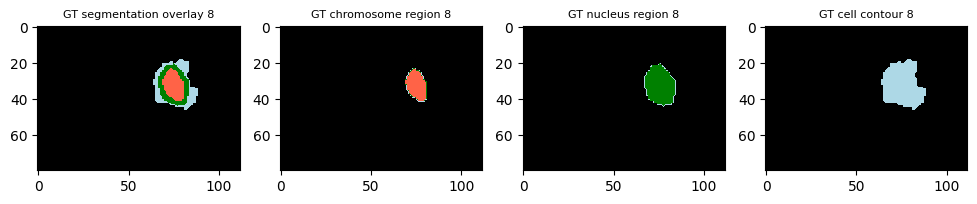

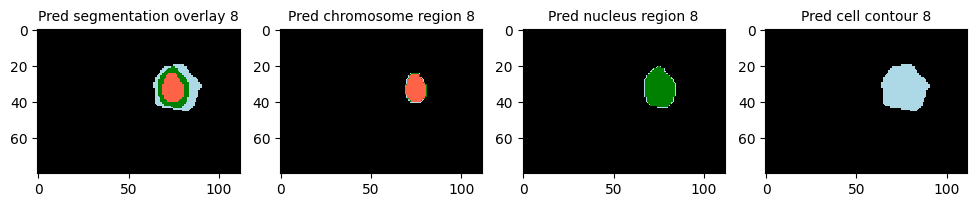

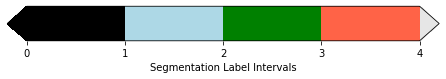

IoU score: 0.879, Chromesome F1score: 0.912, Nucleus F1score: 0.965, Cell F1score: 0.925, Chromesome precision: 0.915, Nucleus precision: 0.961, Cell precision: 0.892, Chromesome recall: 0.909, Nucleus recall: 0.970, Cell recall: 0.960


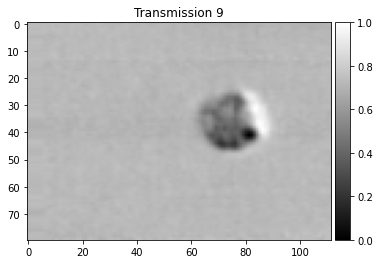

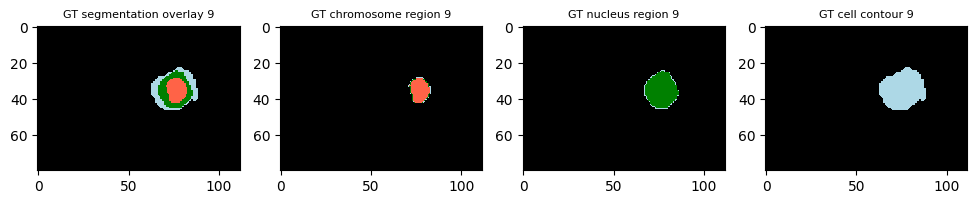

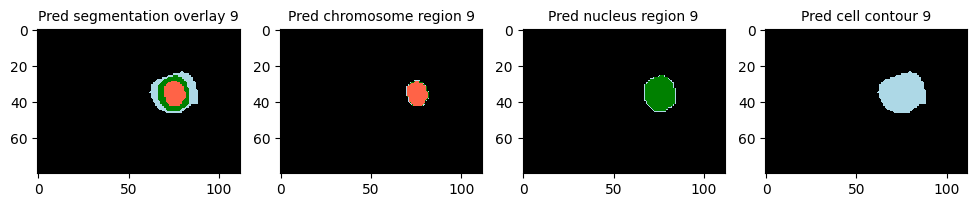

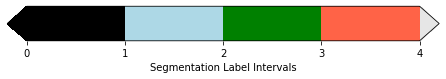

IoU score: 0.898, Chromesome F1score: 0.863, Nucleus F1score: 0.941, Cell F1score: 0.973, Chromesome precision: 0.833, Nucleus precision: 0.964, Cell precision: 0.963, Chromesome recall: 0.894, Nucleus recall: 0.920, Cell recall: 0.982


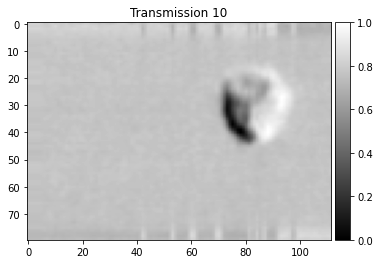

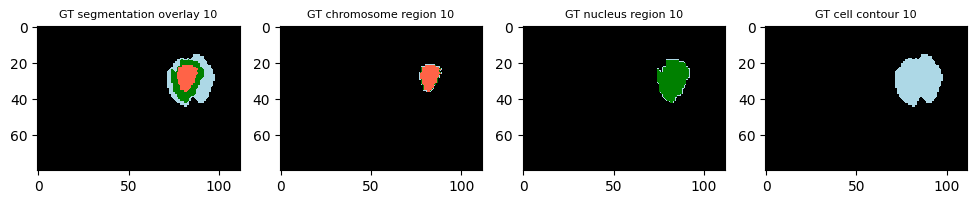

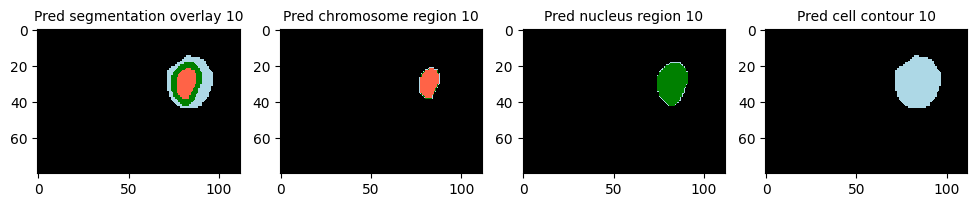

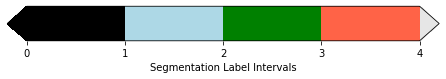

IoU score: 0.876, Chromesome F1score: 0.852, Nucleus F1score: 0.944, Cell F1score: 0.947, Chromesome precision: 0.799, Nucleus precision: 0.929, Cell precision: 0.930, Chromesome recall: 0.913, Nucleus recall: 0.960, Cell recall: 0.966


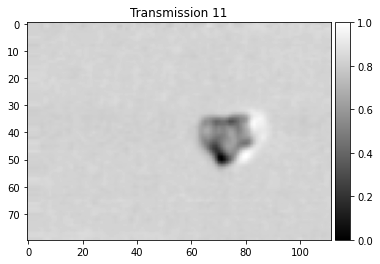

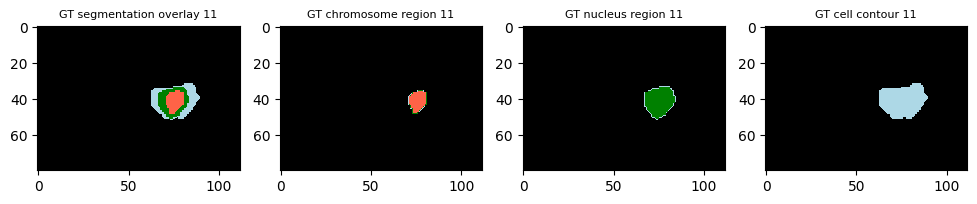

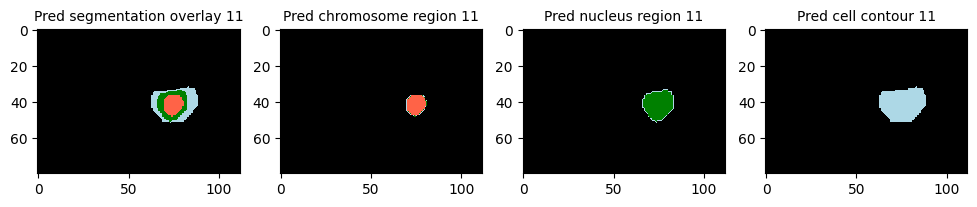

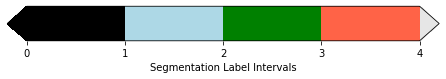

IoU score: 0.919, Chromesome F1score: 0.879, Nucleus F1score: 0.958, Cell F1score: 0.977, Chromesome precision: 0.861, Nucleus precision: 0.960, Cell precision: 0.975, Chromesome recall: 0.897, Nucleus recall: 0.956, Cell recall: 0.980


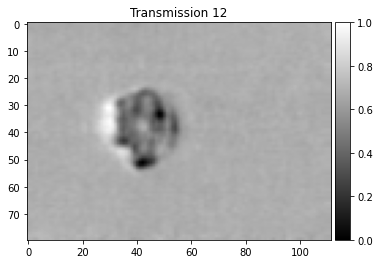

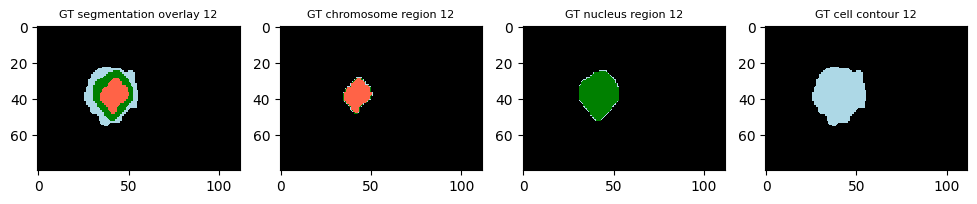

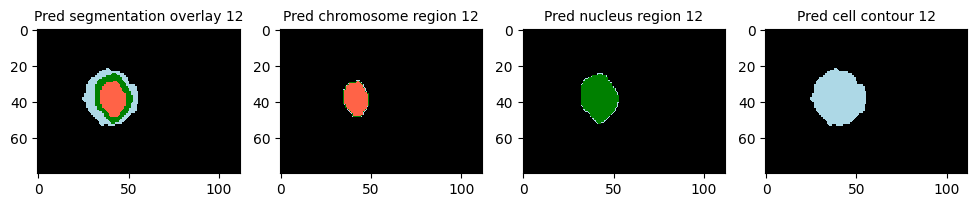

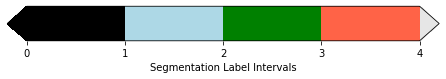

IoU score: 0.878, Chromesome F1score: 0.869, Nucleus F1score: 0.936, Cell F1score: 0.953, Chromesome precision: 0.834, Nucleus precision: 0.954, Cell precision: 0.963, Chromesome recall: 0.907, Nucleus recall: 0.919, Cell recall: 0.943


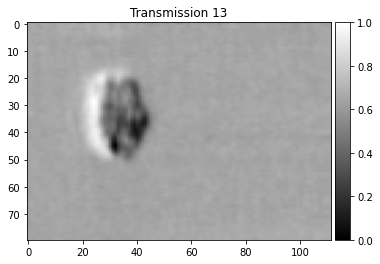

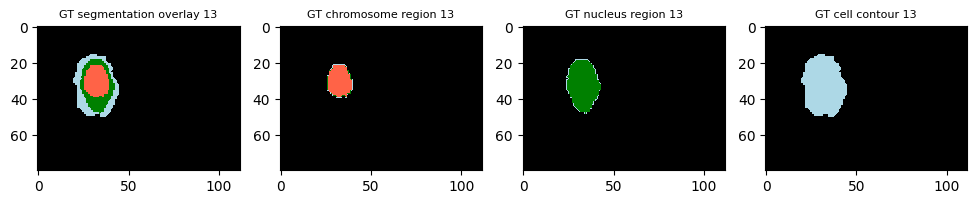

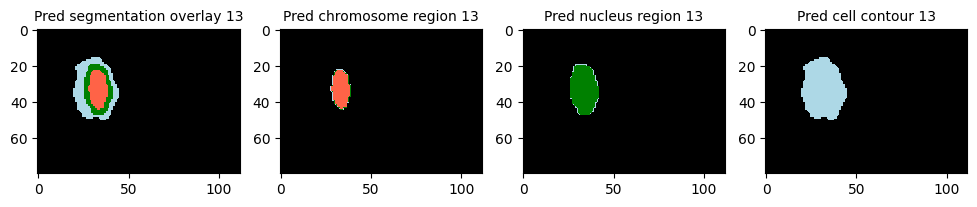

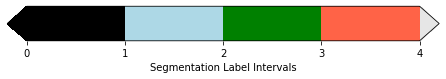

IoU score: 0.852, Chromesome F1score: 0.766, Nucleus F1score: 0.917, Cell F1score: 0.967, Chromesome precision: 0.812, Nucleus precision: 0.986, Cell precision: 0.967, Chromesome recall: 0.724, Nucleus recall: 0.857, Cell recall: 0.968


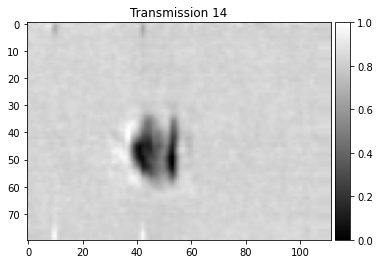

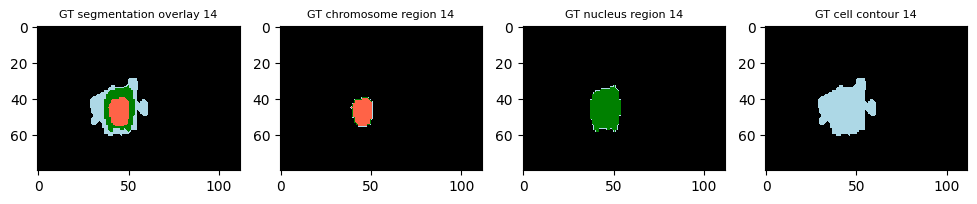

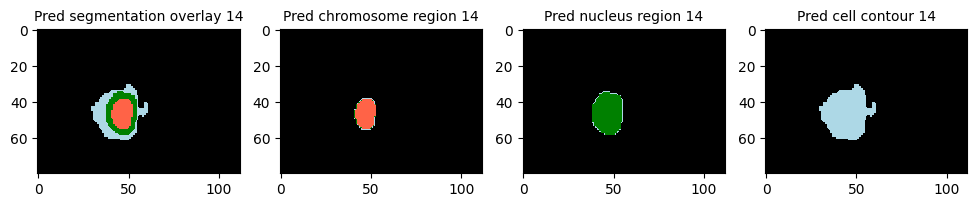

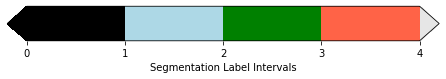

IoU score: 0.804, Chromesome F1score: 0.815, Nucleus F1score: 0.881, Cell F1score: 0.916, Chromesome precision: 0.783, Nucleus precision: 0.899, Cell precision: 0.942, Chromesome recall: 0.850, Nucleus recall: 0.864, Cell recall: 0.891


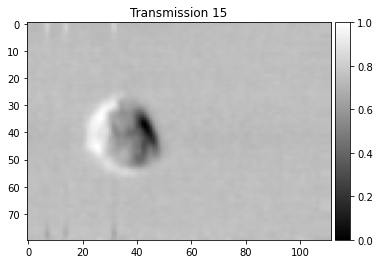

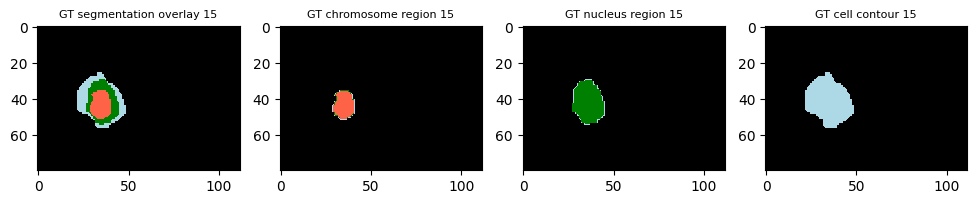

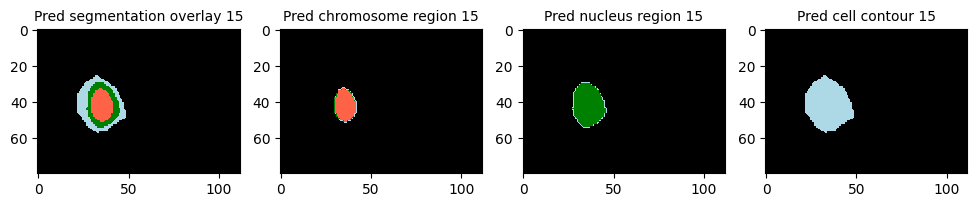

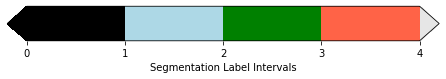

IoU score: 0.888, Chromesome F1score: 0.866, Nucleus F1score: 0.959, Cell F1score: 0.952, Chromesome precision: 0.811, Nucleus precision: 0.950, Cell precision: 0.924, Chromesome recall: 0.928, Nucleus recall: 0.967, Cell recall: 0.980


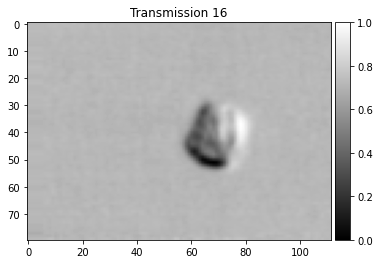

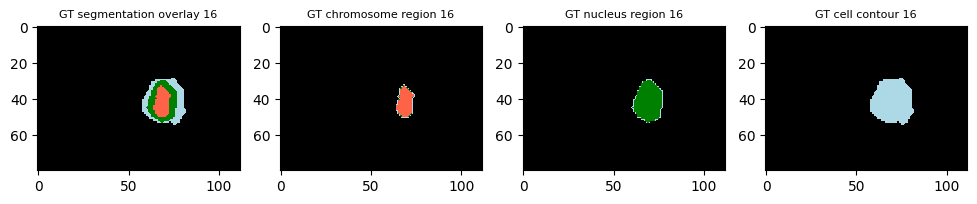

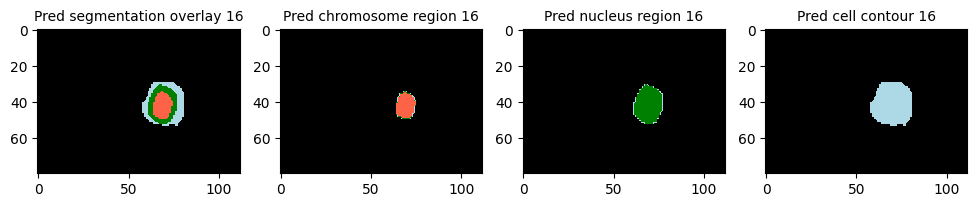

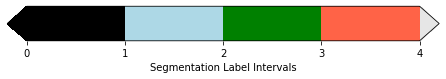

IoU score: 0.921, Chromesome F1score: 0.888, Nucleus F1score: 0.964, Cell F1score: 0.974, Chromesome precision: 0.874, Nucleus precision: 0.996, Cell precision: 0.991, Chromesome recall: 0.902, Nucleus recall: 0.934, Cell recall: 0.958


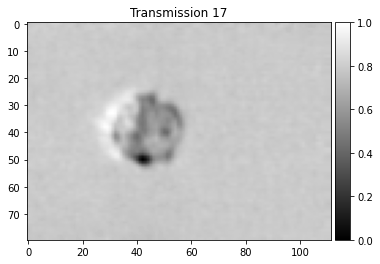

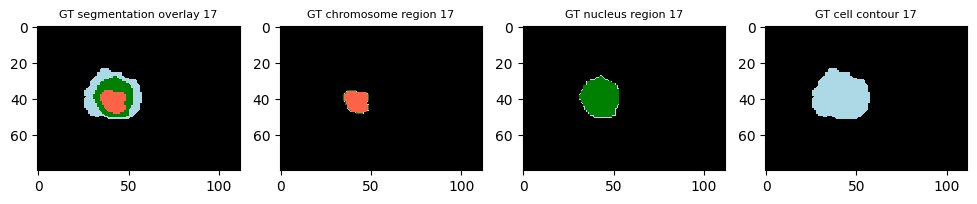

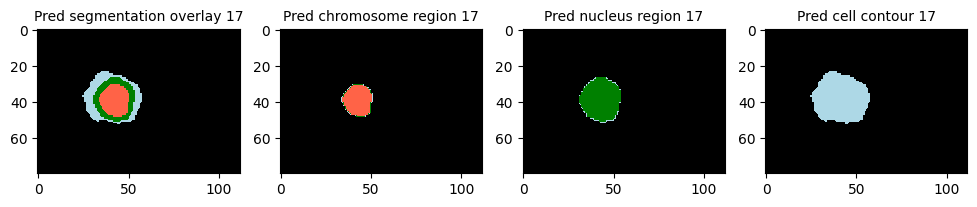

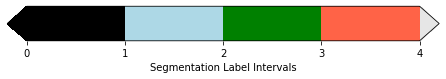

IoU score: 0.864, Chromesome F1score: 0.765, Nucleus F1score: 0.934, Cell F1score: 0.966, Chromesome precision: 0.620, Nucleus precision: 0.877, Cell precision: 0.959, Chromesome recall: 1.000, Nucleus recall: 1.000, Cell recall: 0.974


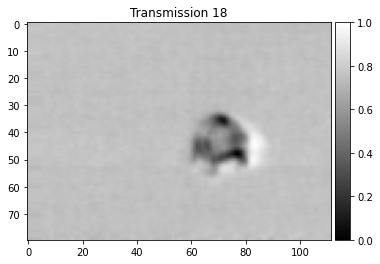

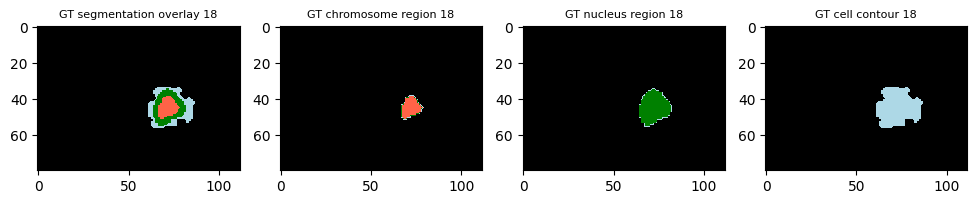

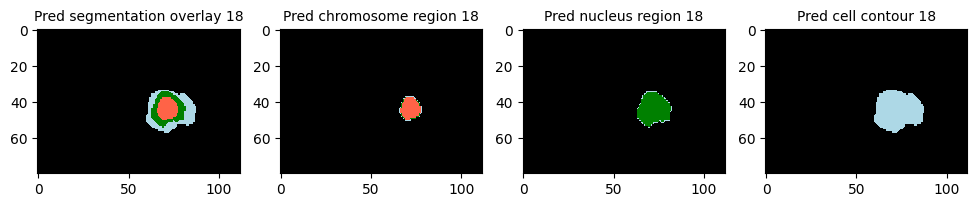

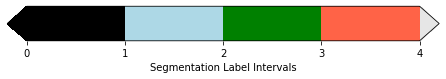

IoU score: 0.827, Chromesome F1score: 0.868, Nucleus F1score: 0.916, Cell F1score: 0.908, Chromesome precision: 0.812, Nucleus precision: 0.903, Cell precision: 0.856, Chromesome recall: 0.931, Nucleus recall: 0.931, Cell recall: 0.966


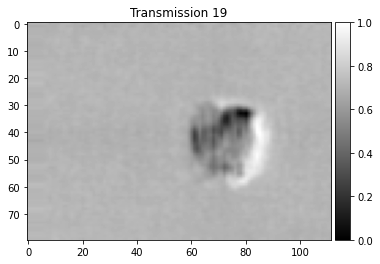

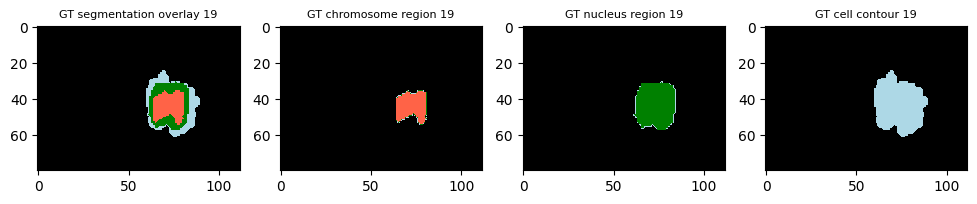

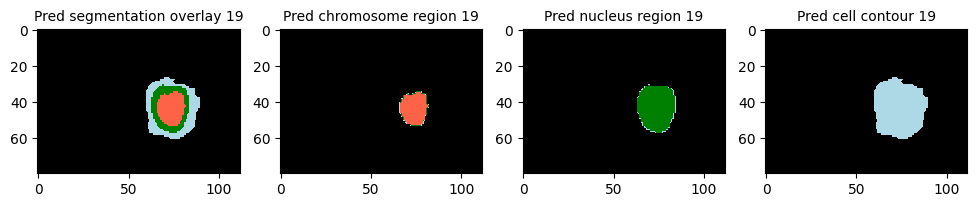

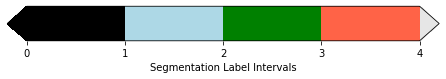

IoU score: 0.861, Chromesome F1score: 0.823, Nucleus F1score: 0.933, Cell F1score: 0.951, Chromesome precision: 0.850, Nucleus precision: 0.987, Cell precision: 0.928, Chromesome recall: 0.798, Nucleus recall: 0.886, Cell recall: 0.976
mean iou_score:  0.8607445873569406
mean precision chromesome:  0.8012890386032787
mean precision nucleus:  0.9273725954942192
mean precision cell:  0.9320298319611411
mean recall chromesome:  0.8846186536527576
mean recall nucleus:  0.9440184779160945
mean recall cell:  0.9552704169534406
mean F1score chromesome:  0.8350142146620959
mean F1score nucleus:  0.934296652182759
mean F1score cell:  0.9421498340010243
Initializing Datasets and Dataloaders...


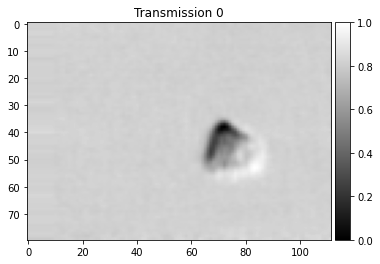

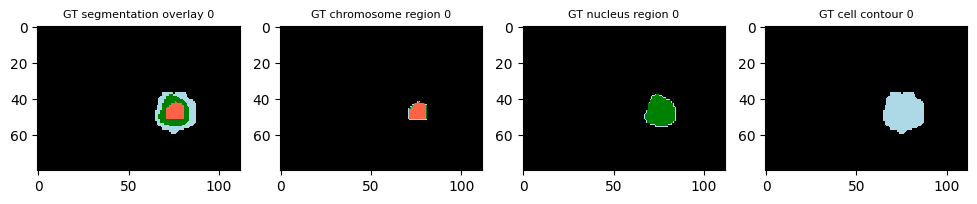

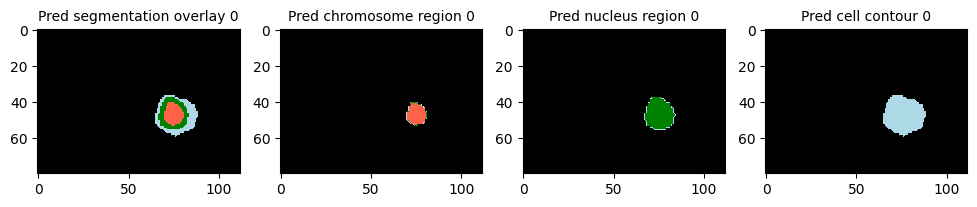

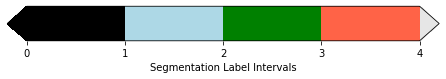

IoU score: 0.884, Chromesome F1score: 0.823, Nucleus F1score: 0.942, Cell F1score: 0.963, Chromesome precision: 0.731, Nucleus precision: 0.936, Cell precision: 0.987, Chromesome recall: 0.940, Nucleus recall: 0.948, Cell recall: 0.940


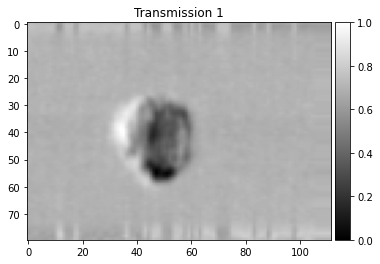

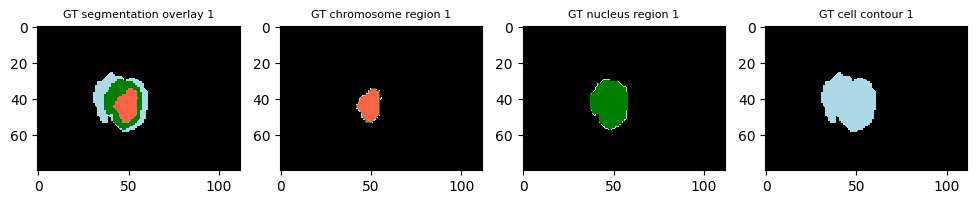

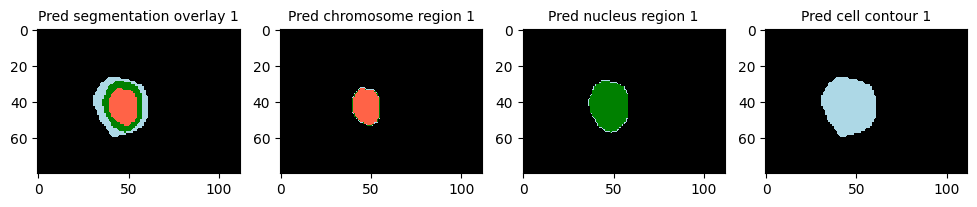

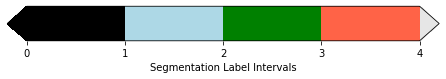

IoU score: 0.862, Chromesome F1score: 0.793, Nucleus F1score: 0.949, Cell F1score: 0.950, Chromesome precision: 0.667, Nucleus precision: 0.905, Cell precision: 0.924, Chromesome recall: 0.977, Nucleus recall: 0.998, Cell recall: 0.977


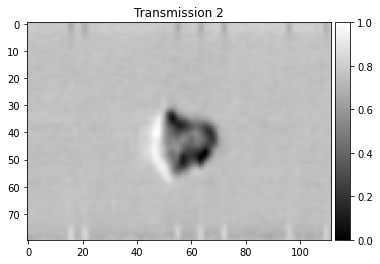

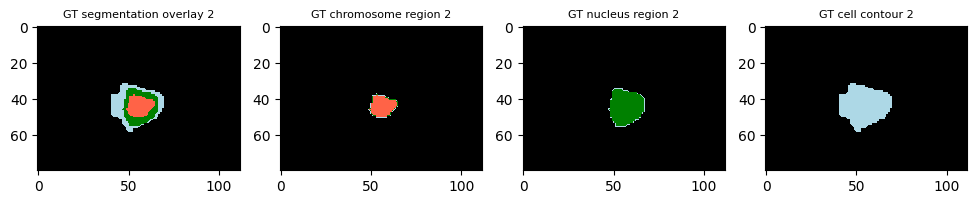

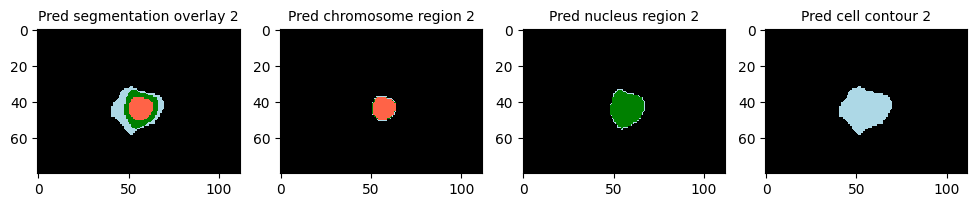

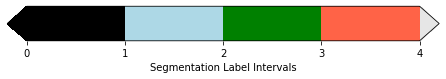

IoU score: 0.897, Chromesome F1score: 0.893, Nucleus F1score: 0.939, Cell F1score: 0.964, Chromesome precision: 0.899, Nucleus precision: 0.967, Cell precision: 0.988, Chromesome recall: 0.887, Nucleus recall: 0.912, Cell recall: 0.942


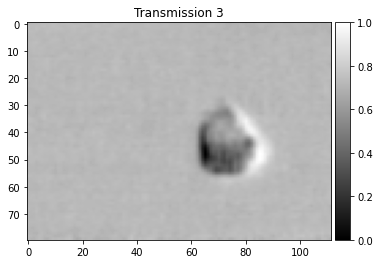

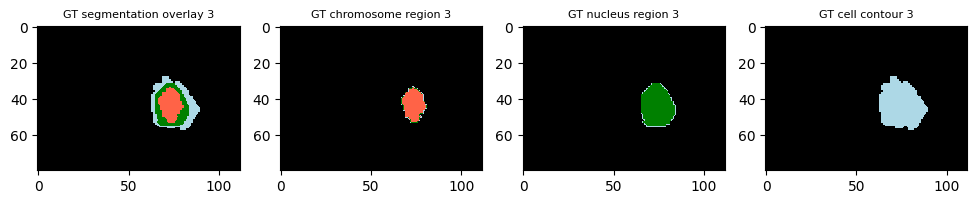

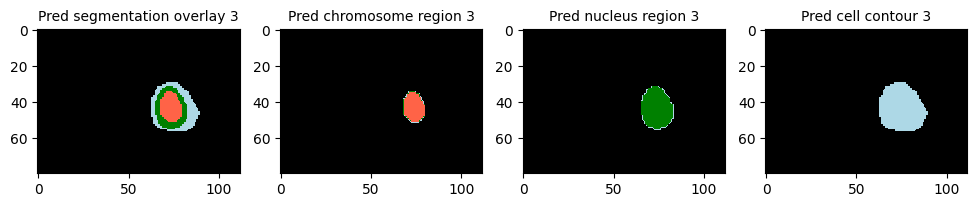

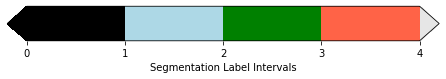

IoU score: 0.907, Chromesome F1score: 0.910, Nucleus F1score: 0.953, Cell F1score: 0.963, Chromesome precision: 0.963, Nucleus precision: 0.994, Cell precision: 0.968, Chromesome recall: 0.863, Nucleus recall: 0.915, Cell recall: 0.958


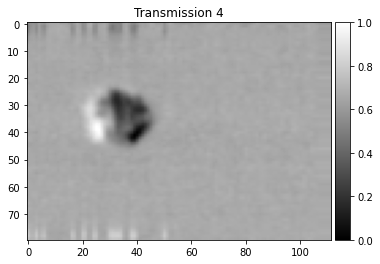

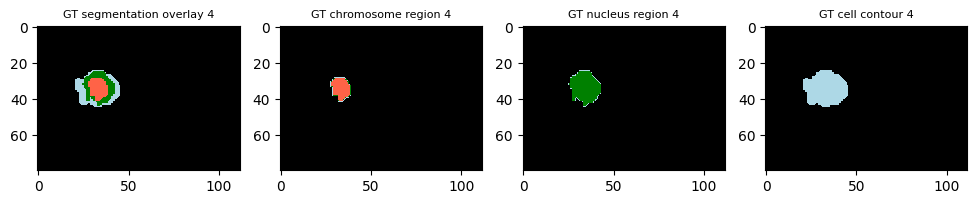

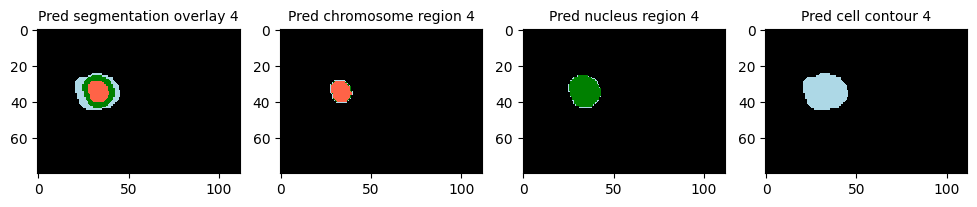

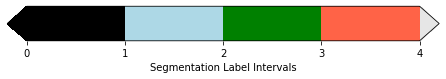

IoU score: 0.909, Chromesome F1score: 0.946, Nucleus F1score: 0.931, Cell F1score: 0.967, Chromesome precision: 0.921, Nucleus precision: 0.917, Cell precision: 0.948, Chromesome recall: 0.972, Nucleus recall: 0.947, Cell recall: 0.987


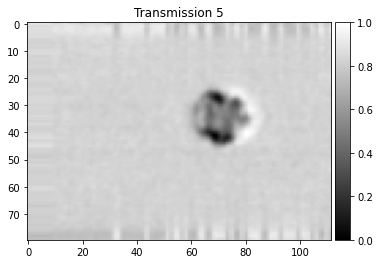

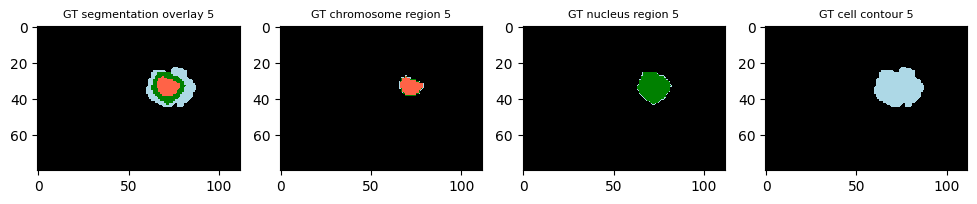

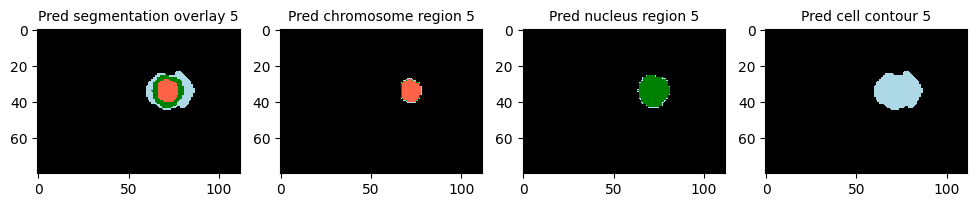

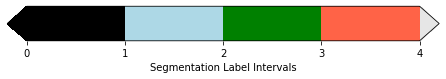

IoU score: 0.878, Chromesome F1score: 0.835, Nucleus F1score: 0.942, Cell F1score: 0.956, Chromesome precision: 0.771, Nucleus precision: 0.919, Cell precision: 0.986, Chromesome recall: 0.910, Nucleus recall: 0.966, Cell recall: 0.927


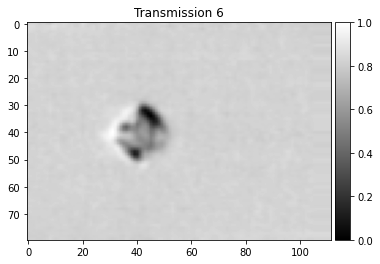

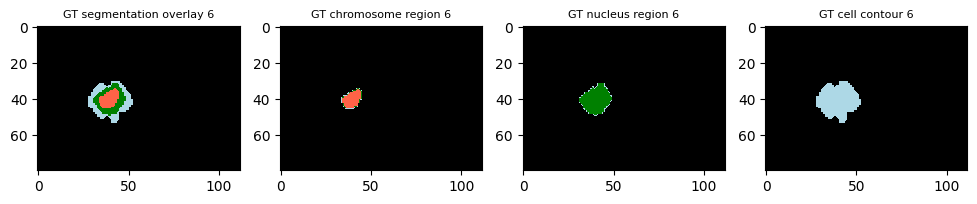

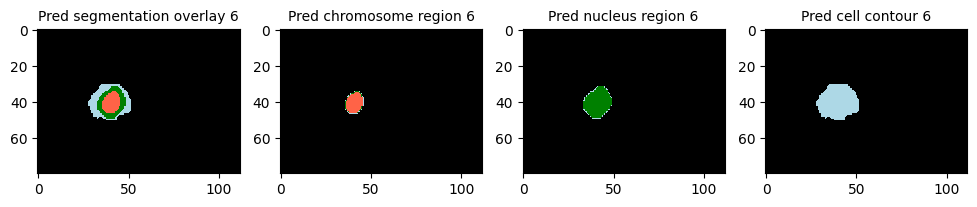

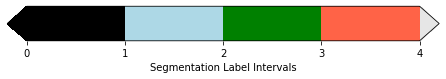

IoU score: 0.846, Chromesome F1score: 0.820, Nucleus F1score: 0.930, Cell F1score: 0.932, Chromesome precision: 0.777, Nucleus precision: 0.937, Cell precision: 0.956, Chromesome recall: 0.869, Nucleus recall: 0.923, Cell recall: 0.908


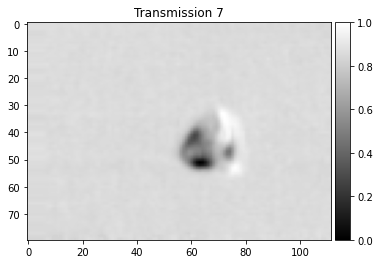

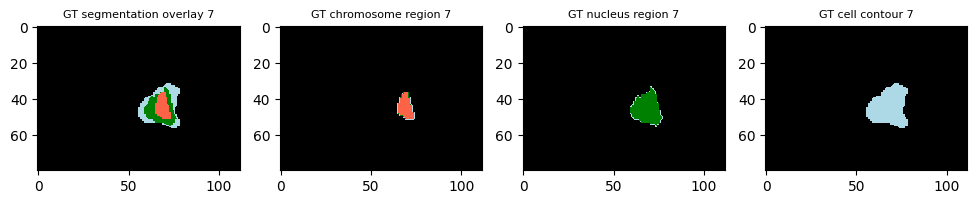

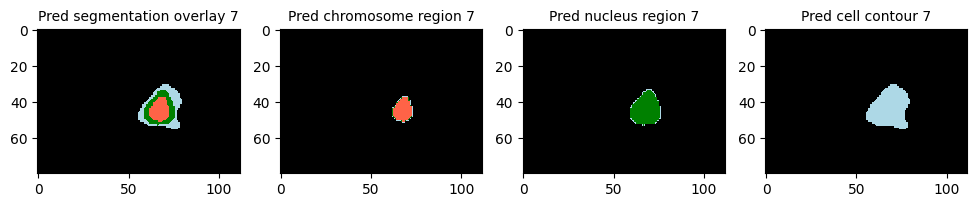

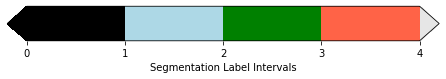

IoU score: 0.813, Chromesome F1score: 0.777, Nucleus F1score: 0.891, Cell F1score: 0.932, Chromesome precision: 0.713, Nucleus precision: 0.882, Cell precision: 0.908, Chromesome recall: 0.854, Nucleus recall: 0.900, Cell recall: 0.957


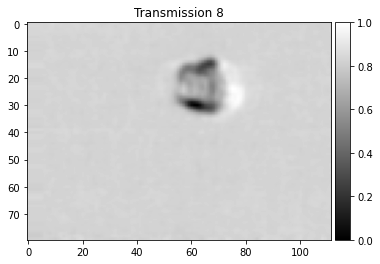

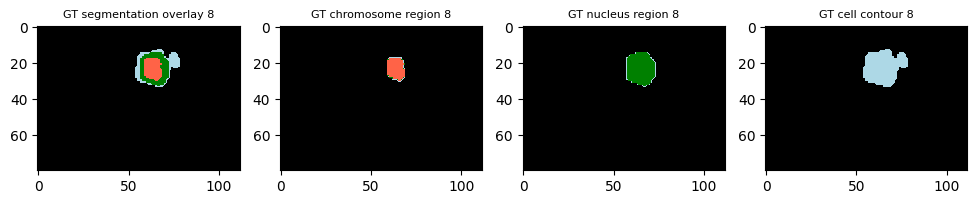

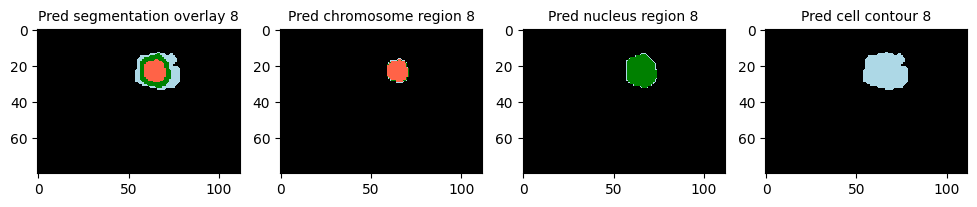

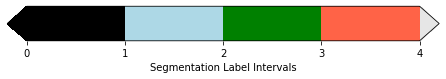

IoU score: 0.835, Chromesome F1score: 0.868, Nucleus F1score: 0.959, Cell F1score: 0.891, Chromesome precision: 0.816, Nucleus precision: 0.949, Cell precision: 0.838, Chromesome recall: 0.927, Nucleus recall: 0.968, Cell recall: 0.951


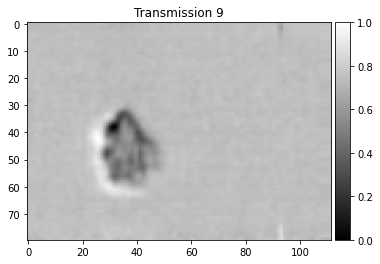

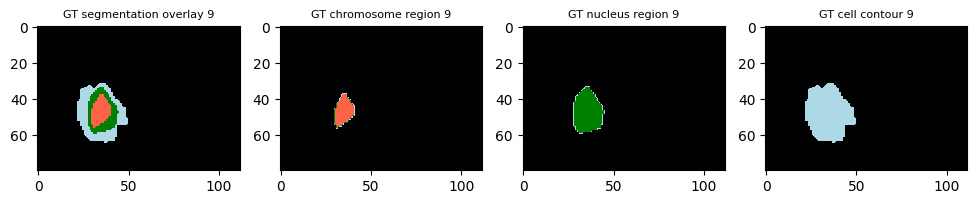

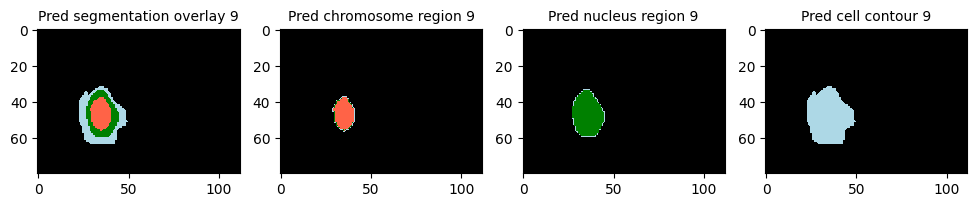

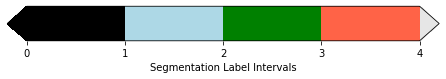

IoU score: 0.893, Chromesome F1score: 0.875, Nucleus F1score: 0.939, Cell F1score: 0.962, Chromesome precision: 0.811, Nucleus precision: 0.903, Cell precision: 0.989, Chromesome recall: 0.950, Nucleus recall: 0.978, Cell recall: 0.936


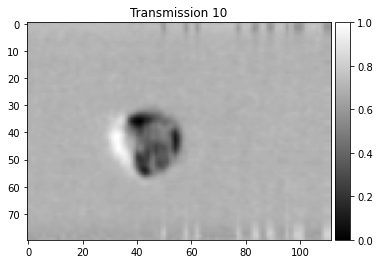

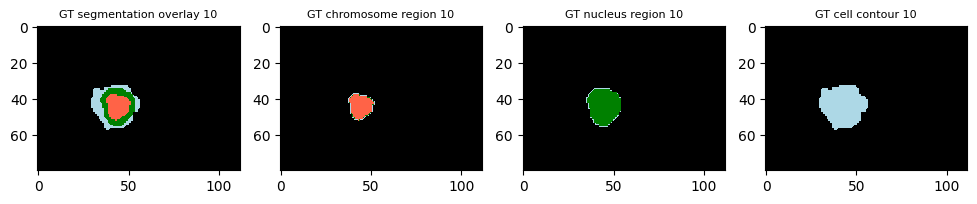

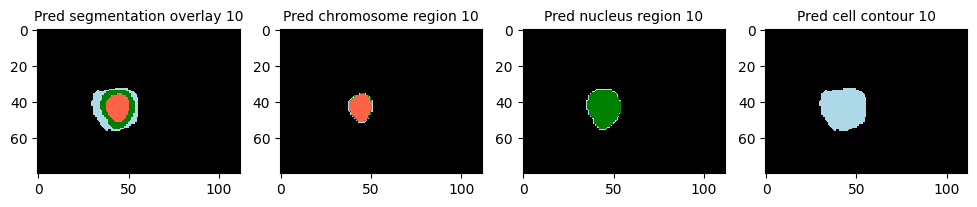

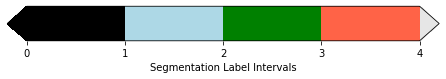

IoU score: 0.887, Chromesome F1score: 0.879, Nucleus F1score: 0.951, Cell F1score: 0.952, Chromesome precision: 0.843, Nucleus precision: 0.931, Cell precision: 0.942, Chromesome recall: 0.918, Nucleus recall: 0.971, Cell recall: 0.961


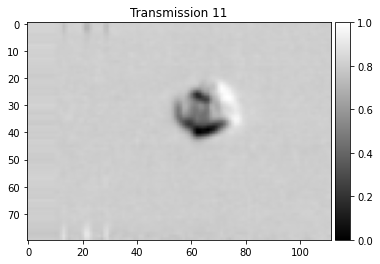

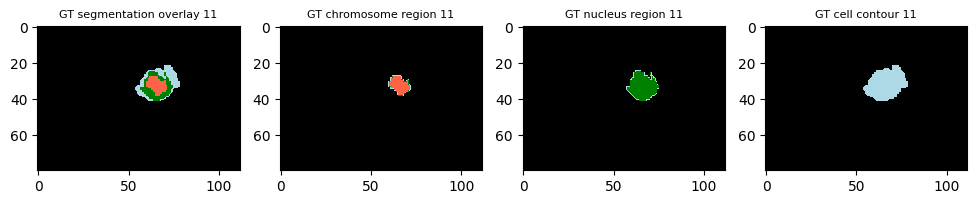

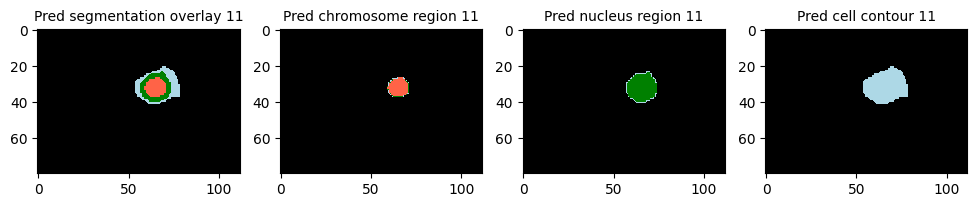

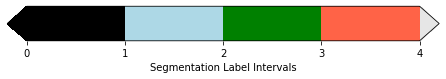

IoU score: 0.819, Chromesome F1score: 0.836, Nucleus F1score: 0.888, Cell F1score: 0.925, Chromesome precision: 0.775, Nucleus precision: 0.842, Cell precision: 0.867, Chromesome recall: 0.908, Nucleus recall: 0.940, Cell recall: 0.991


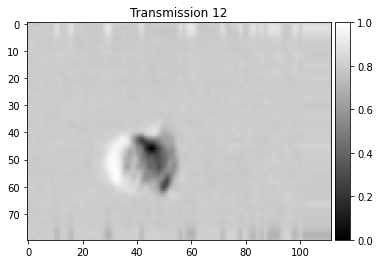

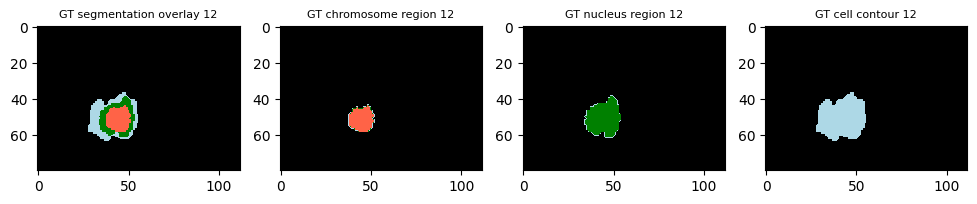

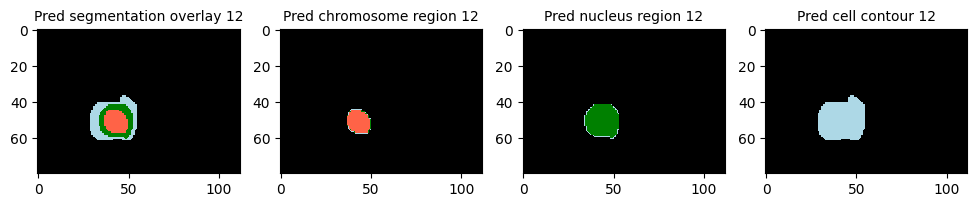

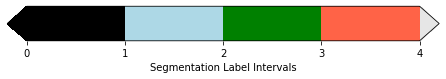

IoU score: 0.846, Chromesome F1score: 0.836, Nucleus F1score: 0.900, Cell F1score: 0.949, Chromesome precision: 0.888, Nucleus precision: 0.933, Cell precision: 0.966, Chromesome recall: 0.789, Nucleus recall: 0.869, Cell recall: 0.932


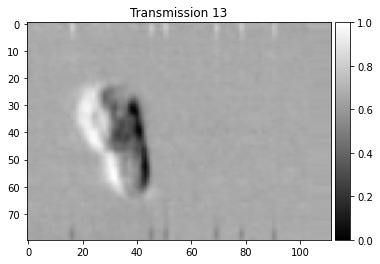

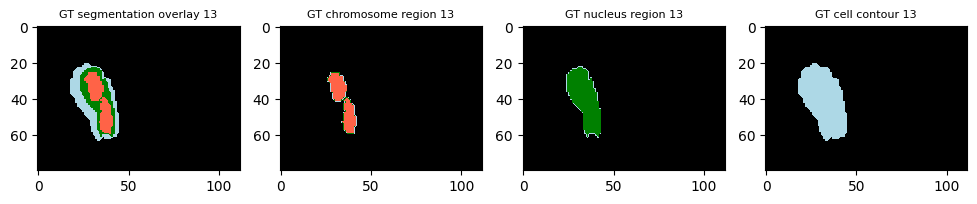

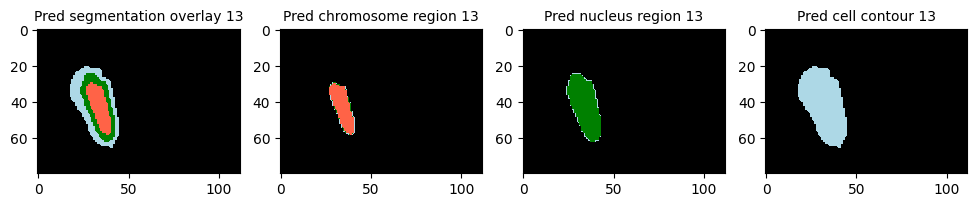

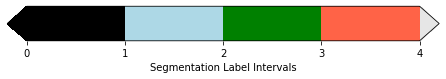

IoU score: 0.836, Chromesome F1score: 0.743, Nucleus F1score: 0.908, Cell F1score: 0.962, Chromesome precision: 0.748, Nucleus precision: 0.898, Cell precision: 0.938, Chromesome recall: 0.738, Nucleus recall: 0.918, Cell recall: 0.988


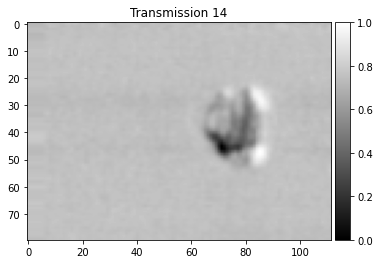

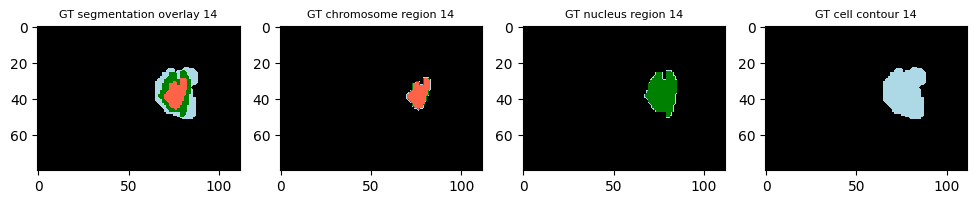

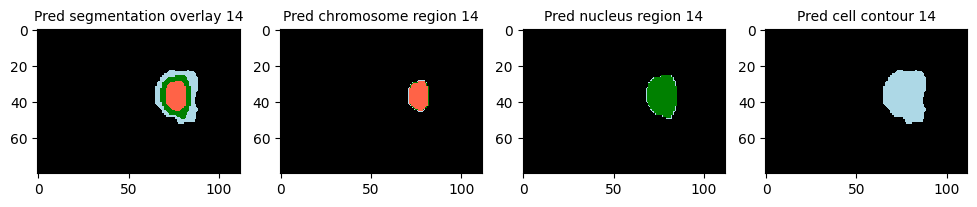

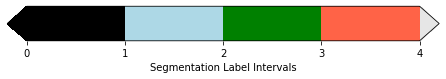

IoU score: 0.880, Chromesome F1score: 0.840, Nucleus F1score: 0.938, Cell F1score: 0.961, Chromesome precision: 0.803, Nucleus precision: 0.920, Cell precision: 0.937, Chromesome recall: 0.881, Nucleus recall: 0.956, Cell recall: 0.987


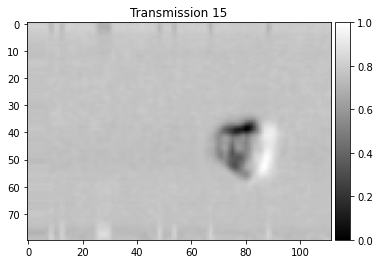

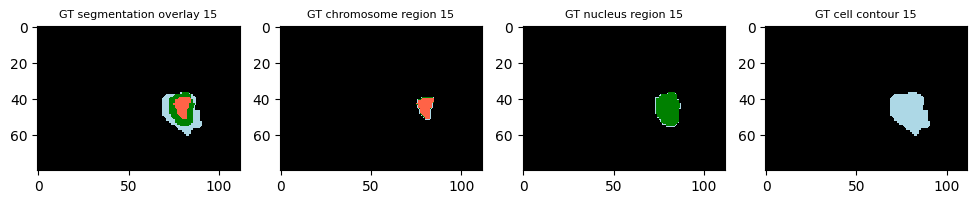

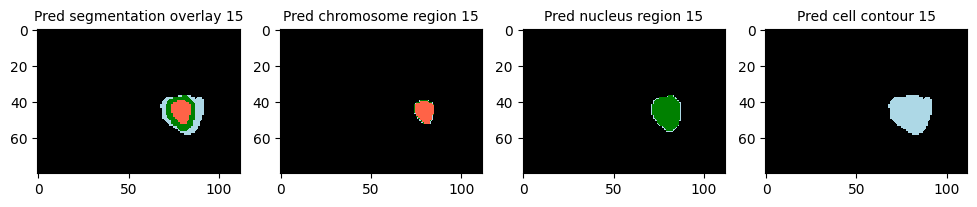

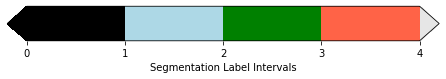

IoU score: 0.811, Chromesome F1score: 0.792, Nucleus F1score: 0.912, Cell F1score: 0.912, Chromesome precision: 0.679, Nucleus precision: 0.846, Cell precision: 0.876, Chromesome recall: 0.950, Nucleus recall: 0.990, Cell recall: 0.951


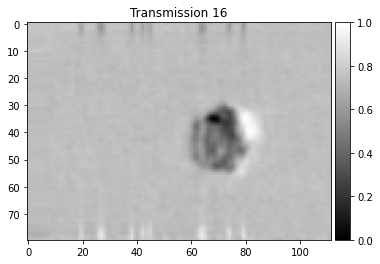

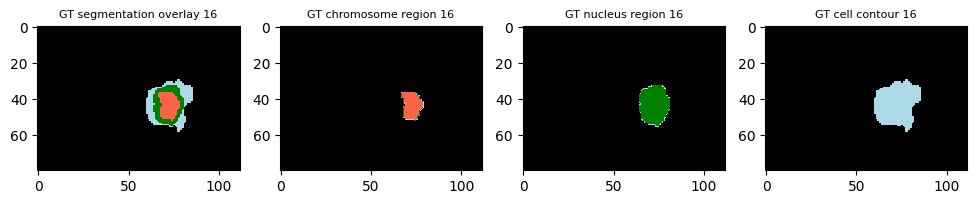

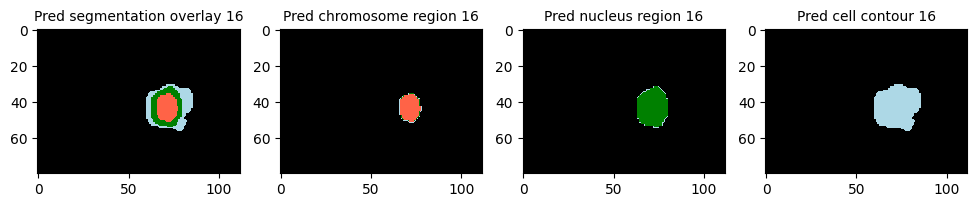

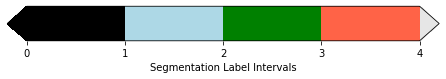

IoU score: 0.876, Chromesome F1score: 0.866, Nucleus F1score: 0.932, Cell F1score: 0.954, Chromesome precision: 0.840, Nucleus precision: 0.924, Cell precision: 0.952, Chromesome recall: 0.894, Nucleus recall: 0.942, Cell recall: 0.956


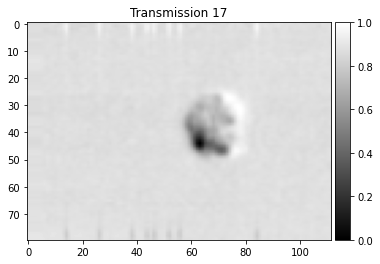

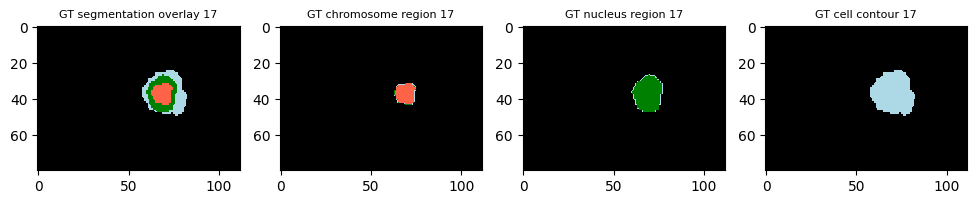

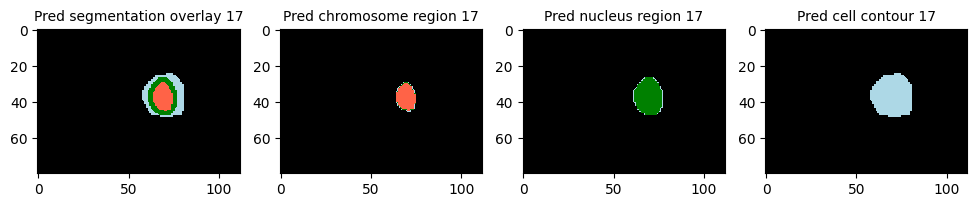

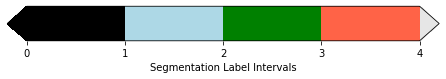

IoU score: 0.888, Chromesome F1score: 0.848, Nucleus F1score: 0.951, Cell F1score: 0.960, Chromesome precision: 0.774, Nucleus precision: 0.941, Cell precision: 0.969, Chromesome recall: 0.936, Nucleus recall: 0.962, Cell recall: 0.950


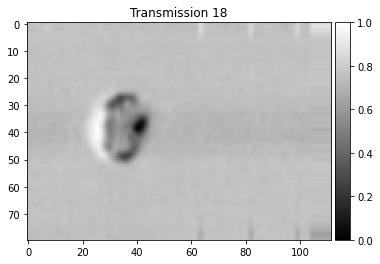

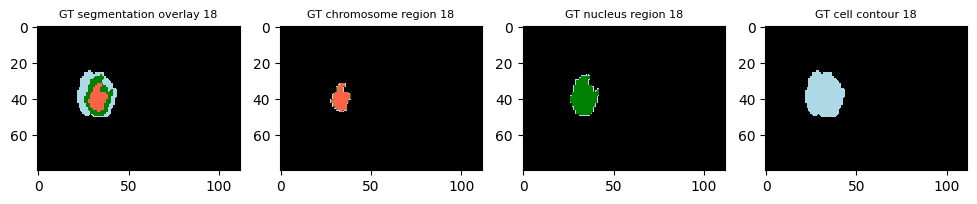

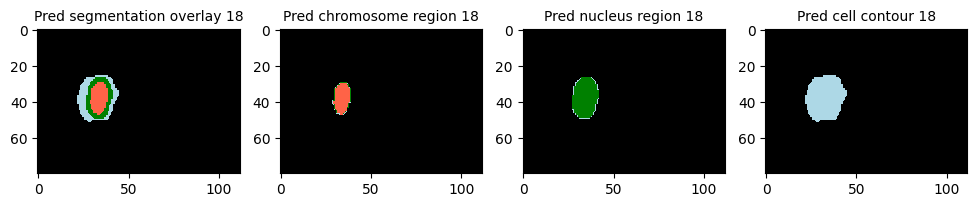

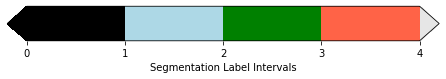

IoU score: 0.844, Chromesome F1score: 0.815, Nucleus F1score: 0.917, Cell F1score: 0.942, Chromesome precision: 0.733, Nucleus precision: 0.864, Cell precision: 0.925, Chromesome recall: 0.917, Nucleus recall: 0.975, Cell recall: 0.959


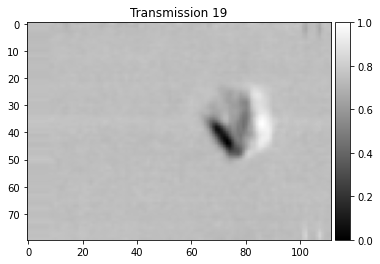

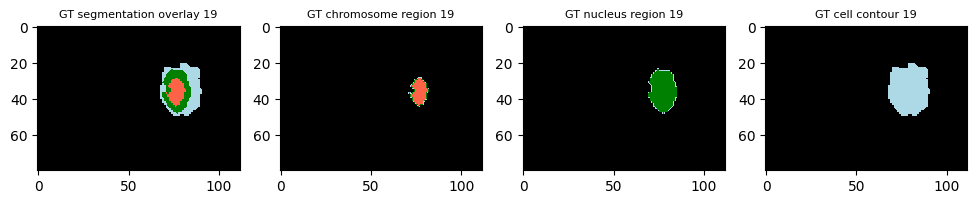

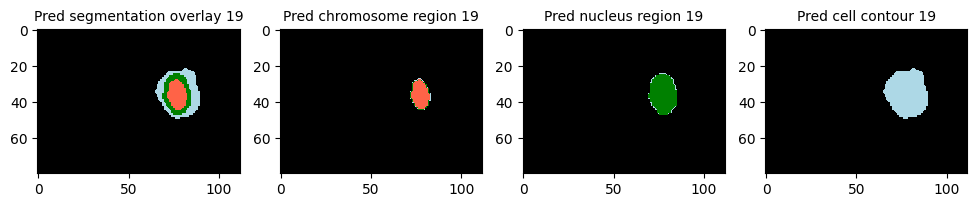

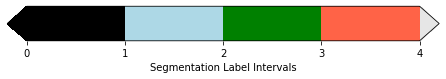

IoU score: 0.856, Chromesome F1score: 0.843, Nucleus F1score: 0.952, Cell F1score: 0.925, Chromesome precision: 0.750, Nucleus precision: 0.961, Cell precision: 0.949, Chromesome recall: 0.962, Nucleus recall: 0.944, Cell recall: 0.903
mean iou_score:  0.8596797816204111
mean precision chromesome:  0.797307357599632
mean precision nucleus:  0.9250985001155926
mean precision cell:  0.9373312361800161
mean recall chromesome:  0.8852447144529914
mean recall nucleus:  0.9452921145082618
mean recall cell:  0.9491325718129249
mean F1score chromesome:  0.8322859377199775
mean F1score nucleus:  0.9337153956181582
mean F1score cell:  0.9420673499939566
Initializing Datasets and Dataloaders...


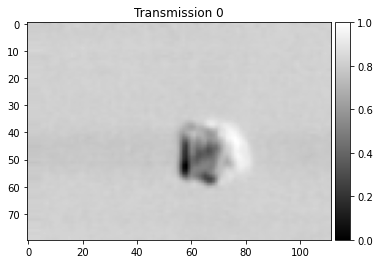

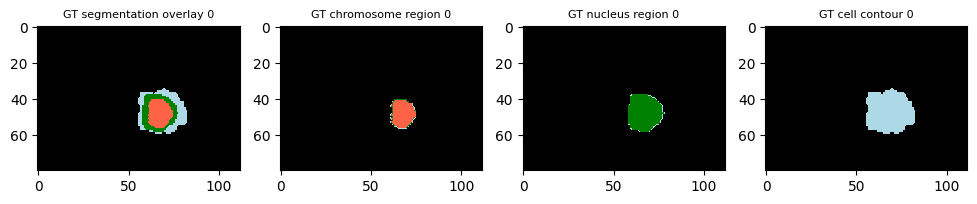

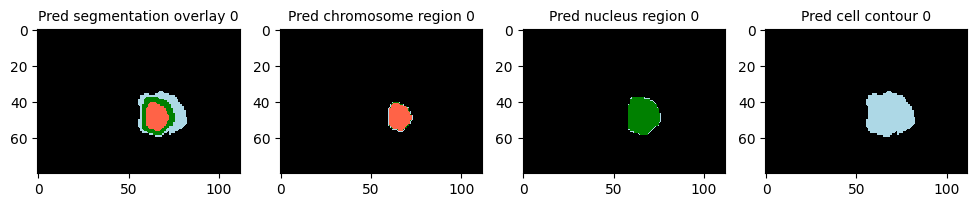

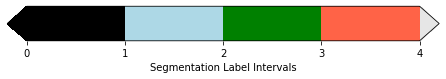

IoU score: 0.884, Chromesome F1score: 0.826, Nucleus F1score: 0.950, Cell F1score: 0.967, Chromesome precision: 0.868, Nucleus precision: 0.990, Cell precision: 0.979, Chromesome recall: 0.789, Nucleus recall: 0.913, Cell recall: 0.955


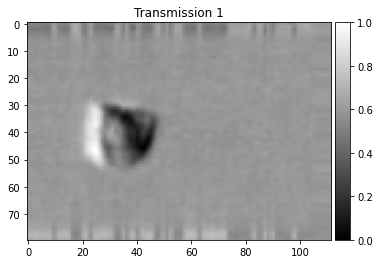

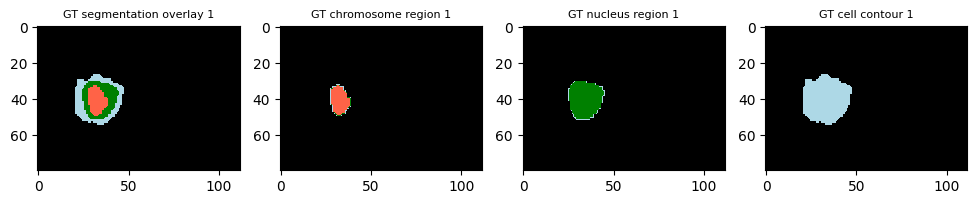

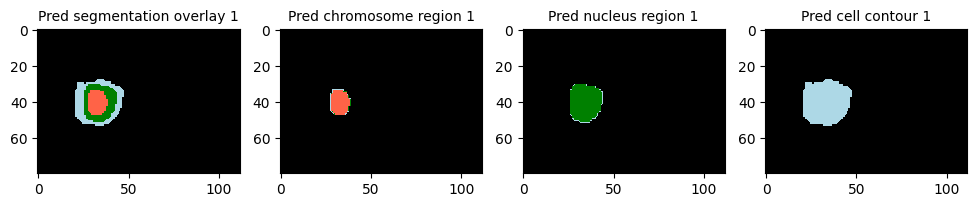

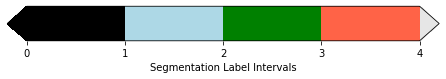

IoU score: 0.937, Chromesome F1score: 0.910, Nucleus F1score: 0.971, Cell F1score: 0.979, Chromesome precision: 0.931, Nucleus precision: 0.991, Cell precision: 0.993, Chromesome recall: 0.891, Nucleus recall: 0.952, Cell recall: 0.965


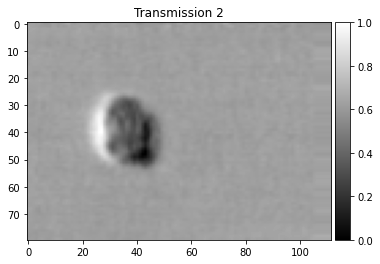

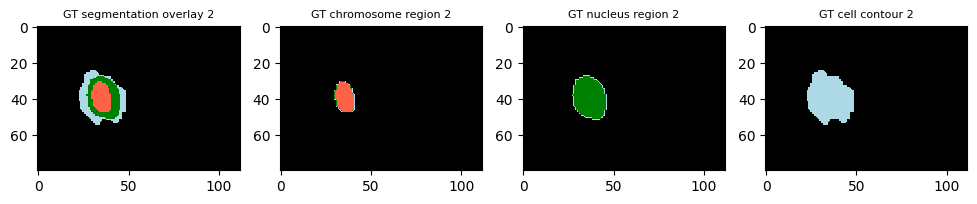

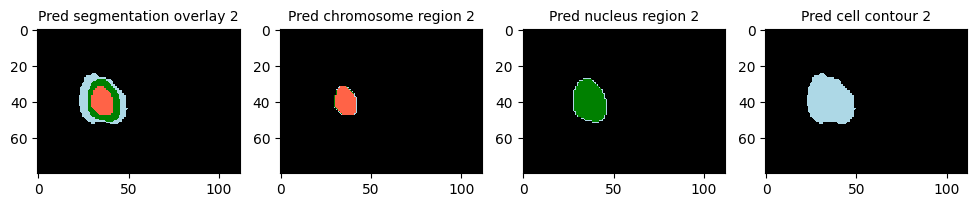

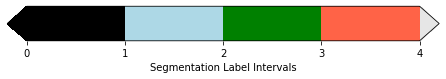

IoU score: 0.931, Chromesome F1score: 0.925, Nucleus F1score: 0.977, Cell F1score: 0.967, Chromesome precision: 0.904, Nucleus precision: 0.986, Cell precision: 0.965, Chromesome recall: 0.947, Nucleus recall: 0.969, Cell recall: 0.968


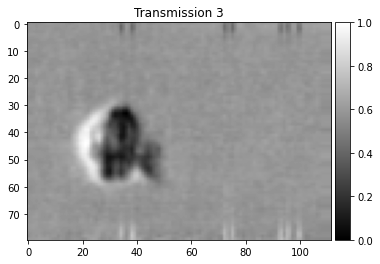

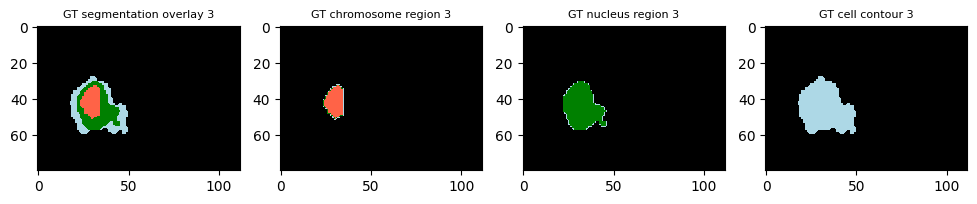

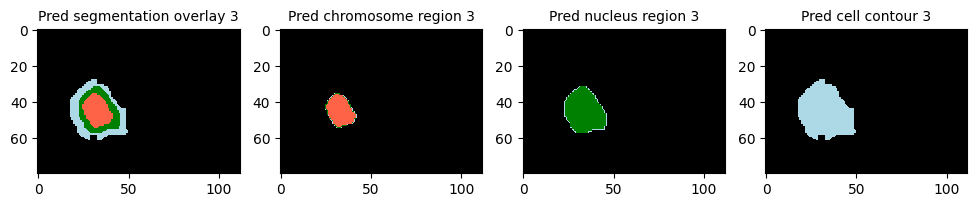

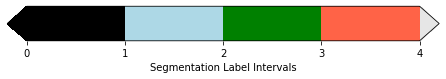

IoU score: 0.809, Chromesome F1score: 0.647, Nucleus F1score: 0.907, Cell F1score: 0.950, Chromesome precision: 0.553, Nucleus precision: 0.904, Cell precision: 0.920, Chromesome recall: 0.778, Nucleus recall: 0.911, Cell recall: 0.981


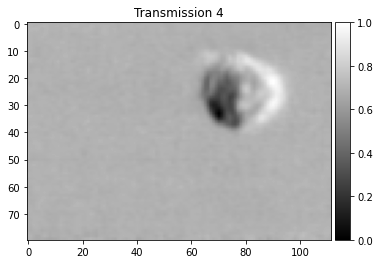

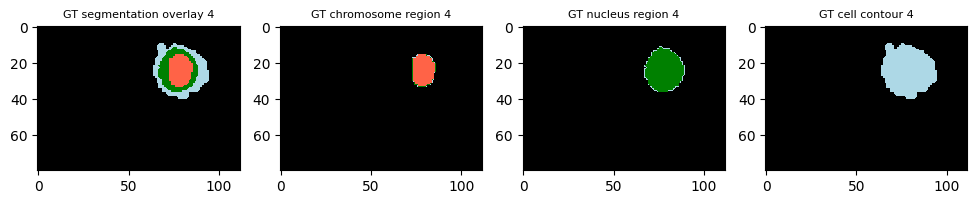

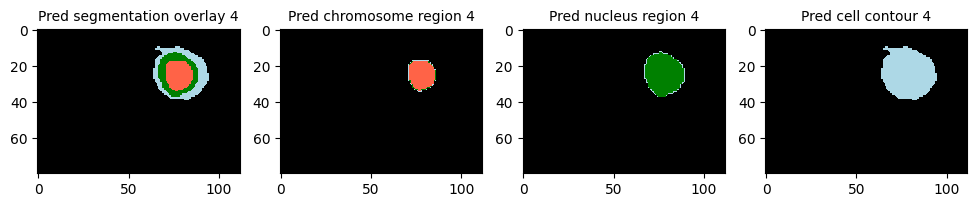

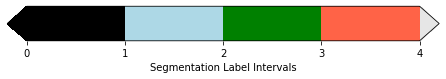

IoU score: 0.902, Chromesome F1score: 0.876, Nucleus F1score: 0.956, Cell F1score: 0.965, Chromesome precision: 0.850, Nucleus precision: 0.952, Cell precision: 0.970, Chromesome recall: 0.903, Nucleus recall: 0.961, Cell recall: 0.960


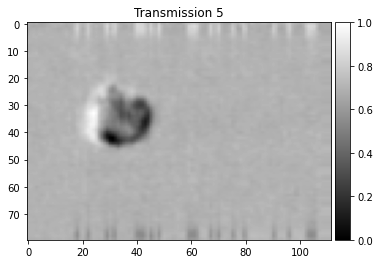

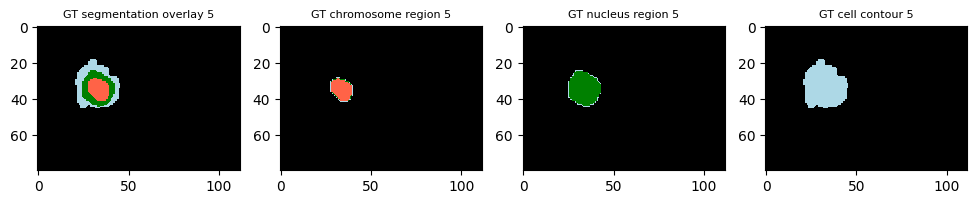

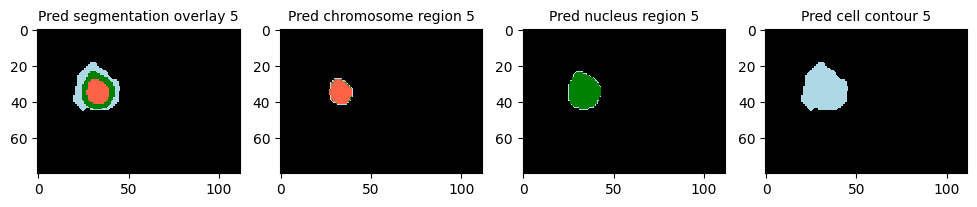

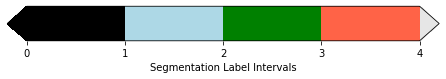

IoU score: 0.919, Chromesome F1score: 0.892, Nucleus F1score: 0.963, Cell F1score: 0.972, Chromesome precision: 0.823, Nucleus precision: 0.932, Cell precision: 0.968, Chromesome recall: 0.975, Nucleus recall: 0.996, Cell recall: 0.976


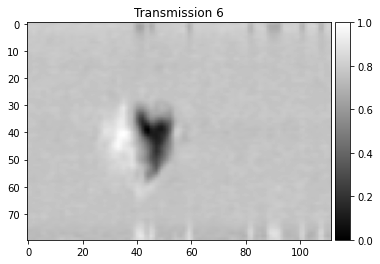

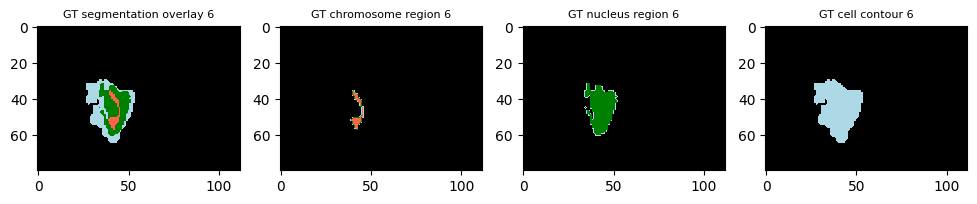

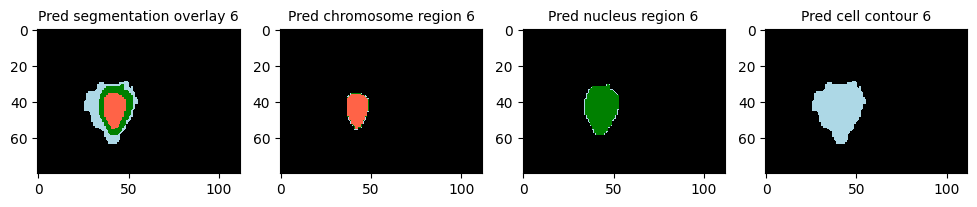

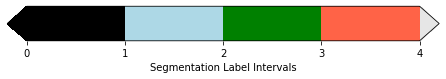

IoU score: 0.692, Chromesome F1score: 0.390, Nucleus F1score: 0.832, Cell F1score: 0.889, Chromesome precision: 0.247, Nucleus precision: 0.754, Cell precision: 0.852, Chromesome recall: 0.920, Nucleus recall: 0.928, Cell recall: 0.930


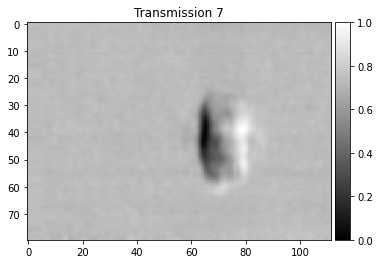

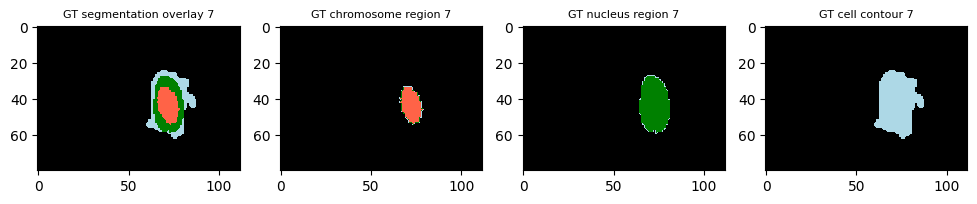

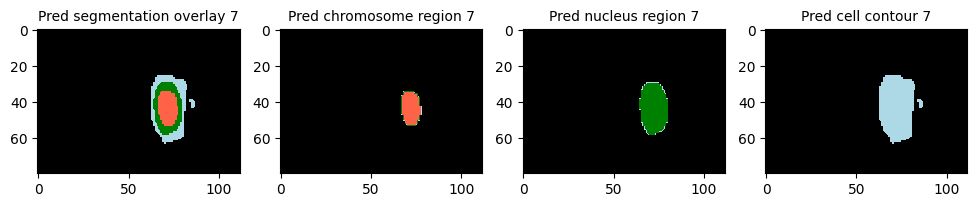

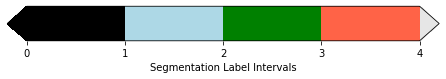

IoU score: 0.860, Chromesome F1score: 0.921, Nucleus F1score: 0.923, Cell F1score: 0.926, Chromesome precision: 0.943, Nucleus precision: 0.992, Cell precision: 0.962, Chromesome recall: 0.901, Nucleus recall: 0.863, Cell recall: 0.893


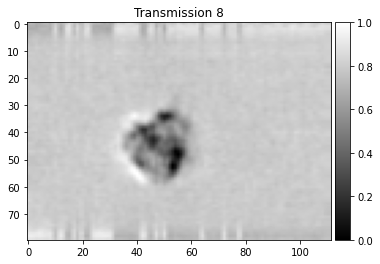

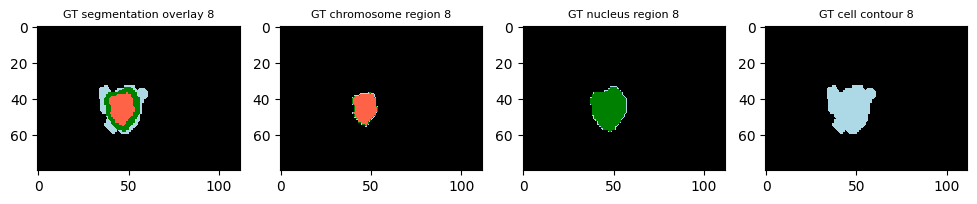

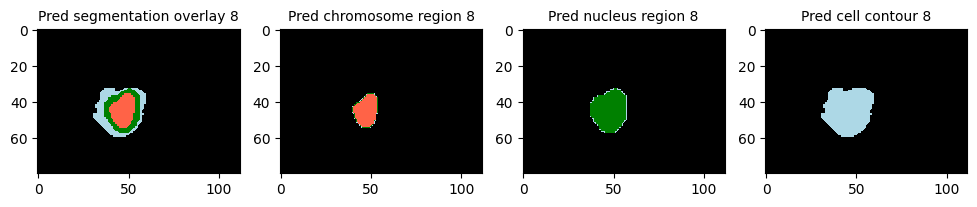

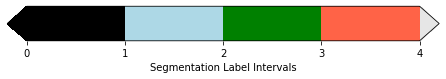

IoU score: 0.853, Chromesome F1score: 0.880, Nucleus F1score: 0.951, Cell F1score: 0.914, Chromesome precision: 0.857, Nucleus precision: 0.929, Cell precision: 0.862, Chromesome recall: 0.903, Nucleus recall: 0.975, Cell recall: 0.972


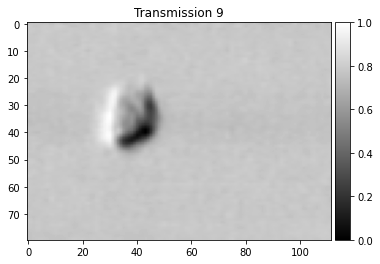

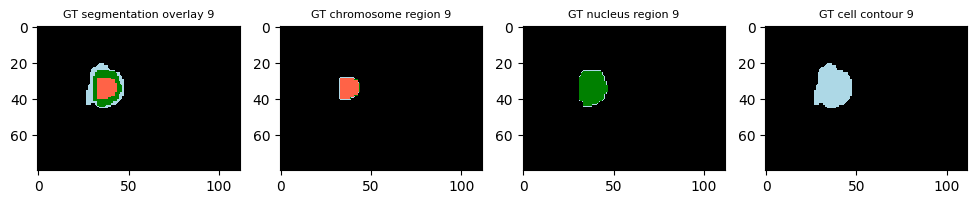

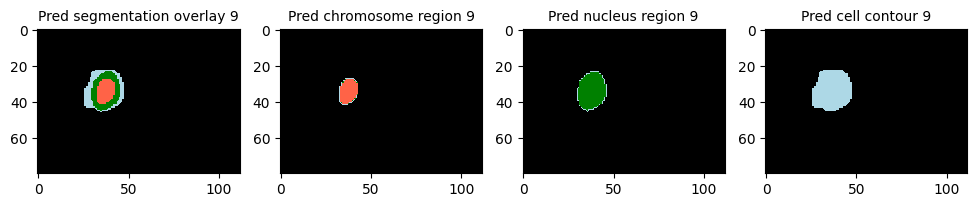

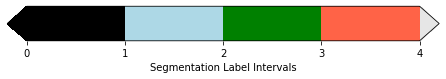

IoU score: 0.886, Chromesome F1score: 0.906, Nucleus F1score: 0.947, Cell F1score: 0.945, Chromesome precision: 0.906, Nucleus precision: 0.937, Cell precision: 0.921, Chromesome recall: 0.906, Nucleus recall: 0.958, Cell recall: 0.970


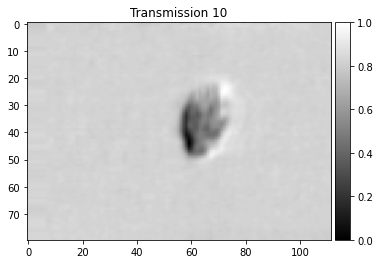

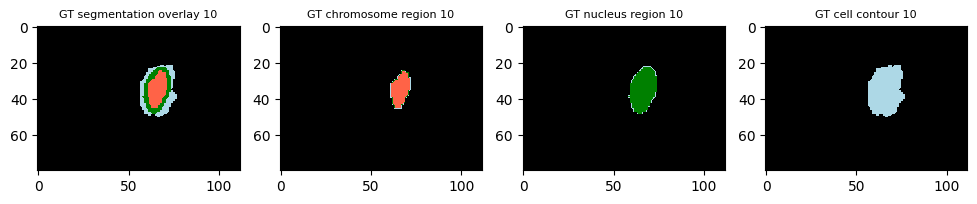

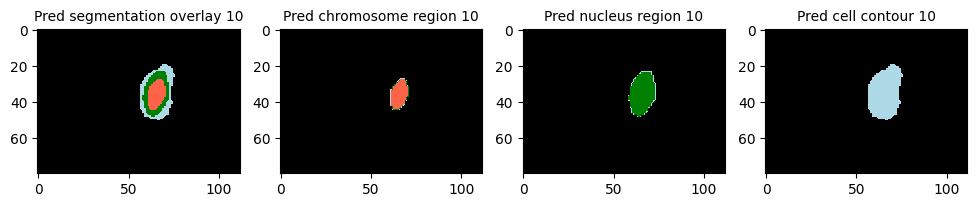

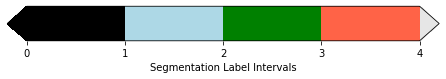

IoU score: 0.884, Chromesome F1score: 0.862, Nucleus F1score: 0.950, Cell F1score: 0.956, Chromesome precision: 0.969, Nucleus precision: 0.986, Cell precision: 0.966, Chromesome recall: 0.776, Nucleus recall: 0.916, Cell recall: 0.947


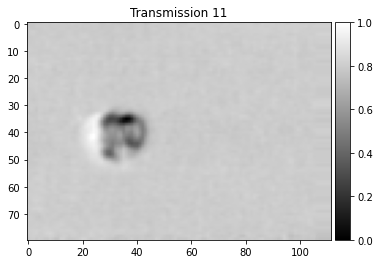

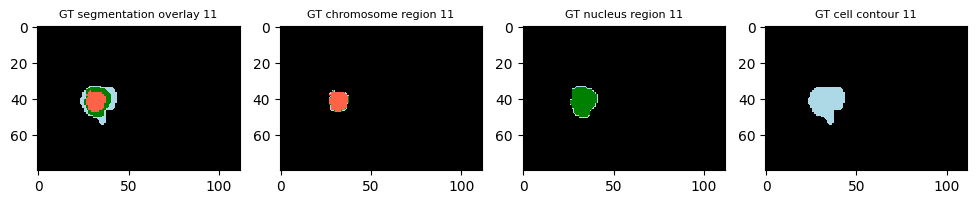

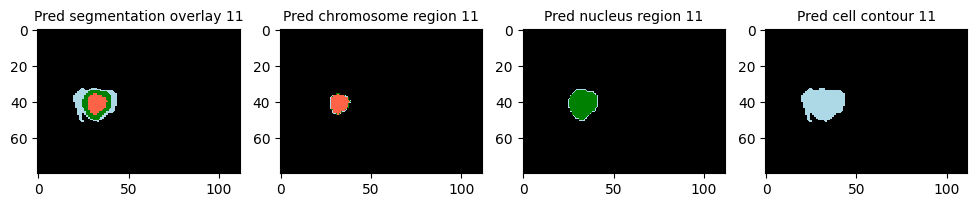

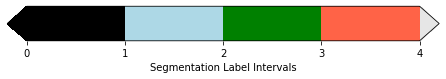

IoU score: 0.805, Chromesome F1score: 0.903, Nucleus F1score: 0.940, Cell F1score: 0.858, Chromesome precision: 0.946, Nucleus precision: 0.913, Cell precision: 0.789, Chromesome recall: 0.863, Nucleus recall: 0.969, Cell recall: 0.941


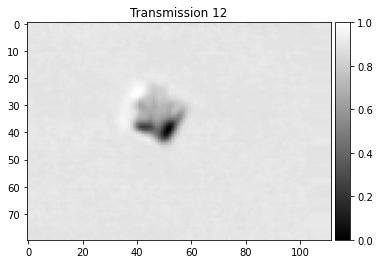

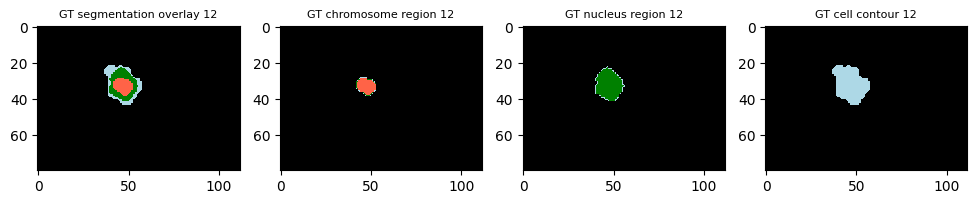

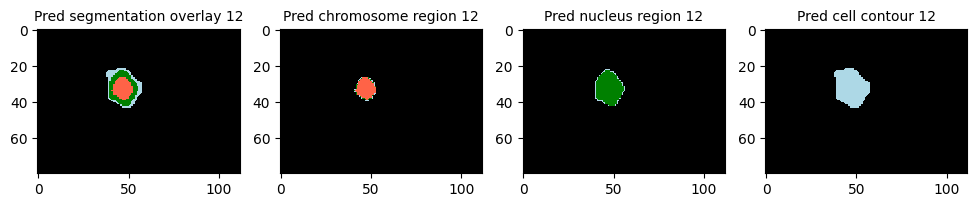

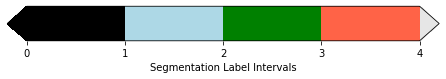

IoU score: 0.899, Chromesome F1score: 0.862, Nucleus F1score: 0.950, Cell F1score: 0.969, Chromesome precision: 0.757, Nucleus precision: 0.905, Cell precision: 0.966, Chromesome recall: 1.000, Nucleus recall: 1.000, Cell recall: 0.972


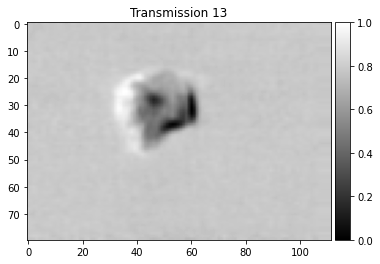

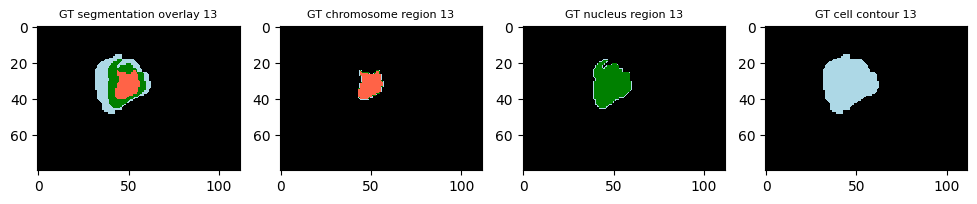

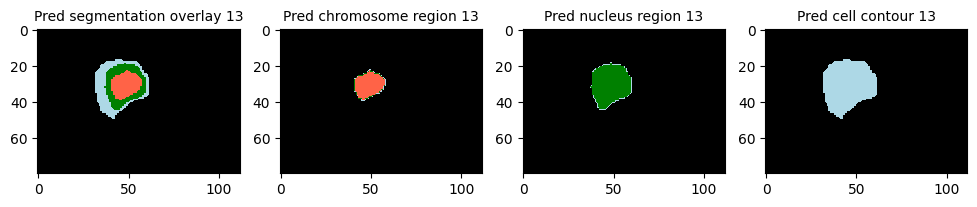

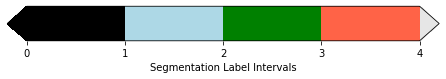

IoU score: 0.850, Chromesome F1score: 0.786, Nucleus F1score: 0.898, Cell F1score: 0.966, Chromesome precision: 0.726, Nucleus precision: 0.871, Cell precision: 0.958, Chromesome recall: 0.856, Nucleus recall: 0.927, Cell recall: 0.974


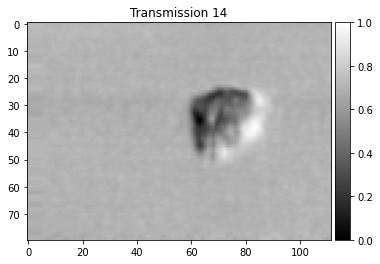

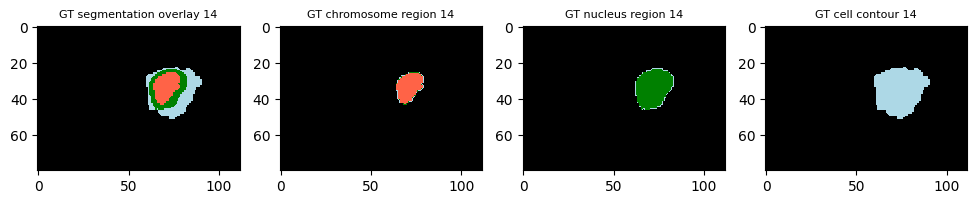

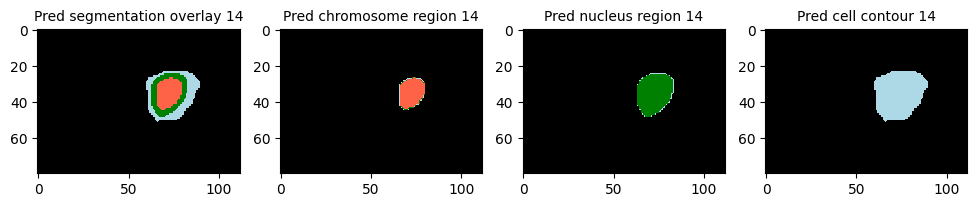

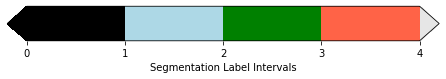

IoU score: 0.859, Chromesome F1score: 0.795, Nucleus F1score: 0.918, Cell F1score: 0.967, Chromesome precision: 0.777, Nucleus precision: 0.900, Cell precision: 0.961, Chromesome recall: 0.814, Nucleus recall: 0.937, Cell recall: 0.973


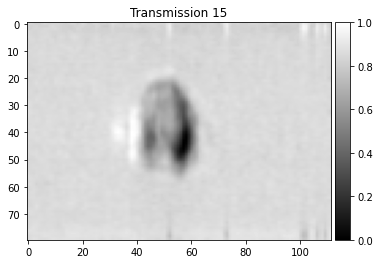

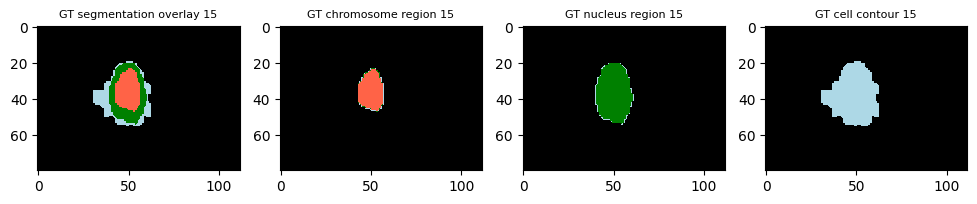

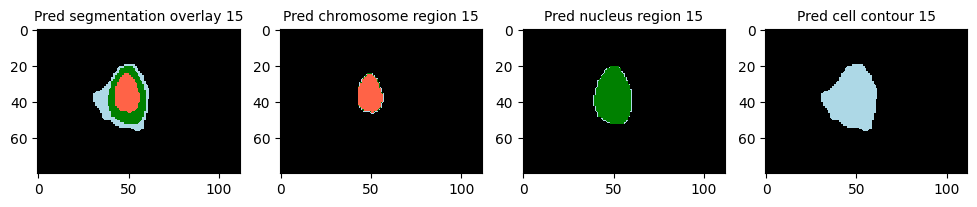

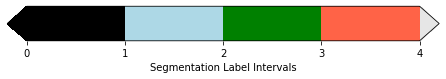

IoU score: 0.906, Chromesome F1score: 0.929, Nucleus F1score: 0.957, Cell F1score: 0.953, Chromesome precision: 0.983, Nucleus precision: 0.977, Cell precision: 0.950, Chromesome recall: 0.881, Nucleus recall: 0.938, Cell recall: 0.956


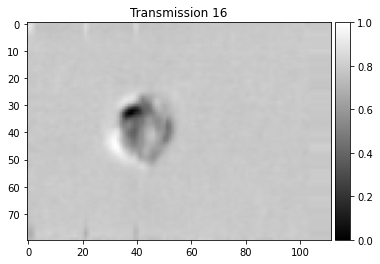

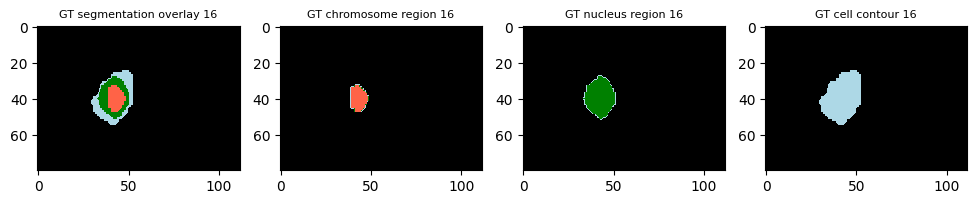

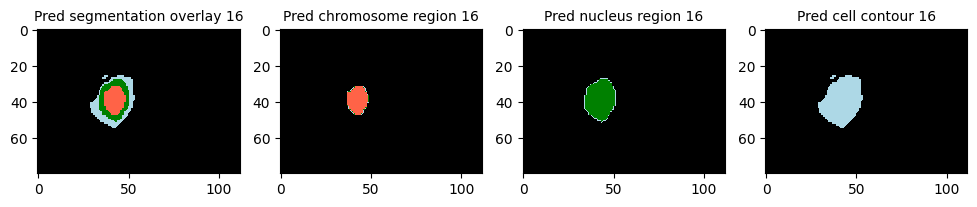

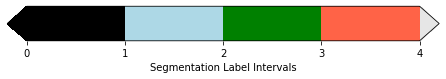

IoU score: 0.900, Chromesome F1score: 0.859, Nucleus F1score: 0.958, Cell F1score: 0.964, Chromesome precision: 0.764, Nucleus precision: 0.935, Cell precision: 0.957, Chromesome recall: 0.983, Nucleus recall: 0.983, Cell recall: 0.971


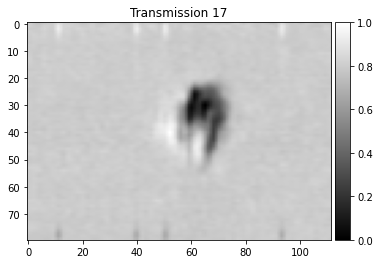

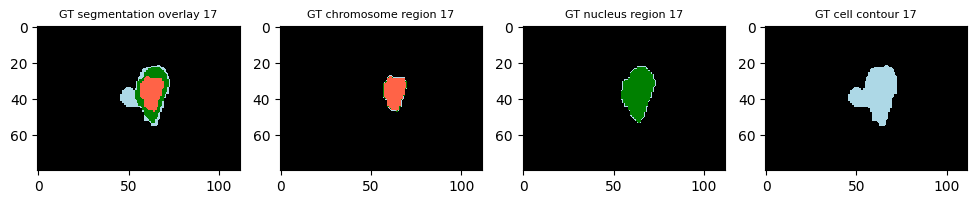

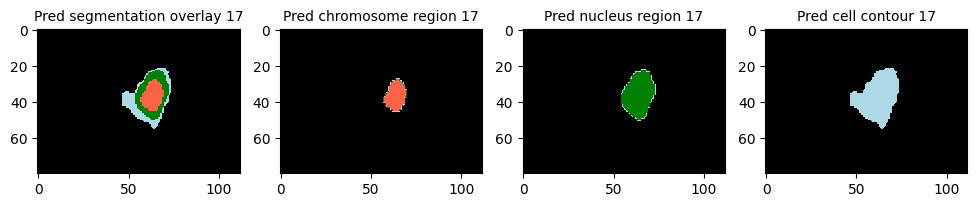

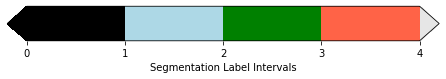

IoU score: 0.832, Chromesome F1score: 0.850, Nucleus F1score: 0.933, Cell F1score: 0.910, Chromesome precision: 0.919, Nucleus precision: 0.959, Cell precision: 0.892, Chromesome recall: 0.790, Nucleus recall: 0.908, Cell recall: 0.930


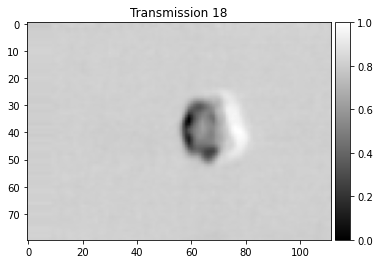

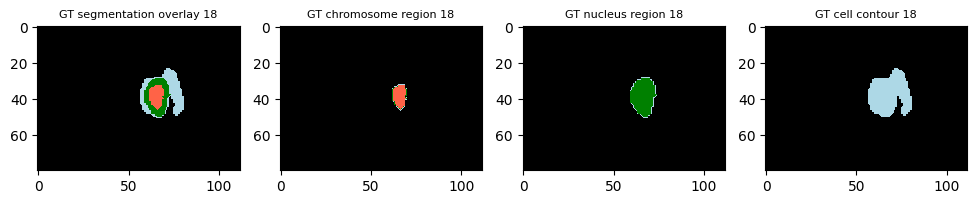

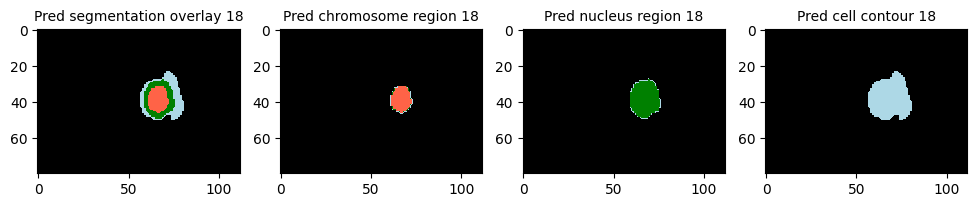

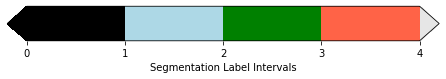

IoU score: 0.830, Chromesome F1score: 0.766, Nucleus F1score: 0.882, Cell F1score: 0.954, Chromesome precision: 0.620, Nucleus precision: 0.804, Cell precision: 0.934, Chromesome recall: 1.000, Nucleus recall: 0.979, Cell recall: 0.976


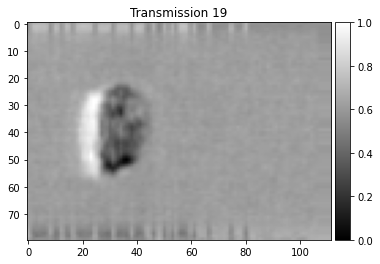

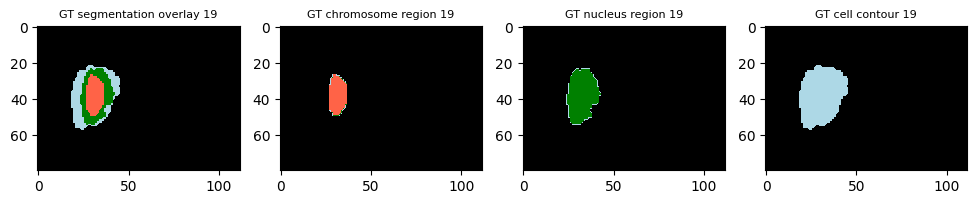

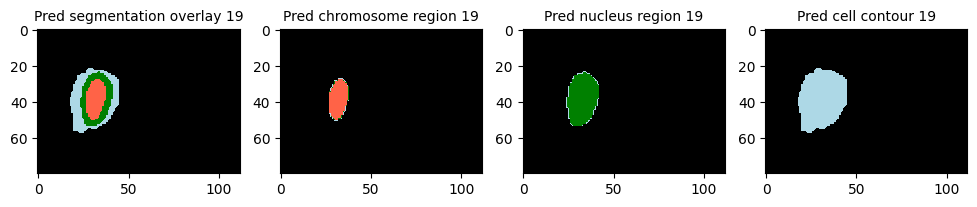

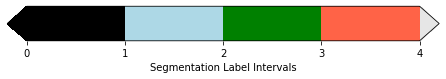

IoU score: 0.914, Chromesome F1score: 0.911, Nucleus F1score: 0.953, Cell F1score: 0.968, Chromesome precision: 0.896, Nucleus precision: 0.968, Cell precision: 0.951, Chromesome recall: 0.925, Nucleus recall: 0.939, Cell recall: 0.985
mean iou_score:  0.8673894166410037
mean precision chromesome:  0.8029209504450014
mean precision nucleus:  0.9290033335643101
mean precision cell:  0.9420899183304993
mean recall chromesome:  0.8870939037300332
mean recall nucleus:  0.9467874907992077
mean recall cell:  0.9554836955629405
mean F1score chromesome:  0.836643776578943
mean F1score nucleus:  0.9365659586718874
mean F1score cell:  0.9476077140336759
Initializing Datasets and Dataloaders...


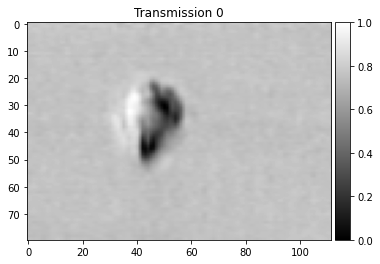

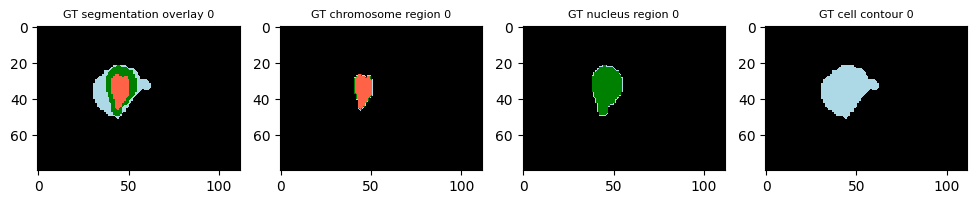

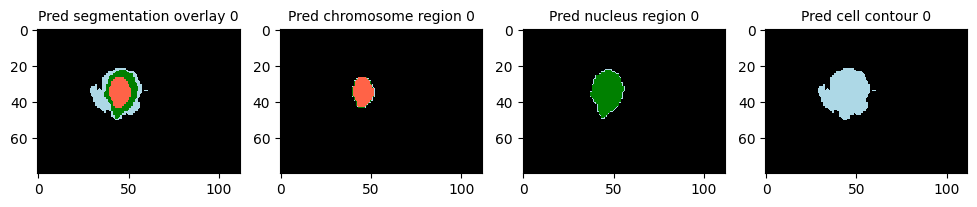

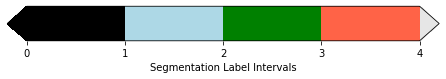

IoU score: 0.826, Chromesome F1score: 0.897, Nucleus F1score: 0.926, Cell F1score: 0.895, Chromesome precision: 0.865, Nucleus precision: 0.920, Cell precision: 0.909, Chromesome recall: 0.931, Nucleus recall: 0.931, Cell recall: 0.881


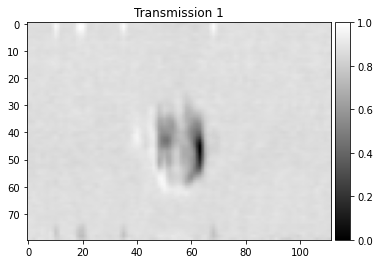

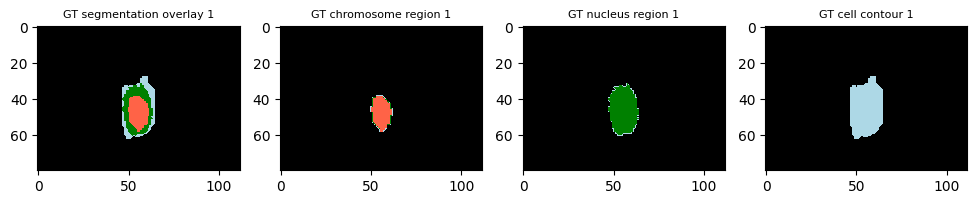

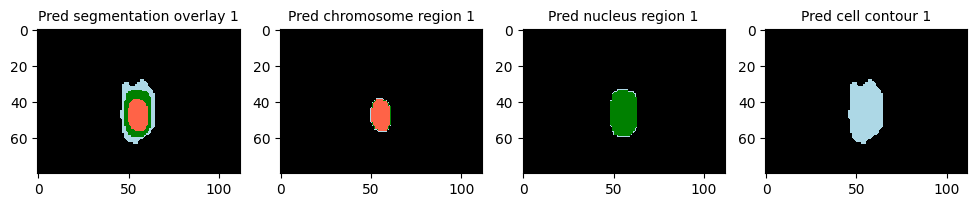

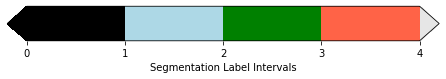

IoU score: 0.912, Chromesome F1score: 0.941, Nucleus F1score: 0.954, Cell F1score: 0.958, Chromesome precision: 0.946, Nucleus precision: 0.980, Cell precision: 0.930, Chromesome recall: 0.935, Nucleus recall: 0.929, Cell recall: 0.988


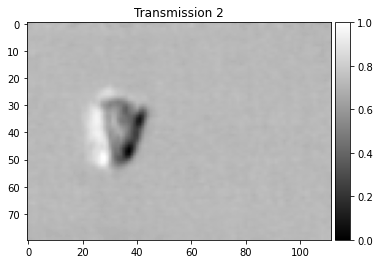

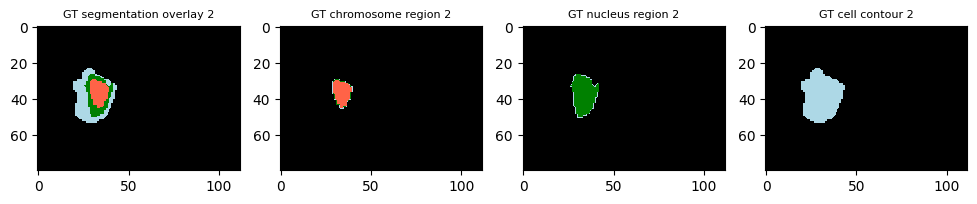

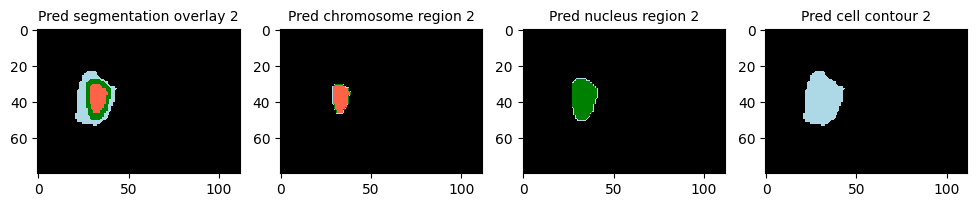

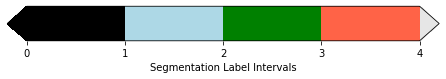

IoU score: 0.887, Chromesome F1score: 0.866, Nucleus F1score: 0.939, Cell F1score: 0.959, Chromesome precision: 0.870, Nucleus precision: 0.927, Cell precision: 0.974, Chromesome recall: 0.863, Nucleus recall: 0.952, Cell recall: 0.945


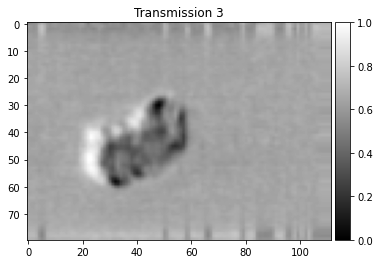

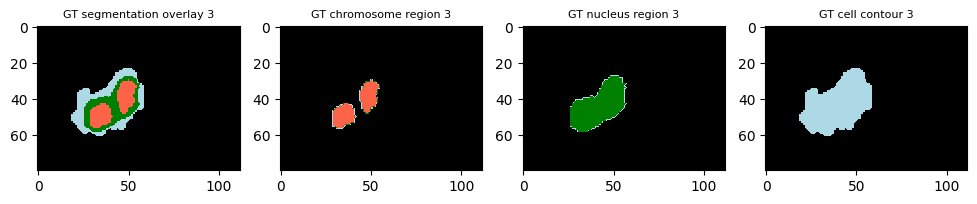

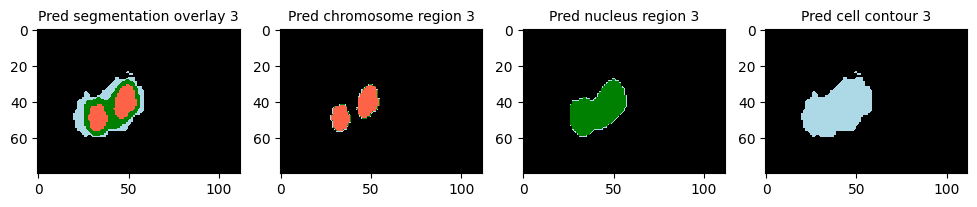

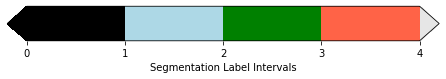

IoU score: 0.872, Chromesome F1score: 0.830, Nucleus F1score: 0.946, Cell F1score: 0.955, Chromesome precision: 0.809, Nucleus precision: 0.924, Cell precision: 0.985, Chromesome recall: 0.853, Nucleus recall: 0.969, Cell recall: 0.926


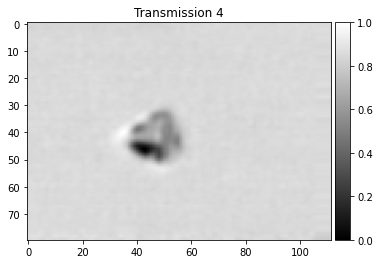

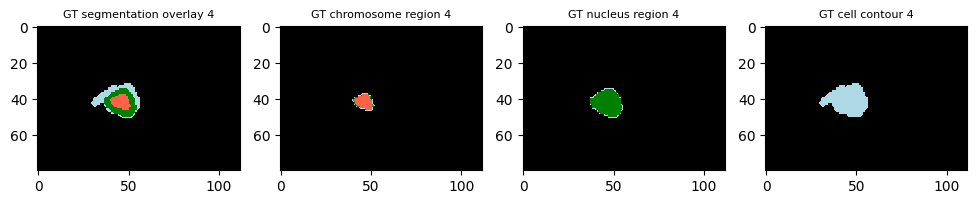

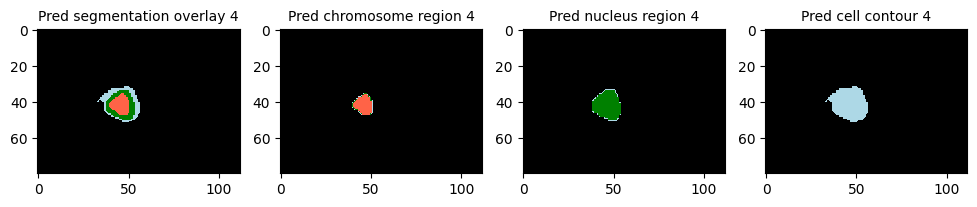

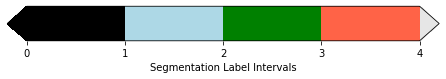

IoU score: 0.867, Chromesome F1score: 0.855, Nucleus F1score: 0.952, Cell F1score: 0.933, Chromesome precision: 0.755, Nucleus precision: 0.947, Cell precision: 0.953, Chromesome recall: 0.986, Nucleus recall: 0.956, Cell recall: 0.913


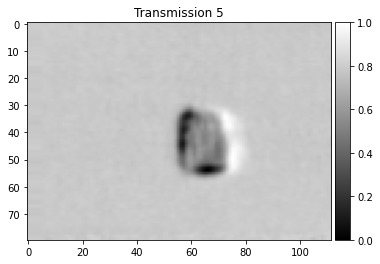

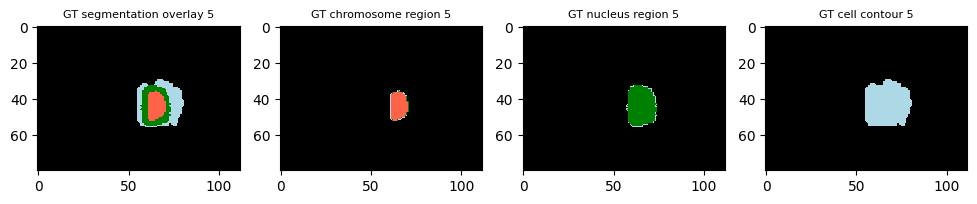

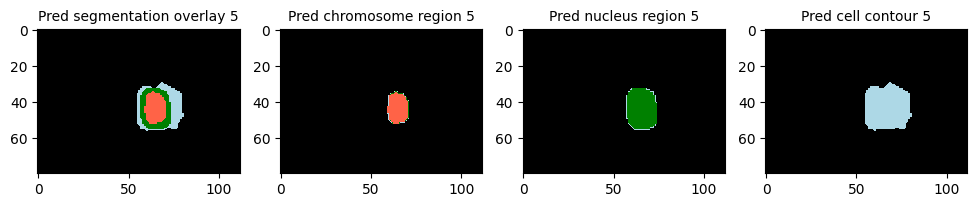

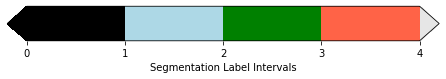

IoU score: 0.910, Chromesome F1score: 0.881, Nucleus F1score: 0.943, Cell F1score: 0.978, Chromesome precision: 0.787, Nucleus precision: 0.899, Cell precision: 0.981, Chromesome recall: 1.000, Nucleus recall: 0.990, Cell recall: 0.975


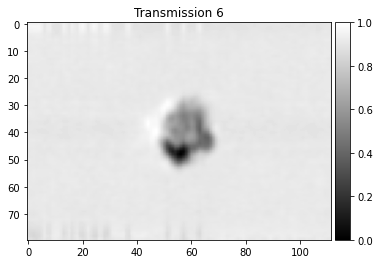

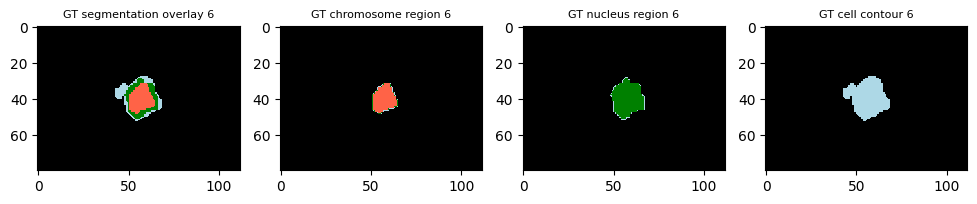

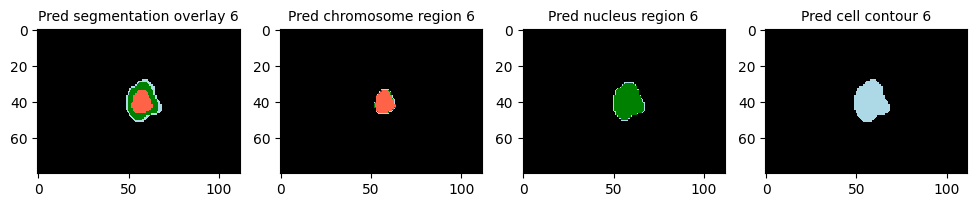

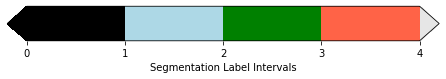

IoU score: 0.811, Chromesome F1score: 0.816, Nucleus F1score: 0.930, Cell F1score: 0.900, Chromesome precision: 1.000, Nucleus precision: 0.981, Cell precision: 0.994, Chromesome recall: 0.689, Nucleus recall: 0.884, Cell recall: 0.823


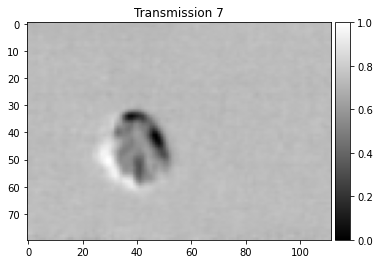

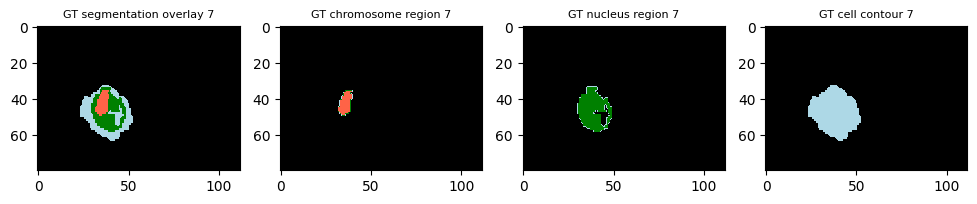

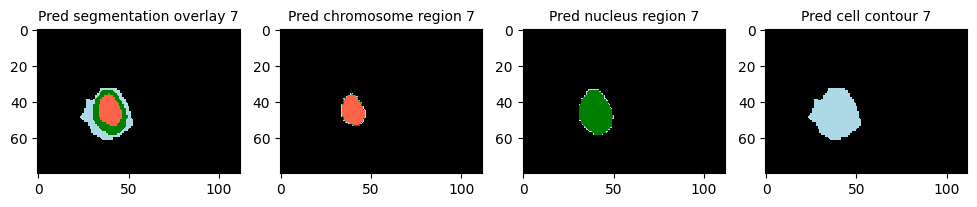

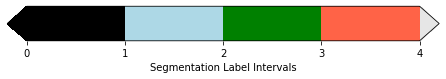

IoU score: 0.758, Chromesome F1score: 0.452, Nucleus F1score: 0.874, Cell F1score: 0.942, Chromesome precision: 0.327, Nucleus precision: 0.814, Cell precision: 0.958, Chromesome recall: 0.727, Nucleus recall: 0.944, Cell recall: 0.926


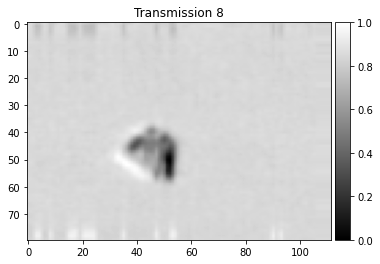

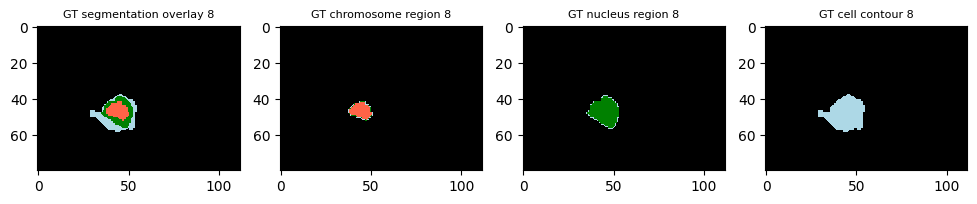

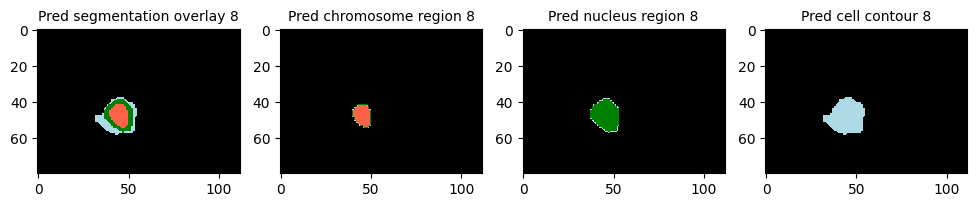

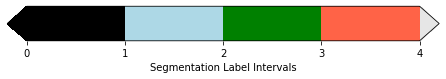

IoU score: 0.874, Chromesome F1score: 0.808, Nucleus F1score: 0.942, Cell F1score: 0.963, Chromesome precision: 0.765, Nucleus precision: 0.914, Cell precision: 0.973, Chromesome recall: 0.857, Nucleus recall: 0.971, Cell recall: 0.953


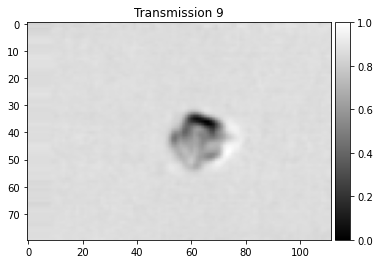

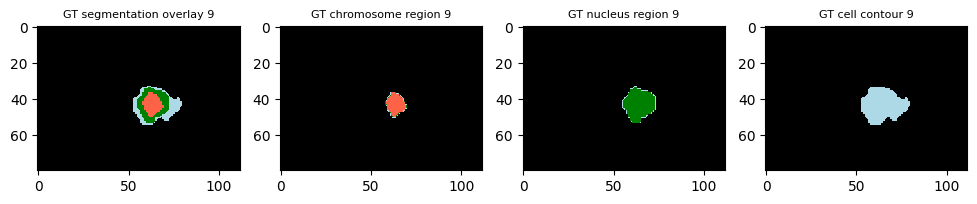

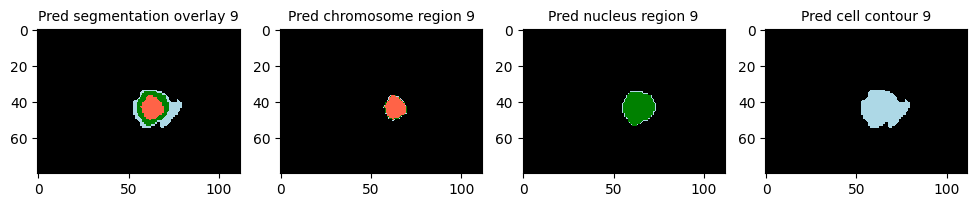

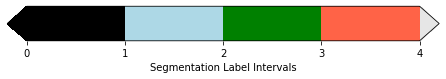

IoU score: 0.930, Chromesome F1score: 0.925, Nucleus F1score: 0.959, Cell F1score: 0.977, Chromesome precision: 0.868, Nucleus precision: 0.949, Cell precision: 0.965, Chromesome recall: 0.991, Nucleus recall: 0.968, Cell recall: 0.990


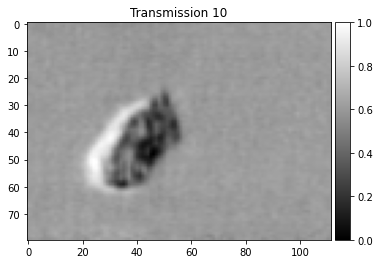

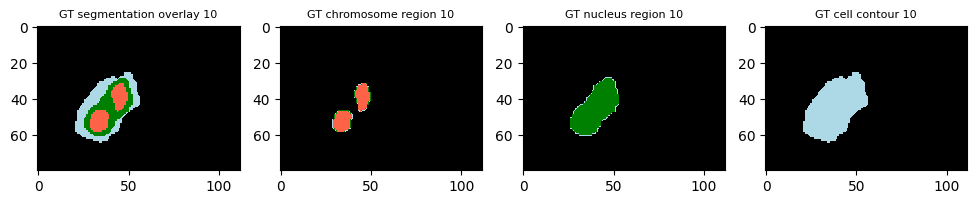

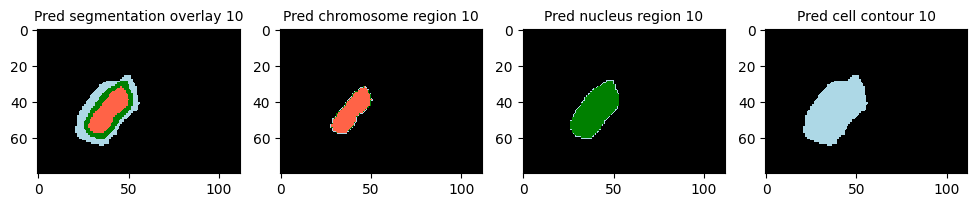

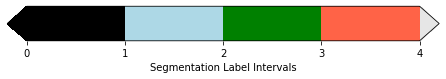

IoU score: 0.892, Chromesome F1score: 0.783, Nucleus F1score: 0.957, Cell F1score: 0.980, Chromesome precision: 0.677, Nucleus precision: 0.942, Cell precision: 0.986, Chromesome recall: 0.928, Nucleus recall: 0.972, Cell recall: 0.975


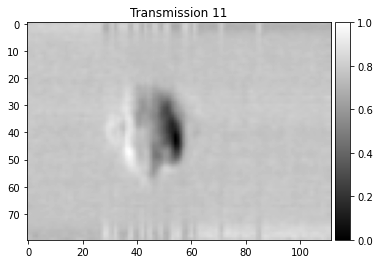

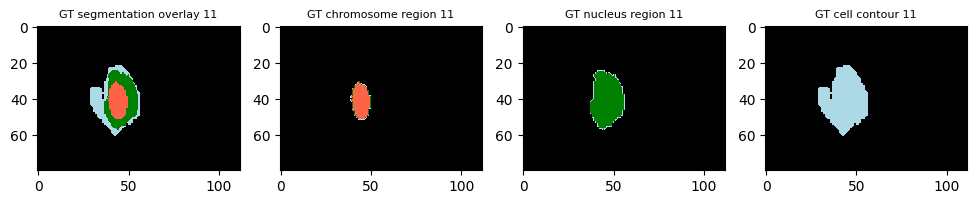

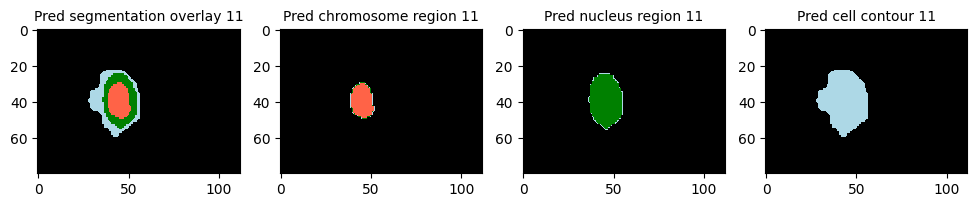

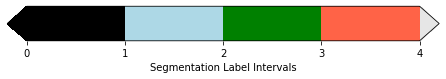

IoU score: 0.837, Chromesome F1score: 0.820, Nucleus F1score: 0.914, Cell F1score: 0.934, Chromesome precision: 0.754, Nucleus precision: 0.922, Cell precision: 0.916, Chromesome recall: 0.898, Nucleus recall: 0.906, Cell recall: 0.952


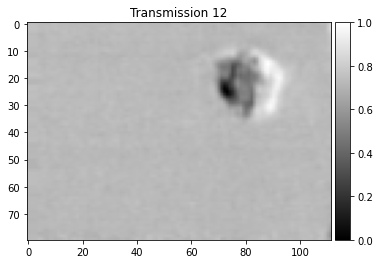

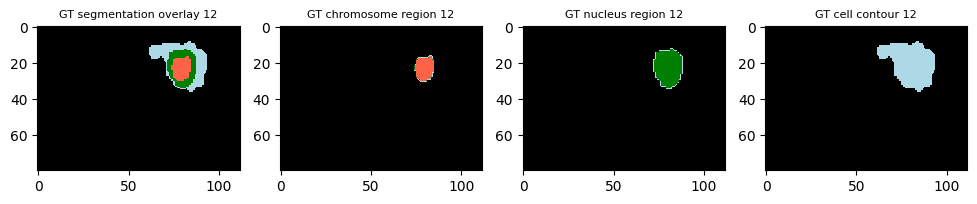

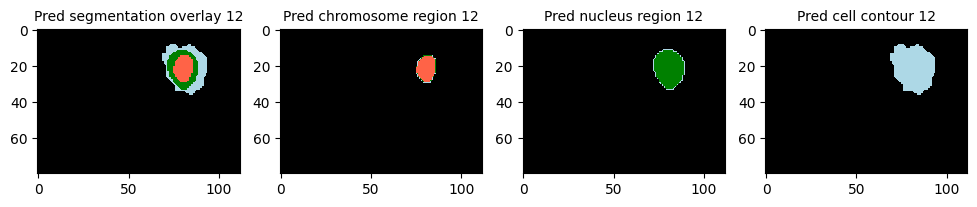

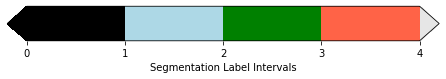

IoU score: 0.837, Chromesome F1score: 0.813, Nucleus F1score: 0.914, Cell F1score: 0.932, Chromesome precision: 0.785, Nucleus precision: 0.896, Cell precision: 0.985, Chromesome recall: 0.843, Nucleus recall: 0.932, Cell recall: 0.885


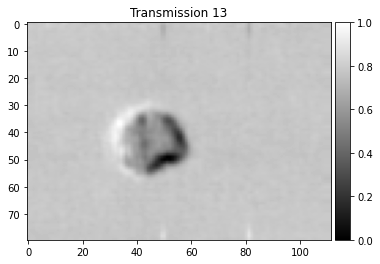

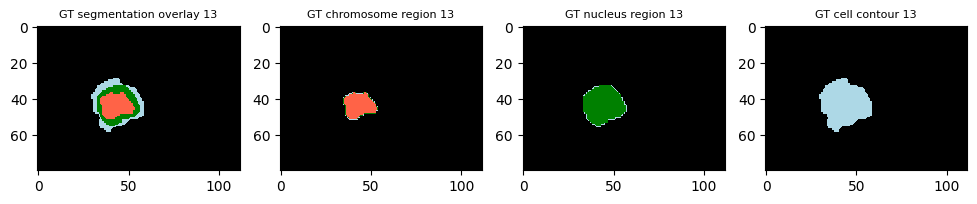

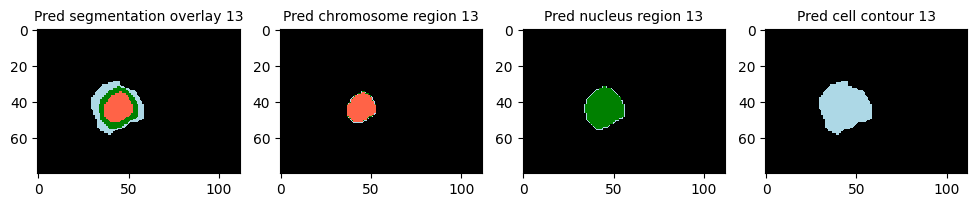

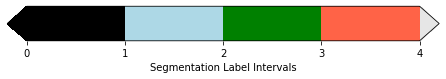

IoU score: 0.901, Chromesome F1score: 0.840, Nucleus F1score: 0.949, Cell F1score: 0.984, Chromesome precision: 0.842, Nucleus precision: 0.976, Cell precision: 0.972, Chromesome recall: 0.837, Nucleus recall: 0.922, Cell recall: 0.997


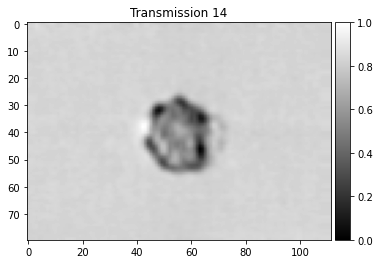

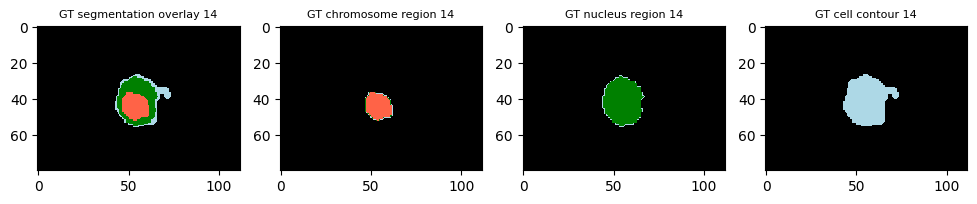

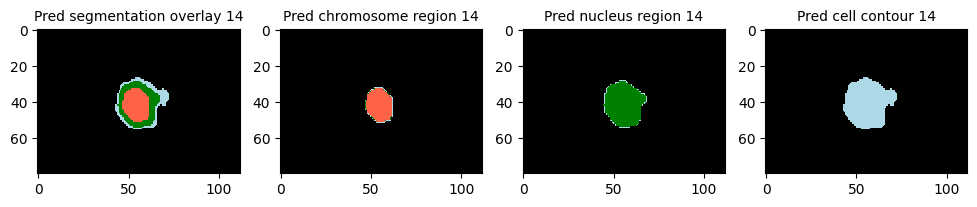

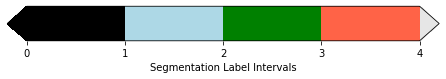

IoU score: 0.884, Chromesome F1score: 0.820, Nucleus F1score: 0.945, Cell F1score: 0.975, Chromesome precision: 0.741, Nucleus precision: 0.971, Cell precision: 0.965, Chromesome recall: 0.918, Nucleus recall: 0.919, Cell recall: 0.985


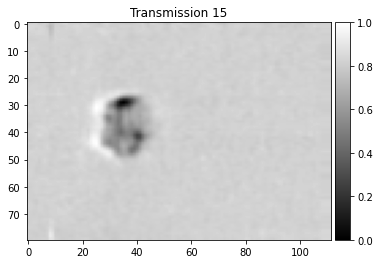

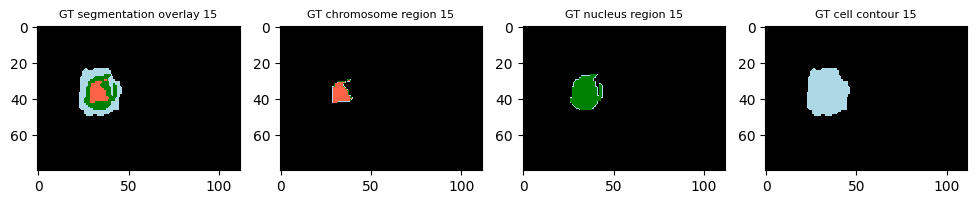

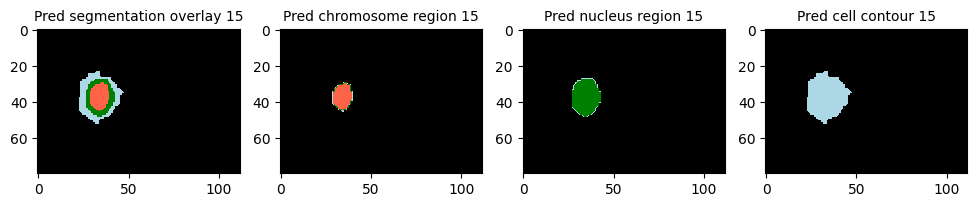

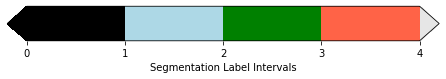

IoU score: 0.829, Chromesome F1score: 0.771, Nucleus F1score: 0.914, Cell F1score: 0.933, Chromesome precision: 0.656, Nucleus precision: 0.902, Cell precision: 0.964, Chromesome recall: 0.935, Nucleus recall: 0.926, Cell recall: 0.904


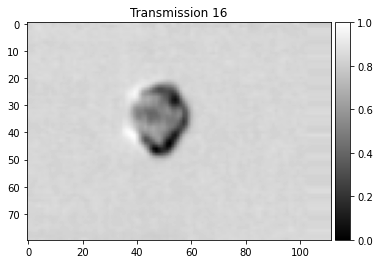

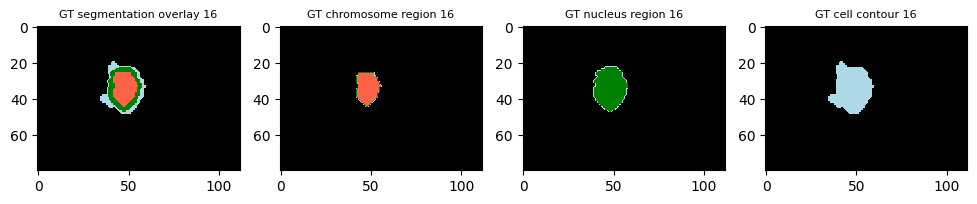

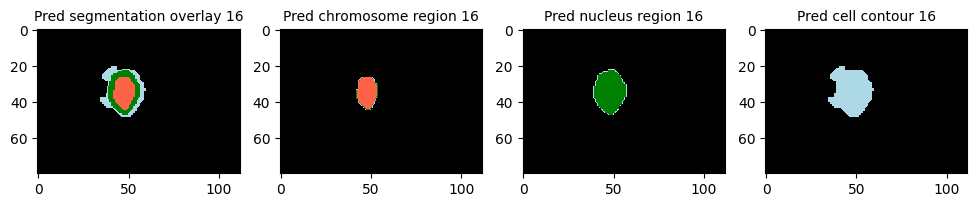

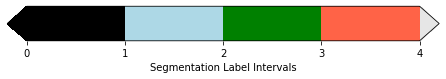

IoU score: 0.912, Chromesome F1score: 0.903, Nucleus F1score: 0.961, Cell F1score: 0.969, Chromesome precision: 0.982, Nucleus precision: 0.991, Cell precision: 0.959, Chromesome recall: 0.836, Nucleus recall: 0.932, Cell recall: 0.979


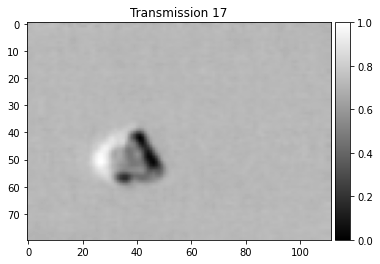

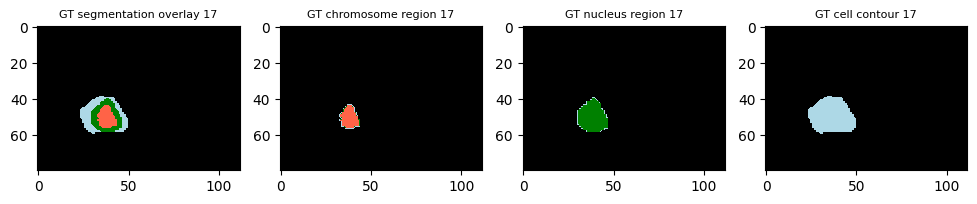

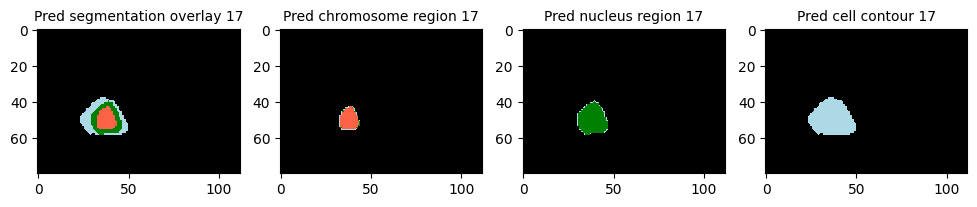

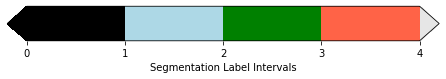

IoU score: 0.917, Chromesome F1score: 0.887, Nucleus F1score: 0.968, Cell F1score: 0.968, Chromesome precision: 0.855, Nucleus precision: 0.974, Cell precision: 0.980, Chromesome recall: 0.922, Nucleus recall: 0.962, Cell recall: 0.956


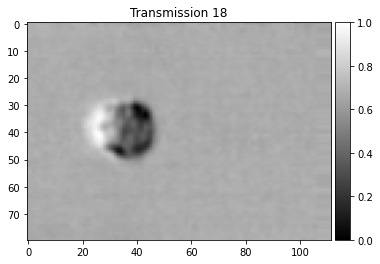

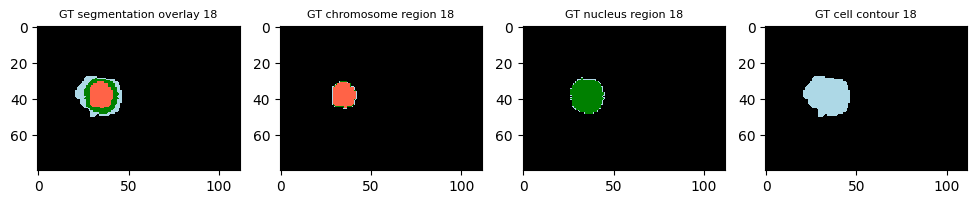

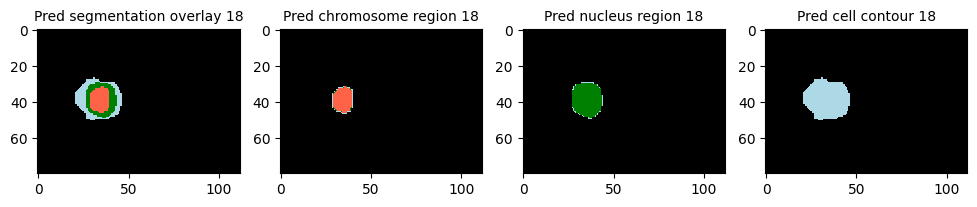

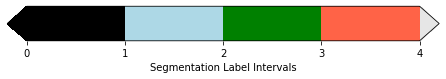

IoU score: 0.901, Chromesome F1score: 0.864, Nucleus F1score: 0.958, Cell F1score: 0.969, Chromesome precision: 0.934, Nucleus precision: 0.986, Cell precision: 0.952, Chromesome recall: 0.804, Nucleus recall: 0.932, Cell recall: 0.986


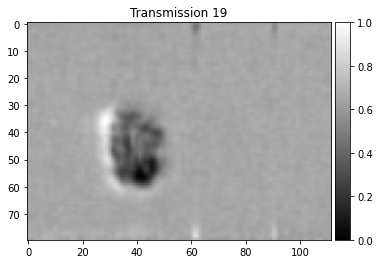

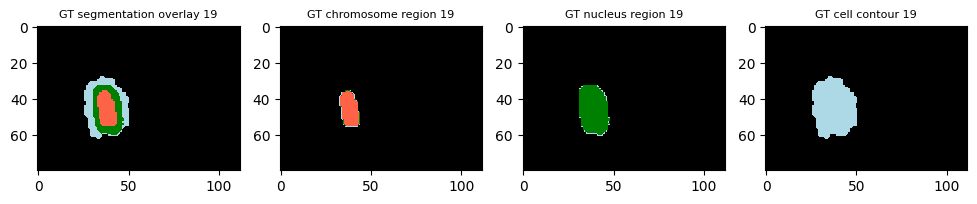

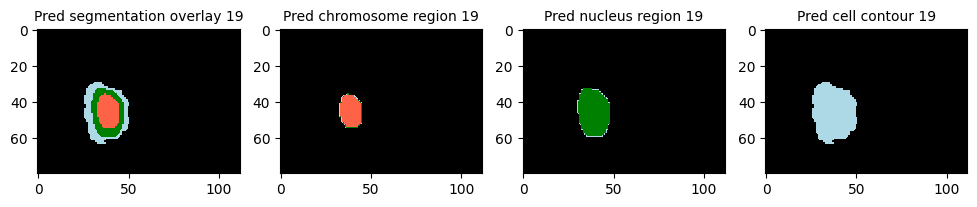

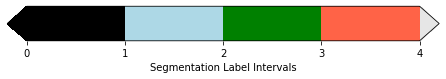

IoU score: 0.895, Chromesome F1score: 0.872, Nucleus F1score: 0.956, Cell F1score: 0.958, Chromesome precision: 0.835, Nucleus precision: 0.943, Cell precision: 0.971, Chromesome recall: 0.913, Nucleus recall: 0.969, Cell recall: 0.945
mean iou_score:  0.8762011100499835
mean precision chromesome:  0.8145082313092966
mean precision nucleus:  0.9341148331434103
mean precision cell:  0.9520008970650994
mean recall chromesome:  0.881835763061548
mean recall nucleus:  0.9484963369577445
mean recall cell:  0.9570399457280168
mean F1score chromesome:  0.8413674462707019
mean F1score nucleus:  0.9400196602523494
mean F1score cell:  0.9533911454236362


In [32]:
for runs in range (0,5):
    trainpath =[X[i] for i in trainindex[runs]]
    testpath =[X[i] for i in testindex[runs]]
    image_datasets = {}
#     image_datasets['train'] = MyDataset(trainpath[0:3000])
#     image_datasets['val'] = MyDataset(testpath[0:600])
    image_datasets['train'] = MyDataset(trainpath)
    image_datasets['val'] = MyDataset(testpath)
    print("Initializing Datasets and Dataloaders...")
    # Number of classes in the dataset
    num_classes = 3

    # Batch size for training (change depending on how much memory you have)
    batch_size = 1024
    # Create training and test dataloaders
    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=False, num_workers=0) for x in ['train', 'val']}
    
    # Initialize the non-pretrained version of the model used for this run
    fname = './cellSegmentationmodel-UNetSmall_rech_Run_'+str(runs)+'.pth.tar'
    scratch_model = torch.load(fname)
    # scratch_model_fc = nn.Sequential(*(list(scratch_model.children())[:1]),maxpool(),*(list(scratch_model.children())[1:2]),maxpool(),*(list(scratch_model.children())[2:3]),maxpool(),*(list(scratch_model.children())[3:4]),maxpool(),Flatten(),*(list(scratch_model.children())[-5:-3]))
    # scratch_model_fc = nn.Sequential(*list(scratch_model.children())[:-3])
    scratch_model = scratch_model.to(device)
    scratch_model.eval()

    # Detect if we have a GPU available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    with torch.no_grad():
        for i, (inputs,labels,idex) in enumerate(dataloaders_dict['val']):
    #         inputs = inputs.type(torch.FloatTensor)
            inputs = inputs.to(device)
    #         labels = labels.to(device)
            outputs = scratch_model(inputs)
            outputs = torch.sigmoid(outputs)
            inputs = inputs.cpu().clone().numpy()
            outputs = outputs.cpu().clone().numpy()
            labels = labels.clone().numpy()
            if i == 0:
                inputlist = inputs
                outputlist = outputs
                labellist = labels
    #             y = classes.cpu().clone().numpy()
            else:
                inputlist = np.append(inputlist,inputs, axis=0)
                outputlist = np.append(outputlist,outputs, axis=0)
                labellist = np.append(labellist,labels,axis=0)
    #             y = np.append(y,classes.cpu().clone().numpy(), axis=0)

        iou_scoreList = 0
    for ImgIdx in range(0,20):
        image = np.transpose(inputlist[ImgIdx],(1,2,0))
        mask = labellist[ImgIdx]
        # print(image.shape)
        DisplayImage(image,image.min(),image.max(),ImgIdx)
        SegmentationVisualGT(mask,image,ImgIdx)
        maskpred = outputlist[ImgIdx]
        maskpred = np.round(maskpred).astype(np.uint8)
        SegmentationVisualPred(maskpred,image,ImgIdx)
        maskbool = mask.astype(dtype=bool)
    #     print(mask.shape)
        iou_score = clac_iouscore (mask, maskpred)
        Precision, Recall, F1score = clac_F1 (mask, maskpred)
        print('IoU score: %.3f, Chromesome F1score: %.3f, Nucleus F1score: %.3f, Cell F1score: %.3f, Chromesome precision: %.3f, Nucleus precision: %.3f, Cell precision: %.3f, Chromesome recall: %.3f, Nucleus recall: %.3f, Cell recall: %.3f'% (iou_score, F1score[0], F1score[1], F1score[2], Precision[0], Precision[1], Precision[2], Recall[0], Recall[1], Recall[2]))
        if i == 0:
            iou_scoreList = iou_score
        else:
            np.append(iou_scoreList,iou_score)
            
    
    iou_scoreList = np.zeros((outputlist.shape[0],))
    precisionList = np.zeros((outputlist.shape[0],3))
    recallList = np.zeros((outputlist.shape[0],3))
    F1scoreList = np.zeros((outputlist.shape[0],3))

    for ImgIdx in range(0,outputlist.shape[0]):
        image = np.transpose(inputlist[ImgIdx],(1,2,0))
        mask = labellist[ImgIdx]
        # print(image.shape)
    #     DisplayImage(image,image.min(),image.max(),ImgIdx)
    #     SegmentationVisualGT(mask,image,ImgIdx)
        maskpred = outputlist[ImgIdx]
        maskpred = np.round(maskpred).astype(np.uint8)
    #     SegmentationVisualPred(maskpred,image,ImgIdx)
    #     maskbool = mask.astype(dtype=bool)
    #     print(mask.shape)
        iou_score = clac_iouscore (mask, maskpred)
        Precision, Recall, F1score = clac_F1 (mask, maskpred)
        iou_scoreList[ImgIdx] = iou_score
        precisionList[ImgIdx] = Precision
        recallList[ImgIdx] = Recall
        F1scoreList[ImgIdx] = F1score
        
    meaniou_score = np.mean(iou_scoreList)
    meanprecisionChrome = np.mean(precisionList[:,0])
    meanprecisionNucleus = np.mean(precisionList[:,1])
    meanprecisionCell = np.mean(precisionList[:,2])
    print('mean iou_score: ',meaniou_score)
    print('mean precision chromesome: ', meanprecisionChrome)
    print('mean precision nucleus: ', meanprecisionNucleus)
    print('mean precision cell: ', meanprecisionCell)
    print('mean recall chromesome: ', np.mean(recallList[:,0]))
    print('mean recall nucleus: ', np.mean(recallList[:,1]))
    print('mean recall cell: ', np.mean(recallList[:,2]))
    print('mean F1score chromesome: ', np.mean(F1scoreList[:,0]))
    print('mean F1score nucleus: ', np.mean(F1scoreList[:,1]))
    print('mean F1score cell: ', np.mean(F1scoreList[:,2]))